##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 过拟合与欠拟合

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在  TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

与往常一样，本示例中的代码将使用 `tf.keras` API，您可以通过 TensorFlow [Keras 指南](https://tensorflow.google.cn/guide/keras)了解详细信息。

在之前的两个示例（[文本分类](text_classification_with_hub.ipynb)和[预测燃油效率](regression.ipynb)）中，可以看到模型在验证数据上的准确率会在经过多个周期的训练后达到峰值，然后便停滞不前或开始下降。

换句话说，模型会对训练数据*过拟合*。学习如何处理过拟合很重要。尽管模型通常可以在*训练集*上达到很高的准确率，但我们真正想要的是开发出能很好地泛化到*测试集*（或之前未见过的数据）的模型。

过拟合的反面是*欠拟合*。当在测试数据上仍有改进空间时就会发生欠拟合。出现这种情况的原因有很多：模型不够强大、过度正则化，或者只是训练时间不够长。这种情况意味着网络尚未学习训练数据中的相关模式。

但如果训练时间过长，模型则会开始过拟合，并从训练数据中学习无法泛化到测试数据的模式。我们需要找到平衡点。了解如何训练合适数量的周期（将在下文进行探讨）是一项十分有用的技能。

要防止过拟合，最好的解决方案是使用更完整的训练数据。数据集应该涵盖模型要处理的所有输入。其他数据可能只有在涉及新的值得关注的情况时才有用。

在更完整的数据上训练的模型自然能更好地进行泛化。如果没有更完整的数据，则第二好的解决方案是使用正则化之类的技术。这些技术限制了模型可以存储的信息的数量和类型。如果网络只能记住少量的模式，则优化过程将迫使其关注最突出的模式，这些模式将有机会获得更好地泛化。

在此笔记本中，您将探索几种常见的正则化技术，并使用这些技术改进分类模型。

## 设置

在开始之前，请导入必要的软件包：

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2023-11-08 00:10:16.711022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 00:10:16.711068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 00:10:16.712774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0-rc1


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmpfs/tmp/pip-req-build-if4mzyx2


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmpfs/tmp/pip-req-build-if4mzyx2


  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef


  Preparing metadata (setup.py) ... -

 done


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


 \

 done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=c0bcd44b9b93a2601707d1e579ceae86eb8804e34348e58aa0faab3a5d015112
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-rx20qte7/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## 希格斯数据集

本教程的目的不是粒子物理学，因此无需关注数据集的细节。它包含 11,000,000 个样本，每个样本有 28 个特征和一个二元类标签。

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

      8192/2816407858 [..............................] - ETA: 2s

     40960/2816407858 [..............................] - ETA: 58:37

     81920/2816407858 [..............................] - ETA: 58:06

    155648/2816407858 [..............................] - ETA: 45:58

    278528/2816407858 [..............................] - ETA: 34:11

    516096/2816407858 [..............................] - ETA: 23:01

    819200/2816407858 [..............................] - ETA: 17:24

   1122304/2816407858 [..............................] - ETA: 14:49

   1425408/2816407858 [..............................] - ETA: 13:20

   1736704/2816407858 [..............................] - ETA: 12:19

   2048000/2816407858 [..............................] - ETA: 11:37

   2351104/2816407858 [..............................] - ETA: 11:07

   2654208/2816407858 [..............................] - ETA: 10:45

   2957312/2816407858 [..............................] - ETA: 10:26

   3252224/2816407858 [..............................] - ETA: 10:13

   3563520/2816407858 [..............................] - ETA: 10:00

   3866624/2816407858 [..............................] - ETA: 9:49 

   4177920/2816407858 [..............................] - ETA: 9:40

   4489216/2816407858 [..............................] - ETA: 9:31

   4800512/2816407858 [..............................] - ETA: 9:24

   5103616/2816407858 [..............................] - ETA: 9:18

   5406720/2816407858 [..............................] - ETA: 9:13

   5709824/2816407858 [..............................] - ETA: 9:08

   6012928/2816407858 [..............................] - ETA: 9:04

   6324224/2816407858 [..............................] - ETA: 9:00

   6627328/2816407858 [..............................] - ETA: 8:56

   6930432/2816407858 [..............................] - ETA: 8:53

   7233536/2816407858 [..............................] - ETA: 8:50

   7544832/2816407858 [..............................] - ETA: 8:47

   7847936/2816407858 [..............................] - ETA: 8:45

   8159232/2816407858 [..............................] - ETA: 8:42

   8470528/2816407858 [..............................] - ETA: 8:40

   8781824/2816407858 [..............................] - ETA: 8:38

   9084928/2816407858 [..............................] - ETA: 8:36

   9379840/2816407858 [..............................] - ETA: 8:35

   9682944/2816407858 [..............................] - ETA: 8:33

   9986048/2816407858 [..............................] - ETA: 8:32

  10289152/2816407858 [..............................] - ETA: 8:30

  10592256/2816407858 [..............................] - ETA: 8:29

  10895360/2816407858 [..............................] - ETA: 8:28

  11198464/2816407858 [..............................] - ETA: 8:27

  11509760/2816407858 [..............................] - ETA: 8:26

  11812864/2816407858 [..............................] - ETA: 8:25

  12124160/2816407858 [..............................] - ETA: 8:23

  12427264/2816407858 [..............................] - ETA: 8:22

  12738560/2816407858 [..............................] - ETA: 8:21

  13049856/2816407858 [..............................] - ETA: 8:20

  13361152/2816407858 [..............................] - ETA: 8:19

  13672448/2816407858 [..............................] - ETA: 8:18

  13967360/2816407858 [..............................] - ETA: 8:18

  14270464/2816407858 [..............................] - ETA: 8:17

  14573568/2816407858 [..............................] - ETA: 8:16

  14876672/2816407858 [..............................] - ETA: 8:16

  15171584/2816407858 [..............................] - ETA: 8:15

  15474688/2816407858 [..............................] - ETA: 8:15

  15777792/2816407858 [..............................] - ETA: 8:14

  16080896/2816407858 [..............................] - ETA: 8:14

  16384000/2816407858 [..............................] - ETA: 8:13

  16687104/2816407858 [..............................] - ETA: 8:13

  16990208/2816407858 [..............................] - ETA: 8:12

  17293312/2816407858 [..............................] - ETA: 8:12

  17596416/2816407858 [..............................] - ETA: 8:11

  17899520/2816407858 [..............................] - ETA: 8:11

  18202624/2816407858 [..............................] - ETA: 8:10

  18505728/2816407858 [..............................] - ETA: 8:10

  18817024/2816407858 [..............................] - ETA: 8:09

  19120128/2816407858 [..............................] - ETA: 8:09

  19423232/2816407858 [..............................] - ETA: 8:09

  19726336/2816407858 [..............................] - ETA: 8:08

  20029440/2816407858 [..............................] - ETA: 8:08

  20332544/2816407858 [..............................] - ETA: 8:08

  20635648/2816407858 [..............................] - ETA: 8:07

  20938752/2816407858 [..............................] - ETA: 8:07

  21225472/2816407858 [..............................] - ETA: 8:07

  21520384/2816407858 [..............................] - ETA: 8:07

  21823488/2816407858 [..............................] - ETA: 8:06

  22126592/2816407858 [..............................] - ETA: 8:06

  22429696/2816407858 [..............................] - ETA: 8:06

  22732800/2816407858 [..............................] - ETA: 8:05

  23035904/2816407858 [..............................] - ETA: 8:05

  23339008/2816407858 [..............................] - ETA: 8:05

  23642112/2816407858 [..............................] - ETA: 8:05

  23945216/2816407858 [..............................] - ETA: 8:04

  24248320/2816407858 [..............................] - ETA: 8:04

  24551424/2816407858 [..............................] - ETA: 8:04

  24854528/2816407858 [..............................] - ETA: 8:03

  25157632/2816407858 [..............................] - ETA: 8:03

  25460736/2816407858 [..............................] - ETA: 8:03

  25763840/2816407858 [..............................] - ETA: 8:03

  26075136/2816407858 [..............................] - ETA: 8:02

  26378240/2816407858 [..............................] - ETA: 8:02

  26681344/2816407858 [..............................] - ETA: 8:02

  26984448/2816407858 [..............................] - ETA: 8:02

  27279360/2816407858 [..............................] - ETA: 8:02

  27582464/2816407858 [..............................] - ETA: 8:01

  27885568/2816407858 [..............................] - ETA: 8:01

  28188672/2816407858 [..............................] - ETA: 8:01

  28491776/2816407858 [..............................] - ETA: 8:01

  28794880/2816407858 [..............................] - ETA: 8:01

  29106176/2816407858 [..............................] - ETA: 8:00

  29409280/2816407858 [..............................] - ETA: 8:00

  29712384/2816407858 [..............................] - ETA: 8:00

  30015488/2816407858 [..............................] - ETA: 8:00

  30318592/2816407858 [..............................] - ETA: 7:59

  30621696/2816407858 [..............................] - ETA: 7:59

  30924800/2816407858 [..............................] - ETA: 7:59

  31227904/2816407858 [..............................] - ETA: 7:59

  31539200/2816407858 [..............................] - ETA: 7:59

  31842304/2816407858 [..............................] - ETA: 7:58

  32145408/2816407858 [..............................] - ETA: 7:58

  32440320/2816407858 [..............................] - ETA: 7:58

  32743424/2816407858 [..............................] - ETA: 7:58

  33038336/2816407858 [..............................] - ETA: 7:58

  33333248/2816407858 [..............................] - ETA: 7:58

  33636352/2816407858 [..............................] - ETA: 7:58

  33939456/2816407858 [..............................] - ETA: 7:58

  34242560/2816407858 [..............................] - ETA: 7:57

  34545664/2816407858 [..............................] - ETA: 7:57

  34848768/2816407858 [..............................] - ETA: 7:57

  35151872/2816407858 [..............................] - ETA: 7:57

  35454976/2816407858 [..............................] - ETA: 7:57

  35758080/2816407858 [..............................] - ETA: 7:57

  36061184/2816407858 [..............................] - ETA: 7:56

  36364288/2816407858 [..............................] - ETA: 7:56

  36667392/2816407858 [..............................] - ETA: 7:56

  36970496/2816407858 [..............................] - ETA: 7:56

  37273600/2816407858 [..............................] - ETA: 7:56

  37576704/2816407858 [..............................] - ETA: 7:56

  37879808/2816407858 [..............................] - ETA: 7:56

  38182912/2816407858 [..............................] - ETA: 7:55

  38486016/2816407858 [..............................] - ETA: 7:55

  38789120/2816407858 [..............................] - ETA: 7:55

  39084032/2816407858 [..............................] - ETA: 7:55

  39378944/2816407858 [..............................] - ETA: 7:55

  39682048/2816407858 [..............................] - ETA: 7:55

  39985152/2816407858 [..............................] - ETA: 7:55

  40288256/2816407858 [..............................] - ETA: 7:55

  40591360/2816407858 [..............................] - ETA: 7:54

  40894464/2816407858 [..............................] - ETA: 7:54

  41197568/2816407858 [..............................] - ETA: 7:54

  41500672/2816407858 [..............................] - ETA: 7:54

  41803776/2816407858 [..............................] - ETA: 7:54

  42115072/2816407858 [..............................] - ETA: 7:54

  42418176/2816407858 [..............................] - ETA: 7:53

  42721280/2816407858 [..............................] - ETA: 7:53

  43024384/2816407858 [..............................] - ETA: 7:53

  43327488/2816407858 [..............................] - ETA: 7:53

  43630592/2816407858 [..............................] - ETA: 7:53

  43933696/2816407858 [..............................] - ETA: 7:53

  44236800/2816407858 [..............................] - ETA: 7:53

  44539904/2816407858 [..............................] - ETA: 7:53

  44834816/2816407858 [..............................] - ETA: 7:53

  45129728/2816407858 [..............................] - ETA: 7:53

  45432832/2816407858 [..............................] - ETA: 7:53

  45735936/2816407858 [..............................] - ETA: 7:52

  46039040/2816407858 [..............................] - ETA: 7:52

  46342144/2816407858 [..............................] - ETA: 7:52

  46645248/2816407858 [..............................] - ETA: 7:52

  46948352/2816407858 [..............................] - ETA: 7:52

  47251456/2816407858 [..............................] - ETA: 7:52

  47562752/2816407858 [..............................] - ETA: 7:52

  47865856/2816407858 [..............................] - ETA: 7:52

  48168960/2816407858 [..............................] - ETA: 7:52

  48472064/2816407858 [..............................] - ETA: 7:51

  48775168/2816407858 [..............................] - ETA: 7:51

  49078272/2816407858 [..............................] - ETA: 7:51

  49389568/2816407858 [..............................] - ETA: 7:51

  49700864/2816407858 [..............................] - ETA: 7:51

  50003968/2816407858 [..............................] - ETA: 7:51

  50315264/2816407858 [..............................] - ETA: 7:51

  50618368/2816407858 [..............................] - ETA: 7:50

  50921472/2816407858 [..............................] - ETA: 7:50

  51224576/2816407858 [..............................] - ETA: 7:50

  51535872/2816407858 [..............................] - ETA: 7:50

  51847168/2816407858 [..............................] - ETA: 7:50

  52158464/2816407858 [..............................] - ETA: 7:50

  52461568/2816407858 [..............................] - ETA: 7:50

  52764672/2816407858 [..............................] - ETA: 7:50

  53067776/2816407858 [..............................] - ETA: 7:49

  53370880/2816407858 [..............................] - ETA: 7:49

  53673984/2816407858 [..............................] - ETA: 7:49

  53977088/2816407858 [..............................] - ETA: 7:49

  54288384/2816407858 [..............................] - ETA: 7:49

  54591488/2816407858 [..............................] - ETA: 7:49

  54894592/2816407858 [..............................] - ETA: 7:49

  55197696/2816407858 [..............................] - ETA: 7:49

  55508992/2816407858 [..............................] - ETA: 7:48

  55820288/2816407858 [..............................] - ETA: 7:48

  56131584/2816407858 [..............................] - ETA: 7:48

  56434688/2816407858 [..............................] - ETA: 7:48

  56737792/2816407858 [..............................] - ETA: 7:48

  57040896/2816407858 [..............................] - ETA: 7:48

  57344000/2816407858 [..............................] - ETA: 7:48

  57655296/2816407858 [..............................] - ETA: 7:48

  57958400/2816407858 [..............................] - ETA: 7:48

  58261504/2816407858 [..............................] - ETA: 7:47

  58564608/2816407858 [..............................] - ETA: 7:47

  58867712/2816407858 [..............................] - ETA: 7:47

  59179008/2816407858 [..............................] - ETA: 7:47

  59490304/2816407858 [..............................] - ETA: 7:47

  59801600/2816407858 [..............................] - ETA: 7:47

  60104704/2816407858 [..............................] - ETA: 7:47

  60407808/2816407858 [..............................] - ETA: 7:47

  60710912/2816407858 [..............................] - ETA: 7:47

  61005824/2816407858 [..............................] - ETA: 7:47

  61308928/2816407858 [..............................] - ETA: 7:46

  61612032/2816407858 [..............................] - ETA: 7:46

  61915136/2816407858 [..............................] - ETA: 7:46

  62218240/2816407858 [..............................] - ETA: 7:46

  62521344/2816407858 [..............................] - ETA: 7:46

  62824448/2816407858 [..............................] - ETA: 7:46

  63119360/2816407858 [..............................] - ETA: 7:46

  63422464/2816407858 [..............................] - ETA: 7:46

  63725568/2816407858 [..............................] - ETA: 7:46

  64028672/2816407858 [..............................] - ETA: 7:46

  64331776/2816407858 [..............................] - ETA: 7:46

  64634880/2816407858 [..............................] - ETA: 7:46

  64937984/2816407858 [..............................] - ETA: 7:45

  65241088/2816407858 [..............................] - ETA: 7:45

  65544192/2816407858 [..............................] - ETA: 7:45

  65847296/2816407858 [..............................] - ETA: 7:45

  66150400/2816407858 [..............................] - ETA: 7:45

  66453504/2816407858 [..............................] - ETA: 7:45

  66764800/2816407858 [..............................] - ETA: 7:45

  67076096/2816407858 [..............................] - ETA: 7:45

  67379200/2816407858 [..............................] - ETA: 7:45

  67682304/2816407858 [..............................] - ETA: 7:45

  67985408/2816407858 [..............................] - ETA: 7:44

  68288512/2816407858 [..............................] - ETA: 7:44

  68591616/2816407858 [..............................] - ETA: 7:44

  68894720/2816407858 [..............................] - ETA: 7:44

  69189632/2816407858 [..............................] - ETA: 7:44

  69492736/2816407858 [..............................] - ETA: 7:44

  69795840/2816407858 [..............................] - ETA: 7:44

  70098944/2816407858 [..............................] - ETA: 7:44

  70402048/2816407858 [..............................] - ETA: 7:44

  70713344/2816407858 [..............................] - ETA: 7:44

  71016448/2816407858 [..............................] - ETA: 7:44

  71319552/2816407858 [..............................] - ETA: 7:44

  71622656/2816407858 [..............................] - ETA: 7:43

  71933952/2816407858 [..............................] - ETA: 7:43

  72245248/2816407858 [..............................] - ETA: 7:43

  72548352/2816407858 [..............................] - ETA: 7:43

  72859648/2816407858 [..............................] - ETA: 7:43

  73170944/2816407858 [..............................] - ETA: 7:43

  73482240/2816407858 [..............................] - ETA: 7:43

  73793536/2816407858 [..............................] - ETA: 7:43

  74104832/2816407858 [..............................] - ETA: 7:43

  74416128/2816407858 [..............................] - ETA: 7:42

  74727424/2816407858 [..............................] - ETA: 7:42

  75030528/2816407858 [..............................] - ETA: 7:42

  75325440/2816407858 [..............................] - ETA: 7:42

  75636736/2816407858 [..............................] - ETA: 7:42

  75948032/2816407858 [..............................] - ETA: 7:42

  76259328/2816407858 [..............................] - ETA: 7:42

  76570624/2816407858 [..............................] - ETA: 7:42

  76881920/2816407858 [..............................] - ETA: 7:42

  77193216/2816407858 [..............................] - ETA: 7:41

  77496320/2816407858 [..............................] - ETA: 7:41

  77807616/2816407858 [..............................] - ETA: 7:41

  78118912/2816407858 [..............................] - ETA: 7:41

  78430208/2816407858 [..............................] - ETA: 7:41

  78741504/2816407858 [..............................] - ETA: 7:41

  79052800/2816407858 [..............................] - ETA: 7:41

  79364096/2816407858 [..............................] - ETA: 7:41

  79675392/2816407858 [..............................] - ETA: 7:41

  79986688/2816407858 [..............................] - ETA: 7:40

  80297984/2816407858 [..............................] - ETA: 7:40

  80609280/2816407858 [..............................] - ETA: 7:40

  80920576/2816407858 [..............................] - ETA: 7:40

  81223680/2816407858 [..............................] - ETA: 7:40

  81526784/2816407858 [..............................] - ETA: 7:40

  81829888/2816407858 [..............................] - ETA: 7:40

  82141184/2816407858 [..............................] - ETA: 7:40

  82452480/2816407858 [..............................] - ETA: 7:40

  82763776/2816407858 [..............................] - ETA: 7:40

  83075072/2816407858 [..............................] - ETA: 7:40

  83386368/2816407858 [..............................] - ETA: 7:39

  83697664/2816407858 [..............................] - ETA: 7:39

  84000768/2816407858 [..............................] - ETA: 7:39

  84312064/2816407858 [..............................] - ETA: 7:39

  84623360/2816407858 [..............................] - ETA: 7:39

  84934656/2816407858 [..............................] - ETA: 7:39

  85245952/2816407858 [..............................] - ETA: 7:39

  85549056/2816407858 [..............................] - ETA: 7:39

  85852160/2816407858 [..............................] - ETA: 7:39

  86163456/2816407858 [..............................] - ETA: 7:39

  86466560/2816407858 [..............................] - ETA: 7:38

  86777856/2816407858 [..............................] - ETA: 7:38

  87089152/2816407858 [..............................] - ETA: 7:38

  87392256/2816407858 [..............................] - ETA: 7:38

  87695360/2816407858 [..............................] - ETA: 7:38

  87998464/2816407858 [..............................] - ETA: 7:38

  88301568/2816407858 [..............................] - ETA: 7:38

  88612864/2816407858 [..............................] - ETA: 7:38

  88932352/2816407858 [..............................] - ETA: 7:38

  89243648/2816407858 [..............................] - ETA: 7:38

  89554944/2816407858 [..............................] - ETA: 7:38

  89866240/2816407858 [..............................] - ETA: 7:38

  90177536/2816407858 [..............................] - ETA: 7:37

  90488832/2816407858 [..............................] - ETA: 7:37

  90800128/2816407858 [..............................] - ETA: 7:37

  91111424/2816407858 [..............................] - ETA: 7:37

  91422720/2816407858 [..............................] - ETA: 7:37

  91734016/2816407858 [..............................] - ETA: 7:37

  92037120/2816407858 [..............................] - ETA: 7:37

  92348416/2816407858 [..............................] - ETA: 7:37

  92659712/2816407858 [..............................] - ETA: 7:37

  92971008/2816407858 [..............................] - ETA: 7:37

  93282304/2816407858 [..............................] - ETA: 7:36

  93585408/2816407858 [..............................] - ETA: 7:36

  93896704/2816407858 [>.............................] - ETA: 7:36

  94208000/2816407858 [>.............................] - ETA: 7:36

  94511104/2816407858 [>.............................] - ETA: 7:36

  94822400/2816407858 [>.............................] - ETA: 7:36

  95133696/2816407858 [>.............................] - ETA: 7:36

  95436800/2816407858 [>.............................] - ETA: 7:36

  95739904/2816407858 [>.............................] - ETA: 7:36

  96043008/2816407858 [>.............................] - ETA: 7:36

  96346112/2816407858 [>.............................] - ETA: 7:36

  96649216/2816407858 [>.............................] - ETA: 7:36

  96952320/2816407858 [>.............................] - ETA: 7:36

  97255424/2816407858 [>.............................] - ETA: 7:36

  97558528/2816407858 [>.............................] - ETA: 7:35

  97861632/2816407858 [>.............................] - ETA: 7:35

  98164736/2816407858 [>.............................] - ETA: 7:35

  98467840/2816407858 [>.............................] - ETA: 7:35

  98762752/2816407858 [>.............................] - ETA: 7:35

  99065856/2816407858 [>.............................] - ETA: 7:35

  99360768/2816407858 [>.............................] - ETA: 7:35

  99655680/2816407858 [>.............................] - ETA: 7:35

  99958784/2816407858 [>.............................] - ETA: 7:35

 100253696/2816407858 [>.............................] - ETA: 7:35

 100556800/2816407858 [>.............................] - ETA: 7:35

 100859904/2816407858 [>.............................] - ETA: 7:35

 101163008/2816407858 [>.............................] - ETA: 7:35

 101466112/2816407858 [>.............................] - ETA: 7:35

 101769216/2816407858 [>.............................] - ETA: 7:35

 102072320/2816407858 [>.............................] - ETA: 7:35

 102375424/2816407858 [>.............................] - ETA: 7:35

 102678528/2816407858 [>.............................] - ETA: 7:35

 102973440/2816407858 [>.............................] - ETA: 7:35

 103276544/2816407858 [>.............................] - ETA: 7:35

 103579648/2816407858 [>.............................] - ETA: 7:35

 103890944/2816407858 [>.............................] - ETA: 7:35

 104194048/2816407858 [>.............................] - ETA: 7:35

 104497152/2816407858 [>.............................] - ETA: 7:34

 104800256/2816407858 [>.............................] - ETA: 7:34

 105103360/2816407858 [>.............................] - ETA: 7:34

 105398272/2816407858 [>.............................] - ETA: 7:34

 105693184/2816407858 [>.............................] - ETA: 7:34

 105988096/2816407858 [>.............................] - ETA: 7:34

 106299392/2816407858 [>.............................] - ETA: 7:34

 106594304/2816407858 [>.............................] - ETA: 7:34

 106897408/2816407858 [>.............................] - ETA: 7:34

 107192320/2816407858 [>.............................] - ETA: 7:34

 107487232/2816407858 [>.............................] - ETA: 7:34

 107790336/2816407858 [>.............................] - ETA: 7:34

 108093440/2816407858 [>.............................] - ETA: 7:34

 108396544/2816407858 [>.............................] - ETA: 7:34

 108699648/2816407858 [>.............................] - ETA: 7:34

 109002752/2816407858 [>.............................] - ETA: 7:34

 109305856/2816407858 [>.............................] - ETA: 7:34

 109617152/2816407858 [>.............................] - ETA: 7:34

 109928448/2816407858 [>.............................] - ETA: 7:34

 110231552/2816407858 [>.............................] - ETA: 7:34

 110534656/2816407858 [>.............................] - ETA: 7:34

 110837760/2816407858 [>.............................] - ETA: 7:33

 111140864/2816407858 [>.............................] - ETA: 7:33

 111435776/2816407858 [>.............................] - ETA: 7:33

 111738880/2816407858 [>.............................] - ETA: 7:33

 112033792/2816407858 [>.............................] - ETA: 7:33

 112345088/2816407858 [>.............................] - ETA: 7:33

 112648192/2816407858 [>.............................] - ETA: 7:33

 112959488/2816407858 [>.............................] - ETA: 7:33

 113270784/2816407858 [>.............................] - ETA: 7:33

 113565696/2816407858 [>.............................] - ETA: 7:33

 113876992/2816407858 [>.............................] - ETA: 7:33

 114188288/2816407858 [>.............................] - ETA: 7:33

 114499584/2816407858 [>.............................] - ETA: 7:33

 114802688/2816407858 [>.............................] - ETA: 7:33

 115097600/2816407858 [>.............................] - ETA: 7:33

 115408896/2816407858 [>.............................] - ETA: 7:33

 115720192/2816407858 [>.............................] - ETA: 7:33

 116031488/2816407858 [>.............................] - ETA: 7:32

 116334592/2816407858 [>.............................] - ETA: 7:32

 116629504/2816407858 [>.............................] - ETA: 7:32

 116940800/2816407858 [>.............................] - ETA: 7:32

 117243904/2816407858 [>.............................] - ETA: 7:32

 117538816/2816407858 [>.............................] - ETA: 7:32

 117841920/2816407858 [>.............................] - ETA: 7:32

 118128640/2816407858 [>.............................] - ETA: 7:32

 118439936/2816407858 [>.............................] - ETA: 7:32

 118751232/2816407858 [>.............................] - ETA: 7:32

 119054336/2816407858 [>.............................] - ETA: 7:32

 119357440/2816407858 [>.............................] - ETA: 7:32

 119660544/2816407858 [>.............................] - ETA: 7:32

 119963648/2816407858 [>.............................] - ETA: 7:32

 120258560/2816407858 [>.............................] - ETA: 7:32

 120561664/2816407858 [>.............................] - ETA: 7:32

 120864768/2816407858 [>.............................] - ETA: 7:32

 121151488/2816407858 [>.............................] - ETA: 7:32

 121462784/2816407858 [>.............................] - ETA: 7:32

 121774080/2816407858 [>.............................] - ETA: 7:31

 122077184/2816407858 [>.............................] - ETA: 7:31

 122380288/2816407858 [>.............................] - ETA: 7:31

 122683392/2816407858 [>.............................] - ETA: 7:31

 122994688/2816407858 [>.............................] - ETA: 7:31

 123281408/2816407858 [>.............................] - ETA: 7:31

 123576320/2816407858 [>.............................] - ETA: 7:31

 123863040/2816407858 [>.............................] - ETA: 7:31

 124174336/2816407858 [>.............................] - ETA: 7:31

 124485632/2816407858 [>.............................] - ETA: 7:31

 124788736/2816407858 [>.............................] - ETA: 7:31

 125091840/2816407858 [>.............................] - ETA: 7:31

 125394944/2816407858 [>.............................] - ETA: 7:31

 125706240/2816407858 [>.............................] - ETA: 7:31

 126017536/2816407858 [>.............................] - ETA: 7:31

 126320640/2816407858 [>.............................] - ETA: 7:31

 126623744/2816407858 [>.............................] - ETA: 7:31

 126910464/2816407858 [>.............................] - ETA: 7:31

 127221760/2816407858 [>.............................] - ETA: 7:30

 127533056/2816407858 [>.............................] - ETA: 7:30

 127844352/2816407858 [>.............................] - ETA: 7:30

 128147456/2816407858 [>.............................] - ETA: 7:30

 128458752/2816407858 [>.............................] - ETA: 7:30

 128770048/2816407858 [>.............................] - ETA: 7:30

 129064960/2816407858 [>.............................] - ETA: 7:30

 129359872/2816407858 [>.............................] - ETA: 7:30

 129646592/2816407858 [>.............................] - ETA: 7:30

 129957888/2816407858 [>.............................] - ETA: 7:30

 130277376/2816407858 [>.............................] - ETA: 7:30

 130588672/2816407858 [>.............................] - ETA: 7:30

 130891776/2816407858 [>.............................] - ETA: 7:30

 131203072/2816407858 [>.............................] - ETA: 7:30

 131514368/2816407858 [>.............................] - ETA: 7:30

 131825664/2816407858 [>.............................] - ETA: 7:29

 132128768/2816407858 [>.............................] - ETA: 7:29

 132431872/2816407858 [>.............................] - ETA: 7:29

 132726784/2816407858 [>.............................] - ETA: 7:29

 133046272/2816407858 [>.............................] - ETA: 7:29

 133357568/2816407858 [>.............................] - ETA: 7:29

 133668864/2816407858 [>.............................] - ETA: 7:29

 133988352/2816407858 [>.............................] - ETA: 7:29

 134307840/2816407858 [>.............................] - ETA: 7:29

 134619136/2816407858 [>.............................] - ETA: 7:29

 134922240/2816407858 [>.............................] - ETA: 7:29

 135225344/2816407858 [>.............................] - ETA: 7:29

 135503872/2816407858 [>.............................] - ETA: 7:29

 135823360/2816407858 [>.............................] - ETA: 7:29

 136142848/2816407858 [>.............................] - ETA: 7:28

 136454144/2816407858 [>.............................] - ETA: 7:28

 136757248/2816407858 [>.............................] - ETA: 7:28

 137068544/2816407858 [>.............................] - ETA: 7:28

 137388032/2816407858 [>.............................] - ETA: 7:28

 137682944/2816407858 [>.............................] - ETA: 7:28

 137977856/2816407858 [>.............................] - ETA: 7:28

 138272768/2816407858 [>.............................] - ETA: 7:28

 138567680/2816407858 [>.............................] - ETA: 7:28

 138878976/2816407858 [>.............................] - ETA: 7:28

 139190272/2816407858 [>.............................] - ETA: 7:28

 139493376/2816407858 [>.............................] - ETA: 7:28

 139804672/2816407858 [>.............................] - ETA: 7:28

 140124160/2816407858 [>.............................] - ETA: 7:28

 140443648/2816407858 [>.............................] - ETA: 7:27

 140738560/2816407858 [>.............................] - ETA: 7:27

 141049856/2816407858 [>.............................] - ETA: 7:27

 141336576/2816407858 [>.............................] - ETA: 7:27

 141647872/2816407858 [>.............................] - ETA: 7:27

 141967360/2816407858 [>.............................] - ETA: 7:27

 142278656/2816407858 [>.............................] - ETA: 7:27

 142589952/2816407858 [>.............................] - ETA: 7:27

 142909440/2816407858 [>.............................] - ETA: 7:27

 143228928/2816407858 [>.............................] - ETA: 7:27

 143548416/2816407858 [>.............................] - ETA: 7:27

 143843328/2816407858 [>.............................] - ETA: 7:27

 144154624/2816407858 [>.............................] - ETA: 7:27

 144449536/2816407858 [>.............................] - ETA: 7:27

 144769024/2816407858 [>.............................] - ETA: 7:27

 145088512/2816407858 [>.............................] - ETA: 7:26

 145399808/2816407858 [>.............................] - ETA: 7:26

 145711104/2816407858 [>.............................] - ETA: 7:26

 146030592/2816407858 [>.............................] - ETA: 7:26

 146350080/2816407858 [>.............................] - ETA: 7:26

 146644992/2816407858 [>.............................] - ETA: 7:26

 146939904/2816407858 [>.............................] - ETA: 7:26

 147234816/2816407858 [>.............................] - ETA: 7:26

 147546112/2816407858 [>.............................] - ETA: 7:26

 147849216/2816407858 [>.............................] - ETA: 7:26

 148160512/2816407858 [>.............................] - ETA: 7:26

 148463616/2816407858 [>.............................] - ETA: 7:26

 148774912/2816407858 [>.............................] - ETA: 7:26

 149086208/2816407858 [>.............................] - ETA: 7:26

 149389312/2816407858 [>.............................] - ETA: 7:26

 149700608/2816407858 [>.............................] - ETA: 7:25

 150003712/2816407858 [>.............................] - ETA: 7:25

 150290432/2816407858 [>.............................] - ETA: 7:25

 150601728/2816407858 [>.............................] - ETA: 7:25

 150921216/2816407858 [>.............................] - ETA: 7:25

 151232512/2816407858 [>.............................] - ETA: 7:25

 151543808/2816407858 [>.............................] - ETA: 7:25

 151855104/2816407858 [>.............................] - ETA: 7:25

 152174592/2816407858 [>.............................] - ETA: 7:25

 152469504/2816407858 [>.............................] - ETA: 7:25

 152772608/2816407858 [>.............................] - ETA: 7:25

 153059328/2816407858 [>.............................] - ETA: 7:25

 153370624/2816407858 [>.............................] - ETA: 7:25

 153673728/2816407858 [>.............................] - ETA: 7:25

 153985024/2816407858 [>.............................] - ETA: 7:25

 154288128/2816407858 [>.............................] - ETA: 7:25

 154591232/2816407858 [>.............................] - ETA: 7:24

 154910720/2816407858 [>.............................] - ETA: 7:24

 155222016/2816407858 [>.............................] - ETA: 7:24

 155508736/2816407858 [>.............................] - ETA: 7:24

 155811840/2816407858 [>.............................] - ETA: 7:24

 156106752/2816407858 [>.............................] - ETA: 7:24

 156426240/2816407858 [>.............................] - ETA: 7:24

 156745728/2816407858 [>.............................] - ETA: 7:24

 157048832/2816407858 [>.............................] - ETA: 7:24

 157360128/2816407858 [>.............................] - ETA: 7:24

 157679616/2816407858 [>.............................] - ETA: 7:24

 157999104/2816407858 [>.............................] - ETA: 7:24

 158302208/2816407858 [>.............................] - ETA: 7:24

 158605312/2816407858 [>.............................] - ETA: 7:24

 158900224/2816407858 [>.............................] - ETA: 7:24

 159227904/2816407858 [>.............................] - ETA: 7:23

 159547392/2816407858 [>.............................] - ETA: 7:23

 159850496/2816407858 [>.............................] - ETA: 7:23

 160161792/2816407858 [>.............................] - ETA: 7:23

 160481280/2816407858 [>.............................] - ETA: 7:23

 160808960/2816407858 [>.............................] - ETA: 7:23

 161120256/2816407858 [>.............................] - ETA: 7:23

 161423360/2816407858 [>.............................] - ETA: 7:23

 161718272/2816407858 [>.............................] - ETA: 7:23

 162037760/2816407858 [>.............................] - ETA: 7:23

 162357248/2816407858 [>.............................] - ETA: 7:23

 162676736/2816407858 [>.............................] - ETA: 7:23

 162996224/2816407858 [>.............................] - ETA: 7:22

 163307520/2816407858 [>.............................] - ETA: 7:22

 163627008/2816407858 [>.............................] - ETA: 7:22

 163938304/2816407858 [>.............................] - ETA: 7:22

 164225024/2816407858 [>.............................] - ETA: 7:22

 164519936/2816407858 [>.............................] - ETA: 7:22

 164806656/2816407858 [>.............................] - ETA: 7:22

 165117952/2816407858 [>.............................] - ETA: 7:22

 165429248/2816407858 [>.............................] - ETA: 7:22

 165732352/2816407858 [>.............................] - ETA: 7:22

 166027264/2816407858 [>.............................] - ETA: 7:22

 166338560/2816407858 [>.............................] - ETA: 7:22

 166649856/2816407858 [>.............................] - ETA: 7:22

 166944768/2816407858 [>.............................] - ETA: 7:22

 167247872/2816407858 [>.............................] - ETA: 7:22

 167526400/2816407858 [>.............................] - ETA: 7:22

 167845888/2816407858 [>.............................] - ETA: 7:22

 168165376/2816407858 [>.............................] - ETA: 7:22

 168476672/2816407858 [>.............................] - ETA: 7:21

 168787968/2816407858 [>.............................] - ETA: 7:21

 169099264/2816407858 [>.............................] - ETA: 7:21

 169418752/2816407858 [>.............................] - ETA: 7:21

 169730048/2816407858 [>.............................] - ETA: 7:21

 170016768/2816407858 [>.............................] - ETA: 7:21

 170319872/2816407858 [>.............................] - ETA: 7:21

 170614784/2816407858 [>.............................] - ETA: 7:21

 170934272/2816407858 [>.............................] - ETA: 7:21

 171245568/2816407858 [>.............................] - ETA: 7:21

 171548672/2816407858 [>.............................] - ETA: 7:21

 171843584/2816407858 [>.............................] - ETA: 7:21

 172146688/2816407858 [>.............................] - ETA: 7:21

 172457984/2816407858 [>.............................] - ETA: 7:21

 172752896/2816407858 [>.............................] - ETA: 7:21

 173047808/2816407858 [>.............................] - ETA: 7:21

 173334528/2816407858 [>.............................] - ETA: 7:21

 173645824/2816407858 [>.............................] - ETA: 7:21

 173957120/2816407858 [>.............................] - ETA: 7:20

 174260224/2816407858 [>.............................] - ETA: 7:20

 174563328/2816407858 [>.............................] - ETA: 7:20

 174866432/2816407858 [>.............................] - ETA: 7:20

 175177728/2816407858 [>.............................] - ETA: 7:20

 175489024/2816407858 [>.............................] - ETA: 7:20

 175775744/2816407858 [>.............................] - ETA: 7:20

 176070656/2816407858 [>.............................] - ETA: 7:20

 176357376/2816407858 [>.............................] - ETA: 7:20

 176668672/2816407858 [>.............................] - ETA: 7:20

 176979968/2816407858 [>.............................] - ETA: 7:20

 177283072/2816407858 [>.............................] - ETA: 7:20

 177586176/2816407858 [>.............................] - ETA: 7:20

 177881088/2816407858 [>.............................] - ETA: 7:20

 178192384/2816407858 [>.............................] - ETA: 7:20

 178503680/2816407858 [>.............................] - ETA: 7:20

 178790400/2816407858 [>.............................] - ETA: 7:20

 179093504/2816407858 [>.............................] - ETA: 7:20

 179388416/2816407858 [>.............................] - ETA: 7:20

 179699712/2816407858 [>.............................] - ETA: 7:20

 180019200/2816407858 [>.............................] - ETA: 7:20

 180330496/2816407858 [>.............................] - ETA: 7:19

 180633600/2816407858 [>.............................] - ETA: 7:19

 180953088/2816407858 [>.............................] - ETA: 7:19

 181272576/2816407858 [>.............................] - ETA: 7:19

 181567488/2816407858 [>.............................] - ETA: 7:19

 181862400/2816407858 [>.............................] - ETA: 7:19

 182157312/2816407858 [>.............................] - ETA: 7:19

 182476800/2816407858 [>.............................] - ETA: 7:19

 182796288/2816407858 [>.............................] - ETA: 7:19

 183099392/2816407858 [>.............................] - ETA: 7:19

 183410688/2816407858 [>.............................] - ETA: 7:19

 183721984/2816407858 [>.............................] - ETA: 7:19

 184025088/2816407858 [>.............................] - ETA: 7:19

 184336384/2816407858 [>.............................] - ETA: 7:19

 184623104/2816407858 [>.............................] - ETA: 7:19

 184926208/2816407858 [>.............................] - ETA: 7:19

 185212928/2816407858 [>.............................] - ETA: 7:19

 185524224/2816407858 [>.............................] - ETA: 7:19

 185835520/2816407858 [>.............................] - ETA: 7:18

 186138624/2816407858 [>.............................] - ETA: 7:18

 186441728/2816407858 [>.............................] - ETA: 7:18

 186753024/2816407858 [>.............................] - ETA: 7:18

 187064320/2816407858 [>.............................] - ETA: 7:18

 187351040/2816407858 [>.............................] - ETA: 7:18

 187645952/2816407858 [>.............................] - ETA: 7:18

 187924480/2816407858 [=>............................] - ETA: 7:18

 188235776/2816407858 [=>............................] - ETA: 7:18

 188547072/2816407858 [=>............................] - ETA: 7:18

 188858368/2816407858 [=>............................] - ETA: 7:18

 189153280/2816407858 [=>............................] - ETA: 7:18

 189456384/2816407858 [=>............................] - ETA: 7:18

 189767680/2816407858 [=>............................] - ETA: 7:18

 190070784/2816407858 [=>............................] - ETA: 7:18

 190349312/2816407858 [=>............................] - ETA: 7:18

 190652416/2816407858 [=>............................] - ETA: 7:18

 190930944/2816407858 [=>............................] - ETA: 7:18

 191242240/2816407858 [=>............................] - ETA: 7:18

 191553536/2816407858 [=>............................] - ETA: 7:18

 191864832/2816407858 [=>............................] - ETA: 7:18

 192167936/2816407858 [=>............................] - ETA: 7:17

 192479232/2816407858 [=>............................] - ETA: 7:17

 192790528/2816407858 [=>............................] - ETA: 7:17

 193101824/2816407858 [=>............................] - ETA: 7:17

 193380352/2816407858 [=>............................] - ETA: 7:17

 193683456/2816407858 [=>............................] - ETA: 7:17

 193970176/2816407858 [=>............................] - ETA: 7:17

 194281472/2816407858 [=>............................] - ETA: 7:17

 194592768/2816407858 [=>............................] - ETA: 7:17

 194895872/2816407858 [=>............................] - ETA: 7:17

 195198976/2816407858 [=>............................] - ETA: 7:17

 195510272/2816407858 [=>............................] - ETA: 7:17

 195813376/2816407858 [=>............................] - ETA: 7:17

 196100096/2816407858 [=>............................] - ETA: 7:17

 196395008/2816407858 [=>............................] - ETA: 7:17

 196673536/2816407858 [=>............................] - ETA: 7:17

 196984832/2816407858 [=>............................] - ETA: 7:17

 197296128/2816407858 [=>............................] - ETA: 7:17

 197607424/2816407858 [=>............................] - ETA: 7:17

 197918720/2816407858 [=>............................] - ETA: 7:17

 198221824/2816407858 [=>............................] - ETA: 7:17

 198533120/2816407858 [=>............................] - ETA: 7:16

 198844416/2816407858 [=>............................] - ETA: 7:16

 199122944/2816407858 [=>............................] - ETA: 7:16

 199417856/2816407858 [=>............................] - ETA: 7:16

 199704576/2816407858 [=>............................] - ETA: 7:16

 200015872/2816407858 [=>............................] - ETA: 7:16

 200335360/2816407858 [=>............................] - ETA: 7:16

 200638464/2816407858 [=>............................] - ETA: 7:16

 200933376/2816407858 [=>............................] - ETA: 7:16

 201236480/2816407858 [=>............................] - ETA: 7:16

 201547776/2816407858 [=>............................] - ETA: 7:16

 201842688/2816407858 [=>............................] - ETA: 7:16

 202121216/2816407858 [=>............................] - ETA: 7:16

 202424320/2816407858 [=>............................] - ETA: 7:16

 202711040/2816407858 [=>............................] - ETA: 7:16

 203022336/2816407858 [=>............................] - ETA: 7:16

 203333632/2816407858 [=>............................] - ETA: 7:16

 203636736/2816407858 [=>............................] - ETA: 7:16

 203948032/2816407858 [=>............................] - ETA: 7:16

 204259328/2816407858 [=>............................] - ETA: 7:16

 204570624/2816407858 [=>............................] - ETA: 7:15

 204865536/2816407858 [=>............................] - ETA: 7:15

 205160448/2816407858 [=>............................] - ETA: 7:15

 205447168/2816407858 [=>............................] - ETA: 7:15

 205758464/2816407858 [=>............................] - ETA: 7:15

 206069760/2816407858 [=>............................] - ETA: 7:15

 206381056/2816407858 [=>............................] - ETA: 7:15

 206684160/2816407858 [=>............................] - ETA: 7:15

 206987264/2816407858 [=>............................] - ETA: 7:15

 207298560/2816407858 [=>............................] - ETA: 7:15

 207609856/2816407858 [=>............................] - ETA: 7:15

 207888384/2816407858 [=>............................] - ETA: 7:15

 208183296/2816407858 [=>............................] - ETA: 7:15

 208470016/2816407858 [=>............................] - ETA: 7:15

 208781312/2816407858 [=>............................] - ETA: 7:15

 209092608/2816407858 [=>............................] - ETA: 7:15

 209395712/2816407858 [=>............................] - ETA: 7:15

 209707008/2816407858 [=>............................] - ETA: 7:15

 210018304/2816407858 [=>............................] - ETA: 7:15

 210329600/2816407858 [=>............................] - ETA: 7:15

 210632704/2816407858 [=>............................] - ETA: 7:14

 210927616/2816407858 [=>............................] - ETA: 7:14

 211214336/2816407858 [=>............................] - ETA: 7:14

 211525632/2816407858 [=>............................] - ETA: 7:14

 211836928/2816407858 [=>............................] - ETA: 7:14

 212140032/2816407858 [=>............................] - ETA: 7:14

 212443136/2816407858 [=>............................] - ETA: 7:14

 212738048/2816407858 [=>............................] - ETA: 7:14

 213049344/2816407858 [=>............................] - ETA: 7:14

 213360640/2816407858 [=>............................] - ETA: 7:14

 213647360/2816407858 [=>............................] - ETA: 7:14

 213934080/2816407858 [=>............................] - ETA: 7:14

 214220800/2816407858 [=>............................] - ETA: 7:14

 214532096/2816407858 [=>............................] - ETA: 7:14

 214843392/2816407858 [=>............................] - ETA: 7:14

 215154688/2816407858 [=>............................] - ETA: 7:14

 215457792/2816407858 [=>............................] - ETA: 7:14

 215760896/2816407858 [=>............................] - ETA: 7:14

 216080384/2816407858 [=>............................] - ETA: 7:14

 216391680/2816407858 [=>............................] - ETA: 7:14

 216670208/2816407858 [=>............................] - ETA: 7:14

 216973312/2816407858 [=>............................] - ETA: 7:14

 217260032/2816407858 [=>............................] - ETA: 7:13

 217571328/2816407858 [=>............................] - ETA: 7:13

 217882624/2816407858 [=>............................] - ETA: 7:13

 218193920/2816407858 [=>............................] - ETA: 7:13

 218497024/2816407858 [=>............................] - ETA: 7:13

 218808320/2816407858 [=>............................] - ETA: 7:13

 219119616/2816407858 [=>............................] - ETA: 7:13

 219414528/2816407858 [=>............................] - ETA: 7:13

 219701248/2816407858 [=>............................] - ETA: 7:13

 219987968/2816407858 [=>............................] - ETA: 7:13

 220299264/2816407858 [=>............................] - ETA: 7:13

 220618752/2816407858 [=>............................] - ETA: 7:13

 220930048/2816407858 [=>............................] - ETA: 7:13

 221233152/2816407858 [=>............................] - ETA: 7:13

 221536256/2816407858 [=>............................] - ETA: 7:13

 221847552/2816407858 [=>............................] - ETA: 7:13

 222158848/2816407858 [=>............................] - ETA: 7:13

 222437376/2816407858 [=>............................] - ETA: 7:13

 222740480/2816407858 [=>............................] - ETA: 7:13

 223019008/2816407858 [=>............................] - ETA: 7:13

 223330304/2816407858 [=>............................] - ETA: 7:12

 223641600/2816407858 [=>............................] - ETA: 7:12

 223952896/2816407858 [=>............................] - ETA: 7:12

 224256000/2816407858 [=>............................] - ETA: 7:12

 224567296/2816407858 [=>............................] - ETA: 7:12

 224878592/2816407858 [=>............................] - ETA: 7:12

 225189888/2816407858 [=>............................] - ETA: 7:12

 225468416/2816407858 [=>............................] - ETA: 7:12

 225755136/2816407858 [=>............................] - ETA: 7:12

 226033664/2816407858 [=>............................] - ETA: 7:12

 226344960/2816407858 [=>............................] - ETA: 7:12

 226656256/2816407858 [=>............................] - ETA: 7:12

 226959360/2816407858 [=>............................] - ETA: 7:12

 227262464/2816407858 [=>............................] - ETA: 7:12

 227573760/2816407858 [=>............................] - ETA: 7:12

 227885056/2816407858 [=>............................] - ETA: 7:12

 228171776/2816407858 [=>............................] - ETA: 7:12

 228474880/2816407858 [=>............................] - ETA: 7:12

 228753408/2816407858 [=>............................] - ETA: 7:12

 229064704/2816407858 [=>............................] - ETA: 7:12

 229376000/2816407858 [=>............................] - ETA: 7:12

 229687296/2816407858 [=>............................] - ETA: 7:11

 229990400/2816407858 [=>............................] - ETA: 7:11

 230293504/2816407858 [=>............................] - ETA: 7:11

 230604800/2816407858 [=>............................] - ETA: 7:11

 230916096/2816407858 [=>............................] - ETA: 7:11

 231202816/2816407858 [=>............................] - ETA: 7:11

 231497728/2816407858 [=>............................] - ETA: 7:11

 231768064/2816407858 [=>............................] - ETA: 7:11

 232079360/2816407858 [=>............................] - ETA: 7:11

 232398848/2816407858 [=>............................] - ETA: 7:11

 232701952/2816407858 [=>............................] - ETA: 7:11

 233005056/2816407858 [=>............................] - ETA: 7:11

 233316352/2816407858 [=>............................] - ETA: 7:11

 233627648/2816407858 [=>............................] - ETA: 7:11

 233938944/2816407858 [=>............................] - ETA: 7:11

 234225664/2816407858 [=>............................] - ETA: 7:11

 234528768/2816407858 [=>............................] - ETA: 7:11

 234840064/2816407858 [=>............................] - ETA: 7:11

 235151360/2816407858 [=>............................] - ETA: 7:11

 235462656/2816407858 [=>............................] - ETA: 7:11

 235765760/2816407858 [=>............................] - ETA: 7:11

 236077056/2816407858 [=>............................] - ETA: 7:10

 236388352/2816407858 [=>............................] - ETA: 7:10

 236699648/2816407858 [=>............................] - ETA: 7:10

 236994560/2816407858 [=>............................] - ETA: 7:10

 237297664/2816407858 [=>............................] - ETA: 7:10

 237576192/2816407858 [=>............................] - ETA: 7:10

 237887488/2816407858 [=>............................] - ETA: 7:10

 238206976/2816407858 [=>............................] - ETA: 7:10

 238518272/2816407858 [=>............................] - ETA: 7:10

 238821376/2816407858 [=>............................] - ETA: 7:10

 239132672/2816407858 [=>............................] - ETA: 7:10

 239443968/2816407858 [=>............................] - ETA: 7:10

 239763456/2816407858 [=>............................] - ETA: 7:10

 240050176/2816407858 [=>............................] - ETA: 7:10

 240345088/2816407858 [=>............................] - ETA: 7:10

 240656384/2816407858 [=>............................] - ETA: 7:10

 240975872/2816407858 [=>............................] - ETA: 7:10

 241295360/2816407858 [=>............................] - ETA: 7:10

 241606656/2816407858 [=>............................] - ETA: 7:09

 241917952/2816407858 [=>............................] - ETA: 7:09

 242237440/2816407858 [=>............................] - ETA: 7:09

 242556928/2816407858 [=>............................] - ETA: 7:09

 242843648/2816407858 [=>............................] - ETA: 7:09

 243146752/2816407858 [=>............................] - ETA: 7:09

 243441664/2816407858 [=>............................] - ETA: 7:09

 243744768/2816407858 [=>............................] - ETA: 7:09

 244056064/2816407858 [=>............................] - ETA: 7:09

 244367360/2816407858 [=>............................] - ETA: 7:09

 244678656/2816407858 [=>............................] - ETA: 7:09

 244989952/2816407858 [=>............................] - ETA: 7:09

 245309440/2816407858 [=>............................] - ETA: 7:09

 245604352/2816407858 [=>............................] - ETA: 7:09

 245907456/2816407858 [=>............................] - ETA: 7:09

 246194176/2816407858 [=>............................] - ETA: 7:09

 246505472/2816407858 [=>............................] - ETA: 7:09

 246824960/2816407858 [=>............................] - ETA: 7:08

 247144448/2816407858 [=>............................] - ETA: 7:08

 247455744/2816407858 [=>............................] - ETA: 7:08

 247758848/2816407858 [=>............................] - ETA: 7:08

 248070144/2816407858 [=>............................] - ETA: 7:08

 248389632/2816407858 [=>............................] - ETA: 7:08

 248676352/2816407858 [=>............................] - ETA: 7:08

 248979456/2816407858 [=>............................] - ETA: 7:08

 249266176/2816407858 [=>............................] - ETA: 7:08

 249577472/2816407858 [=>............................] - ETA: 7:08

 249880576/2816407858 [=>............................] - ETA: 7:08

 250183680/2816407858 [=>............................] - ETA: 7:08

 250486784/2816407858 [=>............................] - ETA: 7:08

 250798080/2816407858 [=>............................] - ETA: 7:08

 251109376/2816407858 [=>............................] - ETA: 7:08

 251420672/2816407858 [=>............................] - ETA: 7:08

 251707392/2816407858 [=>............................] - ETA: 7:08

 252010496/2816407858 [=>............................] - ETA: 7:08

 252305408/2816407858 [=>............................] - ETA: 7:08

 252616704/2816407858 [=>............................] - ETA: 7:08

 252936192/2816407858 [=>............................] - ETA: 7:07

 253239296/2816407858 [=>............................] - ETA: 7:07

 253542400/2816407858 [=>............................] - ETA: 7:07

 253853696/2816407858 [=>............................] - ETA: 7:07

 254164992/2816407858 [=>............................] - ETA: 7:07

 254451712/2816407858 [=>............................] - ETA: 7:07

 254746624/2816407858 [=>............................] - ETA: 7:07

 255025152/2816407858 [=>............................] - ETA: 7:07

 255336448/2816407858 [=>............................] - ETA: 7:07

 255639552/2816407858 [=>............................] - ETA: 7:07

 255942656/2816407858 [=>............................] - ETA: 7:07

 256245760/2816407858 [=>............................] - ETA: 7:07

 256548864/2816407858 [=>............................] - ETA: 7:07

 256860160/2816407858 [=>............................] - ETA: 7:07

 257171456/2816407858 [=>............................] - ETA: 7:07

 257458176/2816407858 [=>............................] - ETA: 7:07

 257761280/2816407858 [=>............................] - ETA: 7:07

 258048000/2816407858 [=>............................] - ETA: 7:07

 258359296/2816407858 [=>............................] - ETA: 7:07

 258670592/2816407858 [=>............................] - ETA: 7:07

 258973696/2816407858 [=>............................] - ETA: 7:06

 259276800/2816407858 [=>............................] - ETA: 7:06

 259579904/2816407858 [=>............................] - ETA: 7:06

 259891200/2816407858 [=>............................] - ETA: 7:06

 260202496/2816407858 [=>............................] - ETA: 7:06

 260489216/2816407858 [=>............................] - ETA: 7:06

 260784128/2816407858 [=>............................] - ETA: 7:06

 261079040/2816407858 [=>............................] - ETA: 7:06

 261390336/2816407858 [=>............................] - ETA: 7:06

 261693440/2816407858 [=>............................] - ETA: 7:06

 261996544/2816407858 [=>............................] - ETA: 7:06

 262299648/2816407858 [=>............................] - ETA: 7:06

 262610944/2816407858 [=>............................] - ETA: 7:06

 262922240/2816407858 [=>............................] - ETA: 7:06

 263208960/2816407858 [=>............................] - ETA: 7:06

 263503872/2816407858 [=>............................] - ETA: 7:06

 263790592/2816407858 [=>............................] - ETA: 7:06

 264101888/2816407858 [=>............................] - ETA: 7:06

 264413184/2816407858 [=>............................] - ETA: 7:06

 264724480/2816407858 [=>............................] - ETA: 7:06

 265027584/2816407858 [=>............................] - ETA: 7:06

 265330688/2816407858 [=>............................] - ETA: 7:05

 265641984/2816407858 [=>............................] - ETA: 7:05

 265953280/2816407858 [=>............................] - ETA: 7:05

 266240000/2816407858 [=>............................] - ETA: 7:05

 266543104/2816407858 [=>............................] - ETA: 7:05

 266838016/2816407858 [=>............................] - ETA: 7:05

 267149312/2816407858 [=>............................] - ETA: 7:05

 267460608/2816407858 [=>............................] - ETA: 7:05

 267755520/2816407858 [=>............................] - ETA: 7:05

 268058624/2816407858 [=>............................] - ETA: 7:05

 268369920/2816407858 [=>............................] - ETA: 7:05

 268689408/2816407858 [=>............................] - ETA: 7:05

 268984320/2816407858 [=>............................] - ETA: 7:05

 269279232/2816407858 [=>............................] - ETA: 7:05

 269565952/2816407858 [=>............................] - ETA: 7:05

 269869056/2816407858 [=>............................] - ETA: 7:05

 270180352/2816407858 [=>............................] - ETA: 7:05

 270491648/2816407858 [=>............................] - ETA: 7:05

 270802944/2816407858 [=>............................] - ETA: 7:05

 271106048/2816407858 [=>............................] - ETA: 7:04

 271417344/2816407858 [=>............................] - ETA: 7:04

 271728640/2816407858 [=>............................] - ETA: 7:04

 272015360/2816407858 [=>............................] - ETA: 7:04

 272310272/2816407858 [=>............................] - ETA: 7:04

 272596992/2816407858 [=>............................] - ETA: 7:04

 272908288/2816407858 [=>............................] - ETA: 7:04

 273219584/2816407858 [=>............................] - ETA: 7:04

 273514496/2816407858 [=>............................] - ETA: 7:04

 273809408/2816407858 [=>............................] - ETA: 7:04

 274112512/2816407858 [=>............................] - ETA: 7:04

 274423808/2816407858 [=>............................] - ETA: 7:04

 274735104/2816407858 [=>............................] - ETA: 7:04

 275021824/2816407858 [=>............................] - ETA: 7:04

 275316736/2816407858 [=>............................] - ETA: 7:04

 275603456/2816407858 [=>............................] - ETA: 7:04

 275914752/2816407858 [=>............................] - ETA: 7:04

 276226048/2816407858 [=>............................] - ETA: 7:04

 276529152/2816407858 [=>............................] - ETA: 7:04

 276832256/2816407858 [=>............................] - ETA: 7:04

 277143552/2816407858 [=>............................] - ETA: 7:04

 277463040/2816407858 [=>............................] - ETA: 7:03

 277749760/2816407858 [=>............................] - ETA: 7:03

 278052864/2816407858 [=>............................] - ETA: 7:03

 278331392/2816407858 [=>............................] - ETA: 7:03

 278642688/2816407858 [=>............................] - ETA: 7:03

 278953984/2816407858 [=>............................] - ETA: 7:03

 279265280/2816407858 [=>............................] - ETA: 7:03

 279560192/2816407858 [=>............................] - ETA: 7:03

 279855104/2816407858 [=>............................] - ETA: 7:03

 280174592/2816407858 [=>............................] - ETA: 7:03

 280485888/2816407858 [=>............................] - ETA: 7:03

 280772608/2816407858 [=>............................] - ETA: 7:03

 281067520/2816407858 [=>............................] - ETA: 7:03

 281354240/2816407858 [=>............................] - ETA: 7:03

 281665536/2816407858 [==>...........................] - ETA: 7:03

 281976832/2816407858 [==>...........................] - ETA: 7:03

 282279936/2816407858 [==>...........................] - ETA: 7:03

 282583040/2816407858 [==>...........................] - ETA: 7:03

 282894336/2816407858 [==>...........................] - ETA: 7:03

 283205632/2816407858 [==>...........................] - ETA: 7:03

 283492352/2816407858 [==>...........................] - ETA: 7:02

 283795456/2816407858 [==>...........................] - ETA: 7:02

 284098560/2816407858 [==>...........................] - ETA: 7:02

 284401664/2816407858 [==>...........................] - ETA: 7:02

 284712960/2816407858 [==>...........................] - ETA: 7:02

 285024256/2816407858 [==>...........................] - ETA: 7:02

 285327360/2816407858 [==>...........................] - ETA: 7:02

 285614080/2816407858 [==>...........................] - ETA: 7:02

 285917184/2816407858 [==>...........................] - ETA: 7:02

 286228480/2816407858 [==>...........................] - ETA: 7:02

 286515200/2816407858 [==>...........................] - ETA: 7:02

 286818304/2816407858 [==>...........................] - ETA: 7:02

 287105024/2816407858 [==>...........................] - ETA: 7:02

 287416320/2816407858 [==>...........................] - ETA: 7:02

 287727616/2816407858 [==>...........................] - ETA: 7:02

 288038912/2816407858 [==>...........................] - ETA: 7:02

 288333824/2816407858 [==>...........................] - ETA: 7:02

 288645120/2816407858 [==>...........................] - ETA: 7:02

 288956416/2816407858 [==>...........................] - ETA: 7:02

 289267712/2816407858 [==>...........................] - ETA: 7:02

 289554432/2816407858 [==>...........................] - ETA: 7:01

 289857536/2816407858 [==>...........................] - ETA: 7:01

 290152448/2816407858 [==>...........................] - ETA: 7:01

 290463744/2816407858 [==>...........................] - ETA: 7:01

 290775040/2816407858 [==>...........................] - ETA: 7:01

 291086336/2816407858 [==>...........................] - ETA: 7:01

 291389440/2816407858 [==>...........................] - ETA: 7:01

 291692544/2816407858 [==>...........................] - ETA: 7:01

 292003840/2816407858 [==>...........................] - ETA: 7:01

 292290560/2816407858 [==>...........................] - ETA: 7:01

 292593664/2816407858 [==>...........................] - ETA: 7:01

 292880384/2816407858 [==>...........................] - ETA: 7:01

 293191680/2816407858 [==>...........................] - ETA: 7:01

 293502976/2816407858 [==>...........................] - ETA: 7:01

 293814272/2816407858 [==>...........................] - ETA: 7:01

 294117376/2816407858 [==>...........................] - ETA: 7:01

 294420480/2816407858 [==>...........................] - ETA: 7:01

 294731776/2816407858 [==>...........................] - ETA: 7:01

 295051264/2816407858 [==>...........................] - ETA: 7:01

 295329792/2816407858 [==>...........................] - ETA: 7:00

 295624704/2816407858 [==>...........................] - ETA: 7:00

 295919616/2816407858 [==>...........................] - ETA: 7:00

 296239104/2816407858 [==>...........................] - ETA: 7:00

 296550400/2816407858 [==>...........................] - ETA: 7:00

 296853504/2816407858 [==>...........................] - ETA: 7:00

 297156608/2816407858 [==>...........................] - ETA: 7:00

 297459712/2816407858 [==>...........................] - ETA: 7:00

 297762816/2816407858 [==>...........................] - ETA: 7:00

 298057728/2816407858 [==>...........................] - ETA: 7:00

 298360832/2816407858 [==>...........................] - ETA: 7:00

 298639360/2816407858 [==>...........................] - ETA: 7:00

 298958848/2816407858 [==>...........................] - ETA: 7:00

 299270144/2816407858 [==>...........................] - ETA: 7:00

 299581440/2816407858 [==>...........................] - ETA: 7:00

 299884544/2816407858 [==>...........................] - ETA: 7:00

 300179456/2816407858 [==>...........................] - ETA: 7:00

 300490752/2816407858 [==>...........................] - ETA: 7:00

 300802048/2816407858 [==>...........................] - ETA: 7:00

 301080576/2816407858 [==>...........................] - ETA: 7:00

 301375488/2816407858 [==>...........................] - ETA: 6:59

 301654016/2816407858 [==>...........................] - ETA: 6:59

 301965312/2816407858 [==>...........................] - ETA: 6:59

 302268416/2816407858 [==>...........................] - ETA: 6:59

 302579712/2816407858 [==>...........................] - ETA: 6:59

 302882816/2816407858 [==>...........................] - ETA: 6:59

 303185920/2816407858 [==>...........................] - ETA: 6:59

 303489024/2816407858 [==>...........................] - ETA: 6:59

 303800320/2816407858 [==>...........................] - ETA: 6:59

 304087040/2816407858 [==>...........................] - ETA: 6:59

 304381952/2816407858 [==>...........................] - ETA: 6:59

 304668672/2816407858 [==>...........................] - ETA: 6:59

 304979968/2816407858 [==>...........................] - ETA: 6:59

 305291264/2816407858 [==>...........................] - ETA: 6:59

 305594368/2816407858 [==>...........................] - ETA: 6:59

 305897472/2816407858 [==>...........................] - ETA: 6:59

 306208768/2816407858 [==>...........................] - ETA: 6:59

 306520064/2816407858 [==>...........................] - ETA: 6:59

 306814976/2816407858 [==>...........................] - ETA: 6:59

 307118080/2816407858 [==>...........................] - ETA: 6:59

 307421184/2816407858 [==>...........................] - ETA: 6:59

 307716096/2816407858 [==>...........................] - ETA: 6:58

 308027392/2816407858 [==>...........................] - ETA: 6:58

 308338688/2816407858 [==>...........................] - ETA: 6:58

 308641792/2816407858 [==>...........................] - ETA: 6:58

 308944896/2816407858 [==>...........................] - ETA: 6:58

 309256192/2816407858 [==>...........................] - ETA: 6:58

 309559296/2816407858 [==>...........................] - ETA: 6:58

 309846016/2816407858 [==>...........................] - ETA: 6:58

 310140928/2816407858 [==>...........................] - ETA: 6:58

 310427648/2816407858 [==>...........................] - ETA: 6:58

 310738944/2816407858 [==>...........................] - ETA: 6:58

 311050240/2816407858 [==>...........................] - ETA: 6:58

 311353344/2816407858 [==>...........................] - ETA: 6:58

 311656448/2816407858 [==>...........................] - ETA: 6:58

 311959552/2816407858 [==>...........................] - ETA: 6:58

 312270848/2816407858 [==>...........................] - ETA: 6:58

 312573952/2816407858 [==>...........................] - ETA: 6:58

 312868864/2816407858 [==>...........................] - ETA: 6:58

 313171968/2816407858 [==>...........................] - ETA: 6:58

 313466880/2816407858 [==>...........................] - ETA: 6:58

 313778176/2816407858 [==>...........................] - ETA: 6:57

 314089472/2816407858 [==>...........................] - ETA: 6:57

 314392576/2816407858 [==>...........................] - ETA: 6:57

 314687488/2816407858 [==>...........................] - ETA: 6:57

 315006976/2816407858 [==>...........................] - ETA: 6:57

 315318272/2816407858 [==>...........................] - ETA: 6:57

 315596800/2816407858 [==>...........................] - ETA: 6:57

 315891712/2816407858 [==>...........................] - ETA: 6:57

 316178432/2816407858 [==>...........................] - ETA: 6:57

 316489728/2816407858 [==>...........................] - ETA: 6:57

 316801024/2816407858 [==>...........................] - ETA: 6:57

 317112320/2816407858 [==>...........................] - ETA: 6:57

 317415424/2816407858 [==>...........................] - ETA: 6:57

 317718528/2816407858 [==>...........................] - ETA: 6:57

 318029824/2816407858 [==>...........................] - ETA: 6:57

 318341120/2816407858 [==>...........................] - ETA: 6:57

 318627840/2816407858 [==>...........................] - ETA: 6:57

 318930944/2816407858 [==>...........................] - ETA: 6:57

 319217664/2816407858 [==>...........................] - ETA: 6:57

 319528960/2816407858 [==>...........................] - ETA: 6:57

 319840256/2816407858 [==>...........................] - ETA: 6:56

 320143360/2816407858 [==>...........................] - ETA: 6:56

 320446464/2816407858 [==>...........................] - ETA: 6:56

 320757760/2816407858 [==>...........................] - ETA: 6:56

 321069056/2816407858 [==>...........................] - ETA: 6:56

 321355776/2816407858 [==>...........................] - ETA: 6:56

 321642496/2816407858 [==>...........................] - ETA: 6:56

 321929216/2816407858 [==>...........................] - ETA: 6:56

 322240512/2816407858 [==>...........................] - ETA: 6:56

 322551808/2816407858 [==>...........................] - ETA: 6:56

 322863104/2816407858 [==>...........................] - ETA: 6:56

 323166208/2816407858 [==>...........................] - ETA: 6:56

 323469312/2816407858 [==>...........................] - ETA: 6:56

 323780608/2816407858 [==>...........................] - ETA: 6:56

 324091904/2816407858 [==>...........................] - ETA: 6:56

 324378624/2816407858 [==>...........................] - ETA: 6:56

 324673536/2816407858 [==>...........................] - ETA: 6:56

 324960256/2816407858 [==>...........................] - ETA: 6:56

 325271552/2816407858 [==>...........................] - ETA: 6:56

 325582848/2816407858 [==>...........................] - ETA: 6:56

 325885952/2816407858 [==>...........................] - ETA: 6:55

 326189056/2816407858 [==>...........................] - ETA: 6:55

 326492160/2816407858 [==>...........................] - ETA: 6:55

 326803456/2816407858 [==>...........................] - ETA: 6:55

 327106560/2816407858 [==>...........................] - ETA: 6:55

 327393280/2816407858 [==>...........................] - ETA: 6:55

 327688192/2816407858 [==>...........................] - ETA: 6:55

 327974912/2816407858 [==>...........................] - ETA: 6:55

 328286208/2816407858 [==>...........................] - ETA: 6:55

 328597504/2816407858 [==>...........................] - ETA: 6:55

 328900608/2816407858 [==>...........................] - ETA: 6:55

 329203712/2816407858 [==>...........................] - ETA: 6:55

 329515008/2816407858 [==>...........................] - ETA: 6:55

 329826304/2816407858 [==>...........................] - ETA: 6:55

 330113024/2816407858 [==>...........................] - ETA: 6:55

 330407936/2816407858 [==>...........................] - ETA: 6:55

 330694656/2816407858 [==>...........................] - ETA: 6:55

 331005952/2816407858 [==>...........................] - ETA: 6:55

 331317248/2816407858 [==>...........................] - ETA: 6:55

 331628544/2816407858 [==>...........................] - ETA: 6:55

 331931648/2816407858 [==>...........................] - ETA: 6:54

 332234752/2816407858 [==>...........................] - ETA: 6:54

 332546048/2816407858 [==>...........................] - ETA: 6:54

 332857344/2816407858 [==>...........................] - ETA: 6:54

 333144064/2816407858 [==>...........................] - ETA: 6:54

 333430784/2816407858 [==>...........................] - ETA: 6:54

 333717504/2816407858 [==>...........................] - ETA: 6:54

 334028800/2816407858 [==>...........................] - ETA: 6:54

 334340096/2816407858 [==>...........................] - ETA: 6:54

 334643200/2816407858 [==>...........................] - ETA: 6:54

 334946304/2816407858 [==>...........................] - ETA: 6:54

 335257600/2816407858 [==>...........................] - ETA: 6:54

 335577088/2816407858 [==>...........................] - ETA: 6:54

 335880192/2816407858 [==>...........................] - ETA: 6:54

 336175104/2816407858 [==>...........................] - ETA: 6:54

 336470016/2816407858 [==>...........................] - ETA: 6:54

 336764928/2816407858 [==>...........................] - ETA: 6:54

 337076224/2816407858 [==>...........................] - ETA: 6:54

 337387520/2816407858 [==>...........................] - ETA: 6:54

 337690624/2816407858 [==>...........................] - ETA: 6:54

 337993728/2816407858 [==>...........................] - ETA: 6:53

 338305024/2816407858 [==>...........................] - ETA: 6:53

 338616320/2816407858 [==>...........................] - ETA: 6:53

 338903040/2816407858 [==>...........................] - ETA: 6:53

 339206144/2816407858 [==>...........................] - ETA: 6:53

 339476480/2816407858 [==>...........................] - ETA: 6:53

 339787776/2816407858 [==>...........................] - ETA: 6:53

 340099072/2816407858 [==>...........................] - ETA: 6:53

 340402176/2816407858 [==>...........................] - ETA: 6:53

 340705280/2816407858 [==>...........................] - ETA: 6:53

 341008384/2816407858 [==>...........................] - ETA: 6:53

 341327872/2816407858 [==>...........................] - ETA: 6:53

 341639168/2816407858 [==>...........................] - ETA: 6:53

 341917696/2816407858 [==>...........................] - ETA: 6:53

 342220800/2816407858 [==>...........................] - ETA: 6:53

 342507520/2816407858 [==>...........................] - ETA: 6:53

 342818816/2816407858 [==>...........................] - ETA: 6:53

 343130112/2816407858 [==>...........................] - ETA: 6:53

 343433216/2816407858 [==>...........................] - ETA: 6:53

 343736320/2816407858 [==>...........................] - ETA: 6:53

 344039424/2816407858 [==>...........................] - ETA: 6:52

 344350720/2816407858 [==>...........................] - ETA: 6:52

 344645632/2816407858 [==>...........................] - ETA: 6:52

 344948736/2816407858 [==>...........................] - ETA: 6:52

 345243648/2816407858 [==>...........................] - ETA: 6:52

 345538560/2816407858 [==>...........................] - ETA: 6:52

 345849856/2816407858 [==>...........................] - ETA: 6:52

 346152960/2816407858 [==>...........................] - ETA: 6:52

 346456064/2816407858 [==>...........................] - ETA: 6:52

 346759168/2816407858 [==>...........................] - ETA: 6:52

 347070464/2816407858 [==>...........................] - ETA: 6:52

 347381760/2816407858 [==>...........................] - ETA: 6:52

 347668480/2816407858 [==>...........................] - ETA: 6:52

 347963392/2816407858 [==>...........................] - ETA: 6:52

 348241920/2816407858 [==>...........................] - ETA: 6:52

 348553216/2816407858 [==>...........................] - ETA: 6:52

 348864512/2816407858 [==>...........................] - ETA: 6:52

 349167616/2816407858 [==>...........................] - ETA: 6:52

 349470720/2816407858 [==>...........................] - ETA: 6:52

 349782016/2816407858 [==>...........................] - ETA: 6:52

 350093312/2816407858 [==>...........................] - ETA: 6:51

 350412800/2816407858 [==>...........................] - ETA: 6:51

 350699520/2816407858 [==>...........................] - ETA: 6:51

 351002624/2816407858 [==>...........................] - ETA: 6:51

 351281152/2816407858 [==>...........................] - ETA: 6:51

 351592448/2816407858 [==>...........................] - ETA: 6:51

 351903744/2816407858 [==>...........................] - ETA: 6:51

 352215040/2816407858 [==>...........................] - ETA: 6:51

 352526336/2816407858 [==>...........................] - ETA: 6:51

 352845824/2816407858 [==>...........................] - ETA: 6:51

 353165312/2816407858 [==>...........................] - ETA: 6:51

 353460224/2816407858 [==>...........................] - ETA: 6:51

 353763328/2816407858 [==>...........................] - ETA: 6:51

 354050048/2816407858 [==>...........................] - ETA: 6:51

 354369536/2816407858 [==>...........................] - ETA: 6:51

 354689024/2816407858 [==>...........................] - ETA: 6:51

 355000320/2816407858 [==>...........................] - ETA: 6:51

 355303424/2816407858 [==>...........................] - ETA: 6:51

 355622912/2816407858 [==>...........................] - ETA: 6:51

 355934208/2816407858 [==>...........................] - ETA: 6:50

 356253696/2816407858 [==>...........................] - ETA: 6:50

 356540416/2816407858 [==>...........................] - ETA: 6:50

 356843520/2816407858 [==>...........................] - ETA: 6:50

 357138432/2816407858 [==>...........................] - ETA: 6:50

 357441536/2816407858 [==>...........................] - ETA: 6:50

 357752832/2816407858 [==>...........................] - ETA: 6:50

 358064128/2816407858 [==>...........................] - ETA: 6:50

 358375424/2816407858 [==>...........................] - ETA: 6:50

 358694912/2816407858 [==>...........................] - ETA: 6:50

 359014400/2816407858 [==>...........................] - ETA: 6:50

 359309312/2816407858 [==>...........................] - ETA: 6:50

 359612416/2816407858 [==>...........................] - ETA: 6:50

 359899136/2816407858 [==>...........................] - ETA: 6:50

 360218624/2816407858 [==>...........................] - ETA: 6:50

 360464384/2816407858 [==>...........................] - ETA: 6:53

 363618304/2816407858 [==>...........................] - ETA: 6:49

 363929600/2816407858 [==>...........................] - ETA: 6:49

 364240896/2816407858 [==>...........................] - ETA: 6:49

 364552192/2816407858 [==>...........................] - ETA: 6:49

 364863488/2816407858 [==>...........................] - ETA: 6:49

 365166592/2816407858 [==>...........................] - ETA: 6:49

 365477888/2816407858 [==>...........................] - ETA: 6:49

 365797376/2816407858 [==>...........................] - ETA: 6:49

 366100480/2816407858 [==>...........................] - ETA: 6:49

 366411776/2816407858 [==>...........................] - ETA: 6:49

 366706688/2816407858 [==>...........................] - ETA: 6:49

 367017984/2816407858 [==>...........................] - ETA: 6:49

 367329280/2816407858 [==>...........................] - ETA: 6:49

 367640576/2816407858 [==>...........................] - ETA: 6:49

 367951872/2816407858 [==>...........................] - ETA: 6:49

 368254976/2816407858 [==>...........................] - ETA: 6:49

 368541696/2816407858 [==>...........................] - ETA: 6:48

 368852992/2816407858 [==>...........................] - ETA: 6:48

 369147904/2816407858 [==>...........................] - ETA: 6:48

 369451008/2816407858 [==>...........................] - ETA: 6:48

 369762304/2816407858 [==>...........................] - ETA: 6:48

 370073600/2816407858 [==>...........................] - ETA: 6:48

 370376704/2816407858 [==>...........................] - ETA: 6:48

 370671616/2816407858 [==>...........................] - ETA: 6:48

 370974720/2816407858 [==>...........................] - ETA: 6:48

 371286016/2816407858 [==>...........................] - ETA: 6:48

 371597312/2816407858 [==>...........................] - ETA: 6:48

 371908608/2816407858 [==>...........................] - ETA: 6:48

 372219904/2816407858 [==>...........................] - ETA: 6:48

 372514816/2816407858 [==>...........................] - ETA: 6:48

 372826112/2816407858 [==>...........................] - ETA: 6:48

 373112832/2816407858 [==>...........................] - ETA: 6:48

 373424128/2816407858 [==>...........................] - ETA: 6:48

 373727232/2816407858 [==>...........................] - ETA: 6:48

 374038528/2816407858 [==>...........................] - ETA: 6:48

 374349824/2816407858 [==>...........................] - ETA: 6:47

 374652928/2816407858 [==>...........................] - ETA: 6:47

 374964224/2816407858 [==>...........................] - ETA: 6:47

 375242752/2816407858 [==>...........................] - ETA: 6:47

 375545856/2816407858 [===>..........................] - ETA: 6:47

 375848960/2816407858 [===>..........................] - ETA: 6:47

 376152064/2816407858 [===>..........................] - ETA: 6:47

 376455168/2816407858 [===>..........................] - ETA: 6:47

 376766464/2816407858 [===>..........................] - ETA: 6:47

 377069568/2816407858 [===>..........................] - ETA: 6:47

 377380864/2816407858 [===>..........................] - ETA: 6:47

 377667584/2816407858 [===>..........................] - ETA: 6:47

 377970688/2816407858 [===>..........................] - ETA: 6:47

 378273792/2816407858 [===>..........................] - ETA: 6:47

 378576896/2816407858 [===>..........................] - ETA: 6:47

 378888192/2816407858 [===>..........................] - ETA: 6:47

 379199488/2816407858 [===>..........................] - ETA: 6:47

 379502592/2816407858 [===>..........................] - ETA: 6:47

 379813888/2816407858 [===>..........................] - ETA: 6:47

 380100608/2816407858 [===>..........................] - ETA: 6:46

 380411904/2816407858 [===>..........................] - ETA: 6:46

 380715008/2816407858 [===>..........................] - ETA: 6:46

 381026304/2816407858 [===>..........................] - ETA: 6:46

 381321216/2816407858 [===>..........................] - ETA: 6:46

 381632512/2816407858 [===>..........................] - ETA: 6:46

 381935616/2816407858 [===>..........................] - ETA: 6:46

 382246912/2816407858 [===>..........................] - ETA: 6:46

 382541824/2816407858 [===>..........................] - ETA: 6:46

 382836736/2816407858 [===>..........................] - ETA: 6:46

 383131648/2816407858 [===>..........................] - ETA: 6:46

 383442944/2816407858 [===>..........................] - ETA: 6:46

 383746048/2816407858 [===>..........................] - ETA: 6:46

 384057344/2816407858 [===>..........................] - ETA: 6:46

 384368640/2816407858 [===>..........................] - ETA: 6:46

 384671744/2816407858 [===>..........................] - ETA: 6:46

 384974848/2816407858 [===>..........................] - ETA: 6:46

 385253376/2816407858 [===>..........................] - ETA: 6:46

 385564672/2816407858 [===>..........................] - ETA: 6:46

 385859584/2816407858 [===>..........................] - ETA: 6:46

 386162688/2816407858 [===>..........................] - ETA: 6:45

 386473984/2816407858 [===>..........................] - ETA: 6:45

 386785280/2816407858 [===>..........................] - ETA: 6:45

 387088384/2816407858 [===>..........................] - ETA: 6:45

 387391488/2816407858 [===>..........................] - ETA: 6:45

 387670016/2816407858 [===>..........................] - ETA: 6:45

 387981312/2816407858 [===>..........................] - ETA: 6:45

 388284416/2816407858 [===>..........................] - ETA: 6:45

 388595712/2816407858 [===>..........................] - ETA: 6:45

 388907008/2816407858 [===>..........................] - ETA: 6:45

 389218304/2816407858 [===>..........................] - ETA: 6:45

 389529600/2816407858 [===>..........................] - ETA: 6:45

 389824512/2816407858 [===>..........................] - ETA: 6:45

 390127616/2816407858 [===>..........................] - ETA: 6:45

 390414336/2816407858 [===>..........................] - ETA: 6:45

 390709248/2816407858 [===>..........................] - ETA: 6:45

 391020544/2816407858 [===>..........................] - ETA: 6:45

 391331840/2816407858 [===>..........................] - ETA: 6:45

 391643136/2816407858 [===>..........................] - ETA: 6:45

 391954432/2816407858 [===>..........................] - ETA: 6:44

 392257536/2816407858 [===>..........................] - ETA: 6:44

 392568832/2816407858 [===>..........................] - ETA: 6:44

 392863744/2816407858 [===>..........................] - ETA: 6:44

 393142272/2816407858 [===>..........................] - ETA: 6:44

 393428992/2816407858 [===>..........................] - ETA: 6:44

 393740288/2816407858 [===>..........................] - ETA: 6:44

 394051584/2816407858 [===>..........................] - ETA: 6:44

 394362880/2816407858 [===>..........................] - ETA: 6:44

 394674176/2816407858 [===>..........................] - ETA: 6:44

 394977280/2816407858 [===>..........................] - ETA: 6:44

 395288576/2816407858 [===>..........................] - ETA: 6:44

 395567104/2816407858 [===>..........................] - ETA: 6:44

 395878400/2816407858 [===>..........................] - ETA: 6:44

 396189696/2816407858 [===>..........................] - ETA: 6:44

 396500992/2816407858 [===>..........................] - ETA: 6:44

 396812288/2816407858 [===>..........................] - ETA: 6:44

 397123584/2816407858 [===>..........................] - ETA: 6:44

 397434880/2816407858 [===>..........................] - ETA: 6:44

 397746176/2816407858 [===>..........................] - ETA: 6:44

 398057472/2816407858 [===>..........................] - ETA: 6:43

 398368768/2816407858 [===>..........................] - ETA: 6:43

 398606336/2816407858 [===>..........................] - ETA: 6:43

 398917632/2816407858 [===>..........................] - ETA: 6:43

 399220736/2816407858 [===>..........................] - ETA: 6:43

 399532032/2816407858 [===>..........................] - ETA: 6:43

 399843328/2816407858 [===>..........................] - ETA: 6:43

 400154624/2816407858 [===>..........................] - ETA: 6:43

 400465920/2816407858 [===>..........................] - ETA: 6:43

 400777216/2816407858 [===>..........................] - ETA: 6:43

 401088512/2816407858 [===>..........................] - ETA: 6:43

 401334272/2816407858 [===>..........................] - ETA: 6:43

 401637376/2816407858 [===>..........................] - ETA: 6:43

 401948672/2816407858 [===>..........................] - ETA: 6:43

 402259968/2816407858 [===>..........................] - ETA: 6:43

 402571264/2816407858 [===>..........................] - ETA: 6:43

 402882560/2816407858 [===>..........................] - ETA: 6:43

 403193856/2816407858 [===>..........................] - ETA: 6:43

 403505152/2816407858 [===>..........................] - ETA: 6:43

 403816448/2816407858 [===>..........................] - ETA: 6:42

 404078592/2816407858 [===>..........................] - ETA: 6:42

 404365312/2816407858 [===>..........................] - ETA: 6:42

 404676608/2816407858 [===>..........................] - ETA: 6:42

 404987904/2816407858 [===>..........................] - ETA: 6:42

 405291008/2816407858 [===>..........................] - ETA: 6:42

 405602304/2816407858 [===>..........................] - ETA: 6:42

 405913600/2816407858 [===>..........................] - ETA: 6:42

 406224896/2816407858 [===>..........................] - ETA: 6:42

 406536192/2816407858 [===>..........................] - ETA: 6:42

 406790144/2816407858 [===>..........................] - ETA: 6:42

 407093248/2816407858 [===>..........................] - ETA: 6:42

 407404544/2816407858 [===>..........................] - ETA: 6:42

 407715840/2816407858 [===>..........................] - ETA: 6:42

 408027136/2816407858 [===>..........................] - ETA: 6:42

 408338432/2816407858 [===>..........................] - ETA: 6:42

 408649728/2816407858 [===>..........................] - ETA: 6:42

 408961024/2816407858 [===>..........................] - ETA: 6:42

 409272320/2816407858 [===>..........................] - ETA: 6:42

 409583616/2816407858 [===>..........................] - ETA: 6:42

 409829376/2816407858 [===>..........................] - ETA: 6:42

 410140672/2816407858 [===>..........................] - ETA: 6:41

 410451968/2816407858 [===>..........................] - ETA: 6:41

 410763264/2816407858 [===>..........................] - ETA: 6:41

 411066368/2816407858 [===>..........................] - ETA: 6:41

 411369472/2816407858 [===>..........................] - ETA: 6:41

 411680768/2816407858 [===>..........................] - ETA: 6:41

 411992064/2816407858 [===>..........................] - ETA: 6:41

 412246016/2816407858 [===>..........................] - ETA: 6:41

 412557312/2816407858 [===>..........................] - ETA: 6:41

 412868608/2816407858 [===>..........................] - ETA: 6:41

 413179904/2816407858 [===>..........................] - ETA: 6:41

 413491200/2816407858 [===>..........................] - ETA: 6:41

 413802496/2816407858 [===>..........................] - ETA: 6:41

 414113792/2816407858 [===>..........................] - ETA: 6:41

 414425088/2816407858 [===>..........................] - ETA: 6:41

 414736384/2816407858 [===>..........................] - ETA: 6:41

 415047680/2816407858 [===>..........................] - ETA: 6:41

 415285248/2816407858 [===>..........................] - ETA: 6:41

 415596544/2816407858 [===>..........................] - ETA: 6:41

 415907840/2816407858 [===>..........................] - ETA: 6:41

 416219136/2816407858 [===>..........................] - ETA: 6:40

 416530432/2816407858 [===>..........................] - ETA: 6:40

 416841728/2816407858 [===>..........................] - ETA: 6:40

 417144832/2816407858 [===>..........................] - ETA: 6:40

 417447936/2816407858 [===>..........................] - ETA: 6:40

 417701888/2816407858 [===>..........................] - ETA: 6:40

 418013184/2816407858 [===>..........................] - ETA: 6:40

 418324480/2816407858 [===>..........................] - ETA: 6:40

 418635776/2816407858 [===>..........................] - ETA: 6:40

 418947072/2816407858 [===>..........................] - ETA: 6:40

 419258368/2816407858 [===>..........................] - ETA: 6:40

 419569664/2816407858 [===>..........................] - ETA: 6:40

 419880960/2816407858 [===>..........................] - ETA: 6:40

 420192256/2816407858 [===>..........................] - ETA: 6:40

 420503552/2816407858 [===>..........................] - ETA: 6:40

 420741120/2816407858 [===>..........................] - ETA: 6:40

 421052416/2816407858 [===>..........................] - ETA: 6:40

 421363712/2816407858 [===>..........................] - ETA: 6:40

 421675008/2816407858 [===>..........................] - ETA: 6:40

 421986304/2816407858 [===>..........................] - ETA: 6:39

 422297600/2816407858 [===>..........................] - ETA: 6:39

 422584320/2816407858 [===>..........................] - ETA: 6:39

 422928384/2816407858 [===>..........................] - ETA: 6:39

 423206912/2816407858 [===>..........................] - ETA: 6:39

 423518208/2816407858 [===>..........................] - ETA: 6:39

 423837696/2816407858 [===>..........................] - ETA: 6:39

 424157184/2816407858 [===>..........................] - ETA: 6:39

 424468480/2816407858 [===>..........................] - ETA: 6:39

 424779776/2816407858 [===>..........................] - ETA: 6:39

 425099264/2816407858 [===>..........................] - ETA: 6:39

 425410560/2816407858 [===>..........................] - ETA: 6:39

 425721856/2816407858 [===>..........................] - ETA: 6:39

 426033152/2816407858 [===>..........................] - ETA: 6:39

 426278912/2816407858 [===>..........................] - ETA: 6:39

 426582016/2816407858 [===>..........................] - ETA: 6:39

 426893312/2816407858 [===>..........................] - ETA: 6:39

 427204608/2816407858 [===>..........................] - ETA: 6:39

 427515904/2816407858 [===>..........................] - ETA: 6:39

 427827200/2816407858 [===>..........................] - ETA: 6:38

 428138496/2816407858 [===>..........................] - ETA: 6:38

 428449792/2816407858 [===>..........................] - ETA: 6:38

 428711936/2816407858 [===>..........................] - ETA: 6:38

 429023232/2816407858 [===>..........................] - ETA: 6:38

 429326336/2816407858 [===>..........................] - ETA: 6:38

 429637632/2816407858 [===>..........................] - ETA: 6:38

 429957120/2816407858 [===>..........................] - ETA: 6:38

 430268416/2816407858 [===>..........................] - ETA: 6:38

 430579712/2816407858 [===>..........................] - ETA: 6:38

 430891008/2816407858 [===>..........................] - ETA: 6:38

 431202304/2816407858 [===>..........................] - ETA: 6:38

 431513600/2816407858 [===>..........................] - ETA: 6:38

 431759360/2816407858 [===>..........................] - ETA: 6:38

 432070656/2816407858 [===>..........................] - ETA: 6:38

 432381952/2816407858 [===>..........................] - ETA: 6:38

 432693248/2816407858 [===>..........................] - ETA: 6:38

 433004544/2816407858 [===>..........................] - ETA: 6:38

 433315840/2816407858 [===>..........................] - ETA: 6:37

 433627136/2816407858 [===>..........................] - ETA: 6:37

 433938432/2816407858 [===>..........................] - ETA: 6:37

 434192384/2816407858 [===>..........................] - ETA: 6:37

 434503680/2816407858 [===>..........................] - ETA: 6:37

 434814976/2816407858 [===>..........................] - ETA: 6:37

 435118080/2816407858 [===>..........................] - ETA: 6:37

 435421184/2816407858 [===>..........................] - ETA: 6:37

 435732480/2816407858 [===>..........................] - ETA: 6:37

 436043776/2816407858 [===>..........................] - ETA: 6:37

 436355072/2816407858 [===>..........................] - ETA: 6:37

 436666368/2816407858 [===>..........................] - ETA: 6:37

 436969472/2816407858 [===>..........................] - ETA: 6:37

 437223424/2816407858 [===>..........................] - ETA: 6:37

 437534720/2816407858 [===>..........................] - ETA: 6:37

 437846016/2816407858 [===>..........................] - ETA: 6:37

 438157312/2816407858 [===>..........................] - ETA: 6:37

 438468608/2816407858 [===>..........................] - ETA: 6:37

 438779904/2816407858 [===>..........................] - ETA: 6:37

 439091200/2816407858 [===>..........................] - ETA: 6:37

 439402496/2816407858 [===>..........................] - ETA: 6:36

 439664640/2816407858 [===>..........................] - ETA: 6:36

 439967744/2816407858 [===>..........................] - ETA: 6:36

 440279040/2816407858 [===>..........................] - ETA: 6:36

 440590336/2816407858 [===>..........................] - ETA: 6:36

 440901632/2816407858 [===>..........................] - ETA: 6:36

 441204736/2816407858 [===>..........................] - ETA: 6:36

 441516032/2816407858 [===>..........................] - ETA: 6:36

 441827328/2816407858 [===>..........................] - ETA: 6:36

 442138624/2816407858 [===>..........................] - ETA: 6:36

 442449920/2816407858 [===>..........................] - ETA: 6:36

 442695680/2816407858 [===>..........................] - ETA: 6:36

 442998784/2816407858 [===>..........................] - ETA: 6:36

 443301888/2816407858 [===>..........................] - ETA: 6:36

 443613184/2816407858 [===>..........................] - ETA: 6:36

 443924480/2816407858 [===>..........................] - ETA: 6:36

 444235776/2816407858 [===>..........................] - ETA: 6:36

 444547072/2816407858 [===>..........................] - ETA: 6:36

 444858368/2816407858 [===>..........................] - ETA: 6:36

 445112320/2816407858 [===>..........................] - ETA: 6:36

 445423616/2816407858 [===>..........................] - ETA: 6:36

 445734912/2816407858 [===>..........................] - ETA: 6:35

 446046208/2816407858 [===>..........................] - ETA: 6:35

 446357504/2816407858 [===>..........................] - ETA: 6:35

 446668800/2816407858 [===>..........................] - ETA: 6:35

 446980096/2816407858 [===>..........................] - ETA: 6:35

 447275008/2816407858 [===>..........................] - ETA: 6:35

 447586304/2816407858 [===>..........................] - ETA: 6:35

 447897600/2816407858 [===>..........................] - ETA: 6:35

 448135168/2816407858 [===>..........................] - ETA: 6:35

 448446464/2816407858 [===>..........................] - ETA: 6:35

 448757760/2816407858 [===>..........................] - ETA: 6:35

 449069056/2816407858 [===>..........................] - ETA: 6:35

 449380352/2816407858 [===>..........................] - ETA: 6:35

 449691648/2816407858 [===>..........................] - ETA: 6:35

 450002944/2816407858 [===>..........................] - ETA: 6:35

 450314240/2816407858 [===>..........................] - ETA: 6:35

 450560000/2816407858 [===>..........................] - ETA: 6:35

 450863104/2816407858 [===>..........................] - ETA: 6:35

 451174400/2816407858 [===>..........................] - ETA: 6:35

 451485696/2816407858 [===>..........................] - ETA: 6:35

 451780608/2816407858 [===>..........................] - ETA: 6:34

 452116480/2816407858 [===>..........................] - ETA: 6:34

 452427776/2816407858 [===>..........................] - ETA: 6:34

 452739072/2816407858 [===>..........................] - ETA: 6:34

 453042176/2816407858 [===>..........................] - ETA: 6:34

 453345280/2816407858 [===>..........................] - ETA: 6:34

 453582848/2816407858 [===>..........................] - ETA: 6:34

 453894144/2816407858 [===>..........................] - ETA: 6:34

 454205440/2816407858 [===>..........................] - ETA: 6:34

 454516736/2816407858 [===>..........................] - ETA: 6:34

 454828032/2816407858 [===>..........................] - ETA: 6:34

 455139328/2816407858 [===>..........................] - ETA: 6:34

 455450624/2816407858 [===>..........................] - ETA: 6:34

 455761920/2816407858 [===>..........................] - ETA: 6:34

 456015872/2816407858 [===>..........................] - ETA: 6:34

 456327168/2816407858 [===>..........................] - ETA: 6:34

 456630272/2816407858 [===>..........................] - ETA: 6:34

 456941568/2816407858 [===>..........................] - ETA: 6:34

 457252864/2816407858 [===>..........................] - ETA: 6:34

 457555968/2816407858 [===>..........................] - ETA: 6:34

 457867264/2816407858 [===>..........................] - ETA: 6:33

 458178560/2816407858 [===>..........................] - ETA: 6:33

 458489856/2816407858 [===>..........................] - ETA: 6:33

 458801152/2816407858 [===>..........................] - ETA: 6:33

 459030528/2816407858 [===>..........................] - ETA: 6:33

 459333632/2816407858 [===>..........................] - ETA: 6:33

 459644928/2816407858 [===>..........................] - ETA: 6:33

 459956224/2816407858 [===>..........................] - ETA: 6:33

 460267520/2816407858 [===>..........................] - ETA: 6:33

 460578816/2816407858 [===>..........................] - ETA: 6:33

 460890112/2816407858 [===>..........................] - ETA: 6:33

 461201408/2816407858 [===>..........................] - ETA: 6:33

 461496320/2816407858 [===>..........................] - ETA: 6:33

 461799424/2816407858 [===>..........................] - ETA: 6:33

 462110720/2816407858 [===>..........................] - ETA: 6:33

 462422016/2816407858 [===>..........................] - ETA: 6:33

 462733312/2816407858 [===>..........................] - ETA: 6:33

 463044608/2816407858 [===>..........................] - ETA: 6:33

 463355904/2816407858 [===>..........................] - ETA: 6:33

 463667200/2816407858 [===>..........................] - ETA: 6:32

 463970304/2816407858 [===>..........................] - ETA: 6:32

 464281600/2816407858 [===>..........................] - ETA: 6:32

 464519168/2816407858 [===>..........................] - ETA: 6:32

 464822272/2816407858 [===>..........................] - ETA: 6:32

 465117184/2816407858 [===>..........................] - ETA: 6:32

 465420288/2816407858 [===>..........................] - ETA: 6:32

 465731584/2816407858 [===>..........................] - ETA: 6:32

 466034688/2816407858 [===>..........................] - ETA: 6:32

 466337792/2816407858 [===>..........................] - ETA: 6:32

 466640896/2816407858 [===>..........................] - ETA: 6:32

 466952192/2816407858 [===>..........................] - ETA: 6:32

 467255296/2816407858 [===>..........................] - ETA: 6:32

 467501056/2816407858 [===>..........................] - ETA: 6:32

 467804160/2816407858 [===>..........................] - ETA: 6:32

 468115456/2816407858 [===>..........................] - ETA: 6:32

 468418560/2816407858 [===>..........................] - ETA: 6:32

 468729856/2816407858 [===>..........................] - ETA: 6:32

 469032960/2816407858 [===>..........................] - ETA: 6:32

 469344256/2816407858 [===>..........................] - ETA: 6:32

 469647360/2816407858 [====>.........................] - ETA: 6:32

 469958656/2816407858 [====>.........................] - ETA: 6:32

 470253568/2816407858 [====>.........................] - ETA: 6:31

 470499328/2816407858 [====>.........................] - ETA: 6:31

 470810624/2816407858 [====>.........................] - ETA: 6:31

 471113728/2816407858 [====>.........................] - ETA: 6:31

 471416832/2816407858 [====>.........................] - ETA: 6:31

 471728128/2816407858 [====>.........................] - ETA: 6:31

 472039424/2816407858 [====>.........................] - ETA: 6:31

 472350720/2816407858 [====>.........................] - ETA: 6:31

 472629248/2816407858 [====>.........................] - ETA: 6:31

 472940544/2816407858 [====>.........................] - ETA: 6:31

 473251840/2816407858 [====>.........................] - ETA: 6:31

 473554944/2816407858 [====>.........................] - ETA: 6:31

 473866240/2816407858 [====>.........................] - ETA: 6:31

 474177536/2816407858 [====>.........................] - ETA: 6:31

 474488832/2816407858 [====>.........................] - ETA: 6:31

 474800128/2816407858 [====>.........................] - ETA: 6:31

 475111424/2816407858 [====>.........................] - ETA: 6:31

 475414528/2816407858 [====>.........................] - ETA: 6:31

 475676672/2816407858 [====>.........................] - ETA: 6:31

 475979776/2816407858 [====>.........................] - ETA: 6:31

 476291072/2816407858 [====>.........................] - ETA: 6:30

 476602368/2816407858 [====>.........................] - ETA: 6:30

 476905472/2816407858 [====>.........................] - ETA: 6:30

 477208576/2816407858 [====>.........................] - ETA: 6:30

 477511680/2816407858 [====>.........................] - ETA: 6:30

 477822976/2816407858 [====>.........................] - ETA: 6:30

 478134272/2816407858 [====>.........................] - ETA: 6:30

 478412800/2816407858 [====>.........................] - ETA: 6:30

 478707712/2816407858 [====>.........................] - ETA: 6:30

 478994432/2816407858 [====>.........................] - ETA: 6:30

 479305728/2816407858 [====>.........................] - ETA: 6:30

 479617024/2816407858 [====>.........................] - ETA: 6:30

 479928320/2816407858 [====>.........................] - ETA: 6:30

 480239616/2816407858 [====>.........................] - ETA: 6:30

 480542720/2816407858 [====>.........................] - ETA: 6:30

 480813056/2816407858 [====>.........................] - ETA: 6:30

 481124352/2816407858 [====>.........................] - ETA: 6:30

 481435648/2816407858 [====>.........................] - ETA: 6:30

 481738752/2816407858 [====>.........................] - ETA: 6:30

 482050048/2816407858 [====>.........................] - ETA: 6:30

 482361344/2816407858 [====>.........................] - ETA: 6:29

 482672640/2816407858 [====>.........................] - ETA: 6:29

 482975744/2816407858 [====>.........................] - ETA: 6:29

 483270656/2816407858 [====>.........................] - ETA: 6:29

 483581952/2816407858 [====>.........................] - ETA: 6:29

 483852288/2816407858 [====>.........................] - ETA: 6:29

 484155392/2816407858 [====>.........................] - ETA: 6:29

 484466688/2816407858 [====>.........................] - ETA: 6:29

 484777984/2816407858 [====>.........................] - ETA: 6:29

 485089280/2816407858 [====>.........................] - ETA: 6:29

 485400576/2816407858 [====>.........................] - ETA: 6:29

 485720064/2816407858 [====>.........................] - ETA: 6:29

 486023168/2816407858 [====>.........................] - ETA: 6:29

 486342656/2816407858 [====>.........................] - ETA: 6:29

 486604800/2816407858 [====>.........................] - ETA: 6:29

 486899712/2816407858 [====>.........................] - ETA: 6:29

 487211008/2816407858 [====>.........................] - ETA: 6:29

 487522304/2816407858 [====>.........................] - ETA: 6:29

 487841792/2816407858 [====>.........................] - ETA: 6:29

 488161280/2816407858 [====>.........................] - ETA: 6:28

 488472576/2816407858 [====>.........................] - ETA: 6:28

 488775680/2816407858 [====>.........................] - ETA: 6:28

 489029632/2816407858 [====>.........................] - ETA: 6:28

 489340928/2816407858 [====>.........................] - ETA: 6:28

 489652224/2816407858 [====>.........................] - ETA: 6:28

 489963520/2816407858 [====>.........................] - ETA: 6:28

 490283008/2816407858 [====>.........................] - ETA: 6:28

 490594304/2816407858 [====>.........................] - ETA: 6:28

 490913792/2816407858 [====>.........................] - ETA: 6:28

 491225088/2816407858 [====>.........................] - ETA: 6:28

 491536384/2816407858 [====>.........................] - ETA: 6:28

 491814912/2816407858 [====>.........................] - ETA: 6:28

 492093440/2816407858 [====>.........................] - ETA: 6:28

 492396544/2816407858 [====>.........................] - ETA: 6:28

 492707840/2816407858 [====>.........................] - ETA: 6:28

 493019136/2816407858 [====>.........................] - ETA: 6:28

 493330432/2816407858 [====>.........................] - ETA: 6:28

 493641728/2816407858 [====>.........................] - ETA: 6:28

 493953024/2816407858 [====>.........................] - ETA: 6:27

 494223360/2816407858 [====>.........................] - ETA: 6:27

 494534656/2816407858 [====>.........................] - ETA: 6:27

 494829568/2816407858 [====>.........................] - ETA: 6:27

 495132672/2816407858 [====>.........................] - ETA: 6:27

 495443968/2816407858 [====>.........................] - ETA: 6:27

 495755264/2816407858 [====>.........................] - ETA: 6:27

 496066560/2816407858 [====>.........................] - ETA: 6:27

 496377856/2816407858 [====>.........................] - ETA: 6:27

 496672768/2816407858 [====>.........................] - ETA: 6:27

 496967680/2816407858 [====>.........................] - ETA: 6:27

 497246208/2816407858 [====>.........................] - ETA: 6:27

 497549312/2816407858 [====>.........................] - ETA: 6:27

 497860608/2816407858 [====>.........................] - ETA: 6:27

 498171904/2816407858 [====>.........................] - ETA: 6:27

 498483200/2816407858 [====>.........................] - ETA: 6:27

 498794496/2816407858 [====>.........................] - ETA: 6:27

 499097600/2816407858 [====>.........................] - ETA: 6:27

 499408896/2816407858 [====>.........................] - ETA: 6:27

 499720192/2816407858 [====>.........................] - ETA: 6:27

 499990528/2816407858 [====>.........................] - ETA: 6:26

 500285440/2816407858 [====>.........................] - ETA: 6:26

 500596736/2816407858 [====>.........................] - ETA: 6:26

 500899840/2816407858 [====>.........................] - ETA: 6:26

 501211136/2816407858 [====>.........................] - ETA: 6:26

 501522432/2816407858 [====>.........................] - ETA: 6:26

 501833728/2816407858 [====>.........................] - ETA: 6:26

 502136832/2816407858 [====>.........................] - ETA: 6:26

 502407168/2816407858 [====>.........................] - ETA: 6:26

 502718464/2816407858 [====>.........................] - ETA: 6:26

 503029760/2816407858 [====>.........................] - ETA: 6:26

 503341056/2816407858 [====>.........................] - ETA: 6:26

 503652352/2816407858 [====>.........................] - ETA: 6:26

 503963648/2816407858 [====>.........................] - ETA: 6:26

 504274944/2816407858 [====>.........................] - ETA: 6:26

 504586240/2816407858 [====>.........................] - ETA: 6:26

 504881152/2816407858 [====>.........................] - ETA: 6:26

 505192448/2816407858 [====>.........................] - ETA: 6:26

 505462784/2816407858 [====>.........................] - ETA: 6:26

 505765888/2816407858 [====>.........................] - ETA: 6:26

 506077184/2816407858 [====>.........................] - ETA: 6:25

 506388480/2816407858 [====>.........................] - ETA: 6:25

 506699776/2816407858 [====>.........................] - ETA: 6:25

 506994688/2816407858 [====>.........................] - ETA: 6:25

 507297792/2816407858 [====>.........................] - ETA: 6:25

 507609088/2816407858 [====>.........................] - ETA: 6:25

 507920384/2816407858 [====>.........................] - ETA: 6:25

 508182528/2816407858 [====>.........................] - ETA: 6:25

 508477440/2816407858 [====>.........................] - ETA: 6:25

 508788736/2816407858 [====>.........................] - ETA: 6:25

 509100032/2816407858 [====>.........................] - ETA: 6:25

 509411328/2816407858 [====>.........................] - ETA: 6:25

 509714432/2816407858 [====>.........................] - ETA: 6:25

 510025728/2816407858 [====>.........................] - ETA: 6:25

 510337024/2816407858 [====>.........................] - ETA: 6:25

 510631936/2816407858 [====>.........................] - ETA: 6:25

 510943232/2816407858 [====>.........................] - ETA: 6:25

 511254528/2816407858 [====>.........................] - ETA: 6:25

 511565824/2816407858 [====>.........................] - ETA: 6:25

 511868928/2816407858 [====>.........................] - ETA: 6:24

 512180224/2816407858 [====>.........................] - ETA: 6:24

 512491520/2816407858 [====>.........................] - ETA: 6:24

 512802816/2816407858 [====>.........................] - ETA: 6:24

 513105920/2816407858 [====>.........................] - ETA: 6:24

 513417216/2816407858 [====>.........................] - ETA: 6:24

 513654784/2816407858 [====>.........................] - ETA: 6:24

 513966080/2816407858 [====>.........................] - ETA: 6:24

 514277376/2816407858 [====>.........................] - ETA: 6:24

 514588672/2816407858 [====>.........................] - ETA: 6:24

 514899968/2816407858 [====>.........................] - ETA: 6:24

 515211264/2816407858 [====>.........................] - ETA: 6:24

 515522560/2816407858 [====>.........................] - ETA: 6:24

 515833856/2816407858 [====>.........................] - ETA: 6:24

 516136960/2816407858 [====>.........................] - ETA: 6:24

 516431872/2816407858 [====>.........................] - ETA: 6:24

 516694016/2816407858 [====>.........................] - ETA: 6:24

 517005312/2816407858 [====>.........................] - ETA: 6:24

 517316608/2816407858 [====>.........................] - ETA: 6:24

 517627904/2816407858 [====>.........................] - ETA: 6:24

 517939200/2816407858 [====>.........................] - ETA: 6:23

 518250496/2816407858 [====>.........................] - ETA: 6:23

 518561792/2816407858 [====>.........................] - ETA: 6:23

 518864896/2816407858 [====>.........................] - ETA: 6:23

 519168000/2816407858 [====>.........................] - ETA: 6:23

 519479296/2816407858 [====>.........................] - ETA: 6:23

 519790592/2816407858 [====>.........................] - ETA: 6:23

 520101888/2816407858 [====>.........................] - ETA: 6:23

 520413184/2816407858 [====>.........................] - ETA: 6:23

 520724480/2816407858 [====>.........................] - ETA: 6:23

 521035776/2816407858 [====>.........................] - ETA: 6:23

 521347072/2816407858 [====>.........................] - ETA: 6:23

 521658368/2816407858 [====>.........................] - ETA: 6:23

 521904128/2816407858 [====>.........................] - ETA: 6:23

 522215424/2816407858 [====>.........................] - ETA: 6:23

 522534912/2816407858 [====>.........................] - ETA: 6:23

 522838016/2816407858 [====>.........................] - ETA: 6:23

 523149312/2816407858 [====>.........................] - ETA: 6:23

 523460608/2816407858 [====>.........................] - ETA: 6:23

 523771904/2816407858 [====>.........................] - ETA: 6:22

 524083200/2816407858 [====>.........................] - ETA: 6:22

 524369920/2816407858 [====>.........................] - ETA: 6:22

 524673024/2816407858 [====>.........................] - ETA: 6:22

 524967936/2816407858 [====>.........................] - ETA: 6:22

 525279232/2816407858 [====>.........................] - ETA: 6:22

 525590528/2816407858 [====>.........................] - ETA: 6:22

 525901824/2816407858 [====>.........................] - ETA: 6:22

 526213120/2816407858 [====>.........................] - ETA: 6:22

 526508032/2816407858 [====>.........................] - ETA: 6:22

 526819328/2816407858 [====>.........................] - ETA: 6:22

 527130624/2816407858 [====>.........................] - ETA: 6:22

 527384576/2816407858 [====>.........................] - ETA: 6:22

 527687680/2816407858 [====>.........................] - ETA: 6:22

 527998976/2816407858 [====>.........................] - ETA: 6:22

 528310272/2816407858 [====>.........................] - ETA: 6:22

 528621568/2816407858 [====>.........................] - ETA: 6:22

 528932864/2816407858 [====>.........................] - ETA: 6:22

 529244160/2816407858 [====>.........................] - ETA: 6:22

 529555456/2816407858 [====>.........................] - ETA: 6:22

 529809408/2816407858 [====>.........................] - ETA: 6:22

 530120704/2816407858 [====>.........................] - ETA: 6:21

 530432000/2816407858 [====>.........................] - ETA: 6:21

 530743296/2816407858 [====>.........................] - ETA: 6:21

 531046400/2816407858 [====>.........................] - ETA: 6:21

 531357696/2816407858 [====>.........................] - ETA: 6:21

 531668992/2816407858 [====>.........................] - ETA: 6:21

 531980288/2816407858 [====>.........................] - ETA: 6:21

 532291584/2816407858 [====>.........................] - ETA: 6:21

 532602880/2816407858 [====>.........................] - ETA: 6:21

 532840448/2816407858 [====>.........................] - ETA: 6:21

 533151744/2816407858 [====>.........................] - ETA: 6:21

 533463040/2816407858 [====>.........................] - ETA: 6:21

 533774336/2816407858 [====>.........................] - ETA: 6:21

 534085632/2816407858 [====>.........................] - ETA: 6:21

 534396928/2816407858 [====>.........................] - ETA: 6:21

 534708224/2816407858 [====>.........................] - ETA: 6:21

 535019520/2816407858 [====>.........................] - ETA: 6:21

 535273472/2816407858 [====>.........................] - ETA: 6:21

 535584768/2816407858 [====>.........................] - ETA: 6:21

 535896064/2816407858 [====>.........................] - ETA: 6:20

 536207360/2816407858 [====>.........................] - ETA: 6:20

 536526848/2816407858 [====>.........................] - ETA: 6:20

 536838144/2816407858 [====>.........................] - ETA: 6:20

 537141248/2816407858 [====>.........................] - ETA: 6:20

 537452544/2816407858 [====>.........................] - ETA: 6:20

 537763840/2816407858 [====>.........................] - ETA: 6:20

 538075136/2816407858 [====>.........................] - ETA: 6:20

 538312704/2816407858 [====>.........................] - ETA: 6:20

 538624000/2816407858 [====>.........................] - ETA: 6:20

 538943488/2816407858 [====>.........................] - ETA: 6:20

 539262976/2816407858 [====>.........................] - ETA: 6:20

 539582464/2816407858 [====>.........................] - ETA: 6:20

 539893760/2816407858 [====>.........................] - ETA: 6:20

 540213248/2816407858 [====>.........................] - ETA: 6:20

 540524544/2816407858 [====>.........................] - ETA: 6:20

 540844032/2816407858 [====>.........................] - ETA: 6:20

 541114368/2816407858 [====>.........................] - ETA: 6:20

 541401088/2816407858 [====>.........................] - ETA: 6:20

 541712384/2816407858 [====>.........................] - ETA: 6:19

 542031872/2816407858 [====>.........................] - ETA: 6:19

 542351360/2816407858 [====>.........................] - ETA: 6:19

 542670848/2816407858 [====>.........................] - ETA: 6:19

 542973952/2816407858 [====>.........................] - ETA: 6:19

 543285248/2816407858 [====>.........................] - ETA: 6:19

 543555584/2816407858 [====>.........................] - ETA: 6:19

 543866880/2816407858 [====>.........................] - ETA: 6:19

 544169984/2816407858 [====>.........................] - ETA: 6:19

 544489472/2816407858 [====>.........................] - ETA: 6:19

 544800768/2816407858 [====>.........................] - ETA: 6:19

 545112064/2816407858 [====>.........................] - ETA: 6:19

 545431552/2816407858 [====>.........................] - ETA: 6:19

 545751040/2816407858 [====>.........................] - ETA: 6:19

 546054144/2816407858 [====>.........................] - ETA: 6:19

 546324480/2816407858 [====>.........................] - ETA: 6:19

 546635776/2816407858 [====>.........................] - ETA: 6:19

 546947072/2816407858 [====>.........................] - ETA: 6:19

 547266560/2816407858 [====>.........................] - ETA: 6:18

 547586048/2816407858 [====>.........................] - ETA: 6:18

 547905536/2816407858 [====>.........................] - ETA: 6:18

 548225024/2816407858 [====>.........................] - ETA: 6:18

 548536320/2816407858 [====>.........................] - ETA: 6:18

 548855808/2816407858 [====>.........................] - ETA: 6:18

 549142528/2816407858 [====>.........................] - ETA: 6:18

 549429248/2816407858 [====>.........................] - ETA: 6:18

 549732352/2816407858 [====>.........................] - ETA: 6:18

 550051840/2816407858 [====>.........................] - ETA: 6:18

 550371328/2816407858 [====>.........................] - ETA: 6:18

 550682624/2816407858 [====>.........................] - ETA: 6:18

 551002112/2816407858 [====>.........................] - ETA: 6:18

 551305216/2816407858 [====>.........................] - ETA: 6:18

 551624704/2816407858 [====>.........................] - ETA: 6:18

 551895040/2816407858 [====>.........................] - ETA: 6:18

 552214528/2816407858 [====>.........................] - ETA: 6:18

 552517632/2816407858 [====>.........................] - ETA: 6:18

 552828928/2816407858 [====>.........................] - ETA: 6:17

 553140224/2816407858 [====>.........................] - ETA: 6:17

 553451520/2816407858 [====>.........................] - ETA: 6:17

 553762816/2816407858 [====>.........................] - ETA: 6:17

 554074112/2816407858 [====>.........................] - ETA: 6:17

 554369024/2816407858 [====>.........................] - ETA: 6:17

 554631168/2816407858 [====>.........................] - ETA: 6:17

 554926080/2816407858 [====>.........................] - ETA: 6:17

 555220992/2816407858 [====>.........................] - ETA: 6:17

 555532288/2816407858 [====>.........................] - ETA: 6:17

 555843584/2816407858 [====>.........................] - ETA: 6:17

 556146688/2816407858 [====>.........................] - ETA: 6:17

 556457984/2816407858 [====>.........................] - ETA: 6:17

 556761088/2816407858 [====>.........................] - ETA: 6:17

 557072384/2816407858 [====>.........................] - ETA: 6:17

 557383680/2816407858 [====>.........................] - ETA: 6:17

 557654016/2816407858 [====>.........................] - ETA: 6:17

 557940736/2816407858 [====>.........................] - ETA: 6:17

 558252032/2816407858 [====>.........................] - ETA: 6:17

 558563328/2816407858 [====>.........................] - ETA: 6:17

 558874624/2816407858 [====>.........................] - ETA: 6:16

 559185920/2816407858 [====>.........................] - ETA: 6:16

 559489024/2816407858 [====>.........................] - ETA: 6:16

 559800320/2816407858 [====>.........................] - ETA: 6:16

 560070656/2816407858 [====>.........................] - ETA: 6:16

 560381952/2816407858 [====>.........................] - ETA: 6:16

 560685056/2816407858 [====>.........................] - ETA: 6:16

 560988160/2816407858 [====>.........................] - ETA: 6:16

 561291264/2816407858 [====>.........................] - ETA: 6:16

 561602560/2816407858 [====>.........................] - ETA: 6:16

 561913856/2816407858 [====>.........................] - ETA: 6:16

 562225152/2816407858 [====>.........................] - ETA: 6:16

 562520064/2816407858 [====>.........................] - ETA: 6:16

 562782208/2816407858 [====>.........................] - ETA: 6:16

 563093504/2816407858 [====>.........................] - ETA: 6:16

 563396608/2816407858 [=====>........................] - ETA: 6:16

 563707904/2816407858 [=====>........................] - ETA: 6:16

 564019200/2816407858 [=====>........................] - ETA: 6:16

 564330496/2816407858 [=====>........................] - ETA: 6:16

 564641792/2816407858 [=====>........................] - ETA: 6:16

 564944896/2816407858 [=====>........................] - ETA: 6:15

 565256192/2816407858 [=====>........................] - ETA: 6:15

 565567488/2816407858 [=====>........................] - ETA: 6:15

 565837824/2816407858 [=====>........................] - ETA: 6:15

 566132736/2816407858 [=====>........................] - ETA: 6:15

 566435840/2816407858 [=====>........................] - ETA: 6:15

 566747136/2816407858 [=====>........................] - ETA: 6:15

 567050240/2816407858 [=====>........................] - ETA: 6:15

 567361536/2816407858 [=====>........................] - ETA: 6:15

 567672832/2816407858 [=====>........................] - ETA: 6:15

 567975936/2816407858 [=====>........................] - ETA: 6:15

 568246272/2816407858 [=====>........................] - ETA: 6:15

 568557568/2816407858 [=====>........................] - ETA: 6:15

 568860672/2816407858 [=====>........................] - ETA: 6:15

 569171968/2816407858 [=====>........................] - ETA: 6:15

 569475072/2816407858 [=====>........................] - ETA: 6:15

 569786368/2816407858 [=====>........................] - ETA: 6:15

 570105856/2816407858 [=====>........................] - ETA: 6:15

 570417152/2816407858 [=====>........................] - ETA: 6:15

 570712064/2816407858 [=====>........................] - ETA: 6:15

 570982400/2816407858 [=====>........................] - ETA: 6:14

 571293696/2816407858 [=====>........................] - ETA: 6:14

 571596800/2816407858 [=====>........................] - ETA: 6:14

 571908096/2816407858 [=====>........................] - ETA: 6:14

 572219392/2816407858 [=====>........................] - ETA: 6:14

 572530688/2816407858 [=====>........................] - ETA: 6:14

 572841984/2816407858 [=====>........................] - ETA: 6:14

 573136896/2816407858 [=====>........................] - ETA: 6:14

 573448192/2816407858 [=====>........................] - ETA: 6:14

 573759488/2816407858 [=====>........................] - ETA: 6:14

 574021632/2816407858 [=====>........................] - ETA: 6:14

 574316544/2816407858 [=====>........................] - ETA: 6:14

 574627840/2816407858 [=====>........................] - ETA: 6:14

 574939136/2816407858 [=====>........................] - ETA: 6:14

 575258624/2816407858 [=====>........................] - ETA: 6:14

 575569920/2816407858 [=====>........................] - ETA: 6:14

 575881216/2816407858 [=====>........................] - ETA: 6:14

 576184320/2816407858 [=====>........................] - ETA: 6:14

 576454656/2816407858 [=====>........................] - ETA: 6:14

 576765952/2816407858 [=====>........................] - ETA: 6:14

 577077248/2816407858 [=====>........................] - ETA: 6:13

 577388544/2816407858 [=====>........................] - ETA: 6:13

 577699840/2816407858 [=====>........................] - ETA: 6:13

 578011136/2816407858 [=====>........................] - ETA: 6:13

 578322432/2816407858 [=====>........................] - ETA: 6:13

 578633728/2816407858 [=====>........................] - ETA: 6:13

 578920448/2816407858 [=====>........................] - ETA: 6:13

 579174400/2816407858 [=====>........................] - ETA: 6:13

 579485696/2816407858 [=====>........................] - ETA: 6:13

 579788800/2816407858 [=====>........................] - ETA: 6:13

 580100096/2816407858 [=====>........................] - ETA: 6:13

 580411392/2816407858 [=====>........................] - ETA: 6:13

 580722688/2816407858 [=====>........................] - ETA: 6:13

 581033984/2816407858 [=====>........................] - ETA: 6:13

 581320704/2816407858 [=====>........................] - ETA: 6:13

 581632000/2816407858 [=====>........................] - ETA: 6:13

 581943296/2816407858 [=====>........................] - ETA: 6:13

 582213632/2816407858 [=====>........................] - ETA: 6:13

 582524928/2816407858 [=====>........................] - ETA: 6:13

 582819840/2816407858 [=====>........................] - ETA: 6:13

 583131136/2816407858 [=====>........................] - ETA: 6:12

 583450624/2816407858 [=====>........................] - ETA: 6:12

 583761920/2816407858 [=====>........................] - ETA: 6:12

 584073216/2816407858 [=====>........................] - ETA: 6:12

 584368128/2816407858 [=====>........................] - ETA: 6:12

 584638464/2816407858 [=====>........................] - ETA: 6:12

 584941568/2816407858 [=====>........................] - ETA: 6:12

 585244672/2816407858 [=====>........................] - ETA: 6:12

 585547776/2816407858 [=====>........................] - ETA: 6:12

 585859072/2816407858 [=====>........................] - ETA: 6:12

 586170368/2816407858 [=====>........................] - ETA: 6:12

 586481664/2816407858 [=====>........................] - ETA: 6:12

 586792960/2816407858 [=====>........................] - ETA: 6:12

 587079680/2816407858 [=====>........................] - ETA: 6:12

 587382784/2816407858 [=====>........................] - ETA: 6:12

 587653120/2816407858 [=====>........................] - ETA: 6:12

 587956224/2816407858 [=====>........................] - ETA: 6:12

 588267520/2816407858 [=====>........................] - ETA: 6:12

 588578816/2816407858 [=====>........................] - ETA: 6:12

 588890112/2816407858 [=====>........................] - ETA: 6:11

 589201408/2816407858 [=====>........................] - ETA: 6:11

 589512704/2816407858 [=====>........................] - ETA: 6:11

 589799424/2816407858 [=====>........................] - ETA: 6:11

 590110720/2816407858 [=====>........................] - ETA: 6:11

 590389248/2816407858 [=====>........................] - ETA: 6:11

 590700544/2816407858 [=====>........................] - ETA: 6:11

 590987264/2816407858 [=====>........................] - ETA: 6:11

 591298560/2816407858 [=====>........................] - ETA: 6:11

 591609856/2816407858 [=====>........................] - ETA: 6:11

 591921152/2816407858 [=====>........................] - ETA: 6:11

 592232448/2816407858 [=====>........................] - ETA: 6:11

 592527360/2816407858 [=====>........................] - ETA: 6:11

 592797696/2816407858 [=====>........................] - ETA: 6:11

 593108992/2816407858 [=====>........................] - ETA: 6:11

 593420288/2816407858 [=====>........................] - ETA: 6:11

 593731584/2816407858 [=====>........................] - ETA: 6:11

 594034688/2816407858 [=====>........................] - ETA: 6:11

 594345984/2816407858 [=====>........................] - ETA: 6:11

 594657280/2816407858 [=====>........................] - ETA: 6:11

 594968576/2816407858 [=====>........................] - ETA: 6:10

 595279872/2816407858 [=====>........................] - ETA: 6:10

 595566592/2816407858 [=====>........................] - ETA: 6:10

 595836928/2816407858 [=====>........................] - ETA: 6:10

 596140032/2816407858 [=====>........................] - ETA: 6:10

 596451328/2816407858 [=====>........................] - ETA: 6:10

 596762624/2816407858 [=====>........................] - ETA: 6:10

 597065728/2816407858 [=====>........................] - ETA: 6:10

 597385216/2816407858 [=====>........................] - ETA: 6:10

 597688320/2816407858 [=====>........................] - ETA: 6:10

 597999616/2816407858 [=====>........................] - ETA: 6:10

 598310912/2816407858 [=====>........................] - ETA: 6:10

 598581248/2816407858 [=====>........................] - ETA: 6:10

 598892544/2816407858 [=====>........................] - ETA: 6:10

 599179264/2816407858 [=====>........................] - ETA: 6:10

 599490560/2816407858 [=====>........................] - ETA: 6:10

 599801856/2816407858 [=====>........................] - ETA: 6:10

 600113152/2816407858 [=====>........................] - ETA: 6:10

 600424448/2816407858 [=====>........................] - ETA: 6:10

 600727552/2816407858 [=====>........................] - ETA: 6:10

 601038848/2816407858 [=====>........................] - ETA: 6:09

 601309184/2816407858 [=====>........................] - ETA: 6:09

 601620480/2816407858 [=====>........................] - ETA: 6:09

 601915392/2816407858 [=====>........................] - ETA: 6:09

 602226688/2816407858 [=====>........................] - ETA: 6:09

 602537984/2816407858 [=====>........................] - ETA: 6:09

 602841088/2816407858 [=====>........................] - ETA: 6:09

 603144192/2816407858 [=====>........................] - ETA: 6:09

 603439104/2816407858 [=====>........................] - ETA: 6:09

 603750400/2816407858 [=====>........................] - ETA: 6:09

 604020736/2816407858 [=====>........................] - ETA: 6:09

 604315648/2816407858 [=====>........................] - ETA: 6:09

 604626944/2816407858 [=====>........................] - ETA: 6:09

 604938240/2816407858 [=====>........................] - ETA: 6:09

 605249536/2816407858 [=====>........................] - ETA: 6:09

 605560832/2816407858 [=====>........................] - ETA: 6:09

 605872128/2816407858 [=====>........................] - ETA: 6:09

 606183424/2816407858 [=====>........................] - ETA: 6:09

 606494720/2816407858 [=====>........................] - ETA: 6:09

 606797824/2816407858 [=====>........................] - ETA: 6:08

 607059968/2816407858 [=====>........................] - ETA: 6:08

 607354880/2816407858 [=====>........................] - ETA: 6:08

 607657984/2816407858 [=====>........................] - ETA: 6:08

 607969280/2816407858 [=====>........................] - ETA: 6:08

 608280576/2816407858 [=====>........................] - ETA: 6:08

 608591872/2816407858 [=====>........................] - ETA: 6:08

 608886784/2816407858 [=====>........................] - ETA: 6:08

 609189888/2816407858 [=====>........................] - ETA: 6:08

 609460224/2816407858 [=====>........................] - ETA: 6:08

 609771520/2816407858 [=====>........................] - ETA: 6:08

 610074624/2816407858 [=====>........................] - ETA: 6:08

 610385920/2816407858 [=====>........................] - ETA: 6:08

 610697216/2816407858 [=====>........................] - ETA: 6:08

 611008512/2816407858 [=====>........................] - ETA: 6:08

 611319808/2816407858 [=====>........................] - ETA: 6:08

 611631104/2816407858 [=====>........................] - ETA: 6:08

 611926016/2816407858 [=====>........................] - ETA: 6:08

 612188160/2816407858 [=====>........................] - ETA: 6:08

 612491264/2816407858 [=====>........................] - ETA: 6:08

 612802560/2816407858 [=====>........................] - ETA: 6:08

 613113856/2816407858 [=====>........................] - ETA: 6:07

 613425152/2816407858 [=====>........................] - ETA: 6:07

 613736448/2816407858 [=====>........................] - ETA: 6:07

 614047744/2816407858 [=====>........................] - ETA: 6:07

 614350848/2816407858 [=====>........................] - ETA: 6:07

 614662144/2816407858 [=====>........................] - ETA: 6:07

 614948864/2816407858 [=====>........................] - ETA: 6:07

 615219200/2816407858 [=====>........................] - ETA: 6:07

 615505920/2816407858 [=====>........................] - ETA: 6:07

 615817216/2816407858 [=====>........................] - ETA: 6:07

 616128512/2816407858 [=====>........................] - ETA: 6:07

 616439808/2816407858 [=====>........................] - ETA: 6:07

 616751104/2816407858 [=====>........................] - ETA: 6:07

 617054208/2816407858 [=====>........................] - ETA: 6:07

 617365504/2816407858 [=====>........................] - ETA: 6:07

 617635840/2816407858 [=====>........................] - ETA: 6:07

 617947136/2816407858 [=====>........................] - ETA: 6:07

 618250240/2816407858 [=====>........................] - ETA: 6:07

 618561536/2816407858 [=====>........................] - ETA: 6:07

 618872832/2816407858 [=====>........................] - ETA: 6:06

 619184128/2816407858 [=====>........................] - ETA: 6:06

 619495424/2816407858 [=====>........................] - ETA: 6:06

 619806720/2816407858 [=====>........................] - ETA: 6:06

 620101632/2816407858 [=====>........................] - ETA: 6:06

 620363776/2816407858 [=====>........................] - ETA: 6:06

 620666880/2816407858 [=====>........................] - ETA: 6:06

 620961792/2816407858 [=====>........................] - ETA: 6:06

 621273088/2816407858 [=====>........................] - ETA: 6:06

 621584384/2816407858 [=====>........................] - ETA: 6:06

 621895680/2816407858 [=====>........................] - ETA: 6:06

 622206976/2816407858 [=====>........................] - ETA: 6:06

 622510080/2816407858 [=====>........................] - ETA: 6:06

 622821376/2816407858 [=====>........................] - ETA: 6:06

 623132672/2816407858 [=====>........................] - ETA: 6:06

 623403008/2816407858 [=====>........................] - ETA: 6:06

 623697920/2816407858 [=====>........................] - ETA: 6:06

 624009216/2816407858 [=====>........................] - ETA: 6:06

 624320512/2816407858 [=====>........................] - ETA: 6:06

 624631808/2816407858 [=====>........................] - ETA: 6:06

 624943104/2816407858 [=====>........................] - ETA: 6:05

 625254400/2816407858 [=====>........................] - ETA: 6:05

 625557504/2816407858 [=====>........................] - ETA: 6:05

 625819648/2816407858 [=====>........................] - ETA: 6:05

 626130944/2816407858 [=====>........................] - ETA: 6:05

 626434048/2816407858 [=====>........................] - ETA: 6:05

 626737152/2816407858 [=====>........................] - ETA: 6:05

 627040256/2816407858 [=====>........................] - ETA: 6:05

 627351552/2816407858 [=====>........................] - ETA: 6:05

 627662848/2816407858 [=====>........................] - ETA: 6:05

 627974144/2816407858 [=====>........................] - ETA: 6:05

 628260864/2816407858 [=====>........................] - ETA: 6:05

 628523008/2816407858 [=====>........................] - ETA: 6:05

 628834304/2816407858 [=====>........................] - ETA: 6:05

 629137408/2816407858 [=====>........................] - ETA: 6:05

 629448704/2816407858 [=====>........................] - ETA: 6:05

 629760000/2816407858 [=====>........................] - ETA: 6:05

 630071296/2816407858 [=====>........................] - ETA: 6:05

 630382592/2816407858 [=====>........................] - ETA: 6:05

 630693888/2816407858 [=====>........................] - ETA: 6:05

 630956032/2816407858 [=====>........................] - ETA: 6:05

 631267328/2816407858 [=====>........................] - ETA: 6:04

 631570432/2816407858 [=====>........................] - ETA: 6:04

 631889920/2816407858 [=====>........................] - ETA: 6:04

 632201216/2816407858 [=====>........................] - ETA: 6:04

 632512512/2816407858 [=====>........................] - ETA: 6:04

 632807424/2816407858 [=====>........................] - ETA: 6:04

 633110528/2816407858 [=====>........................] - ETA: 6:04

 633405440/2816407858 [=====>........................] - ETA: 6:04

 633667584/2816407858 [=====>........................] - ETA: 6:04

 633970688/2816407858 [=====>........................] - ETA: 6:04

 634273792/2816407858 [=====>........................] - ETA: 6:04

 634585088/2816407858 [=====>........................] - ETA: 6:04

 634896384/2816407858 [=====>........................] - ETA: 6:04

 635207680/2816407858 [=====>........................] - ETA: 6:04

 635510784/2816407858 [=====>........................] - ETA: 6:04

 635813888/2816407858 [=====>........................] - ETA: 6:04

 636125184/2816407858 [=====>........................] - ETA: 6:04

 636436480/2816407858 [=====>........................] - ETA: 6:04

 636706816/2816407858 [=====>........................] - ETA: 6:04

 637001728/2816407858 [=====>........................] - ETA: 6:04

 637313024/2816407858 [=====>........................] - ETA: 6:03

 637624320/2816407858 [=====>........................] - ETA: 6:03

 637935616/2816407858 [=====>........................] - ETA: 6:03

 638246912/2816407858 [=====>........................] - ETA: 6:03

 638558208/2816407858 [=====>........................] - ETA: 6:03

 638844928/2816407858 [=====>........................] - ETA: 6:03

 639107072/2816407858 [=====>........................] - ETA: 6:03

 639418368/2816407858 [=====>........................] - ETA: 6:03

 639729664/2816407858 [=====>........................] - ETA: 6:03

 640032768/2816407858 [=====>........................] - ETA: 6:03

 640344064/2816407858 [=====>........................] - ETA: 6:03

 640655360/2816407858 [=====>........................] - ETA: 6:03

 640966656/2816407858 [=====>........................] - ETA: 6:03

 641269760/2816407858 [=====>........................] - ETA: 6:03

 641556480/2816407858 [=====>........................] - ETA: 6:03

 641826816/2816407858 [=====>........................] - ETA: 6:03

 642121728/2816407858 [=====>........................] - ETA: 6:03

 642424832/2816407858 [=====>........................] - ETA: 6:03

 642736128/2816407858 [=====>........................] - ETA: 6:03

 643047424/2816407858 [=====>........................] - ETA: 6:03

 643358720/2816407858 [=====>........................] - ETA: 6:02

 643670016/2816407858 [=====>........................] - ETA: 6:02

 643981312/2816407858 [=====>........................] - ETA: 6:02

 644276224/2816407858 [=====>........................] - ETA: 6:02

 644587520/2816407858 [=====>........................] - ETA: 6:02

 644841472/2816407858 [=====>........................] - ETA: 6:02

 645144576/2816407858 [=====>........................] - ETA: 6:02

 645439488/2816407858 [=====>........................] - ETA: 6:02

 645750784/2816407858 [=====>........................] - ETA: 6:02

 646062080/2816407858 [=====>........................] - ETA: 6:02

 646373376/2816407858 [=====>........................] - ETA: 6:02

 646684672/2816407858 [=====>........................] - ETA: 6:02

 646979584/2816407858 [=====>........................] - ETA: 6:02

 647249920/2816407858 [=====>........................] - ETA: 6:02

 647561216/2816407858 [=====>........................] - ETA: 6:02

 647872512/2816407858 [=====>........................] - ETA: 6:02

 648175616/2816407858 [=====>........................] - ETA: 6:02

 648486912/2816407858 [=====>........................] - ETA: 6:02

 648798208/2816407858 [=====>........................] - ETA: 6:02

 649109504/2816407858 [=====>........................] - ETA: 6:01

 649420800/2816407858 [=====>........................] - ETA: 6:01

 649723904/2816407858 [=====>........................] - ETA: 6:01

 650018816/2816407858 [=====>........................] - ETA: 6:01

 650297344/2816407858 [=====>........................] - ETA: 6:01

 650592256/2816407858 [=====>........................] - ETA: 6:01

 650895360/2816407858 [=====>........................] - ETA: 6:01

 651206656/2816407858 [=====>........................] - ETA: 6:01

 651517952/2816407858 [=====>........................] - ETA: 6:01

 651829248/2816407858 [=====>........................] - ETA: 6:01

 652140544/2816407858 [=====>........................] - ETA: 6:01

 652435456/2816407858 [=====>........................] - ETA: 6:01

 652746752/2816407858 [=====>........................] - ETA: 6:01

 653008896/2816407858 [=====>........................] - ETA: 6:01

 653320192/2816407858 [=====>........................] - ETA: 6:01

 653615104/2816407858 [=====>........................] - ETA: 6:01

 653926400/2816407858 [=====>........................] - ETA: 6:01

 654237696/2816407858 [=====>........................] - ETA: 6:01

 654548992/2816407858 [=====>........................] - ETA: 6:01

 654860288/2816407858 [=====>........................] - ETA: 6:01

 655163392/2816407858 [=====>........................] - ETA: 6:00

 655450112/2816407858 [=====>........................] - ETA: 6:00

 655761408/2816407858 [=====>........................] - ETA: 6:00

 656072704/2816407858 [=====>........................] - ETA: 6:00

 656375808/2816407858 [=====>........................] - ETA: 6:00

 656678912/2816407858 [=====>........................] - ETA: 6:00

 656990208/2816407858 [=====>........................] - ETA: 6:00

 657301504/2816407858 [======>.......................] - ETA: 6:00

 657604608/2816407858 [======>.......................] - ETA: 6:00

 657915904/2816407858 [======>.......................] - ETA: 6:00

 658219008/2816407858 [======>.......................] - ETA: 6:00

 658481152/2816407858 [======>.......................] - ETA: 6:00

 658784256/2816407858 [======>.......................] - ETA: 6:00

 659095552/2816407858 [======>.......................] - ETA: 6:00

 659406848/2816407858 [======>.......................] - ETA: 6:00

 659718144/2816407858 [======>.......................] - ETA: 6:00

 660029440/2816407858 [======>.......................] - ETA: 6:00

 660340736/2816407858 [======>.......................] - ETA: 6:00

 660627456/2816407858 [======>.......................] - ETA: 6:00

 660938752/2816407858 [======>.......................] - ETA: 6:00

 661233664/2816407858 [======>.......................] - ETA: 5:59

 661528576/2816407858 [======>.......................] - ETA: 5:59

 661839872/2816407858 [======>.......................] - ETA: 5:59

 662126592/2816407858 [======>.......................] - ETA: 5:59

 662437888/2816407858 [======>.......................] - ETA: 5:59

 662732800/2816407858 [======>.......................] - ETA: 5:59

 663044096/2816407858 [======>.......................] - ETA: 5:59

 663355392/2816407858 [======>.......................] - ETA: 5:59

 663609344/2816407858 [======>.......................] - ETA: 5:59

 663920640/2816407858 [======>.......................] - ETA: 5:59

 664231936/2816407858 [======>.......................] - ETA: 5:59

 664543232/2816407858 [======>.......................] - ETA: 5:59

 664854528/2816407858 [======>.......................] - ETA: 5:59

 665165824/2816407858 [======>.......................] - ETA: 5:59

 665477120/2816407858 [======>.......................] - ETA: 5:59

 665788416/2816407858 [======>.......................] - ETA: 5:59

 666099712/2816407858 [======>.......................] - ETA: 5:59

 666378240/2816407858 [======>.......................] - ETA: 5:59

 666648576/2816407858 [======>.......................] - ETA: 5:59

 666968064/2816407858 [======>.......................] - ETA: 5:59

 667279360/2816407858 [======>.......................] - ETA: 5:58

 667598848/2816407858 [======>.......................] - ETA: 5:58

 667910144/2816407858 [======>.......................] - ETA: 5:58

 668221440/2816407858 [======>.......................] - ETA: 5:58

 668532736/2816407858 [======>.......................] - ETA: 5:58

 668827648/2816407858 [======>.......................] - ETA: 5:58

 669138944/2816407858 [======>.......................] - ETA: 5:58

 669409280/2816407858 [======>.......................] - ETA: 5:58

 669728768/2816407858 [======>.......................] - ETA: 5:58

 670023680/2816407858 [======>.......................] - ETA: 5:58

 670343168/2816407858 [======>.......................] - ETA: 5:58

 670654464/2816407858 [======>.......................] - ETA: 5:58

 670973952/2816407858 [======>.......................] - ETA: 5:58

 671285248/2816407858 [======>.......................] - ETA: 5:58

 671588352/2816407858 [======>.......................] - ETA: 5:58

 671866880/2816407858 [======>.......................] - ETA: 5:58

 672186368/2816407858 [======>.......................] - ETA: 5:58

 672505856/2816407858 [======>.......................] - ETA: 5:58

 672817152/2816407858 [======>.......................] - ETA: 5:58

 673136640/2816407858 [======>.......................] - ETA: 5:57

 673447936/2816407858 [======>.......................] - ETA: 5:57

 673759232/2816407858 [======>.......................] - ETA: 5:57

 674070528/2816407858 [======>.......................] - ETA: 5:57

 674357248/2816407858 [======>.......................] - ETA: 5:57

 674619392/2816407858 [======>.......................] - ETA: 5:57

 674922496/2816407858 [======>.......................] - ETA: 5:57

 675225600/2816407858 [======>.......................] - ETA: 5:57

 675536896/2816407858 [======>.......................] - ETA: 5:57

 675848192/2816407858 [======>.......................] - ETA: 5:57

 676159488/2816407858 [======>.......................] - ETA: 5:57

 676470784/2816407858 [======>.......................] - ETA: 5:57

 676782080/2816407858 [======>.......................] - ETA: 5:57

 677027840/2816407858 [======>.......................] - ETA: 5:57

 677339136/2816407858 [======>.......................] - ETA: 5:57

 677650432/2816407858 [======>.......................] - ETA: 5:57

 677961728/2816407858 [======>.......................] - ETA: 5:57

 678273024/2816407858 [======>.......................] - ETA: 5:57

 678584320/2816407858 [======>.......................] - ETA: 5:57

 678895616/2816407858 [======>.......................] - ETA: 5:57

 679215104/2816407858 [======>.......................] - ETA: 5:56

 679526400/2816407858 [======>.......................] - ETA: 5:56

 679837696/2816407858 [======>.......................] - ETA: 5:56

 680083456/2816407858 [======>.......................] - ETA: 5:56

 680394752/2816407858 [======>.......................] - ETA: 5:56

 680697856/2816407858 [======>.......................] - ETA: 5:56

 681009152/2816407858 [======>.......................] - ETA: 5:56

 681320448/2816407858 [======>.......................] - ETA: 5:56

 681631744/2816407858 [======>.......................] - ETA: 5:56

 681943040/2816407858 [======>.......................] - ETA: 5:56

 682254336/2816407858 [======>.......................] - ETA: 5:56

 682500096/2816407858 [======>.......................] - ETA: 5:56

 682811392/2816407858 [======>.......................] - ETA: 5:56

 683122688/2816407858 [======>.......................] - ETA: 5:56

 683433984/2816407858 [======>.......................] - ETA: 5:56

 683745280/2816407858 [======>.......................] - ETA: 5:56

 684056576/2816407858 [======>.......................] - ETA: 5:56

 684367872/2816407858 [======>.......................] - ETA: 5:56

 684687360/2816407858 [======>.......................] - ETA: 5:56

 685006848/2816407858 [======>.......................] - ETA: 5:55

 685293568/2816407858 [======>.......................] - ETA: 5:55

 685604864/2816407858 [======>.......................] - ETA: 5:55

 685916160/2816407858 [======>.......................] - ETA: 5:55

 686227456/2816407858 [======>.......................] - ETA: 5:55

 686538752/2816407858 [======>.......................] - ETA: 5:55

 686841856/2816407858 [======>.......................] - ETA: 5:55

 687153152/2816407858 [======>.......................] - ETA: 5:55

 687464448/2816407858 [======>.......................] - ETA: 5:55

 687775744/2816407858 [======>.......................] - ETA: 5:55

 688087040/2816407858 [======>.......................] - ETA: 5:55

 688324608/2816407858 [======>.......................] - ETA: 5:55

 688635904/2816407858 [======>.......................] - ETA: 5:55

 688947200/2816407858 [======>.......................] - ETA: 5:55

 689258496/2816407858 [======>.......................] - ETA: 5:55

 689569792/2816407858 [======>.......................] - ETA: 5:55

 689881088/2816407858 [======>.......................] - ETA: 5:55

 690192384/2816407858 [======>.......................] - ETA: 5:55

 690503680/2816407858 [======>.......................] - ETA: 5:55

 690757632/2816407858 [======>.......................] - ETA: 5:55

 691060736/2816407858 [======>.......................] - ETA: 5:54

 691372032/2816407858 [======>.......................] - ETA: 5:54

 691683328/2816407858 [======>.......................] - ETA: 5:54

 691994624/2816407858 [======>.......................] - ETA: 5:54

 692305920/2816407858 [======>.......................] - ETA: 5:54

 692609024/2816407858 [======>.......................] - ETA: 5:54

 692912128/2816407858 [======>.......................] - ETA: 5:54

 693223424/2816407858 [======>.......................] - ETA: 5:54

 693534720/2816407858 [======>.......................] - ETA: 5:54

 693772288/2816407858 [======>.......................] - ETA: 5:54

 694083584/2816407858 [======>.......................] - ETA: 5:54

 694353920/2816407858 [======>.......................] - ETA: 5:54

 694665216/2816407858 [======>.......................] - ETA: 5:54

 694976512/2816407858 [======>.......................] - ETA: 5:54

 695287808/2816407858 [======>.......................] - ETA: 5:54

 695599104/2816407858 [======>.......................] - ETA: 5:54

 695910400/2816407858 [======>.......................] - ETA: 5:54

 696229888/2816407858 [======>.......................] - ETA: 5:54

 696483840/2816407858 [======>.......................] - ETA: 5:54

 696795136/2816407858 [======>.......................] - ETA: 5:54

 697114624/2816407858 [======>.......................] - ETA: 5:53

 697425920/2816407858 [======>.......................] - ETA: 5:53

 697737216/2816407858 [======>.......................] - ETA: 5:53

 698048512/2816407858 [======>.......................] - ETA: 5:53

 698359808/2816407858 [======>.......................] - ETA: 5:53

 698662912/2816407858 [======>.......................] - ETA: 5:53

 698974208/2816407858 [======>.......................] - ETA: 5:53

 699244544/2816407858 [======>.......................] - ETA: 5:53

 699531264/2816407858 [======>.......................] - ETA: 5:53

 699842560/2816407858 [======>.......................] - ETA: 5:53

 700153856/2816407858 [======>.......................] - ETA: 5:53

 700465152/2816407858 [======>.......................] - ETA: 5:53

 700776448/2816407858 [======>.......................] - ETA: 5:53

 701087744/2816407858 [======>.......................] - ETA: 5:53

 701399040/2816407858 [======>.......................] - ETA: 5:53

 701710336/2816407858 [======>.......................] - ETA: 5:53

 701956096/2816407858 [======>.......................] - ETA: 5:53

 702267392/2816407858 [======>.......................] - ETA: 5:53

 702578688/2816407858 [======>.......................] - ETA: 5:53

 702889984/2816407858 [======>.......................] - ETA: 5:53

 703201280/2816407858 [======>.......................] - ETA: 5:52

 703512576/2816407858 [======>.......................] - ETA: 5:52

 703823872/2816407858 [======>.......................] - ETA: 5:52

 704135168/2816407858 [======>.......................] - ETA: 5:52

 704454656/2816407858 [======>.......................] - ETA: 5:52

 704749568/2816407858 [======>.......................] - ETA: 5:52

 704995328/2816407858 [======>.......................] - ETA: 5:52

 705306624/2816407858 [======>.......................] - ETA: 5:52

 705617920/2816407858 [======>.......................] - ETA: 5:52

 705929216/2816407858 [======>.......................] - ETA: 5:52

 706240512/2816407858 [======>.......................] - ETA: 5:52

 706551808/2816407858 [======>.......................] - ETA: 5:52

 706863104/2816407858 [======>.......................] - ETA: 5:52

 707174400/2816407858 [======>.......................] - ETA: 5:52

 707420160/2816407858 [======>.......................] - ETA: 5:52

 707723264/2816407858 [======>.......................] - ETA: 5:52

 708034560/2816407858 [======>.......................] - ETA: 5:52

 708345856/2816407858 [======>.......................] - ETA: 5:52

 708657152/2816407858 [======>.......................] - ETA: 5:52

 708968448/2816407858 [======>.......................] - ETA: 5:51

 709279744/2816407858 [======>.......................] - ETA: 5:51

 709591040/2816407858 [======>.......................] - ETA: 5:51

 709902336/2816407858 [======>.......................] - ETA: 5:51

 710213632/2816407858 [======>.......................] - ETA: 5:51

 710443008/2816407858 [======>.......................] - ETA: 5:51

 710746112/2816407858 [======>.......................] - ETA: 5:51

 711057408/2816407858 [======>.......................] - ETA: 5:51

 711368704/2816407858 [======>.......................] - ETA: 5:51

 711680000/2816407858 [======>.......................] - ETA: 5:51

 711991296/2816407858 [======>.......................] - ETA: 5:51

 712302592/2816407858 [======>.......................] - ETA: 5:51

 712622080/2816407858 [======>.......................] - ETA: 5:51

 712876032/2816407858 [======>.......................] - ETA: 5:51

 713179136/2816407858 [======>.......................] - ETA: 5:51

 713490432/2816407858 [======>.......................] - ETA: 5:51

 713801728/2816407858 [======>.......................] - ETA: 5:51

 714113024/2816407858 [======>.......................] - ETA: 5:51

 714416128/2816407858 [======>.......................] - ETA: 5:51

 714719232/2816407858 [======>.......................] - ETA: 5:51

 715030528/2816407858 [======>.......................] - ETA: 5:50

 715341824/2816407858 [======>.......................] - ETA: 5:50

 715644928/2816407858 [======>.......................] - ETA: 5:50

 715890688/2816407858 [======>.......................] - ETA: 5:50

 716201984/2816407858 [======>.......................] - ETA: 5:50

 716505088/2816407858 [======>.......................] - ETA: 5:50

 716808192/2816407858 [======>.......................] - ETA: 5:50

 717119488/2816407858 [======>.......................] - ETA: 5:50

 717430784/2816407858 [======>.......................] - ETA: 5:50

 717742080/2816407858 [======>.......................] - ETA: 5:50

 718053376/2816407858 [======>.......................] - ETA: 5:50

 718307328/2816407858 [======>.......................] - ETA: 5:50

 718610432/2816407858 [======>.......................] - ETA: 5:50

 718921728/2816407858 [======>.......................] - ETA: 5:50

 719233024/2816407858 [======>.......................] - ETA: 5:50

 719544320/2816407858 [======>.......................] - ETA: 5:50

 719855616/2816407858 [======>.......................] - ETA: 5:50

 720175104/2816407858 [======>.......................] - ETA: 5:50

 720486400/2816407858 [======>.......................] - ETA: 5:50

 720797696/2816407858 [======>.......................] - ETA: 5:50

 721092608/2816407858 [======>.......................] - ETA: 5:49

 721354752/2816407858 [======>.......................] - ETA: 5:49

 721666048/2816407858 [======>.......................] - ETA: 5:49

 721977344/2816407858 [======>.......................] - ETA: 5:49

 722296832/2816407858 [======>.......................] - ETA: 5:49

 722599936/2816407858 [======>.......................] - ETA: 5:49

 722911232/2816407858 [======>.......................] - ETA: 5:49

 723222528/2816407858 [======>.......................] - ETA: 5:49

 723525632/2816407858 [======>.......................] - ETA: 5:49

 723804160/2816407858 [======>.......................] - ETA: 5:49

 724115456/2816407858 [======>.......................] - ETA: 5:49

 724434944/2816407858 [======>.......................] - ETA: 5:49

 724746240/2816407858 [======>.......................] - ETA: 5:49

 725057536/2816407858 [======>.......................] - ETA: 5:49

 725377024/2816407858 [======>.......................] - ETA: 5:49

 725688320/2816407858 [======>.......................] - ETA: 5:49

 726007808/2816407858 [======>.......................] - ETA: 5:49

 726327296/2816407858 [======>.......................] - ETA: 5:49

 726597632/2816407858 [======>.......................] - ETA: 5:49

 726884352/2816407858 [======>.......................] - ETA: 5:48

 727195648/2816407858 [======>.......................] - ETA: 5:48

 727506944/2816407858 [======>.......................] - ETA: 5:48

 727818240/2816407858 [======>.......................] - ETA: 5:48

 728129536/2816407858 [======>.......................] - ETA: 5:48

 728449024/2816407858 [======>.......................] - ETA: 5:48

 728752128/2816407858 [======>.......................] - ETA: 5:48

 729071616/2816407858 [======>.......................] - ETA: 5:48

 729325568/2816407858 [======>.......................] - ETA: 5:48

 729636864/2816407858 [======>.......................] - ETA: 5:48

 729956352/2816407858 [======>.......................] - ETA: 5:48

 730275840/2816407858 [======>.......................] - ETA: 5:48

 730595328/2816407858 [======>.......................] - ETA: 5:48

 730914816/2816407858 [======>.......................] - ETA: 5:48

 731226112/2816407858 [======>.......................] - ETA: 5:48

 731537408/2816407858 [======>.......................] - ETA: 5:48

 731856896/2816407858 [======>.......................] - ETA: 5:48

 732127232/2816407858 [======>.......................] - ETA: 5:48

 732422144/2816407858 [======>.......................] - ETA: 5:48

 732733440/2816407858 [======>.......................] - ETA: 5:47

 733044736/2816407858 [======>.......................] - ETA: 5:47

 733356032/2816407858 [======>.......................] - ETA: 5:47

 733675520/2816407858 [======>.......................] - ETA: 5:47

 733986816/2816407858 [======>.......................] - ETA: 5:47

 734298112/2816407858 [======>.......................] - ETA: 5:47

 734609408/2816407858 [======>.......................] - ETA: 5:47

 734855168/2816407858 [======>.......................] - ETA: 5:47

 735166464/2816407858 [======>.......................] - ETA: 5:47

 735477760/2816407858 [======>.......................] - ETA: 5:47

 735789056/2816407858 [======>.......................] - ETA: 5:47

 736100352/2816407858 [======>.......................] - ETA: 5:47

 736411648/2816407858 [======>.......................] - ETA: 5:47

 736722944/2816407858 [======>.......................] - ETA: 5:47

 737034240/2816407858 [======>.......................] - ETA: 5:47

 737345536/2816407858 [======>.......................] - ETA: 5:47

 737607680/2816407858 [======>.......................] - ETA: 5:47

 737902592/2816407858 [======>.......................] - ETA: 5:47

 738213888/2816407858 [======>.......................] - ETA: 5:47

 738525184/2816407858 [======>.......................] - ETA: 5:46

 738844672/2816407858 [======>.......................] - ETA: 5:46

 739155968/2816407858 [======>.......................] - ETA: 5:46

 739467264/2816407858 [======>.......................] - ETA: 5:46

 739778560/2816407858 [======>.......................] - ETA: 5:46

 740057088/2816407858 [======>.......................] - ETA: 5:46

 740368384/2816407858 [======>.......................] - ETA: 5:46

 740646912/2816407858 [======>.......................] - ETA: 5:46

 740950016/2816407858 [======>.......................] - ETA: 5:46

 741236736/2816407858 [======>.......................] - ETA: 5:46

 741548032/2816407858 [======>.......................] - ETA: 5:46

 741859328/2816407858 [======>.......................] - ETA: 5:46

 742178816/2816407858 [======>.......................] - ETA: 5:46

 742490112/2816407858 [======>.......................] - ETA: 5:46

 742785024/2816407858 [======>.......................] - ETA: 5:46

 743055360/2816407858 [======>.......................] - ETA: 5:46

 743366656/2816407858 [======>.......................] - ETA: 5:46

 743686144/2816407858 [======>.......................] - ETA: 5:46

 743997440/2816407858 [======>.......................] - ETA: 5:46

 744300544/2816407858 [======>.......................] - ETA: 5:46

 744611840/2816407858 [======>.......................] - ETA: 5:45

 744923136/2816407858 [======>.......................] - ETA: 5:45

 745234432/2816407858 [======>.......................] - ETA: 5:45

 745545728/2816407858 [======>.......................] - ETA: 5:45

 745791488/2816407858 [======>.......................] - ETA: 5:45

 746102784/2816407858 [======>.......................] - ETA: 5:45

 746414080/2816407858 [======>.......................] - ETA: 5:45

 746717184/2816407858 [======>.......................] - ETA: 5:45

 747028480/2816407858 [======>.......................] - ETA: 5:45

 747339776/2816407858 [======>.......................] - ETA: 5:45

 747651072/2816407858 [======>.......................] - ETA: 5:45

 747962368/2816407858 [======>.......................] - ETA: 5:45

 748224512/2816407858 [======>.......................] - ETA: 5:45

 748535808/2816407858 [======>.......................] - ETA: 5:45

 748838912/2816407858 [======>.......................] - ETA: 5:45

 749150208/2816407858 [======>.......................] - ETA: 5:45

 749461504/2816407858 [======>.......................] - ETA: 5:45

 749772800/2816407858 [======>.......................] - ETA: 5:45

 750084096/2816407858 [======>.......................] - ETA: 5:45

 750395392/2816407858 [======>.......................] - ETA: 5:44

 750690304/2816407858 [======>.......................] - ETA: 5:44

 750952448/2816407858 [======>.......................] - ETA: 5:44

 751263744/2816407858 [=======>......................] - ETA: 5:44

 751566848/2816407858 [=======>......................] - ETA: 5:44

 751878144/2816407858 [=======>......................] - ETA: 5:44

 752189440/2816407858 [=======>......................] - ETA: 5:44

 752500736/2816407858 [=======>......................] - ETA: 5:44

 752795648/2816407858 [=======>......................] - ETA: 5:44

 753074176/2816407858 [=======>......................] - ETA: 5:44

 753319936/2816407858 [=======>......................] - ETA: 5:44

 753598464/2816407858 [=======>......................] - ETA: 5:44

 753868800/2816407858 [=======>......................] - ETA: 5:44

 754147328/2816407858 [=======>......................] - ETA: 5:44

 754425856/2816407858 [=======>......................] - ETA: 5:44

 754704384/2816407858 [=======>......................] - ETA: 5:44

 754982912/2816407858 [=======>......................] - ETA: 5:44

 755261440/2816407858 [=======>......................] - ETA: 5:44

 755523584/2816407858 [=======>......................] - ETA: 5:44

 755802112/2816407858 [=======>......................] - ETA: 5:44

 756072448/2816407858 [=======>......................] - ETA: 5:44

 756318208/2816407858 [=======>......................] - ETA: 5:44

 756596736/2816407858 [=======>......................] - ETA: 5:44

 756875264/2816407858 [=======>......................] - ETA: 5:44

 757153792/2816407858 [=======>......................] - ETA: 5:44

 757432320/2816407858 [=======>......................] - ETA: 5:44

 757710848/2816407858 [=======>......................] - ETA: 5:44

 757989376/2816407858 [=======>......................] - ETA: 5:43

 758267904/2816407858 [=======>......................] - ETA: 5:43

 758554624/2816407858 [=======>......................] - ETA: 5:43

 758833152/2816407858 [=======>......................] - ETA: 5:43

 759078912/2816407858 [=======>......................] - ETA: 5:43

 759332864/2816407858 [=======>......................] - ETA: 5:43

 759611392/2816407858 [=======>......................] - ETA: 5:43

 759889920/2816407858 [=======>......................] - ETA: 5:43

 760176640/2816407858 [=======>......................] - ETA: 5:43

 760455168/2816407858 [=======>......................] - ETA: 5:43

 760733696/2816407858 [=======>......................] - ETA: 5:43

 761012224/2816407858 [=======>......................] - ETA: 5:43

 761290752/2816407858 [=======>......................] - ETA: 5:43

 761520128/2816407858 [=======>......................] - ETA: 5:43

 761798656/2816407858 [=======>......................] - ETA: 5:43

 762085376/2816407858 [=======>......................] - ETA: 5:43

 762372096/2816407858 [=======>......................] - ETA: 5:43

 762650624/2816407858 [=======>......................] - ETA: 5:43

 762929152/2816407858 [=======>......................] - ETA: 5:43

 763207680/2816407858 [=======>......................] - ETA: 5:43

 763486208/2816407858 [=======>......................] - ETA: 5:43

 763764736/2816407858 [=======>......................] - ETA: 5:43

 764043264/2816407858 [=======>......................] - ETA: 5:43

 764321792/2816407858 [=======>......................] - ETA: 5:43

 764534784/2816407858 [=======>......................] - ETA: 5:43

 764813312/2816407858 [=======>......................] - ETA: 5:43

 765091840/2816407858 [=======>......................] - ETA: 5:43

 765370368/2816407858 [=======>......................] - ETA: 5:43

 765648896/2816407858 [=======>......................] - ETA: 5:43

 765927424/2816407858 [=======>......................] - ETA: 5:43

 766205952/2816407858 [=======>......................] - ETA: 5:43

 766484480/2816407858 [=======>......................] - ETA: 5:42

 766763008/2816407858 [=======>......................] - ETA: 5:42

 767041536/2816407858 [=======>......................] - ETA: 5:42

 767262720/2816407858 [=======>......................] - ETA: 5:42

 767541248/2816407858 [=======>......................] - ETA: 5:42

 767819776/2816407858 [=======>......................] - ETA: 5:42

 768098304/2816407858 [=======>......................] - ETA: 5:42

 768376832/2816407858 [=======>......................] - ETA: 5:42

 768655360/2816407858 [=======>......................] - ETA: 5:42

 768933888/2816407858 [=======>......................] - ETA: 5:42

 769220608/2816407858 [=======>......................] - ETA: 5:42

 769499136/2816407858 [=======>......................] - ETA: 5:42

 769785856/2816407858 [=======>......................] - ETA: 5:42

 770064384/2816407858 [=======>......................] - ETA: 5:42

 770293760/2816407858 [=======>......................] - ETA: 5:42

 770580480/2816407858 [=======>......................] - ETA: 5:42

 770867200/2816407858 [=======>......................] - ETA: 5:42

 771145728/2816407858 [=======>......................] - ETA: 5:42

 771424256/2816407858 [=======>......................] - ETA: 5:42

 771702784/2816407858 [=======>......................] - ETA: 5:42

 771981312/2816407858 [=======>......................] - ETA: 5:42

 772268032/2816407858 [=======>......................] - ETA: 5:42

 772546560/2816407858 [=======>......................] - ETA: 5:42

 772833280/2816407858 [=======>......................] - ETA: 5:42

 773070848/2816407858 [=======>......................] - ETA: 5:42

 773332992/2816407858 [=======>......................] - ETA: 5:42

 773611520/2816407858 [=======>......................] - ETA: 5:42

 773890048/2816407858 [=======>......................] - ETA: 5:42

 774176768/2816407858 [=======>......................] - ETA: 5:42

 774455296/2816407858 [=======>......................] - ETA: 5:42

 774733824/2816407858 [=======>......................] - ETA: 5:41

 775012352/2816407858 [=======>......................] - ETA: 5:41

 775282688/2816407858 [=======>......................] - ETA: 5:41

 775561216/2816407858 [=======>......................] - ETA: 5:41

 775847936/2816407858 [=======>......................] - ETA: 5:41

 776085504/2816407858 [=======>......................] - ETA: 5:41

 776364032/2816407858 [=======>......................] - ETA: 5:41

 776634368/2816407858 [=======>......................] - ETA: 5:41

 776912896/2816407858 [=======>......................] - ETA: 5:41

 777191424/2816407858 [=======>......................] - ETA: 5:41

 777469952/2816407858 [=======>......................] - ETA: 5:41

 777748480/2816407858 [=======>......................] - ETA: 5:41

 778035200/2816407858 [=======>......................] - ETA: 5:41

 778297344/2816407858 [=======>......................] - ETA: 5:41

 778543104/2816407858 [=======>......................] - ETA: 5:41

 778821632/2816407858 [=======>......................] - ETA: 5:41

 779100160/2816407858 [=======>......................] - ETA: 5:41

 779378688/2816407858 [=======>......................] - ETA: 5:41

 779657216/2816407858 [=======>......................] - ETA: 5:41

 779935744/2816407858 [=======>......................] - ETA: 5:41

 780214272/2816407858 [=======>......................] - ETA: 5:41

 780492800/2816407858 [=======>......................] - ETA: 5:41

 780771328/2816407858 [=======>......................] - ETA: 5:41

 781041664/2816407858 [=======>......................] - ETA: 5:41

 781287424/2816407858 [=======>......................] - ETA: 5:41

 781557760/2816407858 [=======>......................] - ETA: 5:41

 781836288/2816407858 [=======>......................] - ETA: 5:41

 782114816/2816407858 [=======>......................] - ETA: 5:41

 782393344/2816407858 [=======>......................] - ETA: 5:41

 782671872/2816407858 [=======>......................] - ETA: 5:41

 782958592/2816407858 [=======>......................] - ETA: 5:40

 783237120/2816407858 [=======>......................] - ETA: 5:40

 783515648/2816407858 [=======>......................] - ETA: 5:40

 783745024/2816407858 [=======>......................] - ETA: 5:40

 784023552/2816407858 [=======>......................] - ETA: 5:40

 784310272/2816407858 [=======>......................] - ETA: 5:40

 784588800/2816407858 [=======>......................] - ETA: 5:40

 784867328/2816407858 [=======>......................] - ETA: 5:40

 785145856/2816407858 [=======>......................] - ETA: 5:40

 785424384/2816407858 [=======>......................] - ETA: 5:40

 785702912/2816407858 [=======>......................] - ETA: 5:40

 785981440/2816407858 [=======>......................] - ETA: 5:40

 786259968/2816407858 [=======>......................] - ETA: 5:40

 786538496/2816407858 [=======>......................] - ETA: 5:40

 786759680/2816407858 [=======>......................] - ETA: 5:40

 787038208/2816407858 [=======>......................] - ETA: 5:40

 787316736/2816407858 [=======>......................] - ETA: 5:40

 787595264/2816407858 [=======>......................] - ETA: 5:40

 787873792/2816407858 [=======>......................] - ETA: 5:40

 788135936/2816407858 [=======>......................] - ETA: 5:40

 788439040/2816407858 [=======>......................] - ETA: 5:40

 788717568/2816407858 [=======>......................] - ETA: 5:40

 789004288/2816407858 [=======>......................] - ETA: 5:40

 789274624/2816407858 [=======>......................] - ETA: 5:40

 789553152/2816407858 [=======>......................] - ETA: 5:40

 789831680/2816407858 [=======>......................] - ETA: 5:40

 790118400/2816407858 [=======>......................] - ETA: 5:40

 790396928/2816407858 [=======>......................] - ETA: 5:40

 790675456/2816407858 [=======>......................] - ETA: 5:40

 790953984/2816407858 [=======>......................] - ETA: 5:39

 791232512/2816407858 [=======>......................] - ETA: 5:39

 791511040/2816407858 [=======>......................] - ETA: 5:39

 791789568/2816407858 [=======>......................] - ETA: 5:39

 792068096/2816407858 [=======>......................] - ETA: 5:39

 792297472/2816407858 [=======>......................] - ETA: 5:39

 792567808/2816407858 [=======>......................] - ETA: 5:39

 792846336/2816407858 [=======>......................] - ETA: 5:39

 793124864/2816407858 [=======>......................] - ETA: 5:39

 793403392/2816407858 [=======>......................] - ETA: 5:39

 793681920/2816407858 [=======>......................] - ETA: 5:39

 793960448/2816407858 [=======>......................] - ETA: 5:39

 794247168/2816407858 [=======>......................] - ETA: 5:39

 794533888/2816407858 [=======>......................] - ETA: 5:39

 794820608/2816407858 [=======>......................] - ETA: 5:39

 795049984/2816407858 [=======>......................] - ETA: 5:39

 795328512/2816407858 [=======>......................] - ETA: 5:39

 795615232/2816407858 [=======>......................] - ETA: 5:39

 795901952/2816407858 [=======>......................] - ETA: 5:39

 796188672/2816407858 [=======>......................] - ETA: 5:39

 796467200/2816407858 [=======>......................] - ETA: 5:39

 796753920/2816407858 [=======>......................] - ETA: 5:39

 797032448/2816407858 [=======>......................] - ETA: 5:39

 797319168/2816407858 [=======>......................] - ETA: 5:39

 797597696/2816407858 [=======>......................] - ETA: 5:39

 797835264/2816407858 [=======>......................] - ETA: 5:39

 798097408/2816407858 [=======>......................] - ETA: 5:39

 798375936/2816407858 [=======>......................] - ETA: 5:39

 798662656/2816407858 [=======>......................] - ETA: 5:39

 798949376/2816407858 [=======>......................] - ETA: 5:38

 799227904/2816407858 [=======>......................] - ETA: 5:38

 799506432/2816407858 [=======>......................] - ETA: 5:38

 799784960/2816407858 [=======>......................] - ETA: 5:38

 800063488/2816407858 [=======>......................] - ETA: 5:38

 800342016/2816407858 [=======>......................] - ETA: 5:38

 800563200/2816407858 [=======>......................] - ETA: 5:38

 800841728/2816407858 [=======>......................] - ETA: 5:38

 801120256/2816407858 [=======>......................] - ETA: 5:38

 801398784/2816407858 [=======>......................] - ETA: 5:38

 801685504/2816407858 [=======>......................] - ETA: 5:38

 801964032/2816407858 [=======>......................] - ETA: 5:38

 802250752/2816407858 [=======>......................] - ETA: 5:38

 802537472/2816407858 [=======>......................] - ETA: 5:38

 802816000/2816407858 [=======>......................] - ETA: 5:38

 803102720/2816407858 [=======>......................] - ETA: 5:38

 803373056/2816407858 [=======>......................] - ETA: 5:38

 803594240/2816407858 [=======>......................] - ETA: 5:38

 803872768/2816407858 [=======>......................] - ETA: 5:38

 804151296/2816407858 [=======>......................] - ETA: 5:38

 804429824/2816407858 [=======>......................] - ETA: 5:38

 804708352/2816407858 [=======>......................] - ETA: 5:38

 804986880/2816407858 [=======>......................] - ETA: 5:38

 805265408/2816407858 [=======>......................] - ETA: 5:38

 805552128/2816407858 [=======>......................] - ETA: 5:38

 805838848/2816407858 [=======>......................] - ETA: 5:38

 806068224/2816407858 [=======>......................] - ETA: 5:38

 806346752/2816407858 [=======>......................] - ETA: 5:38

 806625280/2816407858 [=======>......................] - ETA: 5:38

 806903808/2816407858 [=======>......................] - ETA: 5:37

 807182336/2816407858 [=======>......................] - ETA: 5:37

 807280640/2816407858 [=======>......................] - ETA: 5:39

 810033152/2816407858 [=======>......................] - ETA: 5:37

 810311680/2816407858 [=======>......................] - ETA: 5:37

 810573824/2816407858 [=======>......................] - ETA: 5:37

 810860544/2816407858 [=======>......................] - ETA: 5:37

 811139072/2816407858 [=======>......................] - ETA: 5:37

 811417600/2816407858 [=======>......................] - ETA: 5:37

 811704320/2816407858 [=======>......................] - ETA: 5:37

 811991040/2816407858 [=======>......................] - ETA: 5:37

 812269568/2816407858 [=======>......................] - ETA: 5:37

 812507136/2816407858 [=======>......................] - ETA: 5:37

 812785664/2816407858 [=======>......................] - ETA: 5:37

 813072384/2816407858 [=======>......................] - ETA: 5:37

 813350912/2816407858 [=======>......................] - ETA: 5:37

 813629440/2816407858 [=======>......................] - ETA: 5:37

 813907968/2816407858 [=======>......................] - ETA: 5:37

 814186496/2816407858 [=======>......................] - ETA: 5:37

 814448640/2816407858 [=======>......................] - ETA: 5:36

 814710784/2816407858 [=======>......................] - ETA: 5:36

 814989312/2816407858 [=======>......................] - ETA: 5:36

 815276032/2816407858 [=======>......................] - ETA: 5:36

 815554560/2816407858 [=======>......................] - ETA: 5:36

 815841280/2816407858 [=======>......................] - ETA: 5:36

 816119808/2816407858 [=======>......................] - ETA: 5:36

 816406528/2816407858 [=======>......................] - ETA: 5:36

 816652288/2816407858 [=======>......................] - ETA: 5:36

 816930816/2816407858 [=======>......................] - ETA: 5:36

 817217536/2816407858 [=======>......................] - ETA: 5:36

 817496064/2816407858 [=======>......................] - ETA: 5:36

 817782784/2816407858 [=======>......................] - ETA: 5:36

 818061312/2816407858 [=======>......................] - ETA: 5:36

 818339840/2816407858 [=======>......................] - ETA: 5:36

 818593792/2816407858 [=======>......................] - ETA: 5:36

 818855936/2816407858 [=======>......................] - ETA: 5:36

 819142656/2816407858 [=======>......................] - ETA: 5:36

 819429376/2816407858 [=======>......................] - ETA: 5:36

 819716096/2816407858 [=======>......................] - ETA: 5:36

 819994624/2816407858 [=======>......................] - ETA: 5:36

 820273152/2816407858 [=======>......................] - ETA: 5:36

 820551680/2816407858 [=======>......................] - ETA: 5:36

 820797440/2816407858 [=======>......................] - ETA: 5:36

 821067776/2816407858 [=======>......................] - ETA: 5:36

 821346304/2816407858 [=======>......................] - ETA: 5:36

 821624832/2816407858 [=======>......................] - ETA: 5:36

 821903360/2816407858 [=======>......................] - ETA: 5:36

 822181888/2816407858 [=======>......................] - ETA: 5:35

 822460416/2816407858 [=======>......................] - ETA: 5:35

 822738944/2816407858 [=======>......................] - ETA: 5:35

 822992896/2816407858 [=======>......................] - ETA: 5:35

 823263232/2816407858 [=======>......................] - ETA: 5:35

 823549952/2816407858 [=======>......................] - ETA: 5:35

 823828480/2816407858 [=======>......................] - ETA: 5:35

 824107008/2816407858 [=======>......................] - ETA: 5:35

 824385536/2816407858 [=======>......................] - ETA: 5:35

 824672256/2816407858 [=======>......................] - ETA: 5:35

 824950784/2816407858 [=======>......................] - ETA: 5:35

 825204736/2816407858 [=======>......................] - ETA: 5:35

 825475072/2816407858 [=======>......................] - ETA: 5:35

 825753600/2816407858 [=======>......................] - ETA: 5:35

 826032128/2816407858 [=======>......................] - ETA: 5:35

 826310656/2816407858 [=======>......................] - ETA: 5:35

 826589184/2816407858 [=======>......................] - ETA: 5:35

 826867712/2816407858 [=======>......................] - ETA: 5:35

 827146240/2816407858 [=======>......................] - ETA: 5:35

 827408384/2816407858 [=======>......................] - ETA: 5:35

 827670528/2816407858 [=======>......................] - ETA: 5:35

 827949056/2816407858 [=======>......................] - ETA: 5:35

 828235776/2816407858 [=======>......................] - ETA: 5:35

 828514304/2816407858 [=======>......................] - ETA: 5:35

 828801024/2816407858 [=======>......................] - ETA: 5:35

 829079552/2816407858 [=======>......................] - ETA: 5:35

 829358080/2816407858 [=======>......................] - ETA: 5:35

 829628416/2816407858 [=======>......................] - ETA: 5:34

 829882368/2816407858 [=======>......................] - ETA: 5:34

 830160896/2816407858 [=======>......................] - ETA: 5:34

 830439424/2816407858 [=======>......................] - ETA: 5:34

 830726144/2816407858 [=======>......................] - ETA: 5:34

 831004672/2816407858 [=======>......................] - ETA: 5:34

 831291392/2816407858 [=======>......................] - ETA: 5:34

 831578112/2816407858 [=======>......................] - ETA: 5:34

 831848448/2816407858 [=======>......................] - ETA: 5:34

 832102400/2816407858 [=======>......................] - ETA: 5:34

 832372736/2816407858 [=======>......................] - ETA: 5:34

 832659456/2816407858 [=======>......................] - ETA: 5:34

 832946176/2816407858 [=======>......................] - ETA: 5:34

 833224704/2816407858 [=======>......................] - ETA: 5:34

 833503232/2816407858 [=======>......................] - ETA: 5:34

 833789952/2816407858 [=======>......................] - ETA: 5:34

 834068480/2816407858 [=======>......................] - ETA: 5:34

 834330624/2816407858 [=======>......................] - ETA: 5:34

 834592768/2816407858 [=======>......................] - ETA: 5:34

 834879488/2816407858 [=======>......................] - ETA: 5:34

 835158016/2816407858 [=======>......................] - ETA: 5:34

 835436544/2816407858 [=======>......................] - ETA: 5:34

 835723264/2816407858 [=======>......................] - ETA: 5:34

 836009984/2816407858 [=======>......................] - ETA: 5:34

 836296704/2816407858 [=======>......................] - ETA: 5:34

 836567040/2816407858 [=======>......................] - ETA: 5:34

 836829184/2816407858 [=======>......................] - ETA: 5:34

 837099520/2816407858 [=======>......................] - ETA: 5:33

 837378048/2816407858 [=======>......................] - ETA: 5:33

 837656576/2816407858 [=======>......................] - ETA: 5:33

 837943296/2816407858 [=======>......................] - ETA: 5:33

 838221824/2816407858 [=======>......................] - ETA: 5:33

 838500352/2816407858 [=======>......................] - ETA: 5:33

 838778880/2816407858 [=======>......................] - ETA: 5:33

 839049216/2816407858 [=======>......................] - ETA: 5:33

 839311360/2816407858 [=======>......................] - ETA: 5:33

 839589888/2816407858 [=======>......................] - ETA: 5:33

 839868416/2816407858 [=======>......................] - ETA: 5:33

 840155136/2816407858 [=======>......................] - ETA: 5:33

 840433664/2816407858 [=======>......................] - ETA: 5:33

 840712192/2816407858 [=======>......................] - ETA: 5:33

 840990720/2816407858 [=======>......................] - ETA: 5:33

 841269248/2816407858 [=======>......................] - ETA: 5:33

 841531392/2816407858 [=======>......................] - ETA: 5:33

 841801728/2816407858 [=======>......................] - ETA: 5:33

 842088448/2816407858 [=======>......................] - ETA: 5:33

 842366976/2816407858 [=======>......................] - ETA: 5:33

 842645504/2816407858 [=======>......................] - ETA: 5:33

 842924032/2816407858 [=======>......................] - ETA: 5:33

 843202560/2816407858 [=======>......................] - ETA: 5:33

 843489280/2816407858 [=======>......................] - ETA: 5:33

 843759616/2816407858 [=======>......................] - ETA: 5:33

 844021760/2816407858 [=======>......................] - ETA: 5:33

 844292096/2816407858 [=======>......................] - ETA: 5:33

 844578816/2816407858 [=======>......................] - ETA: 5:32

 844857344/2816407858 [=======>......................] - ETA: 5:32

 845144064/2816407858 [========>.....................] - ETA: 5:32

 845422592/2816407858 [========>.....................] - ETA: 5:32

 845709312/2816407858 [========>.....................] - ETA: 5:32

 845987840/2816407858 [========>.....................] - ETA: 5:32

 846249984/2816407858 [========>.....................] - ETA: 5:32

 846503936/2816407858 [========>.....................] - ETA: 5:32

 846782464/2816407858 [========>.....................] - ETA: 5:32

 847060992/2816407858 [========>.....................] - ETA: 5:32

 847339520/2816407858 [========>.....................] - ETA: 5:32

 847618048/2816407858 [========>.....................] - ETA: 5:32

 847896576/2816407858 [========>.....................] - ETA: 5:32

 848175104/2816407858 [========>.....................] - ETA: 5:32

 848453632/2816407858 [========>.....................] - ETA: 5:32

 848715776/2816407858 [========>.....................] - ETA: 5:32

 848969728/2816407858 [========>.....................] - ETA: 5:32

 849248256/2816407858 [========>.....................] - ETA: 5:32

 849518592/2816407858 [========>.....................] - ETA: 5:32

 849805312/2816407858 [========>.....................] - ETA: 5:32

 850083840/2816407858 [========>.....................] - ETA: 5:32

 850362368/2816407858 [========>.....................] - ETA: 5:32

 850640896/2816407858 [========>.....................] - ETA: 5:32

 850919424/2816407858 [========>.....................] - ETA: 5:32

 851181568/2816407858 [========>.....................] - ETA: 5:32

 851435520/2816407858 [========>.....................] - ETA: 5:32

 851722240/2816407858 [========>.....................] - ETA: 5:32

 852000768/2816407858 [========>.....................] - ETA: 5:31

 852279296/2816407858 [========>.....................] - ETA: 5:31

 852557824/2816407858 [========>.....................] - ETA: 5:31

 852836352/2816407858 [========>.....................] - ETA: 5:31

 853114880/2816407858 [========>.....................] - ETA: 5:31

 853385216/2816407858 [========>.....................] - ETA: 5:31

 853647360/2816407858 [========>.....................] - ETA: 5:31

 853909504/2816407858 [========>.....................] - ETA: 5:31

 854188032/2816407858 [========>.....................] - ETA: 5:31

 854466560/2816407858 [========>.....................] - ETA: 5:31

 854745088/2816407858 [========>.....................] - ETA: 5:31

 855023616/2816407858 [========>.....................] - ETA: 5:31

 855302144/2816407858 [========>.....................] - ETA: 5:31

 855580672/2816407858 [========>.....................] - ETA: 5:31

 855851008/2816407858 [========>.....................] - ETA: 5:31

 856113152/2816407858 [========>.....................] - ETA: 5:31

 856375296/2816407858 [========>.....................] - ETA: 5:31

 856653824/2816407858 [========>.....................] - ETA: 5:31

 856924160/2816407858 [========>.....................] - ETA: 5:31

 857227264/2816407858 [========>.....................] - ETA: 5:31

 857513984/2816407858 [========>.....................] - ETA: 5:31

 857792512/2816407858 [========>.....................] - ETA: 5:31

 858071040/2816407858 [========>.....................] - ETA: 5:31

 858341376/2816407858 [========>.....................] - ETA: 5:31

 858595328/2816407858 [========>.....................] - ETA: 5:31

 858873856/2816407858 [========>.....................] - ETA: 5:31

 859152384/2816407858 [========>.....................] - ETA: 5:31

 859430912/2816407858 [========>.....................] - ETA: 5:30

 859709440/2816407858 [========>.....................] - ETA: 5:30

 859987968/2816407858 [========>.....................] - ETA: 5:30

 860266496/2816407858 [========>.....................] - ETA: 5:30

 860545024/2816407858 [========>.....................] - ETA: 5:30

 860815360/2816407858 [========>.....................] - ETA: 5:30

 861069312/2816407858 [========>.....................] - ETA: 5:30

 861347840/2816407858 [========>.....................] - ETA: 5:30

 861626368/2816407858 [========>.....................] - ETA: 5:30

 861904896/2816407858 [========>.....................] - ETA: 5:30

 862183424/2816407858 [========>.....................] - ETA: 5:30

 862461952/2816407858 [========>.....................] - ETA: 5:30

 862740480/2816407858 [========>.....................] - ETA: 5:30

 863019008/2816407858 [========>.....................] - ETA: 5:30

 863289344/2816407858 [========>.....................] - ETA: 5:30

 863535104/2816407858 [========>.....................] - ETA: 5:30

 863821824/2816407858 [========>.....................] - ETA: 5:30

 864100352/2816407858 [========>.....................] - ETA: 5:30

 864378880/2816407858 [========>.....................] - ETA: 5:30

 864657408/2816407858 [========>.....................] - ETA: 5:30

 864935936/2816407858 [========>.....................] - ETA: 5:30

 865222656/2816407858 [========>.....................] - ETA: 5:30

 865501184/2816407858 [========>.....................] - ETA: 5:30

 865771520/2816407858 [========>.....................] - ETA: 5:30

 866017280/2816407858 [========>.....................] - ETA: 5:30

 866295808/2816407858 [========>.....................] - ETA: 5:30

 866574336/2816407858 [========>.....................] - ETA: 5:30

 866852864/2816407858 [========>.....................] - ETA: 5:30

 867131392/2816407858 [========>.....................] - ETA: 5:29

 867409920/2816407858 [========>.....................] - ETA: 5:29

 867688448/2816407858 [========>.....................] - ETA: 5:29

 867966976/2816407858 [========>.....................] - ETA: 5:29

 868229120/2816407858 [========>.....................] - ETA: 5:29

 868483072/2816407858 [========>.....................] - ETA: 5:29

 868761600/2816407858 [========>.....................] - ETA: 5:29

 869040128/2816407858 [========>.....................] - ETA: 5:29

 869318656/2816407858 [========>.....................] - ETA: 5:29

 869597184/2816407858 [========>.....................] - ETA: 5:29

 869875712/2816407858 [========>.....................] - ETA: 5:29

 870154240/2816407858 [========>.....................] - ETA: 5:29

 870432768/2816407858 [========>.....................] - ETA: 5:29

 870694912/2816407858 [========>.....................] - ETA: 5:29

 870940672/2816407858 [========>.....................] - ETA: 5:29

 871219200/2816407858 [========>.....................] - ETA: 5:29

 871489536/2816407858 [========>.....................] - ETA: 5:29

 871768064/2816407858 [========>.....................] - ETA: 5:29

 872046592/2816407858 [========>.....................] - ETA: 5:29

 872325120/2816407858 [========>.....................] - ETA: 5:29

 872603648/2816407858 [========>.....................] - ETA: 5:29

 872882176/2816407858 [========>.....................] - ETA: 5:29

 873152512/2816407858 [========>.....................] - ETA: 5:29

 873398272/2816407858 [========>.....................] - ETA: 5:29

 873676800/2816407858 [========>.....................] - ETA: 5:29

 873955328/2816407858 [========>.....................] - ETA: 5:29

 874233856/2816407858 [========>.....................] - ETA: 5:29

 874512384/2816407858 [========>.....................] - ETA: 5:28

 874790912/2816407858 [========>.....................] - ETA: 5:28

 875069440/2816407858 [========>.....................] - ETA: 5:28

 875347968/2816407858 [========>.....................] - ETA: 5:28

 875618304/2816407858 [========>.....................] - ETA: 5:28

 875872256/2816407858 [========>.....................] - ETA: 5:28

 876150784/2816407858 [========>.....................] - ETA: 5:28

 876429312/2816407858 [========>.....................] - ETA: 5:28

 876707840/2816407858 [========>.....................] - ETA: 5:28

 876986368/2816407858 [========>.....................] - ETA: 5:28

 877264896/2816407858 [========>.....................] - ETA: 5:28

 877543424/2816407858 [========>.....................] - ETA: 5:28

 877821952/2816407858 [========>.....................] - ETA: 5:28

 878059520/2816407858 [========>.....................] - ETA: 5:28

 878338048/2816407858 [========>.....................] - ETA: 5:28

 878616576/2816407858 [========>.....................] - ETA: 5:28

 878895104/2816407858 [========>.....................] - ETA: 5:28

 879173632/2816407858 [========>.....................] - ETA: 5:28

 879452160/2816407858 [========>.....................] - ETA: 5:28

 879738880/2816407858 [========>.....................] - ETA: 5:28

 880017408/2816407858 [========>.....................] - ETA: 5:28

 880287744/2816407858 [========>.....................] - ETA: 5:28

 880541696/2816407858 [========>.....................] - ETA: 5:28

 880812032/2816407858 [========>.....................] - ETA: 5:28

 881090560/2816407858 [========>.....................] - ETA: 5:28

 881369088/2816407858 [========>.....................] - ETA: 5:28

 881647616/2816407858 [========>.....................] - ETA: 5:28

 881926144/2816407858 [========>.....................] - ETA: 5:27

 882204672/2816407858 [========>.....................] - ETA: 5:27

 882483200/2816407858 [========>.....................] - ETA: 5:27

 882753536/2816407858 [========>.....................] - ETA: 5:27

 883007488/2816407858 [========>.....................] - ETA: 5:27

 883269632/2816407858 [========>.....................] - ETA: 5:27

 883548160/2816407858 [========>.....................] - ETA: 5:27

 883818496/2816407858 [========>.....................] - ETA: 5:27

 884097024/2816407858 [========>.....................] - ETA: 5:27

 884375552/2816407858 [========>.....................] - ETA: 5:27

 884654080/2816407858 [========>.....................] - ETA: 5:27

 884932608/2816407858 [========>.....................] - ETA: 5:27

 885202944/2816407858 [========>.....................] - ETA: 5:27

 885473280/2816407858 [========>.....................] - ETA: 5:27

 885727232/2816407858 [========>.....................] - ETA: 5:27

 885997568/2816407858 [========>.....................] - ETA: 5:27

 886267904/2816407858 [========>.....................] - ETA: 5:27

 886546432/2816407858 [========>.....................] - ETA: 5:27

 886824960/2816407858 [========>.....................] - ETA: 5:27

 887103488/2816407858 [========>.....................] - ETA: 5:27

 887382016/2816407858 [========>.....................] - ETA: 5:27

 887652352/2816407858 [========>.....................] - ETA: 5:27

 887922688/2816407858 [========>.....................] - ETA: 5:27

 888201216/2816407858 [========>.....................] - ETA: 5:27

 888479744/2816407858 [========>.....................] - ETA: 5:27

 888758272/2816407858 [========>.....................] - ETA: 5:27

 889036800/2816407858 [========>.....................] - ETA: 5:27

 889315328/2816407858 [========>.....................] - ETA: 5:26

 889593856/2816407858 [========>.....................] - ETA: 5:26

 889872384/2816407858 [========>.....................] - ETA: 5:26

 890150912/2816407858 [========>.....................] - ETA: 5:26

 890421248/2816407858 [========>.....................] - ETA: 5:26

 890675200/2816407858 [========>.....................] - ETA: 5:26

 890953728/2816407858 [========>.....................] - ETA: 5:26

 891232256/2816407858 [========>.....................] - ETA: 5:26

 891510784/2816407858 [========>.....................] - ETA: 5:26

 891797504/2816407858 [========>.....................] - ETA: 5:26

 892076032/2816407858 [========>.....................] - ETA: 5:26

 892362752/2816407858 [========>.....................] - ETA: 5:26

 892633088/2816407858 [========>.....................] - ETA: 5:26

 892903424/2816407858 [========>.....................] - ETA: 5:26

 893149184/2816407858 [========>.....................] - ETA: 5:26

 893427712/2816407858 [========>.....................] - ETA: 5:26

 893706240/2816407858 [========>.....................] - ETA: 5:26

 893984768/2816407858 [========>.....................] - ETA: 5:26

 894263296/2816407858 [========>.....................] - ETA: 5:26

 894550016/2816407858 [========>.....................] - ETA: 5:26

 894828544/2816407858 [========>.....................] - ETA: 5:26

 895107072/2816407858 [========>.....................] - ETA: 5:26

 895377408/2816407858 [========>.....................] - ETA: 5:26

 895614976/2816407858 [========>.....................] - ETA: 5:26

 895893504/2816407858 [========>.....................] - ETA: 5:26

 896172032/2816407858 [========>.....................] - ETA: 5:26

 896458752/2816407858 [========>.....................] - ETA: 5:26

 896737280/2816407858 [========>.....................] - ETA: 5:25

 897024000/2816407858 [========>.....................] - ETA: 5:25

 897302528/2816407858 [========>.....................] - ETA: 5:25

 897581056/2816407858 [========>.....................] - ETA: 5:25

 897835008/2816407858 [========>.....................] - ETA: 5:25

 898121728/2816407858 [========>.....................] - ETA: 5:25

 898392064/2816407858 [========>.....................] - ETA: 5:25

 898670592/2816407858 [========>.....................] - ETA: 5:25

 898949120/2816407858 [========>.....................] - ETA: 5:25

 899227648/2816407858 [========>.....................] - ETA: 5:25

 899506176/2816407858 [========>.....................] - ETA: 5:25

 899784704/2816407858 [========>.....................] - ETA: 5:25

 900063232/2816407858 [========>.....................] - ETA: 5:25

 900341760/2816407858 [========>.....................] - ETA: 5:25

 900579328/2816407858 [========>.....................] - ETA: 5:25

 900857856/2816407858 [========>.....................] - ETA: 5:25

 901136384/2816407858 [========>.....................] - ETA: 5:25

 901414912/2816407858 [========>.....................] - ETA: 5:25

 901693440/2816407858 [========>.....................] - ETA: 5:25

 901971968/2816407858 [========>.....................] - ETA: 5:25

 902258688/2816407858 [========>.....................] - ETA: 5:25

 902537216/2816407858 [========>.....................] - ETA: 5:25

 902815744/2816407858 [========>.....................] - ETA: 5:25

 903069696/2816407858 [========>.....................] - ETA: 5:25

 903348224/2816407858 [========>.....................] - ETA: 5:25

 903626752/2816407858 [========>.....................] - ETA: 5:25

 903913472/2816407858 [========>.....................] - ETA: 5:24

 904200192/2816407858 [========>.....................] - ETA: 5:24

 904478720/2816407858 [========>.....................] - ETA: 5:24

 904757248/2816407858 [========>.....................] - ETA: 5:24

 905035776/2816407858 [========>.....................] - ETA: 5:24

 905314304/2816407858 [========>.....................] - ETA: 5:24

 905592832/2816407858 [========>.....................] - ETA: 5:24

 905814016/2816407858 [========>.....................] - ETA: 5:24

 906092544/2816407858 [========>.....................] - ETA: 5:24

 906371072/2816407858 [========>.....................] - ETA: 5:24

 906649600/2816407858 [========>.....................] - ETA: 5:24

 906928128/2816407858 [========>.....................] - ETA: 5:24

 907206656/2816407858 [========>.....................] - ETA: 5:24

 907485184/2816407858 [========>.....................] - ETA: 5:24

 907763712/2816407858 [========>.....................] - ETA: 5:24

 908042240/2816407858 [========>.....................] - ETA: 5:24

 908320768/2816407858 [========>.....................] - ETA: 5:24

 908541952/2816407858 [========>.....................] - ETA: 5:24

 908820480/2816407858 [========>.....................] - ETA: 5:24

 909099008/2816407858 [========>.....................] - ETA: 5:24

 909377536/2816407858 [========>.....................] - ETA: 5:24

 909656064/2816407858 [========>.....................] - ETA: 5:24

 909934592/2816407858 [========>.....................] - ETA: 5:24

 910213120/2816407858 [========>.....................] - ETA: 5:24

 910491648/2816407858 [========>.....................] - ETA: 5:24

 910770176/2816407858 [========>.....................] - ETA: 5:24

 911048704/2816407858 [========>.....................] - ETA: 5:23

 911278080/2816407858 [========>.....................] - ETA: 5:23

 911540224/2816407858 [========>.....................] - ETA: 5:23

 911818752/2816407858 [========>.....................] - ETA: 5:23

 912097280/2816407858 [========>.....................] - ETA: 5:23

 912375808/2816407858 [========>.....................] - ETA: 5:23

 912654336/2816407858 [========>.....................] - ETA: 5:23

 912932864/2816407858 [========>.....................] - ETA: 5:23

 913219584/2816407858 [========>.....................] - ETA: 5:23

 913498112/2816407858 [========>.....................] - ETA: 5:23

 913735680/2816407858 [========>.....................] - ETA: 5:23

 914014208/2816407858 [========>.....................] - ETA: 5:23

 914292736/2816407858 [========>.....................] - ETA: 5:23

 914571264/2816407858 [========>.....................] - ETA: 5:23

 914849792/2816407858 [========>.....................] - ETA: 5:23

 915128320/2816407858 [========>.....................] - ETA: 5:23

 915406848/2816407858 [========>.....................] - ETA: 5:23

 915685376/2816407858 [========>.....................] - ETA: 5:23

 915963904/2816407858 [========>.....................] - ETA: 5:23

 916242432/2816407858 [========>.....................] - ETA: 5:23

 916520960/2816407858 [========>.....................] - ETA: 5:23

 916750336/2816407858 [========>.....................] - ETA: 5:23

 917020672/2816407858 [========>.....................] - ETA: 5:23

 917299200/2816407858 [========>.....................] - ETA: 5:23

 917577728/2816407858 [========>.....................] - ETA: 5:23

 917856256/2816407858 [========>.....................] - ETA: 5:23

 918134784/2816407858 [========>.....................] - ETA: 5:23

 918413312/2816407858 [========>.....................] - ETA: 5:22

 918691840/2816407858 [========>.....................] - ETA: 5:22

 918970368/2816407858 [========>.....................] - ETA: 5:22

 919232512/2816407858 [========>.....................] - ETA: 5:22

 919511040/2816407858 [========>.....................] - ETA: 5:22

 919789568/2816407858 [========>.....................] - ETA: 5:22

 920068096/2816407858 [========>.....................] - ETA: 5:22

 920354816/2816407858 [========>.....................] - ETA: 5:22

 920633344/2816407858 [========>.....................] - ETA: 5:22

 920920064/2816407858 [========>.....................] - ETA: 5:22

 921206784/2816407858 [========>.....................] - ETA: 5:22

 921485312/2816407858 [========>.....................] - ETA: 5:22

 921763840/2816407858 [========>.....................] - ETA: 5:22

 922042368/2816407858 [========>.....................] - ETA: 5:22

 922271744/2816407858 [========>.....................] - ETA: 5:22

 922550272/2816407858 [========>.....................] - ETA: 5:22

 922828800/2816407858 [========>.....................] - ETA: 5:22

 923107328/2816407858 [========>.....................] - ETA: 5:22

 923385856/2816407858 [========>.....................] - ETA: 5:22

 923664384/2816407858 [========>.....................] - ETA: 5:22

 923942912/2816407858 [========>.....................] - ETA: 5:22

 924221440/2816407858 [========>.....................] - ETA: 5:22

 924499968/2816407858 [========>.....................] - ETA: 5:22

 924753920/2816407858 [========>.....................] - ETA: 5:22

 925040640/2816407858 [========>.....................] - ETA: 5:22

 925327360/2816407858 [========>.....................] - ETA: 5:21

 925605888/2816407858 [========>.....................] - ETA: 5:21

 925884416/2816407858 [========>.....................] - ETA: 5:21

 926162944/2816407858 [========>.....................] - ETA: 5:21

 926441472/2816407858 [========>.....................] - ETA: 5:21

 926720000/2816407858 [========>.....................] - ETA: 5:21

 926998528/2816407858 [========>.....................] - ETA: 5:21

 927285248/2816407858 [========>.....................] - ETA: 5:21

 927563776/2816407858 [========>.....................] - ETA: 5:21

 927784960/2816407858 [========>.....................] - ETA: 5:21

 928063488/2816407858 [========>.....................] - ETA: 5:21

 928342016/2816407858 [========>.....................] - ETA: 5:21

 928620544/2816407858 [========>.....................] - ETA: 5:21

 928661504/2816407858 [========>.....................] - ETA: 5:22

 930840576/2816407858 [========>.....................] - ETA: 5:21

 931119104/2816407858 [========>.....................] - ETA: 5:21

 931397632/2816407858 [========>.....................] - ETA: 5:21

 931676160/2816407858 [========>.....................] - ETA: 5:21

 931930112/2816407858 [========>.....................] - ETA: 5:21

 932208640/2816407858 [========>.....................] - ETA: 5:21

 932487168/2816407858 [========>.....................] - ETA: 5:20

 932765696/2816407858 [========>.....................] - ETA: 5:20

 933044224/2816407858 [========>.....................] - ETA: 5:20

 933322752/2816407858 [========>.....................] - ETA: 5:20

 933601280/2816407858 [========>.....................] - ETA: 5:20

 933863424/2816407858 [========>.....................] - ETA: 5:20

 934125568/2816407858 [========>.....................] - ETA: 5:20

 934404096/2816407858 [========>.....................] - ETA: 5:20

 934682624/2816407858 [========>.....................] - ETA: 5:20

 934961152/2816407858 [========>.....................] - ETA: 5:20

 935239680/2816407858 [========>.....................] - ETA: 5:20

 935526400/2816407858 [========>.....................] - ETA: 5:20

 935804928/2816407858 [========>.....................] - ETA: 5:20

 936042496/2816407858 [========>.....................] - ETA: 5:20

 936321024/2816407858 [========>.....................] - ETA: 5:20

 936599552/2816407858 [========>.....................] - ETA: 5:20

 936878080/2816407858 [========>.....................] - ETA: 5:20

 937156608/2816407858 [========>.....................] - ETA: 5:20

 937435136/2816407858 [========>.....................] - ETA: 5:20

 937713664/2816407858 [========>.....................] - ETA: 5:20

 937975808/2816407858 [========>.....................] - ETA: 5:20

 938221568/2816407858 [========>.....................] - ETA: 5:20

 938500096/2816407858 [========>.....................] - ETA: 5:20

 938778624/2816407858 [========>.....................] - ETA: 5:20

 939065344/2816407858 [=========>....................] - ETA: 5:20

 939343872/2816407858 [=========>....................] - ETA: 5:20

 939622400/2816407858 [=========>....................] - ETA: 5:19

 939900928/2816407858 [=========>....................] - ETA: 5:19

 940163072/2816407858 [=========>....................] - ETA: 5:19

 940417024/2816407858 [=========>....................] - ETA: 5:19

 940703744/2816407858 [=========>....................] - ETA: 5:19

 940982272/2816407858 [=========>....................] - ETA: 5:19

 941260800/2816407858 [=========>....................] - ETA: 5:19

 941539328/2816407858 [=========>....................] - ETA: 5:19

 941817856/2816407858 [=========>....................] - ETA: 5:19

 942096384/2816407858 [=========>....................] - ETA: 5:19

 942366720/2816407858 [=========>....................] - ETA: 5:19

 942612480/2816407858 [=========>....................] - ETA: 5:19

 942899200/2816407858 [=========>....................] - ETA: 5:19

 943177728/2816407858 [=========>....................] - ETA: 5:19

 943456256/2816407858 [=========>....................] - ETA: 5:19

 943734784/2816407858 [=========>....................] - ETA: 5:19

 944013312/2816407858 [=========>....................] - ETA: 5:19

 944300032/2816407858 [=========>....................] - ETA: 5:19

 944578560/2816407858 [=========>....................] - ETA: 5:19

 944824320/2816407858 [=========>....................] - ETA: 5:19

 945086464/2816407858 [=========>....................] - ETA: 5:19

 945364992/2816407858 [=========>....................] - ETA: 5:19

 945643520/2816407858 [=========>....................] - ETA: 5:19

 945922048/2816407858 [=========>....................] - ETA: 5:19

 946200576/2816407858 [=========>....................] - ETA: 5:19

 946479104/2816407858 [=========>....................] - ETA: 5:18

 946757632/2816407858 [=========>....................] - ETA: 5:18

 947036160/2816407858 [=========>....................] - ETA: 5:18

 947281920/2816407858 [=========>....................] - ETA: 5:18

 947552256/2816407858 [=========>....................] - ETA: 5:18

 947830784/2816407858 [=========>....................] - ETA: 5:18

 948109312/2816407858 [=========>....................] - ETA: 5:18

 948387840/2816407858 [=========>....................] - ETA: 5:18

 948666368/2816407858 [=========>....................] - ETA: 5:18

 948944896/2816407858 [=========>....................] - ETA: 5:18

 949223424/2816407858 [=========>....................] - ETA: 5:18

 949501952/2816407858 [=========>....................] - ETA: 5:18

 949755904/2816407858 [=========>....................] - ETA: 5:18

 950042624/2816407858 [=========>....................] - ETA: 5:18

 950321152/2816407858 [=========>....................] - ETA: 5:18

 950599680/2816407858 [=========>....................] - ETA: 5:18

 950878208/2816407858 [=========>....................] - ETA: 5:18

 951164928/2816407858 [=========>....................] - ETA: 5:18

 951451648/2816407858 [=========>....................] - ETA: 5:18

 951738368/2816407858 [=========>....................] - ETA: 5:18

 952000512/2816407858 [=========>....................] - ETA: 5:18

 952246272/2816407858 [=========>....................] - ETA: 5:18

 952516608/2816407858 [=========>....................] - ETA: 5:18

 952795136/2816407858 [=========>....................] - ETA: 5:18

 953073664/2816407858 [=========>....................] - ETA: 5:18

 953352192/2816407858 [=========>....................] - ETA: 5:18

 953630720/2816407858 [=========>....................] - ETA: 5:17

 953909248/2816407858 [=========>....................] - ETA: 5:17

 954187776/2816407858 [=========>....................] - ETA: 5:17

 954466304/2816407858 [=========>....................] - ETA: 5:17

 954703872/2816407858 [=========>....................] - ETA: 5:17

 954982400/2816407858 [=========>....................] - ETA: 5:17

 955260928/2816407858 [=========>....................] - ETA: 5:17

 955539456/2816407858 [=========>....................] - ETA: 5:17

 955817984/2816407858 [=========>....................] - ETA: 5:17

 956096512/2816407858 [=========>....................] - ETA: 5:17

 956375040/2816407858 [=========>....................] - ETA: 5:17

 956653568/2816407858 [=========>....................] - ETA: 5:17

 956932096/2816407858 [=========>....................] - ETA: 5:17

 957186048/2816407858 [=========>....................] - ETA: 5:17

 957440000/2816407858 [=========>....................] - ETA: 5:17

 957718528/2816407858 [=========>....................] - ETA: 5:17

 957997056/2816407858 [=========>....................] - ETA: 5:17

 958275584/2816407858 [=========>....................] - ETA: 5:17

 958554112/2816407858 [=========>....................] - ETA: 5:17

 958832640/2816407858 [=========>....................] - ETA: 5:17

 959111168/2816407858 [=========>....................] - ETA: 5:17

 959389696/2816407858 [=========>....................] - ETA: 5:17

 959676416/2816407858 [=========>....................] - ETA: 5:17

 959905792/2816407858 [=========>....................] - ETA: 5:17

 960184320/2816407858 [=========>....................] - ETA: 5:17

 960462848/2816407858 [=========>....................] - ETA: 5:16

 960741376/2816407858 [=========>....................] - ETA: 5:16

 961028096/2816407858 [=========>....................] - ETA: 5:16

 961306624/2816407858 [=========>....................] - ETA: 5:16

 961593344/2816407858 [=========>....................] - ETA: 5:16

 961880064/2816407858 [=========>....................] - ETA: 5:16

 962158592/2816407858 [=========>....................] - ETA: 5:16

 962437120/2816407858 [=========>....................] - ETA: 5:16

 962674688/2816407858 [=========>....................] - ETA: 5:16

 962945024/2816407858 [=========>....................] - ETA: 5:16

 963231744/2816407858 [=========>....................] - ETA: 5:16

 963510272/2816407858 [=========>....................] - ETA: 5:16

 963788800/2816407858 [=========>....................] - ETA: 5:16

 964067328/2816407858 [=========>....................] - ETA: 5:16

 964345856/2816407858 [=========>....................] - ETA: 5:16

 964624384/2816407858 [=========>....................] - ETA: 5:16

 964902912/2816407858 [=========>....................] - ETA: 5:16

 965132288/2816407858 [=========>....................] - ETA: 5:16

 965410816/2816407858 [=========>....................] - ETA: 5:16

 965689344/2816407858 [=========>....................] - ETA: 5:16

 965976064/2816407858 [=========>....................] - ETA: 5:16

 966254592/2816407858 [=========>....................] - ETA: 5:16

 966541312/2816407858 [=========>....................] - ETA: 5:16

 966828032/2816407858 [=========>....................] - ETA: 5:16

 967114752/2816407858 [=========>....................] - ETA: 5:16

 967401472/2816407858 [=========>....................] - ETA: 5:15

 967688192/2816407858 [=========>....................] - ETA: 5:15

 967917568/2816407858 [=========>....................] - ETA: 5:15

 968196096/2816407858 [=========>....................] - ETA: 5:15

 968474624/2816407858 [=========>....................] - ETA: 5:15

 968761344/2816407858 [=========>....................] - ETA: 5:15

 969048064/2816407858 [=========>....................] - ETA: 5:15

 969326592/2816407858 [=========>....................] - ETA: 5:15

 969613312/2816407858 [=========>....................] - ETA: 5:15

 969891840/2816407858 [=========>....................] - ETA: 5:15

 970170368/2816407858 [=========>....................] - ETA: 5:15

 970457088/2816407858 [=========>....................] - ETA: 5:15

 970686464/2816407858 [=========>....................] - ETA: 5:15

 970973184/2816407858 [=========>....................] - ETA: 5:15

 971259904/2816407858 [=========>....................] - ETA: 5:15

 971546624/2816407858 [=========>....................] - ETA: 5:15

 971833344/2816407858 [=========>....................] - ETA: 5:15

 972111872/2816407858 [=========>....................] - ETA: 5:15

 972398592/2816407858 [=========>....................] - ETA: 5:15

 972677120/2816407858 [=========>....................] - ETA: 5:15

 972980224/2816407858 [=========>....................] - ETA: 5:15

 973258752/2816407858 [=========>....................] - ETA: 5:15

 973504512/2816407858 [=========>....................] - ETA: 5:15

 973766656/2816407858 [=========>....................] - ETA: 5:15

 974053376/2816407858 [=========>....................] - ETA: 5:14

 974340096/2816407858 [=========>....................] - ETA: 5:14

 974618624/2816407858 [=========>....................] - ETA: 5:14

 974905344/2816407858 [=========>....................] - ETA: 5:14

 975192064/2816407858 [=========>....................] - ETA: 5:14

 975486976/2816407858 [=========>....................] - ETA: 5:14

 975765504/2816407858 [=========>....................] - ETA: 5:14

 976044032/2816407858 [=========>....................] - ETA: 5:14

 976322560/2816407858 [=========>....................] - ETA: 5:14

 976543744/2816407858 [=========>....................] - ETA: 5:14

 976822272/2816407858 [=========>....................] - ETA: 5:14

 977100800/2816407858 [=========>....................] - ETA: 5:14

 977387520/2816407858 [=========>....................] - ETA: 5:14

 977666048/2816407858 [=========>....................] - ETA: 5:14

 977944576/2816407858 [=========>....................] - ETA: 5:14

 978223104/2816407858 [=========>....................] - ETA: 5:14

 978501632/2816407858 [=========>....................] - ETA: 5:14

 978755584/2816407858 [=========>....................] - ETA: 5:14

 979034112/2816407858 [=========>....................] - ETA: 5:14

 979312640/2816407858 [=========>....................] - ETA: 5:14

 979574784/2816407858 [=========>....................] - ETA: 5:14

 979853312/2816407858 [=========>....................] - ETA: 5:14

 980131840/2816407858 [=========>....................] - ETA: 5:14

 980410368/2816407858 [=========>....................] - ETA: 5:14

 980688896/2816407858 [=========>....................] - ETA: 5:14

 980951040/2816407858 [=========>....................] - ETA: 5:13

 981229568/2816407858 [=========>....................] - ETA: 5:13

 981508096/2816407858 [=========>....................] - ETA: 5:13

 981753856/2816407858 [=========>....................] - ETA: 5:13

 982032384/2816407858 [=========>....................] - ETA: 5:13

 982302720/2816407858 [=========>....................] - ETA: 5:13

 982581248/2816407858 [=========>....................] - ETA: 5:13

 982859776/2816407858 [=========>....................] - ETA: 5:13

 983138304/2816407858 [=========>....................] - ETA: 5:13

 983416832/2816407858 [=========>....................] - ETA: 5:13

 983695360/2816407858 [=========>....................] - ETA: 5:13

 983957504/2816407858 [=========>....................] - ETA: 5:13

 984236032/2816407858 [=========>....................] - ETA: 5:13

 984498176/2816407858 [=========>....................] - ETA: 5:13

 984743936/2816407858 [=========>....................] - ETA: 5:13

 985030656/2816407858 [=========>....................] - ETA: 5:13

 985309184/2816407858 [=========>....................] - ETA: 5:13

 985587712/2816407858 [=========>....................] - ETA: 5:13

 985866240/2816407858 [=========>....................] - ETA: 5:13

 986144768/2816407858 [=========>....................] - ETA: 5:13

 986423296/2816407858 [=========>....................] - ETA: 5:13

 986701824/2816407858 [=========>....................] - ETA: 5:13

 986980352/2816407858 [=========>....................] - ETA: 5:13

 987258880/2816407858 [=========>....................] - ETA: 5:13

 987504640/2816407858 [=========>....................] - ETA: 5:13

 987766784/2816407858 [=========>....................] - ETA: 5:13

 988045312/2816407858 [=========>....................] - ETA: 5:12

 988323840/2816407858 [=========>....................] - ETA: 5:12

 988602368/2816407858 [=========>....................] - ETA: 5:12

 988880896/2816407858 [=========>....................] - ETA: 5:12

 989159424/2816407858 [=========>....................] - ETA: 5:12

 989437952/2816407858 [=========>....................] - ETA: 5:12

 989691904/2816407858 [=========>....................] - ETA: 5:12

 989978624/2816407858 [=========>....................] - ETA: 5:12

 990257152/2816407858 [=========>....................] - ETA: 5:12

 990519296/2816407858 [=========>....................] - ETA: 5:12

 990797824/2816407858 [=========>....................] - ETA: 5:12

 991076352/2816407858 [=========>....................] - ETA: 5:12

 991354880/2816407858 [=========>....................] - ETA: 5:12

 991633408/2816407858 [=========>....................] - ETA: 5:12

 991895552/2816407858 [=========>....................] - ETA: 5:12

 992182272/2816407858 [=========>....................] - ETA: 5:12

 992460800/2816407858 [=========>....................] - ETA: 5:12

 992706560/2816407858 [=========>....................] - ETA: 5:12

 992985088/2816407858 [=========>....................] - ETA: 5:12

 993263616/2816407858 [=========>....................] - ETA: 5:12

 993525760/2816407858 [=========>....................] - ETA: 5:12

 993804288/2816407858 [=========>....................] - ETA: 5:12

 994082816/2816407858 [=========>....................] - ETA: 5:12

 994361344/2816407858 [=========>....................] - ETA: 5:12

 994639872/2816407858 [=========>....................] - ETA: 5:11

 994902016/2816407858 [=========>....................] - ETA: 5:11

 995180544/2816407858 [=========>....................] - ETA: 5:11

 995434496/2816407858 [=========>....................] - ETA: 5:11

 995713024/2816407858 [=========>....................] - ETA: 5:11

 995991552/2816407858 [=========>....................] - ETA: 5:11

 996253696/2816407858 [=========>....................] - ETA: 5:11

 996532224/2816407858 [=========>....................] - ETA: 5:11

 996810752/2816407858 [=========>....................] - ETA: 5:11

 997089280/2816407858 [=========>....................] - ETA: 5:11

 997367808/2816407858 [=========>....................] - ETA: 5:11

 997646336/2816407858 [=========>....................] - ETA: 5:11

 997908480/2816407858 [=========>....................] - ETA: 5:11

 998187008/2816407858 [=========>....................] - ETA: 5:11

 998432768/2816407858 [=========>....................] - ETA: 5:11

 998711296/2816407858 [=========>....................] - ETA: 5:11

 998989824/2816407858 [=========>....................] - ETA: 5:11

 999260160/2816407858 [=========>....................] - ETA: 5:11

 999538688/2816407858 [=========>....................] - ETA: 5:11

 999817216/2816407858 [=========>....................] - ETA: 5:11

1000095744/2816407858 [=========>....................] - ETA: 5:11

1000374272/2816407858 [=========>....................] - ETA: 5:11

1000644608/2816407858 [=========>....................] - ETA: 5:11

1000923136/2816407858 [=========>....................] - ETA: 5:11

1001185280/2816407858 [=========>....................] - ETA: 5:11

1001431040/2816407858 [=========>....................] - ETA: 5:11

1001709568/2816407858 [=========>....................] - ETA: 5:10

1001988096/2816407858 [=========>....................] - ETA: 5:10

1002266624/2816407858 [=========>....................] - ETA: 5:10

1002545152/2816407858 [=========>....................] - ETA: 5:10

1002823680/2816407858 [=========>....................] - ETA: 5:10

1003102208/2816407858 [=========>....................] - ETA: 5:10

1003380736/2816407858 [=========>....................] - ETA: 5:10

1003659264/2816407858 [=========>....................] - ETA: 5:10

1003937792/2816407858 [=========>....................] - ETA: 5:10

1004191744/2816407858 [=========>....................] - ETA: 5:10

1004445696/2816407858 [=========>....................] - ETA: 5:10

1004724224/2816407858 [=========>....................] - ETA: 5:10

1005002752/2816407858 [=========>....................] - ETA: 5:10

1005281280/2816407858 [=========>....................] - ETA: 5:10

1005559808/2816407858 [=========>....................] - ETA: 5:10

1005838336/2816407858 [=========>....................] - ETA: 5:10

1006116864/2816407858 [=========>....................] - ETA: 5:10

1006387200/2816407858 [=========>....................] - ETA: 5:10

1006665728/2816407858 [=========>....................] - ETA: 5:10

1006936064/2816407858 [=========>....................] - ETA: 5:10

1007181824/2816407858 [=========>....................] - ETA: 5:10

1007435776/2816407858 [=========>....................] - ETA: 5:10

1007714304/2816407858 [=========>....................] - ETA: 5:10

1007992832/2816407858 [=========>....................] - ETA: 5:10

1008279552/2816407858 [=========>....................] - ETA: 5:10

1008566272/2816407858 [=========>....................] - ETA: 5:09

1008852992/2816407858 [=========>....................] - ETA: 5:09

1009139712/2816407858 [=========>....................] - ETA: 5:09

1009426432/2816407858 [=========>....................] - ETA: 5:09

1009713152/2816407858 [=========>....................] - ETA: 5:09

1009967104/2816407858 [=========>....................] - ETA: 5:09

1010212864/2816407858 [=========>....................] - ETA: 5:09

1010491392/2816407858 [=========>....................] - ETA: 5:09

1010778112/2816407858 [=========>....................] - ETA: 5:09

1011064832/2816407858 [=========>....................] - ETA: 5:09

1011343360/2816407858 [=========>....................] - ETA: 5:09

1011621888/2816407858 [=========>....................] - ETA: 5:09

1011900416/2816407858 [=========>....................] - ETA: 5:09

1012187136/2816407858 [=========>....................] - ETA: 5:09

1012473856/2816407858 [=========>....................] - ETA: 5:09

1012752384/2816407858 [=========>....................] - ETA: 5:09

1013006336/2816407858 [=========>....................] - ETA: 5:09

1013268480/2816407858 [=========>....................] - ETA: 5:09

1013547008/2816407858 [=========>....................] - ETA: 5:09

1013825536/2816407858 [=========>....................] - ETA: 5:09

1014112256/2816407858 [=========>....................] - ETA: 5:09

1014398976/2816407858 [=========>....................] - ETA: 5:09

1014677504/2816407858 [=========>....................] - ETA: 5:09

1014956032/2816407858 [=========>....................] - ETA: 5:08

1015234560/2816407858 [=========>....................] - ETA: 5:08

1015521280/2816407858 [=========>....................] - ETA: 5:08

1015799808/2816407858 [=========>....................] - ETA: 5:08

1016061952/2816407858 [=========>....................] - ETA: 5:08

1016324096/2816407858 [=========>....................] - ETA: 5:08

1016610816/2816407858 [=========>....................] - ETA: 5:08

1016897536/2816407858 [=========>....................] - ETA: 5:08

1017176064/2816407858 [=========>....................] - ETA: 5:08

1017454592/2816407858 [=========>....................] - ETA: 5:08

1017741312/2816407858 [=========>....................] - ETA: 5:08

1018019840/2816407858 [=========>....................] - ETA: 5:08

1018290176/2816407858 [=========>....................] - ETA: 5:08

1018576896/2816407858 [=========>....................] - ETA: 5:08

1018839040/2816407858 [=========>....................] - ETA: 5:08

1019117568/2816407858 [=========>....................] - ETA: 5:08

1019396096/2816407858 [=========>....................] - ETA: 5:08

1019666432/2816407858 [=========>....................] - ETA: 5:08

1019953152/2816407858 [=========>....................] - ETA: 5:08

1020239872/2816407858 [=========>....................] - ETA: 5:08

1020526592/2816407858 [=========>....................] - ETA: 5:08

1020805120/2816407858 [=========>....................] - ETA: 5:08

1021083648/2816407858 [=========>....................] - ETA: 5:08

1021362176/2816407858 [=========>....................] - ETA: 5:08

1021640704/2816407858 [=========>....................] - ETA: 5:07

1021894656/2816407858 [=========>....................] - ETA: 5:07

1022173184/2816407858 [=========>....................] - ETA: 5:07

1022435328/2816407858 [=========>....................] - ETA: 5:07

1022713856/2816407858 [=========>....................] - ETA: 5:07

1022992384/2816407858 [=========>....................] - ETA: 5:07

1023270912/2816407858 [=========>....................] - ETA: 5:07

1023549440/2816407858 [=========>....................] - ETA: 5:07

1023819776/2816407858 [=========>....................] - ETA: 5:07

1024098304/2816407858 [=========>....................] - ETA: 5:07

1024376832/2816407858 [=========>....................] - ETA: 5:07

1024630784/2816407858 [=========>....................] - ETA: 5:07

1024901120/2816407858 [=========>....................] - ETA: 5:07

1025179648/2816407858 [=========>....................] - ETA: 5:07

1025441792/2816407858 [=========>....................] - ETA: 5:07

1025720320/2816407858 [=========>....................] - ETA: 5:07

1026007040/2816407858 [=========>....................] - ETA: 5:07

1026285568/2816407858 [=========>....................] - ETA: 5:07

1026555904/2816407858 [=========>....................] - ETA: 5:07

1026818048/2816407858 [=========>....................] - ETA: 5:07

1027080192/2816407858 [=========>....................] - ETA: 5:07

1027358720/2816407858 [=========>....................] - ETA: 5:07

1027629056/2816407858 [=========>....................] - ETA: 5:07

1027899392/2816407858 [=========>....................] - ETA: 5:07

1028177920/2816407858 [=========>....................] - ETA: 5:07

1028448256/2816407858 [=========>....................] - ETA: 5:06

1028734976/2816407858 [=========>....................] - ETA: 5:06

1029013504/2816407858 [=========>....................] - ETA: 5:06

1029292032/2816407858 [=========>....................] - ETA: 5:06

1029570560/2816407858 [=========>....................] - ETA: 5:06

1029840896/2816407858 [=========>....................] - ETA: 5:06

1030103040/2816407858 [=========>....................] - ETA: 5:06

1030381568/2816407858 [=========>....................] - ETA: 5:06

1030651904/2816407858 [=========>....................] - ETA: 5:06

1030930432/2816407858 [=========>....................] - ETA: 5:06

1031200768/2816407858 [=========>....................] - ETA: 5:06

1031479296/2816407858 [=========>....................] - ETA: 5:06

1031766016/2816407858 [=========>....................] - ETA: 5:06

1032044544/2816407858 [=========>....................] - ETA: 5:06

1032306688/2816407858 [=========>....................] - ETA: 5:06

1032585216/2816407858 [=========>....................] - ETA: 5:06

1032839168/2816407858 [==========>...................] - ETA: 5:06

1033117696/2816407858 [==========>...................] - ETA: 5:06

1033404416/2816407858 [==========>...................] - ETA: 5:06

1033691136/2816407858 [==========>...................] - ETA: 5:06

1033969664/2816407858 [==========>...................] - ETA: 5:06

1034256384/2816407858 [==========>...................] - ETA: 5:06

1034543104/2816407858 [==========>...................] - ETA: 5:06

1034821632/2816407858 [==========>...................] - ETA: 5:06

1035100160/2816407858 [==========>...................] - ETA: 5:05

1035362304/2816407858 [==========>...................] - ETA: 5:05

1035632640/2816407858 [==========>...................] - ETA: 5:05

1035886592/2816407858 [==========>...................] - ETA: 5:05

1036165120/2816407858 [==========>...................] - ETA: 5:05

1036451840/2816407858 [==========>...................] - ETA: 5:05

1036730368/2816407858 [==========>...................] - ETA: 5:05

1037008896/2816407858 [==========>...................] - ETA: 5:05

1037287424/2816407858 [==========>...................] - ETA: 5:05

1037565952/2816407858 [==========>...................] - ETA: 5:05

1037844480/2816407858 [==========>...................] - ETA: 5:05

1038131200/2816407858 [==========>...................] - ETA: 5:05

1038393344/2816407858 [==========>...................] - ETA: 5:05

1038655488/2816407858 [==========>...................] - ETA: 5:05

1038925824/2816407858 [==========>...................] - ETA: 5:05

1039204352/2816407858 [==========>...................] - ETA: 5:05

1039482880/2816407858 [==========>...................] - ETA: 5:05

1039769600/2816407858 [==========>...................] - ETA: 5:05

1040056320/2816407858 [==========>...................] - ETA: 5:05

1040343040/2816407858 [==========>...................] - ETA: 5:05

1040629760/2816407858 [==========>...................] - ETA: 5:05

1040908288/2816407858 [==========>...................] - ETA: 5:05

1041186816/2816407858 [==========>...................] - ETA: 5:05

1041448960/2816407858 [==========>...................] - ETA: 5:05

1041702912/2816407858 [==========>...................] - ETA: 5:04

1041989632/2816407858 [==========>...................] - ETA: 5:04

1042268160/2816407858 [==========>...................] - ETA: 5:04

1042554880/2816407858 [==========>...................] - ETA: 5:04

1042833408/2816407858 [==========>...................] - ETA: 5:04

1043111936/2816407858 [==========>...................] - ETA: 5:04

1043390464/2816407858 [==========>...................] - ETA: 5:04

1043668992/2816407858 [==========>...................] - ETA: 5:04

1043955712/2816407858 [==========>...................] - ETA: 5:04

1044234240/2816407858 [==========>...................] - ETA: 5:04

1044480000/2816407858 [==========>...................] - ETA: 5:04

1044733952/2816407858 [==========>...................] - ETA: 5:04

1045020672/2816407858 [==========>...................] - ETA: 5:04

1045299200/2816407858 [==========>...................] - ETA: 5:04

1045577728/2816407858 [==========>...................] - ETA: 5:04

1045856256/2816407858 [==========>...................] - ETA: 5:04

1046134784/2816407858 [==========>...................] - ETA: 5:04

1046421504/2816407858 [==========>...................] - ETA: 5:04

1046708224/2816407858 [==========>...................] - ETA: 5:04

1046994944/2816407858 [==========>...................] - ETA: 5:04

1047248896/2816407858 [==========>...................] - ETA: 5:04

1047519232/2816407858 [==========>...................] - ETA: 5:04

1047781376/2816407858 [==========>...................] - ETA: 5:04

1048059904/2816407858 [==========>...................] - ETA: 5:04

1048338432/2816407858 [==========>...................] - ETA: 5:03

1048625152/2816407858 [==========>...................] - ETA: 5:03

1048903680/2816407858 [==========>...................] - ETA: 5:03

1049182208/2816407858 [==========>...................] - ETA: 5:03

1049460736/2816407858 [==========>...................] - ETA: 5:03

1049739264/2816407858 [==========>...................] - ETA: 5:03

1050017792/2816407858 [==========>...................] - ETA: 5:03

1050271744/2816407858 [==========>...................] - ETA: 5:03

1050525696/2816407858 [==========>...................] - ETA: 5:03

1050804224/2816407858 [==========>...................] - ETA: 5:03

1051082752/2816407858 [==========>...................] - ETA: 5:03

1051361280/2816407858 [==========>...................] - ETA: 5:03

1051639808/2816407858 [==========>...................] - ETA: 5:03

1051918336/2816407858 [==========>...................] - ETA: 5:03

1052196864/2816407858 [==========>...................] - ETA: 5:03

1052483584/2816407858 [==========>...................] - ETA: 5:03

1052770304/2816407858 [==========>...................] - ETA: 5:03

1053048832/2816407858 [==========>...................] - ETA: 5:03

1053294592/2816407858 [==========>...................] - ETA: 5:03

1053548544/2816407858 [==========>...................] - ETA: 5:03

1053827072/2816407858 [==========>...................] - ETA: 5:03

1054105600/2816407858 [==========>...................] - ETA: 5:03

1054384128/2816407858 [==========>...................] - ETA: 5:03

1054662656/2816407858 [==========>...................] - ETA: 5:03

1054932992/2816407858 [==========>...................] - ETA: 5:02

1055211520/2816407858 [==========>...................] - ETA: 5:02

1055490048/2816407858 [==========>...................] - ETA: 5:02

1055768576/2816407858 [==========>...................] - ETA: 5:02

1056022528/2816407858 [==========>...................] - ETA: 5:02

1056284672/2816407858 [==========>...................] - ETA: 5:02

1056546816/2816407858 [==========>...................] - ETA: 5:02

1056833536/2816407858 [==========>...................] - ETA: 5:02

1057112064/2816407858 [==========>...................] - ETA: 5:02

1057390592/2816407858 [==========>...................] - ETA: 5:02

1057669120/2816407858 [==========>...................] - ETA: 5:02

1057947648/2816407858 [==========>...................] - ETA: 5:02

1058226176/2816407858 [==========>...................] - ETA: 5:02

1058512896/2816407858 [==========>...................] - ETA: 5:02

1058799616/2816407858 [==========>...................] - ETA: 5:02

1059053568/2816407858 [==========>...................] - ETA: 5:02

1059323904/2816407858 [==========>...................] - ETA: 5:02

1059586048/2816407858 [==========>...................] - ETA: 5:02

1059864576/2816407858 [==========>...................] - ETA: 5:02

1060143104/2816407858 [==========>...................] - ETA: 5:02

1060421632/2816407858 [==========>...................] - ETA: 5:02

1060700160/2816407858 [==========>...................] - ETA: 5:02

1060970496/2816407858 [==========>...................] - ETA: 5:02

1061249024/2816407858 [==========>...................] - ETA: 5:02

1061527552/2816407858 [==========>...................] - ETA: 5:01

1061806080/2816407858 [==========>...................] - ETA: 5:01

1062060032/2816407858 [==========>...................] - ETA: 5:01

1062330368/2816407858 [==========>...................] - ETA: 5:01

1062584320/2816407858 [==========>...................] - ETA: 5:01

1062871040/2816407858 [==========>...................] - ETA: 5:01

1063149568/2816407858 [==========>...................] - ETA: 5:01

1063428096/2816407858 [==========>...................] - ETA: 5:01

1063706624/2816407858 [==========>...................] - ETA: 5:01

1063976960/2816407858 [==========>...................] - ETA: 5:01

1064255488/2816407858 [==========>...................] - ETA: 5:01

1064534016/2816407858 [==========>...................] - ETA: 5:01

1064812544/2816407858 [==========>...................] - ETA: 5:01

1065074688/2816407858 [==========>...................] - ETA: 5:01

1065353216/2816407858 [==========>...................] - ETA: 5:01

1065615360/2816407858 [==========>...................] - ETA: 5:01

1065893888/2816407858 [==========>...................] - ETA: 5:01

1066172416/2816407858 [==========>...................] - ETA: 5:01

1066450944/2816407858 [==========>...................] - ETA: 5:01

1066729472/2816407858 [==========>...................] - ETA: 5:01

1066999808/2816407858 [==========>...................] - ETA: 5:01

1067278336/2816407858 [==========>...................] - ETA: 5:01

1067565056/2816407858 [==========>...................] - ETA: 5:01

1067827200/2816407858 [==========>...................] - ETA: 5:01

1068089344/2816407858 [==========>...................] - ETA: 5:01

1068367872/2816407858 [==========>...................] - ETA: 5:00

1068630016/2816407858 [==========>...................] - ETA: 5:00

1068908544/2816407858 [==========>...................] - ETA: 5:00

1069187072/2816407858 [==========>...................] - ETA: 5:00

1069465600/2816407858 [==========>...................] - ETA: 5:00

1069744128/2816407858 [==========>...................] - ETA: 5:00

1070014464/2816407858 [==========>...................] - ETA: 5:00

1070292992/2816407858 [==========>...................] - ETA: 5:00

1070579712/2816407858 [==========>...................] - ETA: 5:00

1070833664/2816407858 [==========>...................] - ETA: 5:00

1071104000/2816407858 [==========>...................] - ETA: 5:00

1071366144/2816407858 [==========>...................] - ETA: 5:00

1071644672/2816407858 [==========>...................] - ETA: 5:00

1071931392/2816407858 [==========>...................] - ETA: 5:00

1072209920/2816407858 [==========>...................] - ETA: 5:00

1072480256/2816407858 [==========>...................] - ETA: 5:00

1072758784/2816407858 [==========>...................] - ETA: 5:00

1073037312/2816407858 [==========>...................] - ETA: 5:00

1073315840/2816407858 [==========>...................] - ETA: 5:00

1073586176/2816407858 [==========>...................] - ETA: 5:00

1073848320/2816407858 [==========>...................] - ETA: 5:00

1074118656/2816407858 [==========>...................] - ETA: 5:00

1074380800/2816407858 [==========>...................] - ETA: 5:00

1074659328/2816407858 [==========>...................] - ETA: 5:00

1074937856/2816407858 [==========>...................] - ETA: 4:59

1075216384/2816407858 [==========>...................] - ETA: 4:59

1075494912/2816407858 [==========>...................] - ETA: 4:59

1075757056/2816407858 [==========>...................] - ETA: 4:59

1076035584/2816407858 [==========>...................] - ETA: 4:59

1076314112/2816407858 [==========>...................] - ETA: 4:59

1076576256/2816407858 [==========>...................] - ETA: 4:59

1076846592/2816407858 [==========>...................] - ETA: 4:59

1077125120/2816407858 [==========>...................] - ETA: 4:59

1077387264/2816407858 [==========>...................] - ETA: 4:59

1077665792/2816407858 [==========>...................] - ETA: 4:59

1077944320/2816407858 [==========>...................] - ETA: 4:59

1078222848/2816407858 [==========>...................] - ETA: 4:59

1078493184/2816407858 [==========>...................] - ETA: 4:59

1078763520/2816407858 [==========>...................] - ETA: 4:59

1079042048/2816407858 [==========>...................] - ETA: 4:59

1079320576/2816407858 [==========>...................] - ETA: 4:59

1079574528/2816407858 [==========>...................] - ETA: 4:59

1079844864/2816407858 [==========>...................] - ETA: 4:59

1080115200/2816407858 [==========>...................] - ETA: 4:59

1080377344/2816407858 [==========>...................] - ETA: 4:59

1080655872/2816407858 [==========>...................] - ETA: 4:59

1080934400/2816407858 [==========>...................] - ETA: 4:59

1081204736/2816407858 [==========>...................] - ETA: 4:59

1081475072/2816407858 [==========>...................] - ETA: 4:58

1081745408/2816407858 [==========>...................] - ETA: 4:58

1082023936/2816407858 [==========>...................] - ETA: 4:58

1082302464/2816407858 [==========>...................] - ETA: 4:58

1082556416/2816407858 [==========>...................] - ETA: 4:58

1082826752/2816407858 [==========>...................] - ETA: 4:58

1083080704/2816407858 [==========>...................] - ETA: 4:58

1083359232/2816407858 [==========>...................] - ETA: 4:58

1083637760/2816407858 [==========>...................] - ETA: 4:58

1083924480/2816407858 [==========>...................] - ETA: 4:58

1084203008/2816407858 [==========>...................] - ETA: 4:58

1084473344/2816407858 [==========>...................] - ETA: 4:58

1084743680/2816407858 [==========>...................] - ETA: 4:58

1085022208/2816407858 [==========>...................] - ETA: 4:58

1085300736/2816407858 [==========>...................] - ETA: 4:58

1085562880/2816407858 [==========>...................] - ETA: 4:58

1085833216/2816407858 [==========>...................] - ETA: 4:58

1086095360/2816407858 [==========>...................] - ETA: 4:58

1086373888/2816407858 [==========>...................] - ETA: 4:58

1086652416/2816407858 [==========>...................] - ETA: 4:58

1086930944/2816407858 [==========>...................] - ETA: 4:58

1087209472/2816407858 [==========>...................] - ETA: 4:58

1087488000/2816407858 [==========>...................] - ETA: 4:58

1087766528/2816407858 [==========>...................] - ETA: 4:58

1088045056/2816407858 [==========>...................] - ETA: 4:57

1088307200/2816407858 [==========>...................] - ETA: 4:57

1088577536/2816407858 [==========>...................] - ETA: 4:57

1088847872/2816407858 [==========>...................] - ETA: 4:57

1089110016/2816407858 [==========>...................] - ETA: 4:57

1089388544/2816407858 [==========>...................] - ETA: 4:57

1089667072/2816407858 [==========>...................] - ETA: 4:57

1089945600/2816407858 [==========>...................] - ETA: 4:57

1090215936/2816407858 [==========>...................] - ETA: 4:57

1090486272/2816407858 [==========>...................] - ETA: 4:57

1090764800/2816407858 [==========>...................] - ETA: 4:57

1091043328/2816407858 [==========>...................] - ETA: 4:57

1091297280/2816407858 [==========>...................] - ETA: 4:57

1091567616/2816407858 [==========>...................] - ETA: 4:57

1091821568/2816407858 [==========>...................] - ETA: 4:57

1092100096/2816407858 [==========>...................] - ETA: 4:57

1092378624/2816407858 [==========>...................] - ETA: 4:57

1092657152/2816407858 [==========>...................] - ETA: 4:57

1092935680/2816407858 [==========>...................] - ETA: 4:57

1093206016/2816407858 [==========>...................] - ETA: 4:57

1093476352/2816407858 [==========>...................] - ETA: 4:57

1093754880/2816407858 [==========>...................] - ETA: 4:57

1094033408/2816407858 [==========>...................] - ETA: 4:57

1094279168/2816407858 [==========>...................] - ETA: 4:57

1094549504/2816407858 [==========>...................] - ETA: 4:57

1094803456/2816407858 [==========>...................] - ETA: 4:56

1095081984/2816407858 [==========>...................] - ETA: 4:56

1095360512/2816407858 [==========>...................] - ETA: 4:56

1095639040/2816407858 [==========>...................] - ETA: 4:56

1095917568/2816407858 [==========>...................] - ETA: 4:56

1096187904/2816407858 [==========>...................] - ETA: 4:56

1096458240/2816407858 [==========>...................] - ETA: 4:56

1096736768/2816407858 [==========>...................] - ETA: 4:56

1097007104/2816407858 [==========>...................] - ETA: 4:56

1097252864/2816407858 [==========>...................] - ETA: 4:56

1097515008/2816407858 [==========>...................] - ETA: 4:56

1097768960/2816407858 [==========>...................] - ETA: 4:56

1098047488/2816407858 [==========>...................] - ETA: 4:56

1098326016/2816407858 [==========>...................] - ETA: 4:56

1098604544/2816407858 [==========>...................] - ETA: 4:56

1098874880/2816407858 [==========>...................] - ETA: 4:56

1099137024/2816407858 [==========>...................] - ETA: 4:56

1099407360/2816407858 [==========>...................] - ETA: 4:56

1099685888/2816407858 [==========>...................] - ETA: 4:56

1099964416/2816407858 [==========>...................] - ETA: 4:56

1100210176/2816407858 [==========>...................] - ETA: 4:56

1100480512/2816407858 [==========>...................] - ETA: 4:56

1100734464/2816407858 [==========>...................] - ETA: 4:56

1101012992/2816407858 [==========>...................] - ETA: 4:56

1101291520/2816407858 [==========>...................] - ETA: 4:56

1101570048/2816407858 [==========>...................] - ETA: 4:55

1101840384/2816407858 [==========>...................] - ETA: 4:55

1102110720/2816407858 [==========>...................] - ETA: 4:55

1102372864/2816407858 [==========>...................] - ETA: 4:55

1102651392/2816407858 [==========>...................] - ETA: 4:55

1102929920/2816407858 [==========>...................] - ETA: 4:55

1103200256/2816407858 [==========>...................] - ETA: 4:55

1103470592/2816407858 [==========>...................] - ETA: 4:55

1103740928/2816407858 [==========>...................] - ETA: 4:55

1104019456/2816407858 [==========>...................] - ETA: 4:55

1104297984/2816407858 [==========>...................] - ETA: 4:55

1104551936/2816407858 [==========>...................] - ETA: 4:55

1104822272/2816407858 [==========>...................] - ETA: 4:55

1105084416/2816407858 [==========>...................] - ETA: 4:55

1105362944/2816407858 [==========>...................] - ETA: 4:55

1105641472/2816407858 [==========>...................] - ETA: 4:55

1105911808/2816407858 [==========>...................] - ETA: 4:55

1106182144/2816407858 [==========>...................] - ETA: 4:55

1106452480/2816407858 [==========>...................] - ETA: 4:55

1106731008/2816407858 [==========>...................] - ETA: 4:55

1107009536/2816407858 [==========>...................] - ETA: 4:55

1107288064/2816407858 [==========>...................] - ETA: 4:55

1107542016/2816407858 [==========>...................] - ETA: 4:55

1107812352/2816407858 [==========>...................] - ETA: 4:55

1108066304/2816407858 [==========>...................] - ETA: 4:55

1108344832/2816407858 [==========>...................] - ETA: 4:54

1108623360/2816407858 [==========>...................] - ETA: 4:54

1108893696/2816407858 [==========>...................] - ETA: 4:54

1109164032/2816407858 [==========>...................] - ETA: 4:54

1109434368/2816407858 [==========>...................] - ETA: 4:54

1109712896/2816407858 [==========>...................] - ETA: 4:54

1109991424/2816407858 [==========>...................] - ETA: 4:54

1110253568/2816407858 [==========>...................] - ETA: 4:54

1110523904/2816407858 [==========>...................] - ETA: 4:54

1110794240/2816407858 [==========>...................] - ETA: 4:54

1111048192/2816407858 [==========>...................] - ETA: 4:54

1111326720/2816407858 [==========>...................] - ETA: 4:54

1111605248/2816407858 [==========>...................] - ETA: 4:54

1111875584/2816407858 [==========>...................] - ETA: 4:54

1112145920/2816407858 [==========>...................] - ETA: 4:54

1112416256/2816407858 [==========>...................] - ETA: 4:54

1112694784/2816407858 [==========>...................] - ETA: 4:54

1112973312/2816407858 [==========>...................] - ETA: 4:54

1113227264/2816407858 [==========>...................] - ETA: 4:54

1113497600/2816407858 [==========>...................] - ETA: 4:54

1113767936/2816407858 [==========>...................] - ETA: 4:54

1114030080/2816407858 [==========>...................] - ETA: 4:54

1114308608/2816407858 [==========>...................] - ETA: 4:54

1114587136/2816407858 [==========>...................] - ETA: 4:54

1114857472/2816407858 [==========>...................] - ETA: 4:53

1115119616/2816407858 [==========>...................] - ETA: 4:53

1115389952/2816407858 [==========>...................] - ETA: 4:53

1115668480/2816407858 [==========>...................] - ETA: 4:53

1115947008/2816407858 [==========>...................] - ETA: 4:53

1116209152/2816407858 [==========>...................] - ETA: 4:53

1116479488/2816407858 [==========>...................] - ETA: 4:53

1116749824/2816407858 [==========>...................] - ETA: 4:53

1117003776/2816407858 [==========>...................] - ETA: 4:53

1117282304/2816407858 [==========>...................] - ETA: 4:53

1117560832/2816407858 [==========>...................] - ETA: 4:53

1117831168/2816407858 [==========>...................] - ETA: 4:53

1118101504/2816407858 [==========>...................] - ETA: 4:53

1118380032/2816407858 [==========>...................] - ETA: 4:53

1118658560/2816407858 [==========>...................] - ETA: 4:53

1118937088/2816407858 [==========>...................] - ETA: 4:53

1119199232/2816407858 [==========>...................] - ETA: 4:53

1119461376/2816407858 [==========>...................] - ETA: 4:53

1119715328/2816407858 [==========>...................] - ETA: 4:53

1119985664/2816407858 [==========>...................] - ETA: 4:53

1120264192/2816407858 [==========>...................] - ETA: 4:53

1120542720/2816407858 [==========>...................] - ETA: 4:53

1120813056/2816407858 [==========>...................] - ETA: 4:53

1121083392/2816407858 [==========>...................] - ETA: 4:53

1121353728/2816407858 [==========>...................] - ETA: 4:53

1121632256/2816407858 [==========>...................] - ETA: 4:52

1121910784/2816407858 [==========>...................] - ETA: 4:52

1122172928/2816407858 [==========>...................] - ETA: 4:52

1122443264/2816407858 [==========>...................] - ETA: 4:52

1122697216/2816407858 [==========>...................] - ETA: 4:52

1122975744/2816407858 [==========>...................] - ETA: 4:52

1123254272/2816407858 [==========>...................] - ETA: 4:52

1123532800/2816407858 [==========>...................] - ETA: 4:52

1123803136/2816407858 [==========>...................] - ETA: 4:52

1124073472/2816407858 [==========>...................] - ETA: 4:52

1124352000/2816407858 [==========>...................] - ETA: 4:52

1124630528/2816407858 [==========>...................] - ETA: 4:52

1124909056/2816407858 [==========>...................] - ETA: 4:52

1125163008/2816407858 [==========>...................] - ETA: 4:52

1125433344/2816407858 [==========>...................] - ETA: 4:52

1125687296/2816407858 [==========>...................] - ETA: 4:52

1125965824/2816407858 [==========>...................] - ETA: 4:52

1126244352/2816407858 [==========>...................] - ETA: 4:52

1126522880/2816407858 [==========>...................] - ETA: 4:52

1126793216/2816407858 [===========>..................] - ETA: 4:52

1127063552/2816407858 [===========>..................] - ETA: 4:52

1127342080/2816407858 [===========>..................] - ETA: 4:52

1127620608/2816407858 [===========>..................] - ETA: 4:52

1127899136/2816407858 [===========>..................] - ETA: 4:52

1128153088/2816407858 [===========>..................] - ETA: 4:51

1128423424/2816407858 [===========>..................] - ETA: 4:51

1128677376/2816407858 [===========>..................] - ETA: 4:51

1128964096/2816407858 [===========>..................] - ETA: 4:51

1129242624/2816407858 [===========>..................] - ETA: 4:51

1129521152/2816407858 [===========>..................] - ETA: 4:51

1129791488/2816407858 [===========>..................] - ETA: 4:51

1130070016/2816407858 [===========>..................] - ETA: 4:51

1130348544/2816407858 [===========>..................] - ETA: 4:51

1130627072/2816407858 [===========>..................] - ETA: 4:51

1130897408/2816407858 [===========>..................] - ETA: 4:51

1131159552/2816407858 [===========>..................] - ETA: 4:51

1131421696/2816407858 [===========>..................] - ETA: 4:51

1131683840/2816407858 [===========>..................] - ETA: 4:51

1131962368/2816407858 [===========>..................] - ETA: 4:51

1132240896/2816407858 [===========>..................] - ETA: 4:51

1132511232/2816407858 [===========>..................] - ETA: 4:51

1132781568/2816407858 [===========>..................] - ETA: 4:51

1133060096/2816407858 [===========>..................] - ETA: 4:51

1133338624/2816407858 [===========>..................] - ETA: 4:51

1133617152/2816407858 [===========>..................] - ETA: 4:51

1133879296/2816407858 [===========>..................] - ETA: 4:51

1134141440/2816407858 [===========>..................] - ETA: 4:51

1134387200/2816407858 [===========>..................] - ETA: 4:51

1134657536/2816407858 [===========>..................] - ETA: 4:50

1134936064/2816407858 [===========>..................] - ETA: 4:50

1135214592/2816407858 [===========>..................] - ETA: 4:50

1135484928/2816407858 [===========>..................] - ETA: 4:50

1135755264/2816407858 [===========>..................] - ETA: 4:50

1136025600/2816407858 [===========>..................] - ETA: 4:50

1136304128/2816407858 [===========>..................] - ETA: 4:50

1136582656/2816407858 [===========>..................] - ETA: 4:50

1136836608/2816407858 [===========>..................] - ETA: 4:50

1137098752/2816407858 [===========>..................] - ETA: 4:50

1137344512/2816407858 [===========>..................] - ETA: 4:50

1137614848/2816407858 [===========>..................] - ETA: 4:50

1137893376/2816407858 [===========>..................] - ETA: 4:50

1138163712/2816407858 [===========>..................] - ETA: 4:50

1138442240/2816407858 [===========>..................] - ETA: 4:50

1138712576/2816407858 [===========>..................] - ETA: 4:50

1138991104/2816407858 [===========>..................] - ETA: 4:50

1139269632/2816407858 [===========>..................] - ETA: 4:50

1139548160/2816407858 [===========>..................] - ETA: 4:50

1139810304/2816407858 [===========>..................] - ETA: 4:50

1140072448/2816407858 [===========>..................] - ETA: 4:50

1140318208/2816407858 [===========>..................] - ETA: 4:50

1140588544/2816407858 [===========>..................] - ETA: 4:50

1140867072/2816407858 [===========>..................] - ETA: 4:50

1141145600/2816407858 [===========>..................] - ETA: 4:50

1141415936/2816407858 [===========>..................] - ETA: 4:49

1141686272/2816407858 [===========>..................] - ETA: 4:49

1141956608/2816407858 [===========>..................] - ETA: 4:49

1142235136/2816407858 [===========>..................] - ETA: 4:49

1142513664/2816407858 [===========>..................] - ETA: 4:49

1142767616/2816407858 [===========>..................] - ETA: 4:49

1143029760/2816407858 [===========>..................] - ETA: 4:49

1143283712/2816407858 [===========>..................] - ETA: 4:49

1143562240/2816407858 [===========>..................] - ETA: 4:49

1143840768/2816407858 [===========>..................] - ETA: 4:49

1144119296/2816407858 [===========>..................] - ETA: 4:49

1144389632/2816407858 [===========>..................] - ETA: 4:49

1144659968/2816407858 [===========>..................] - ETA: 4:49

1144930304/2816407858 [===========>..................] - ETA: 4:49

1145208832/2816407858 [===========>..................] - ETA: 4:49

1145487360/2816407858 [===========>..................] - ETA: 4:49

1145741312/2816407858 [===========>..................] - ETA: 4:49

1146003456/2816407858 [===========>..................] - ETA: 4:49

1146257408/2816407858 [===========>..................] - ETA: 4:49

1146535936/2816407858 [===========>..................] - ETA: 4:49

1146814464/2816407858 [===========>..................] - ETA: 4:49

1147092992/2816407858 [===========>..................] - ETA: 4:49

1147363328/2816407858 [===========>..................] - ETA: 4:49

1147633664/2816407858 [===========>..................] - ETA: 4:49

1147912192/2816407858 [===========>..................] - ETA: 4:48

1148190720/2816407858 [===========>..................] - ETA: 4:48

1148469248/2816407858 [===========>..................] - ETA: 4:48

1148723200/2816407858 [===========>..................] - ETA: 4:48

1148985344/2816407858 [===========>..................] - ETA: 4:48

1149239296/2816407858 [===========>..................] - ETA: 4:48

1149517824/2816407858 [===========>..................] - ETA: 4:48

1149796352/2816407858 [===========>..................] - ETA: 4:48

1150074880/2816407858 [===========>..................] - ETA: 4:48

1150345216/2816407858 [===========>..................] - ETA: 4:48

1150615552/2816407858 [===========>..................] - ETA: 4:48

1150894080/2816407858 [===========>..................] - ETA: 4:48

1151172608/2816407858 [===========>..................] - ETA: 4:48

1151451136/2816407858 [===========>..................] - ETA: 4:48

1151705088/2816407858 [===========>..................] - ETA: 4:48

1151967232/2816407858 [===========>..................] - ETA: 4:48

1152221184/2816407858 [===========>..................] - ETA: 4:48

1152499712/2816407858 [===========>..................] - ETA: 4:48

1152778240/2816407858 [===========>..................] - ETA: 4:48

1153056768/2816407858 [===========>..................] - ETA: 4:48

1153327104/2816407858 [===========>..................] - ETA: 4:48

1153597440/2816407858 [===========>..................] - ETA: 4:48

1153875968/2816407858 [===========>..................] - ETA: 4:48

1154154496/2816407858 [===========>..................] - ETA: 4:48

1154408448/2816407858 [===========>..................] - ETA: 4:47

1154678784/2816407858 [===========>..................] - ETA: 4:47

1154949120/2816407858 [===========>..................] - ETA: 4:47

1155203072/2816407858 [===========>..................] - ETA: 4:47

1155481600/2816407858 [===========>..................] - ETA: 4:47

1155760128/2816407858 [===========>..................] - ETA: 4:47

1156038656/2816407858 [===========>..................] - ETA: 4:47

1156308992/2816407858 [===========>..................] - ETA: 4:47

1156579328/2816407858 [===========>..................] - ETA: 4:47

1156857856/2816407858 [===========>..................] - ETA: 4:47

1157136384/2816407858 [===========>..................] - ETA: 4:47

1157406720/2816407858 [===========>..................] - ETA: 4:47

1157660672/2816407858 [===========>..................] - ETA: 4:47

1157914624/2816407858 [===========>..................] - ETA: 4:47

1158184960/2816407858 [===========>..................] - ETA: 4:47

1158463488/2816407858 [===========>..................] - ETA: 4:47

1158742016/2816407858 [===========>..................] - ETA: 4:47

1159020544/2816407858 [===========>..................] - ETA: 4:47

1159299072/2816407858 [===========>..................] - ETA: 4:47

1159569408/2816407858 [===========>..................] - ETA: 4:47

1159847936/2816407858 [===========>..................] - ETA: 4:47

1160126464/2816407858 [===========>..................] - ETA: 4:47

1160388608/2816407858 [===========>..................] - ETA: 4:47

1160650752/2816407858 [===========>..................] - ETA: 4:47

1160904704/2816407858 [===========>..................] - ETA: 4:46

1161183232/2816407858 [===========>..................] - ETA: 4:46

1161461760/2816407858 [===========>..................] - ETA: 4:46

1161740288/2816407858 [===========>..................] - ETA: 4:46

1162018816/2816407858 [===========>..................] - ETA: 4:46

1162289152/2816407858 [===========>..................] - ETA: 4:46

1162559488/2816407858 [===========>..................] - ETA: 4:46

1162838016/2816407858 [===========>..................] - ETA: 4:46

1163116544/2816407858 [===========>..................] - ETA: 4:46

1163370496/2816407858 [===========>..................] - ETA: 4:46

1163640832/2816407858 [===========>..................] - ETA: 4:46

1163902976/2816407858 [===========>..................] - ETA: 4:46

1164173312/2816407858 [===========>..................] - ETA: 4:46

1164460032/2816407858 [===========>..................] - ETA: 4:46

1164738560/2816407858 [===========>..................] - ETA: 4:46

1165008896/2816407858 [===========>..................] - ETA: 4:46

1165279232/2816407858 [===========>..................] - ETA: 4:46

1165549568/2816407858 [===========>..................] - ETA: 4:46

1165828096/2816407858 [===========>..................] - ETA: 4:46

1166106624/2816407858 [===========>..................] - ETA: 4:46

1166360576/2816407858 [===========>..................] - ETA: 4:46

1166622720/2816407858 [===========>..................] - ETA: 4:46

1166876672/2816407858 [===========>..................] - ETA: 4:46

1167155200/2816407858 [===========>..................] - ETA: 4:46

1167433728/2816407858 [===========>..................] - ETA: 4:45

1167712256/2816407858 [===========>..................] - ETA: 4:45

1167990784/2816407858 [===========>..................] - ETA: 4:45

1168261120/2816407858 [===========>..................] - ETA: 4:45

1168539648/2816407858 [===========>..................] - ETA: 4:45

1168818176/2816407858 [===========>..................] - ETA: 4:45

1169096704/2816407858 [===========>..................] - ETA: 4:45

1169350656/2816407858 [===========>..................] - ETA: 4:45

1169620992/2816407858 [===========>..................] - ETA: 4:45

1169874944/2816407858 [===========>..................] - ETA: 4:45

1170153472/2816407858 [===========>..................] - ETA: 4:45

1170432000/2816407858 [===========>..................] - ETA: 4:45

1170710528/2816407858 [===========>..................] - ETA: 4:45

1170980864/2816407858 [===========>..................] - ETA: 4:45

1171251200/2816407858 [===========>..................] - ETA: 4:45

1171521536/2816407858 [===========>..................] - ETA: 4:45

1171800064/2816407858 [===========>..................] - ETA: 4:45

1172078592/2816407858 [===========>..................] - ETA: 4:45

1172324352/2816407858 [===========>..................] - ETA: 4:45

1172594688/2816407858 [===========>..................] - ETA: 4:45

1172848640/2816407858 [===========>..................] - ETA: 4:45

1173127168/2816407858 [===========>..................] - ETA: 4:45

1173405696/2816407858 [===========>..................] - ETA: 4:45

1173684224/2816407858 [===========>..................] - ETA: 4:45

1173962752/2816407858 [===========>..................] - ETA: 4:44

1174233088/2816407858 [===========>..................] - ETA: 4:44

1174511616/2816407858 [===========>..................] - ETA: 4:44

1174790144/2816407858 [===========>..................] - ETA: 4:44

1175060480/2816407858 [===========>..................] - ETA: 4:44

1175322624/2816407858 [===========>..................] - ETA: 4:44

1175601152/2816407858 [===========>..................] - ETA: 4:44

1175863296/2816407858 [===========>..................] - ETA: 4:44

1176141824/2816407858 [===========>..................] - ETA: 4:44

1176420352/2816407858 [===========>..................] - ETA: 4:44

1176698880/2816407858 [===========>..................] - ETA: 4:44

1176969216/2816407858 [===========>..................] - ETA: 4:44

1177247744/2816407858 [===========>..................] - ETA: 4:44

1177526272/2816407858 [===========>..................] - ETA: 4:44

1177804800/2816407858 [===========>..................] - ETA: 4:44

1178066944/2816407858 [===========>..................] - ETA: 4:44

1178337280/2816407858 [===========>..................] - ETA: 4:44

1178599424/2816407858 [===========>..................] - ETA: 4:44

1178869760/2816407858 [===========>..................] - ETA: 4:44

1179156480/2816407858 [===========>..................] - ETA: 4:44

1179435008/2816407858 [===========>..................] - ETA: 4:44

1179713536/2816407858 [===========>..................] - ETA: 4:44

1179983872/2816407858 [===========>..................] - ETA: 4:44

1180262400/2816407858 [===========>..................] - ETA: 4:43

1180540928/2816407858 [===========>..................] - ETA: 4:43

1180827648/2816407858 [===========>..................] - ETA: 4:43

1181089792/2816407858 [===========>..................] - ETA: 4:43

1181360128/2816407858 [===========>..................] - ETA: 4:43

1181622272/2816407858 [===========>..................] - ETA: 4:43

1181900800/2816407858 [===========>..................] - ETA: 4:43

1182179328/2816407858 [===========>..................] - ETA: 4:43

1182457856/2816407858 [===========>..................] - ETA: 4:43

1182736384/2816407858 [===========>..................] - ETA: 4:43

1183006720/2816407858 [===========>..................] - ETA: 4:43

1183285248/2816407858 [===========>..................] - ETA: 4:43

1183563776/2816407858 [===========>..................] - ETA: 4:43

1183834112/2816407858 [===========>..................] - ETA: 4:43

1184096256/2816407858 [===========>..................] - ETA: 4:43

1184366592/2816407858 [===========>..................] - ETA: 4:43

1184628736/2816407858 [===========>..................] - ETA: 4:43

1184907264/2816407858 [===========>..................] - ETA: 4:43

1185185792/2816407858 [===========>..................] - ETA: 4:43

1185464320/2816407858 [===========>..................] - ETA: 4:43

1185734656/2816407858 [===========>..................] - ETA: 4:43

1186004992/2816407858 [===========>..................] - ETA: 4:43

1186283520/2816407858 [===========>..................] - ETA: 4:43

1186562048/2816407858 [===========>..................] - ETA: 4:42

1186824192/2816407858 [===========>..................] - ETA: 4:42

1187094528/2816407858 [===========>..................] - ETA: 4:42

1187364864/2816407858 [===========>..................] - ETA: 4:42

1187627008/2816407858 [===========>..................] - ETA: 4:42

1187905536/2816407858 [===========>..................] - ETA: 4:42

1188184064/2816407858 [===========>..................] - ETA: 4:42

1188462592/2816407858 [===========>..................] - ETA: 4:42

1188741120/2816407858 [===========>..................] - ETA: 4:42

1189011456/2816407858 [===========>..................] - ETA: 4:42

1189289984/2816407858 [===========>..................] - ETA: 4:42

1189568512/2816407858 [===========>..................] - ETA: 4:42

1189822464/2816407858 [===========>..................] - ETA: 4:42

1190092800/2816407858 [===========>..................] - ETA: 4:42

1190354944/2816407858 [===========>..................] - ETA: 4:42

1190641664/2816407858 [===========>..................] - ETA: 4:42

1190936576/2816407858 [===========>..................] - ETA: 4:42

1191223296/2816407858 [===========>..................] - ETA: 4:42

1191501824/2816407858 [===========>..................] - ETA: 4:42

1191772160/2816407858 [===========>..................] - ETA: 4:42

1192058880/2816407858 [===========>..................] - ETA: 4:42

1192345600/2816407858 [===========>..................] - ETA: 4:42

1192615936/2816407858 [===========>..................] - ETA: 4:42

1192878080/2816407858 [===========>..................] - ETA: 4:41

1193156608/2816407858 [===========>..................] - ETA: 4:41

1193418752/2816407858 [===========>..................] - ETA: 4:41

1193705472/2816407858 [===========>..................] - ETA: 4:41

1193992192/2816407858 [===========>..................] - ETA: 4:41

1194270720/2816407858 [===========>..................] - ETA: 4:41

1194549248/2816407858 [===========>..................] - ETA: 4:41

1194827776/2816407858 [===========>..................] - ETA: 4:41

1195106304/2816407858 [===========>..................] - ETA: 4:41

1195393024/2816407858 [===========>..................] - ETA: 4:41

1195655168/2816407858 [===========>..................] - ETA: 4:41

1195925504/2816407858 [===========>..................] - ETA: 4:41

1196187648/2816407858 [===========>..................] - ETA: 4:41

1196466176/2816407858 [===========>..................] - ETA: 4:41

1196744704/2816407858 [===========>..................] - ETA: 4:41

1197023232/2816407858 [===========>..................] - ETA: 4:41

1197293568/2816407858 [===========>..................] - ETA: 4:41

1197563904/2816407858 [===========>..................] - ETA: 4:41

1197842432/2816407858 [===========>..................] - ETA: 4:41

1198120960/2816407858 [===========>..................] - ETA: 4:41

1198399488/2816407858 [===========>..................] - ETA: 4:41

1198653440/2816407858 [===========>..................] - ETA: 4:41

1198923776/2816407858 [===========>..................] - ETA: 4:41

1199177728/2816407858 [===========>..................] - ETA: 4:40

1199456256/2816407858 [===========>..................] - ETA: 4:40

1199734784/2816407858 [===========>..................] - ETA: 4:40

1200013312/2816407858 [===========>..................] - ETA: 4:40

1200291840/2816407858 [===========>..................] - ETA: 4:40

1200562176/2816407858 [===========>..................] - ETA: 4:40

1200840704/2816407858 [===========>..................] - ETA: 4:40

1201119232/2816407858 [===========>..................] - ETA: 4:40

1201397760/2816407858 [===========>..................] - ETA: 4:40

1201659904/2816407858 [===========>..................] - ETA: 4:40

1201930240/2816407858 [===========>..................] - ETA: 4:40

1202192384/2816407858 [===========>..................] - ETA: 4:40

1202470912/2816407858 [===========>..................] - ETA: 4:40

1202757632/2816407858 [===========>..................] - ETA: 4:40

1203036160/2816407858 [===========>..................] - ETA: 4:40

1203306496/2816407858 [===========>..................] - ETA: 4:40

1203576832/2816407858 [===========>..................] - ETA: 4:40

1203855360/2816407858 [===========>..................] - ETA: 4:40

1204133888/2816407858 [===========>..................] - ETA: 4:40

1204396032/2816407858 [===========>..................] - ETA: 4:40

1204658176/2816407858 [===========>..................] - ETA: 4:40

1204928512/2816407858 [===========>..................] - ETA: 4:40

1205182464/2816407858 [===========>..................] - ETA: 4:40

1205460992/2816407858 [===========>..................] - ETA: 4:40

1205739520/2816407858 [===========>..................] - ETA: 4:39

1206009856/2816407858 [===========>..................] - ETA: 4:39

1206280192/2816407858 [===========>..................] - ETA: 4:39

1206558720/2816407858 [===========>..................] - ETA: 4:39

1206837248/2816407858 [===========>..................] - ETA: 4:39

1207115776/2816407858 [===========>..................] - ETA: 4:39

1207377920/2816407858 [===========>..................] - ETA: 4:39

1207648256/2816407858 [===========>..................] - ETA: 4:39

1207910400/2816407858 [===========>..................] - ETA: 4:39

1208188928/2816407858 [===========>..................] - ETA: 4:39

1208467456/2816407858 [===========>..................] - ETA: 4:39

1208754176/2816407858 [===========>..................] - ETA: 4:39

1209024512/2816407858 [===========>..................] - ETA: 4:39

1209303040/2816407858 [===========>..................] - ETA: 4:39

1209581568/2816407858 [===========>..................] - ETA: 4:39

1209860096/2816407858 [===========>..................] - ETA: 4:39

1210146816/2816407858 [===========>..................] - ETA: 4:39

1210400768/2816407858 [===========>..................] - ETA: 4:39

1210671104/2816407858 [===========>..................] - ETA: 4:39

1210925056/2816407858 [===========>..................] - ETA: 4:39

1211203584/2816407858 [===========>..................] - ETA: 4:39

1211482112/2816407858 [===========>..................] - ETA: 4:39

1211760640/2816407858 [===========>..................] - ETA: 4:39

1212030976/2816407858 [===========>..................] - ETA: 4:38

1212301312/2816407858 [===========>..................] - ETA: 4:38

1212588032/2816407858 [===========>..................] - ETA: 4:38

1212866560/2816407858 [===========>..................] - ETA: 4:38

1213145088/2816407858 [===========>..................] - ETA: 4:38

1213399040/2816407858 [===========>..................] - ETA: 4:38

1213669376/2816407858 [===========>..................] - ETA: 4:38

1213931520/2816407858 [===========>..................] - ETA: 4:38

1214210048/2816407858 [===========>..................] - ETA: 4:38

1214488576/2816407858 [===========>..................] - ETA: 4:38

1214767104/2816407858 [===========>..................] - ETA: 4:38

1215037440/2816407858 [===========>..................] - ETA: 4:38

1215307776/2816407858 [===========>..................] - ETA: 4:38

1215586304/2816407858 [===========>..................] - ETA: 4:38

1215873024/2816407858 [===========>..................] - ETA: 4:38

1216135168/2816407858 [===========>..................] - ETA: 4:38

1216405504/2816407858 [===========>..................] - ETA: 4:38

1216684032/2816407858 [===========>..................] - ETA: 4:38

1216946176/2816407858 [===========>..................] - ETA: 4:38

1217224704/2816407858 [===========>..................] - ETA: 4:38

1217511424/2816407858 [===========>..................] - ETA: 4:38

1217789952/2816407858 [===========>..................] - ETA: 4:38

1218060288/2816407858 [===========>..................] - ETA: 4:38

1218330624/2816407858 [===========>..................] - ETA: 4:37

1218617344/2816407858 [===========>..................] - ETA: 4:37

1218904064/2816407858 [===========>..................] - ETA: 4:37

1219166208/2816407858 [===========>..................] - ETA: 4:37

1219436544/2816407858 [===========>..................] - ETA: 4:37

1219698688/2816407858 [===========>..................] - ETA: 4:37

1219985408/2816407858 [===========>..................] - ETA: 4:37

1220272128/2816407858 [===========>..................] - ETA: 4:37

1220550656/2816407858 [============>.................] - ETA: 4:37

1220829184/2816407858 [============>.................] - ETA: 4:37

1221107712/2816407858 [============>.................] - ETA: 4:37

1221386240/2816407858 [============>.................] - ETA: 4:37

1221664768/2816407858 [============>.................] - ETA: 4:37

1221943296/2816407858 [============>.................] - ETA: 4:37

1222213632/2816407858 [============>.................] - ETA: 4:37

1222483968/2816407858 [============>.................] - ETA: 4:37

1222746112/2816407858 [============>.................] - ETA: 4:37

1223032832/2816407858 [============>.................] - ETA: 4:37

1223319552/2816407858 [============>.................] - ETA: 4:37

1223598080/2816407858 [============>.................] - ETA: 4:37

1223868416/2816407858 [============>.................] - ETA: 4:37

1224146944/2816407858 [============>.................] - ETA: 4:37

1224433664/2816407858 [============>.................] - ETA: 4:36

1224712192/2816407858 [============>.................] - ETA: 4:36

1224974336/2816407858 [============>.................] - ETA: 4:36

1225244672/2816407858 [============>.................] - ETA: 4:36

1225506816/2816407858 [============>.................] - ETA: 4:36

1225785344/2816407858 [============>.................] - ETA: 4:36

1226063872/2816407858 [============>.................] - ETA: 4:36

1226342400/2816407858 [============>.................] - ETA: 4:36

1226620928/2816407858 [============>.................] - ETA: 4:36

1226891264/2816407858 [============>.................] - ETA: 4:36

1227169792/2816407858 [============>.................] - ETA: 4:36

1227456512/2816407858 [============>.................] - ETA: 4:36

1227735040/2816407858 [============>.................] - ETA: 4:36

1227988992/2816407858 [============>.................] - ETA: 4:36

1228259328/2816407858 [============>.................] - ETA: 4:36

1228513280/2816407858 [============>.................] - ETA: 4:36

1228791808/2816407858 [============>.................] - ETA: 4:36

1229070336/2816407858 [============>.................] - ETA: 4:36

1229340672/2816407858 [============>.................] - ETA: 4:36

1229619200/2816407858 [============>.................] - ETA: 4:36

1229897728/2816407858 [============>.................] - ETA: 4:36

1230184448/2816407858 [============>.................] - ETA: 4:36

1230462976/2816407858 [============>.................] - ETA: 4:36

1230733312/2816407858 [============>.................] - ETA: 4:35

1230995456/2816407858 [============>.................] - ETA: 4:35

1231265792/2816407858 [============>.................] - ETA: 4:35

1231527936/2816407858 [============>.................] - ETA: 4:35

1231814656/2816407858 [============>.................] - ETA: 4:35

1232101376/2816407858 [============>.................] - ETA: 4:35

1232379904/2816407858 [============>.................] - ETA: 4:35

1232658432/2816407858 [============>.................] - ETA: 4:35

1232936960/2816407858 [============>.................] - ETA: 4:35

1233215488/2816407858 [============>.................] - ETA: 4:35

1233502208/2816407858 [============>.................] - ETA: 4:35

1233764352/2816407858 [============>.................] - ETA: 4:35

1234034688/2816407858 [============>.................] - ETA: 4:35

1234296832/2816407858 [============>.................] - ETA: 4:35

1234575360/2816407858 [============>.................] - ETA: 4:35

1234853888/2816407858 [============>.................] - ETA: 4:35

1235132416/2816407858 [============>.................] - ETA: 4:35

1235402752/2816407858 [============>.................] - ETA: 4:35

1235673088/2816407858 [============>.................] - ETA: 4:35

1235943424/2816407858 [============>.................] - ETA: 4:35

1236221952/2816407858 [============>.................] - ETA: 4:35

1236508672/2816407858 [============>.................] - ETA: 4:35

1236770816/2816407858 [============>.................] - ETA: 4:35

1237041152/2816407858 [============>.................] - ETA: 4:34

1237303296/2816407858 [============>.................] - ETA: 4:34

1237581824/2816407858 [============>.................] - ETA: 4:34

1237860352/2816407858 [============>.................] - ETA: 4:34

1238147072/2816407858 [============>.................] - ETA: 4:34

1238425600/2816407858 [============>.................] - ETA: 4:34

1238695936/2816407858 [============>.................] - ETA: 4:34

1238974464/2816407858 [============>.................] - ETA: 4:34

1239261184/2816407858 [============>.................] - ETA: 4:34

1239539712/2816407858 [============>.................] - ETA: 4:34

1239793664/2816407858 [============>.................] - ETA: 4:34

1240064000/2816407858 [============>.................] - ETA: 4:34

1240326144/2816407858 [============>.................] - ETA: 4:34

1240604672/2816407858 [============>.................] - ETA: 4:34

1240891392/2816407858 [============>.................] - ETA: 4:34

1241178112/2816407858 [============>.................] - ETA: 4:34

1241456640/2816407858 [============>.................] - ETA: 4:34

1241735168/2816407858 [============>.................] - ETA: 4:34

1242030080/2816407858 [============>.................] - ETA: 4:34

1242316800/2816407858 [============>.................] - ETA: 4:34

1242587136/2816407858 [============>.................] - ETA: 4:34

1242865664/2816407858 [============>.................] - ETA: 4:34

1243136000/2816407858 [============>.................] - ETA: 4:33

1243422720/2816407858 [============>.................] - ETA: 4:33

1243709440/2816407858 [============>.................] - ETA: 4:33

1243996160/2816407858 [============>.................] - ETA: 4:33

1244274688/2816407858 [============>.................] - ETA: 4:33

1244553216/2816407858 [============>.................] - ETA: 4:33

1244839936/2816407858 [============>.................] - ETA: 4:33

1245126656/2816407858 [============>.................] - ETA: 4:33

1245405184/2816407858 [============>.................] - ETA: 4:33

1245667328/2816407858 [============>.................] - ETA: 4:33

1245937664/2816407858 [============>.................] - ETA: 4:33

1246208000/2816407858 [============>.................] - ETA: 4:33

1246494720/2816407858 [============>.................] - ETA: 4:33

1246781440/2816407858 [============>.................] - ETA: 4:33

1247059968/2816407858 [============>.................] - ETA: 4:33

1247338496/2816407858 [============>.................] - ETA: 4:33

1247617024/2816407858 [============>.................] - ETA: 4:33

1247903744/2816407858 [============>.................] - ETA: 4:33

1248190464/2816407858 [============>.................] - ETA: 4:33

1248460800/2816407858 [============>.................] - ETA: 4:33

1248731136/2816407858 [============>.................] - ETA: 4:33

1248993280/2816407858 [============>.................] - ETA: 4:33

1249280000/2816407858 [============>.................] - ETA: 4:32

1249566720/2816407858 [============>.................] - ETA: 4:32

1249853440/2816407858 [============>.................] - ETA: 4:32

1250131968/2816407858 [============>.................] - ETA: 4:32

1250410496/2816407858 [============>.................] - ETA: 4:32

1250697216/2816407858 [============>.................] - ETA: 4:32

1250983936/2816407858 [============>.................] - ETA: 4:32

1251270656/2816407858 [============>.................] - ETA: 4:32

1251524608/2816407858 [============>.................] - ETA: 4:32

1251803136/2816407858 [============>.................] - ETA: 4:32

1252073472/2816407858 [============>.................] - ETA: 4:32

1252360192/2816407858 [============>.................] - ETA: 4:32

1252638720/2816407858 [============>.................] - ETA: 4:32

1252917248/2816407858 [============>.................] - ETA: 4:32

1253195776/2816407858 [============>.................] - ETA: 4:32

1253466112/2816407858 [============>.................] - ETA: 4:32

1253752832/2816407858 [============>.................] - ETA: 4:32

1254039552/2816407858 [============>.................] - ETA: 4:32

1254301696/2816407858 [============>.................] - ETA: 4:32

1254572032/2816407858 [============>.................] - ETA: 4:32

1254825984/2816407858 [============>.................] - ETA: 4:32

1255104512/2816407858 [============>.................] - ETA: 4:32

1255383040/2816407858 [============>.................] - ETA: 4:31

1255669760/2816407858 [============>.................] - ETA: 4:31

1255948288/2816407858 [============>.................] - ETA: 4:31

1256226816/2816407858 [============>.................] - ETA: 4:31

1256505344/2816407858 [============>.................] - ETA: 4:31

1256792064/2816407858 [============>.................] - ETA: 4:31

1257078784/2816407858 [============>.................] - ETA: 4:31

1257340928/2816407858 [============>.................] - ETA: 4:31

1257619456/2816407858 [============>.................] - ETA: 4:31

1257881600/2816407858 [============>.................] - ETA: 4:31

1258168320/2816407858 [============>.................] - ETA: 4:31

1258455040/2816407858 [============>.................] - ETA: 4:31

1258741760/2816407858 [============>.................] - ETA: 4:31

1259020288/2816407858 [============>.................] - ETA: 4:31

1259298816/2816407858 [============>.................] - ETA: 4:31

1259585536/2816407858 [============>.................] - ETA: 4:31

1259872256/2816407858 [============>.................] - ETA: 4:31

1260134400/2816407858 [============>.................] - ETA: 4:31

1260404736/2816407858 [============>.................] - ETA: 4:31

1260666880/2816407858 [============>.................] - ETA: 4:31

1260953600/2816407858 [============>.................] - ETA: 4:31

1261240320/2816407858 [============>.................] - ETA: 4:31

1261527040/2816407858 [============>.................] - ETA: 4:30

1261805568/2816407858 [============>.................] - ETA: 4:30

1262084096/2816407858 [============>.................] - ETA: 4:30

1262362624/2816407858 [============>.................] - ETA: 4:30

1262649344/2816407858 [============>.................] - ETA: 4:30

1262936064/2816407858 [============>.................] - ETA: 4:30

1263198208/2816407858 [============>.................] - ETA: 4:30

1263468544/2816407858 [============>.................] - ETA: 4:30

1263730688/2816407858 [============>.................] - ETA: 4:30

1264017408/2816407858 [============>.................] - ETA: 4:30

1264312320/2816407858 [============>.................] - ETA: 4:30

1264590848/2816407858 [============>.................] - ETA: 4:30

1264869376/2816407858 [============>.................] - ETA: 4:30

1265147904/2816407858 [============>.................] - ETA: 4:30

1265434624/2816407858 [============>.................] - ETA: 4:30

1265713152/2816407858 [============>.................] - ETA: 4:30

1265983488/2816407858 [============>.................] - ETA: 4:30

1266253824/2816407858 [============>.................] - ETA: 4:30

1266515968/2816407858 [============>.................] - ETA: 4:30

1266794496/2816407858 [============>.................] - ETA: 4:30

1267081216/2816407858 [============>.................] - ETA: 4:30

1267367936/2816407858 [============>.................] - ETA: 4:30

1267646464/2816407858 [============>.................] - ETA: 4:29

1267924992/2816407858 [============>.................] - ETA: 4:29

1268203520/2816407858 [============>.................] - ETA: 4:29

1268490240/2816407858 [============>.................] - ETA: 4:29

1268768768/2816407858 [============>.................] - ETA: 4:29

1269030912/2816407858 [============>.................] - ETA: 4:29

1269301248/2816407858 [============>.................] - ETA: 4:29

1269563392/2816407858 [============>.................] - ETA: 4:29

1269841920/2816407858 [============>.................] - ETA: 4:29

1270120448/2816407858 [============>.................] - ETA: 4:29

1270398976/2816407858 [============>.................] - ETA: 4:29

1270677504/2816407858 [============>.................] - ETA: 4:29

1270956032/2816407858 [============>.................] - ETA: 4:29

1271234560/2816407858 [============>.................] - ETA: 4:29

1271521280/2816407858 [============>.................] - ETA: 4:29

1271808000/2816407858 [============>.................] - ETA: 4:29

1272061952/2816407858 [============>.................] - ETA: 4:29

1272340480/2816407858 [============>.................] - ETA: 4:29

1272602624/2816407858 [============>.................] - ETA: 4:29

1272881152/2816407858 [============>.................] - ETA: 4:29

1273167872/2816407858 [============>.................] - ETA: 4:29

1273446400/2816407858 [============>.................] - ETA: 4:29

1273724928/2816407858 [============>.................] - ETA: 4:28

1274003456/2816407858 [============>.................] - ETA: 4:28

1274290176/2816407858 [============>.................] - ETA: 4:28

1274576896/2816407858 [============>.................] - ETA: 4:28

1274839040/2816407858 [============>.................] - ETA: 4:28

1275109376/2816407858 [============>.................] - ETA: 4:28

1275363328/2816407858 [============>.................] - ETA: 4:28

1275641856/2816407858 [============>.................] - ETA: 4:28

1275928576/2816407858 [============>.................] - ETA: 4:28

1276215296/2816407858 [============>.................] - ETA: 4:28

1276493824/2816407858 [============>.................] - ETA: 4:28

1276764160/2816407858 [============>.................] - ETA: 4:28

1277018112/2816407858 [============>.................] - ETA: 4:28

1277321216/2816407858 [============>.................] - ETA: 4:28

1277607936/2816407858 [============>.................] - ETA: 4:28

1277861888/2816407858 [============>.................] - ETA: 4:28

1278132224/2816407858 [============>.................] - ETA: 4:28

1278402560/2816407858 [============>.................] - ETA: 4:28

1278689280/2816407858 [============>.................] - ETA: 4:28

1278976000/2816407858 [============>.................] - ETA: 4:28

1279254528/2816407858 [============>.................] - ETA: 4:28

1279533056/2816407858 [============>.................] - ETA: 4:28

1279803392/2816407858 [============>.................] - ETA: 4:27

1280090112/2816407858 [============>.................] - ETA: 4:27

1280376832/2816407858 [============>.................] - ETA: 4:27

1280647168/2816407858 [============>.................] - ETA: 4:27

1280901120/2816407858 [============>.................] - ETA: 4:27

1281171456/2816407858 [============>.................] - ETA: 4:27

1281449984/2816407858 [============>.................] - ETA: 4:27

1281736704/2816407858 [============>.................] - ETA: 4:27

1282023424/2816407858 [============>.................] - ETA: 4:27

1282301952/2816407858 [============>.................] - ETA: 4:27

1282580480/2816407858 [============>.................] - ETA: 4:27

1282850816/2816407858 [============>.................] - ETA: 4:27

1283129344/2816407858 [============>.................] - ETA: 4:27

1283407872/2816407858 [============>.................] - ETA: 4:27

1283661824/2816407858 [============>.................] - ETA: 4:27

1283932160/2816407858 [============>.................] - ETA: 4:27

1284194304/2816407858 [============>.................] - ETA: 4:27

1284481024/2816407858 [============>.................] - ETA: 4:27

1284767744/2816407858 [============>.................] - ETA: 4:27

1285046272/2816407858 [============>.................] - ETA: 4:27

1285324800/2816407858 [============>.................] - ETA: 4:27

1285595136/2816407858 [============>.................] - ETA: 4:27

1285873664/2816407858 [============>.................] - ETA: 4:26

1286152192/2816407858 [============>.................] - ETA: 4:26

1286438912/2816407858 [============>.................] - ETA: 4:26

1286692864/2816407858 [============>.................] - ETA: 4:26

1286963200/2816407858 [============>.................] - ETA: 4:26

1287225344/2816407858 [============>.................] - ETA: 4:26

1287503872/2816407858 [============>.................] - ETA: 4:26

1287790592/2816407858 [============>.................] - ETA: 4:26

1288069120/2816407858 [============>.................] - ETA: 4:26

1288347648/2816407858 [============>.................] - ETA: 4:26

1288626176/2816407858 [============>.................] - ETA: 4:26

1288904704/2816407858 [============>.................] - ETA: 4:26

1289183232/2816407858 [============>.................] - ETA: 4:26

1289453568/2816407858 [============>.................] - ETA: 4:26

1289723904/2816407858 [============>.................] - ETA: 4:26

1289994240/2816407858 [============>.................] - ETA: 4:26

1290256384/2816407858 [============>.................] - ETA: 4:26

1290534912/2816407858 [============>.................] - ETA: 4:26

1290821632/2816407858 [============>.................] - ETA: 4:26

1291100160/2816407858 [============>.................] - ETA: 4:26

1291370496/2816407858 [============>.................] - ETA: 4:26

1291640832/2816407858 [============>.................] - ETA: 4:26

1291919360/2816407858 [============>.................] - ETA: 4:26

1292197888/2816407858 [============>.................] - ETA: 4:25

1292451840/2816407858 [============>.................] - ETA: 4:25

1292722176/2816407858 [============>.................] - ETA: 4:25

1292984320/2816407858 [============>.................] - ETA: 4:25

1293262848/2816407858 [============>.................] - ETA: 4:25

1293541376/2816407858 [============>.................] - ETA: 4:25

1293819904/2816407858 [============>.................] - ETA: 4:25

1294090240/2816407858 [============>.................] - ETA: 4:25

1294368768/2816407858 [============>.................] - ETA: 4:25

1294639104/2816407858 [============>.................] - ETA: 4:25

1294917632/2816407858 [============>.................] - ETA: 4:25

1295196160/2816407858 [============>.................] - ETA: 4:25

1295450112/2816407858 [============>.................] - ETA: 4:25

1295720448/2816407858 [============>.................] - ETA: 4:25

1295974400/2816407858 [============>.................] - ETA: 4:25

1296252928/2816407858 [============>.................] - ETA: 4:25

1296531456/2816407858 [============>.................] - ETA: 4:25

1296809984/2816407858 [============>.................] - ETA: 4:25

1297080320/2816407858 [============>.................] - ETA: 4:25

1297350656/2816407858 [============>.................] - ETA: 4:25

1297629184/2816407858 [============>.................] - ETA: 4:25

1297907712/2816407858 [============>.................] - ETA: 4:25

1298186240/2816407858 [============>.................] - ETA: 4:24

1298440192/2816407858 [============>.................] - ETA: 4:24

1298710528/2816407858 [============>.................] - ETA: 4:24

1298972672/2816407858 [============>.................] - ETA: 4:24

1299259392/2816407858 [============>.................] - ETA: 4:24

1299546112/2816407858 [============>.................] - ETA: 4:24

1299824640/2816407858 [============>.................] - ETA: 4:24

1300103168/2816407858 [============>.................] - ETA: 4:24

1300373504/2816407858 [============>.................] - ETA: 4:24

1300660224/2816407858 [============>.................] - ETA: 4:24

1300938752/2816407858 [============>.................] - ETA: 4:24

1301200896/2816407858 [============>.................] - ETA: 4:24

1301471232/2816407858 [============>.................] - ETA: 4:24

1301741568/2816407858 [============>.................] - ETA: 4:24

1302011904/2816407858 [============>.................] - ETA: 4:24

1302290432/2816407858 [============>.................] - ETA: 4:24

1302568960/2816407858 [============>.................] - ETA: 4:24

1302847488/2816407858 [============>.................] - ETA: 4:24

1303126016/2816407858 [============>.................] - ETA: 4:24

1303396352/2816407858 [============>.................] - ETA: 4:24

1303674880/2816407858 [============>.................] - ETA: 4:24

1303961600/2816407858 [============>.................] - ETA: 4:24

1304215552/2816407858 [============>.................] - ETA: 4:24

1304485888/2816407858 [============>.................] - ETA: 4:23

1304739840/2816407858 [============>.................] - ETA: 4:23

1305018368/2816407858 [============>.................] - ETA: 4:23

1305296896/2816407858 [============>.................] - ETA: 4:23

1305575424/2816407858 [============>.................] - ETA: 4:23

1305853952/2816407858 [============>.................] - ETA: 4:23

1306132480/2816407858 [============>.................] - ETA: 4:23

1306411008/2816407858 [============>.................] - ETA: 4:23

1306689536/2816407858 [============>.................] - ETA: 4:23

1306968064/2816407858 [============>.................] - ETA: 4:23

1307222016/2816407858 [============>.................] - ETA: 4:23

1307492352/2816407858 [============>.................] - ETA: 4:23

1307754496/2816407858 [============>.................] - ETA: 4:23

1308033024/2816407858 [============>.................] - ETA: 4:23

1308311552/2816407858 [============>.................] - ETA: 4:23

1308590080/2816407858 [============>.................] - ETA: 4:23

1308868608/2816407858 [============>.................] - ETA: 4:23

1309138944/2816407858 [============>.................] - ETA: 4:23

1309417472/2816407858 [============>.................] - ETA: 4:23

1309696000/2816407858 [============>.................] - ETA: 4:23

1309966336/2816407858 [============>.................] - ETA: 4:23

1310236672/2816407858 [============>.................] - ETA: 4:23

1310515200/2816407858 [============>.................] - ETA: 4:22

1310769152/2816407858 [============>.................] - ETA: 4:22

1311055872/2816407858 [============>.................] - ETA: 4:22

1311334400/2816407858 [============>.................] - ETA: 4:22

1311604736/2816407858 [============>.................] - ETA: 4:22

1311875072/2816407858 [============>.................] - ETA: 4:22

1312145408/2816407858 [============>.................] - ETA: 4:22

1312423936/2816407858 [============>.................] - ETA: 4:22

1312702464/2816407858 [============>.................] - ETA: 4:22

1312956416/2816407858 [============>.................] - ETA: 4:22

1313226752/2816407858 [============>.................] - ETA: 4:22

1313480704/2816407858 [============>.................] - ETA: 4:22

1313751040/2816407858 [============>.................] - ETA: 4:22

1314029568/2816407858 [============>.................] - ETA: 4:22

1314308096/2816407858 [============>.................] - ETA: 4:22

1314578432/2816407858 [=============>................] - ETA: 4:22

1314848768/2816407858 [=============>................] - ETA: 4:22

1315119104/2816407858 [=============>................] - ETA: 4:22

1315397632/2816407858 [=============>................] - ETA: 4:22

1315676160/2816407858 [=============>................] - ETA: 4:22

1315930112/2816407858 [=============>................] - ETA: 4:22

1316192256/2816407858 [=============>................] - ETA: 4:22

1316446208/2816407858 [=============>................] - ETA: 4:22

1316724736/2816407858 [=============>................] - ETA: 4:21

1317003264/2816407858 [=============>................] - ETA: 4:21

1317281792/2816407858 [=============>................] - ETA: 4:21

1317552128/2816407858 [=============>................] - ETA: 4:21

1317822464/2816407858 [=============>................] - ETA: 4:21

1318092800/2816407858 [=============>................] - ETA: 4:21

1318371328/2816407858 [=============>................] - ETA: 4:21

1318649856/2816407858 [=============>................] - ETA: 4:21

1318903808/2816407858 [=============>................] - ETA: 4:21

1319174144/2816407858 [=============>................] - ETA: 4:21

1319428096/2816407858 [=============>................] - ETA: 4:21

1319706624/2816407858 [=============>................] - ETA: 4:21

1319985152/2816407858 [=============>................] - ETA: 4:21

1320263680/2816407858 [=============>................] - ETA: 4:21

1320542208/2816407858 [=============>................] - ETA: 4:21

1320812544/2816407858 [=============>................] - ETA: 4:21

1321091072/2816407858 [=============>................] - ETA: 4:21

1321369600/2816407858 [=============>................] - ETA: 4:21

1321648128/2816407858 [=============>................] - ETA: 4:21

1321902080/2816407858 [=============>................] - ETA: 4:21

1322172416/2816407858 [=============>................] - ETA: 4:21

1322434560/2816407858 [=============>................] - ETA: 4:21

1322713088/2816407858 [=============>................] - ETA: 4:21

1322991616/2816407858 [=============>................] - ETA: 4:20

1323270144/2816407858 [=============>................] - ETA: 4:20

1323540480/2816407858 [=============>................] - ETA: 4:20

1323810816/2816407858 [=============>................] - ETA: 4:20

1324089344/2816407858 [=============>................] - ETA: 4:20

1324367872/2816407858 [=============>................] - ETA: 4:20

1324630016/2816407858 [=============>................] - ETA: 4:20

1324892160/2816407858 [=============>................] - ETA: 4:20

1325162496/2816407858 [=============>................] - ETA: 4:20

1325424640/2816407858 [=============>................] - ETA: 4:20

1325703168/2816407858 [=============>................] - ETA: 4:20

1325981696/2816407858 [=============>................] - ETA: 4:20

1326260224/2816407858 [=============>................] - ETA: 4:20

1326538752/2816407858 [=============>................] - ETA: 4:20

1326809088/2816407858 [=============>................] - ETA: 4:20

1327095808/2816407858 [=============>................] - ETA: 4:20

1327374336/2816407858 [=============>................] - ETA: 4:20

1327628288/2816407858 [=============>................] - ETA: 4:20

1327898624/2816407858 [=============>................] - ETA: 4:20

1328152576/2816407858 [=============>................] - ETA: 4:20

1328431104/2816407858 [=============>................] - ETA: 4:20

1328709632/2816407858 [=============>................] - ETA: 4:20

1328996352/2816407858 [=============>................] - ETA: 4:20

1329274880/2816407858 [=============>................] - ETA: 4:19

1329545216/2816407858 [=============>................] - ETA: 4:19

1329815552/2816407858 [=============>................] - ETA: 4:19

1330102272/2816407858 [=============>................] - ETA: 4:19

1330380800/2816407858 [=============>................] - ETA: 4:19

1330634752/2816407858 [=============>................] - ETA: 4:19

1330905088/2816407858 [=============>................] - ETA: 4:19

1331159040/2816407858 [=============>................] - ETA: 4:19

1331445760/2816407858 [=============>................] - ETA: 4:19

1331724288/2816407858 [=============>................] - ETA: 4:19

1332002816/2816407858 [=============>................] - ETA: 4:19

1332281344/2816407858 [=============>................] - ETA: 4:19

1332551680/2816407858 [=============>................] - ETA: 4:19

1332830208/2816407858 [=============>................] - ETA: 4:19

1333108736/2816407858 [=============>................] - ETA: 4:19

1333387264/2816407858 [=============>................] - ETA: 4:19

1333633024/2816407858 [=============>................] - ETA: 4:19

1333903360/2816407858 [=============>................] - ETA: 4:19

1334165504/2816407858 [=============>................] - ETA: 4:19

1334452224/2816407858 [=============>................] - ETA: 4:19

1334730752/2816407858 [=============>................] - ETA: 4:19

1335009280/2816407858 [=============>................] - ETA: 4:19

1335279616/2816407858 [=============>................] - ETA: 4:18

1335549952/2816407858 [=============>................] - ETA: 4:18

1335828480/2816407858 [=============>................] - ETA: 4:18

1336107008/2816407858 [=============>................] - ETA: 4:18

1336377344/2816407858 [=============>................] - ETA: 4:18

1336639488/2816407858 [=============>................] - ETA: 4:18

1336909824/2816407858 [=============>................] - ETA: 4:18

1337163776/2816407858 [=============>................] - ETA: 4:18

1337442304/2816407858 [=============>................] - ETA: 4:18

1337720832/2816407858 [=============>................] - ETA: 4:18

1337999360/2816407858 [=============>................] - ETA: 4:18

1338269696/2816407858 [=============>................] - ETA: 4:18

1338548224/2816407858 [=============>................] - ETA: 4:18

1338826752/2816407858 [=============>................] - ETA: 4:18

1339105280/2816407858 [=============>................] - ETA: 4:18

1339367424/2816407858 [=============>................] - ETA: 4:18

1339637760/2816407858 [=============>................] - ETA: 4:18

1339891712/2816407858 [=============>................] - ETA: 4:18

1340170240/2816407858 [=============>................] - ETA: 4:18

1340448768/2816407858 [=============>................] - ETA: 4:18

1340727296/2816407858 [=============>................] - ETA: 4:18

1341005824/2816407858 [=============>................] - ETA: 4:18

1341276160/2816407858 [=============>................] - ETA: 4:18

1341546496/2816407858 [=============>................] - ETA: 4:17

1341825024/2816407858 [=============>................] - ETA: 4:17

1342111744/2816407858 [=============>................] - ETA: 4:17

1342365696/2816407858 [=============>................] - ETA: 4:17

1342636032/2816407858 [=============>................] - ETA: 4:17

1342889984/2816407858 [=============>................] - ETA: 4:17

1343168512/2816407858 [=============>................] - ETA: 4:17

1343455232/2816407858 [=============>................] - ETA: 4:17

1343733760/2816407858 [=============>................] - ETA: 4:17

1344012288/2816407858 [=============>................] - ETA: 4:17

1344282624/2816407858 [=============>................] - ETA: 4:17

1344561152/2816407858 [=============>................] - ETA: 4:17

1344847872/2816407858 [=============>................] - ETA: 4:17

1345126400/2816407858 [=============>................] - ETA: 4:17

1345380352/2816407858 [=============>................] - ETA: 4:17

1345650688/2816407858 [=============>................] - ETA: 4:17

1345912832/2816407858 [=============>................] - ETA: 4:17

1346199552/2816407858 [=============>................] - ETA: 4:17

1346478080/2816407858 [=============>................] - ETA: 4:17

1346756608/2816407858 [=============>................] - ETA: 4:17

1347026944/2816407858 [=============>................] - ETA: 4:17

1347297280/2816407858 [=============>................] - ETA: 4:17

1347584000/2816407858 [=============>................] - ETA: 4:16

1347862528/2816407858 [=============>................] - ETA: 4:16

1348124672/2816407858 [=============>................] - ETA: 4:16

1348395008/2816407858 [=============>................] - ETA: 4:16

1348665344/2816407858 [=============>................] - ETA: 4:16

1348927488/2816407858 [=============>................] - ETA: 4:16

1349214208/2816407858 [=============>................] - ETA: 4:16

1349492736/2816407858 [=============>................] - ETA: 4:16

1349771264/2816407858 [=============>................] - ETA: 4:16

1350049792/2816407858 [=============>................] - ETA: 4:16

1350328320/2816407858 [=============>................] - ETA: 4:16

1350606848/2816407858 [=============>................] - ETA: 4:16

1350885376/2816407858 [=============>................] - ETA: 4:16

1351147520/2816407858 [=============>................] - ETA: 4:16

1351417856/2816407858 [=============>................] - ETA: 4:16

1351671808/2816407858 [=============>................] - ETA: 4:16

1351950336/2816407858 [=============>................] - ETA: 4:16

1352228864/2816407858 [=============>................] - ETA: 4:16

1352507392/2816407858 [=============>................] - ETA: 4:16

1352785920/2816407858 [=============>................] - ETA: 4:16

1353056256/2816407858 [=============>................] - ETA: 4:16

1353334784/2816407858 [=============>................] - ETA: 4:16

1353613312/2816407858 [=============>................] - ETA: 4:15

1353900032/2816407858 [=============>................] - ETA: 4:15

1354153984/2816407858 [=============>................] - ETA: 4:15

1354424320/2816407858 [=============>................] - ETA: 4:15

1354686464/2816407858 [=============>................] - ETA: 4:15

1354973184/2816407858 [=============>................] - ETA: 4:15

1355251712/2816407858 [=============>................] - ETA: 4:15

1355530240/2816407858 [=============>................] - ETA: 4:15

1355800576/2816407858 [=============>................] - ETA: 4:15

1356079104/2816407858 [=============>................] - ETA: 4:15

1356357632/2816407858 [=============>................] - ETA: 4:15

1356644352/2816407858 [=============>................] - ETA: 4:15

1356906496/2816407858 [=============>................] - ETA: 4:15

1357144064/2816407858 [=============>................] - ETA: 4:15

1357430784/2816407858 [=============>................] - ETA: 4:15

1357692928/2816407858 [=============>................] - ETA: 4:15

1357971456/2816407858 [=============>................] - ETA: 4:15

1358249984/2816407858 [=============>................] - ETA: 4:15

1358520320/2816407858 [=============>................] - ETA: 4:15

1358790656/2816407858 [=============>................] - ETA: 4:15

1359060992/2816407858 [=============>................] - ETA: 4:15

1359339520/2816407858 [=============>................] - ETA: 4:15

1359618048/2816407858 [=============>................] - ETA: 4:15

1359880192/2816407858 [=============>................] - ETA: 4:14

1360150528/2816407858 [=============>................] - ETA: 4:14

1360420864/2816407858 [=============>................] - ETA: 4:14

1360674816/2816407858 [=============>................] - ETA: 4:14

1360961536/2816407858 [=============>................] - ETA: 4:14

1361240064/2816407858 [=============>................] - ETA: 4:14

1361510400/2816407858 [=============>................] - ETA: 4:14

1361780736/2816407858 [=============>................] - ETA: 4:14

1362051072/2816407858 [=============>................] - ETA: 4:14

1362329600/2816407858 [=============>................] - ETA: 4:14

1362608128/2816407858 [=============>................] - ETA: 4:14

1362862080/2816407858 [=============>................] - ETA: 4:14

1363132416/2816407858 [=============>................] - ETA: 4:14

1363402752/2816407858 [=============>................] - ETA: 4:14

1363673088/2816407858 [=============>................] - ETA: 4:14

1363951616/2816407858 [=============>................] - ETA: 4:14

1364230144/2816407858 [=============>................] - ETA: 4:14

1364500480/2816407858 [=============>................] - ETA: 4:14

1364770816/2816407858 [=============>................] - ETA: 4:14

1365049344/2816407858 [=============>................] - ETA: 4:14

1365327872/2816407858 [=============>................] - ETA: 4:14

1365606400/2816407858 [=============>................] - ETA: 4:14

1365868544/2816407858 [=============>................] - ETA: 4:13

1366138880/2816407858 [=============>................] - ETA: 4:13

1366401024/2816407858 [=============>................] - ETA: 4:13

1366679552/2816407858 [=============>................] - ETA: 4:13

1366958080/2816407858 [=============>................] - ETA: 4:13

1367236608/2816407858 [=============>................] - ETA: 4:13

1367515136/2816407858 [=============>................] - ETA: 4:13

1367785472/2816407858 [=============>................] - ETA: 4:13

1368064000/2816407858 [=============>................] - ETA: 4:13

1368350720/2816407858 [=============>................] - ETA: 4:13

1368612864/2816407858 [=============>................] - ETA: 4:13

1368875008/2816407858 [=============>................] - ETA: 4:13

1369145344/2816407858 [=============>................] - ETA: 4:13

1369399296/2816407858 [=============>................] - ETA: 4:13

1369677824/2816407858 [=============>................] - ETA: 4:13

1369956352/2816407858 [=============>................] - ETA: 4:13

1370226688/2816407858 [=============>................] - ETA: 4:13

1370497024/2816407858 [=============>................] - ETA: 4:13

1370767360/2816407858 [=============>................] - ETA: 4:13

1371045888/2816407858 [=============>................] - ETA: 4:13

1371324416/2816407858 [=============>................] - ETA: 4:13

1371594752/2816407858 [=============>................] - ETA: 4:13

1371865088/2816407858 [=============>................] - ETA: 4:13

1372135424/2816407858 [=============>................] - ETA: 4:12

1372397568/2816407858 [=============>................] - ETA: 4:12

1372684288/2816407858 [=============>................] - ETA: 4:12

1372962816/2816407858 [=============>................] - ETA: 4:12

1373241344/2816407858 [=============>................] - ETA: 4:12

1373519872/2816407858 [=============>................] - ETA: 4:12

1373798400/2816407858 [=============>................] - ETA: 4:12

1374076928/2816407858 [=============>................] - ETA: 4:12

1374363648/2816407858 [=============>................] - ETA: 4:12

1374617600/2816407858 [=============>................] - ETA: 4:12

1374887936/2816407858 [=============>................] - ETA: 4:12

1375150080/2816407858 [=============>................] - ETA: 4:12

1375428608/2816407858 [=============>................] - ETA: 4:12

1375707136/2816407858 [=============>................] - ETA: 4:12

1375985664/2816407858 [=============>................] - ETA: 4:12

1376256000/2816407858 [=============>................] - ETA: 4:12

1376526336/2816407858 [=============>................] - ETA: 4:12

1376813056/2816407858 [=============>................] - ETA: 4:12

1377091584/2816407858 [=============>................] - ETA: 4:12

1377370112/2816407858 [=============>................] - ETA: 4:12

1377632256/2816407858 [=============>................] - ETA: 4:12

1377902592/2816407858 [=============>................] - ETA: 4:12

1378156544/2816407858 [=============>................] - ETA: 4:11

1378443264/2816407858 [=============>................] - ETA: 4:11

1378721792/2816407858 [=============>................] - ETA: 4:11

1379000320/2816407858 [=============>................] - ETA: 4:11

1379278848/2816407858 [=============>................] - ETA: 4:11

1379549184/2816407858 [=============>................] - ETA: 4:11

1379827712/2816407858 [=============>................] - ETA: 4:11

1380106240/2816407858 [=============>................] - ETA: 4:11

1380368384/2816407858 [=============>................] - ETA: 4:11

1380638720/2816407858 [=============>................] - ETA: 4:11

1380917248/2816407858 [=============>................] - ETA: 4:11

1381179392/2816407858 [=============>................] - ETA: 4:11

1381457920/2816407858 [=============>................] - ETA: 4:11

1381736448/2816407858 [=============>................] - ETA: 4:11

1382006784/2816407858 [=============>................] - ETA: 4:11

1382277120/2816407858 [=============>................] - ETA: 4:11

1382555648/2816407858 [=============>................] - ETA: 4:11

1382834176/2816407858 [=============>................] - ETA: 4:11

1383112704/2816407858 [=============>................] - ETA: 4:11

1383374848/2816407858 [=============>................] - ETA: 4:11

1383645184/2816407858 [=============>................] - ETA: 4:11

1383890944/2816407858 [=============>................] - ETA: 4:11

1384169472/2816407858 [=============>................] - ETA: 4:10

1384448000/2816407858 [=============>................] - ETA: 4:10

1384726528/2816407858 [=============>................] - ETA: 4:10

1384996864/2816407858 [=============>................] - ETA: 4:10

1385267200/2816407858 [=============>................] - ETA: 4:10

1385545728/2816407858 [=============>................] - ETA: 4:10

1385824256/2816407858 [=============>................] - ETA: 4:10

1386110976/2816407858 [=============>................] - ETA: 4:10

1386364928/2816407858 [=============>................] - ETA: 4:10

1386635264/2816407858 [=============>................] - ETA: 4:10

1386889216/2816407858 [=============>................] - ETA: 4:10

1387167744/2816407858 [=============>................] - ETA: 4:10

1387454464/2816407858 [=============>................] - ETA: 4:10

1387732992/2816407858 [=============>................] - ETA: 4:10

1388011520/2816407858 [=============>................] - ETA: 4:10

1388281856/2816407858 [=============>................] - ETA: 4:10

1388568576/2816407858 [=============>................] - ETA: 4:10

1388855296/2816407858 [=============>................] - ETA: 4:10

1389125632/2816407858 [=============>................] - ETA: 4:10

1389395968/2816407858 [=============>................] - ETA: 4:10

1389666304/2816407858 [=============>................] - ETA: 4:10

1389928448/2816407858 [=============>................] - ETA: 4:10

1390206976/2816407858 [=============>................] - ETA: 4:09

1390485504/2816407858 [=============>................] - ETA: 4:09

1390764032/2816407858 [=============>................] - ETA: 4:09

1391034368/2816407858 [=============>................] - ETA: 4:09

1391312896/2816407858 [=============>................] - ETA: 4:09

1391591424/2816407858 [=============>................] - ETA: 4:09

1391878144/2816407858 [=============>................] - ETA: 4:09

1392140288/2816407858 [=============>................] - ETA: 4:09

1392410624/2816407858 [=============>................] - ETA: 4:09

1392672768/2816407858 [=============>................] - ETA: 4:09

1392959488/2816407858 [=============>................] - ETA: 4:09

1393238016/2816407858 [=============>................] - ETA: 4:09

1393516544/2816407858 [=============>................] - ETA: 4:09

1393795072/2816407858 [=============>................] - ETA: 4:09

1394065408/2816407858 [=============>................] - ETA: 4:09

1394343936/2816407858 [=============>................] - ETA: 4:09

1394622464/2816407858 [=============>................] - ETA: 4:09

1394909184/2816407858 [=============>................] - ETA: 4:09

1395163136/2816407858 [=============>................] - ETA: 4:09

1395433472/2816407858 [=============>................] - ETA: 4:09

1395695616/2816407858 [=============>................] - ETA: 4:09

1395974144/2816407858 [=============>................] - ETA: 4:09

1396252672/2816407858 [=============>................] - ETA: 4:08

1396531200/2816407858 [=============>................] - ETA: 4:08

1396801536/2816407858 [=============>................] - ETA: 4:08

1397071872/2816407858 [=============>................] - ETA: 4:08

1397350400/2816407858 [=============>................] - ETA: 4:08

1397628928/2816407858 [=============>................] - ETA: 4:08

1397907456/2816407858 [=============>................] - ETA: 4:08

1398169600/2816407858 [=============>................] - ETA: 4:08

1398439936/2816407858 [=============>................] - ETA: 4:08

1398693888/2816407858 [=============>................] - ETA: 4:08

1398972416/2816407858 [=============>................] - ETA: 4:08

1399250944/2816407858 [=============>................] - ETA: 4:08

1399521280/2816407858 [=============>................] - ETA: 4:08

1399791616/2816407858 [=============>................] - ETA: 4:08

1400061952/2816407858 [=============>................] - ETA: 4:08

1400340480/2816407858 [=============>................] - ETA: 4:08

1400619008/2816407858 [=============>................] - ETA: 4:08

1400881152/2816407858 [=============>................] - ETA: 4:08

1401151488/2816407858 [=============>................] - ETA: 4:08

1401421824/2816407858 [=============>................] - ETA: 4:08

1401675776/2816407858 [=============>................] - ETA: 4:08

1401954304/2816407858 [=============>................] - ETA: 4:08

1402232832/2816407858 [=============>................] - ETA: 4:08

1402503168/2816407858 [=============>................] - ETA: 4:07

1402773504/2816407858 [=============>................] - ETA: 4:07

1403043840/2816407858 [=============>................] - ETA: 4:07

1403322368/2816407858 [=============>................] - ETA: 4:07

1403600896/2816407858 [=============>................] - ETA: 4:07

1403863040/2816407858 [=============>................] - ETA: 4:07

1404125184/2816407858 [=============>................] - ETA: 4:07

1404387328/2816407858 [=============>................] - ETA: 4:07

1404657664/2816407858 [=============>................] - ETA: 4:07

1404936192/2816407858 [=============>................] - ETA: 4:07

1405214720/2816407858 [=============>................] - ETA: 4:07

1405485056/2816407858 [=============>................] - ETA: 4:07

1405755392/2816407858 [=============>................] - ETA: 4:07

1406033920/2816407858 [=============>................] - ETA: 4:07

1406320640/2816407858 [=============>................] - ETA: 4:07

1406599168/2816407858 [=============>................] - ETA: 4:07

1406853120/2816407858 [=============>................] - ETA: 4:07

1407123456/2816407858 [=============>................] - ETA: 4:07

1407377408/2816407858 [=============>................] - ETA: 4:07

1407655936/2816407858 [=============>................] - ETA: 4:07

1407934464/2816407858 [=============>................] - ETA: 4:07

1408212992/2816407858 [==============>...............] - ETA: 4:07

1408483328/2816407858 [==============>...............] - ETA: 4:06

1408753664/2816407858 [==============>...............] - ETA: 4:06

1409032192/2816407858 [==============>...............] - ETA: 4:06

1409310720/2816407858 [==============>...............] - ETA: 4:06

1409589248/2816407858 [==============>...............] - ETA: 4:06

1409843200/2816407858 [==============>...............] - ETA: 4:06

1410113536/2816407858 [==============>...............] - ETA: 4:06

1410367488/2816407858 [==============>...............] - ETA: 4:06

1410654208/2816407858 [==============>...............] - ETA: 4:06

1410932736/2816407858 [==============>...............] - ETA: 4:06

1411211264/2816407858 [==============>...............] - ETA: 4:06

1411481600/2816407858 [==============>...............] - ETA: 4:06

1411751936/2816407858 [==============>...............] - ETA: 4:06

1412030464/2816407858 [==============>...............] - ETA: 4:06

1412317184/2816407858 [==============>...............] - ETA: 4:06

1412587520/2816407858 [==============>...............] - ETA: 4:06

1412849664/2816407858 [==============>...............] - ETA: 4:06

1413120000/2816407858 [==============>...............] - ETA: 4:06

1413382144/2816407858 [==============>...............] - ETA: 4:06

1413660672/2816407858 [==============>...............] - ETA: 4:06

1413939200/2816407858 [==============>...............] - ETA: 4:06

1414217728/2816407858 [==============>...............] - ETA: 4:06

1414488064/2816407858 [==============>...............] - ETA: 4:05

1414766592/2816407858 [==============>...............] - ETA: 4:05

1415053312/2816407858 [==============>...............] - ETA: 4:05

1415340032/2816407858 [==============>...............] - ETA: 4:05

1415602176/2816407858 [==============>...............] - ETA: 4:05

1415872512/2816407858 [==============>...............] - ETA: 4:05

1416126464/2816407858 [==============>...............] - ETA: 4:05

1416413184/2816407858 [==============>...............] - ETA: 4:05

1416699904/2816407858 [==============>...............] - ETA: 4:05

1416986624/2816407858 [==============>...............] - ETA: 4:05

1417256960/2816407858 [==============>...............] - ETA: 4:05

1417510912/2816407858 [==============>...............] - ETA: 4:05

1417805824/2816407858 [==============>...............] - ETA: 4:05

1418092544/2816407858 [==============>...............] - ETA: 4:05

1418379264/2816407858 [==============>...............] - ETA: 4:05

1418641408/2816407858 [==============>...............] - ETA: 4:05

1418919936/2816407858 [==============>...............] - ETA: 4:05

1419173888/2816407858 [==============>...............] - ETA: 4:05

1419460608/2816407858 [==============>...............] - ETA: 4:05

1419747328/2816407858 [==============>...............] - ETA: 4:05

1420025856/2816407858 [==============>...............] - ETA: 4:05

1420304384/2816407858 [==============>...............] - ETA: 4:05

1420582912/2816407858 [==============>...............] - ETA: 4:04

1420869632/2816407858 [==============>...............] - ETA: 4:04

1421156352/2816407858 [==============>...............] - ETA: 4:04

1421418496/2816407858 [==============>...............] - ETA: 4:04

1421688832/2816407858 [==============>...............] - ETA: 4:04

1421959168/2816407858 [==============>...............] - ETA: 4:04

1422221312/2816407858 [==============>...............] - ETA: 4:04

1422499840/2816407858 [==============>...............] - ETA: 4:04

1422786560/2816407858 [==============>...............] - ETA: 4:04

1423065088/2816407858 [==============>...............] - ETA: 4:04

1423335424/2816407858 [==============>...............] - ETA: 4:04

1423605760/2816407858 [==============>...............] - ETA: 4:04

1423892480/2816407858 [==============>...............] - ETA: 4:04

1424171008/2816407858 [==============>...............] - ETA: 4:04

1424424960/2816407858 [==============>...............] - ETA: 4:04

1424703488/2816407858 [==============>...............] - ETA: 4:04

1424965632/2816407858 [==============>...............] - ETA: 4:04

1425244160/2816407858 [==============>...............] - ETA: 4:04

1425530880/2816407858 [==============>...............] - ETA: 4:04

1425817600/2816407858 [==============>...............] - ETA: 4:04

1426087936/2816407858 [==============>...............] - ETA: 4:04

1426366464/2816407858 [==============>...............] - ETA: 4:04

1426653184/2816407858 [==============>...............] - ETA: 4:03

1426939904/2816407858 [==============>...............] - ETA: 4:03

1427218432/2816407858 [==============>...............] - ETA: 4:03

1427480576/2816407858 [==============>...............] - ETA: 4:03

1427750912/2816407858 [==============>...............] - ETA: 4:03

1428013056/2816407858 [==============>...............] - ETA: 4:03

1428299776/2816407858 [==============>...............] - ETA: 4:03

1428586496/2816407858 [==============>...............] - ETA: 4:03

1428865024/2816407858 [==============>...............] - ETA: 4:03

1429135360/2816407858 [==============>...............] - ETA: 4:03

1429413888/2816407858 [==============>...............] - ETA: 4:03

1429700608/2816407858 [==============>...............] - ETA: 4:03

1429979136/2816407858 [==============>...............] - ETA: 4:03

1430241280/2816407858 [==============>...............] - ETA: 4:03

1430511616/2816407858 [==============>...............] - ETA: 4:03

1430765568/2816407858 [==============>...............] - ETA: 4:03

1431052288/2816407858 [==============>...............] - ETA: 4:03

1431330816/2816407858 [==============>...............] - ETA: 4:03

1431609344/2816407858 [==============>...............] - ETA: 4:03

1431887872/2816407858 [==============>...............] - ETA: 4:03

1432166400/2816407858 [==============>...............] - ETA: 4:03

1432444928/2816407858 [==============>...............] - ETA: 4:02

1432723456/2816407858 [==============>...............] - ETA: 4:02

1433010176/2816407858 [==============>...............] - ETA: 4:02

1433264128/2816407858 [==============>...............] - ETA: 4:02

1433534464/2816407858 [==============>...............] - ETA: 4:02

1433788416/2816407858 [==============>...............] - ETA: 4:02

1434066944/2816407858 [==============>...............] - ETA: 4:02

1434345472/2816407858 [==============>...............] - ETA: 4:02

1434624000/2816407858 [==============>...............] - ETA: 4:02

1434902528/2816407858 [==============>...............] - ETA: 4:02

1435172864/2816407858 [==============>...............] - ETA: 4:02

1435451392/2816407858 [==============>...............] - ETA: 4:02

1435738112/2816407858 [==============>...............] - ETA: 4:02

1436016640/2816407858 [==============>...............] - ETA: 4:02

1436270592/2816407858 [==============>...............] - ETA: 4:02

1436540928/2816407858 [==============>...............] - ETA: 4:02

1436803072/2816407858 [==============>...............] - ETA: 4:02

1437089792/2816407858 [==============>...............] - ETA: 4:02

1437368320/2816407858 [==============>...............] - ETA: 4:02

1437646848/2816407858 [==============>...............] - ETA: 4:02

1437917184/2816407858 [==============>...............] - ETA: 4:02

1438195712/2816407858 [==============>...............] - ETA: 4:02

1438474240/2816407858 [==============>...............] - ETA: 4:01

1438752768/2816407858 [==============>...............] - ETA: 4:01

1439014912/2816407858 [==============>...............] - ETA: 4:01

1439285248/2816407858 [==============>...............] - ETA: 4:01

1439547392/2816407858 [==============>...............] - ETA: 4:01

1439817728/2816407858 [==============>...............] - ETA: 4:01

1440096256/2816407858 [==============>...............] - ETA: 4:01

1440358400/2816407858 [==============>...............] - ETA: 4:01

1440653312/2816407858 [==============>...............] - ETA: 4:01

1440931840/2816407858 [==============>...............] - ETA: 4:01

1441210368/2816407858 [==============>...............] - ETA: 4:01

1441497088/2816407858 [==============>...............] - ETA: 4:01

1441775616/2816407858 [==============>...............] - ETA: 4:01

1442029568/2816407858 [==============>...............] - ETA: 4:01

1442299904/2816407858 [==============>...............] - ETA: 4:01

1442553856/2816407858 [==============>...............] - ETA: 4:01

1442832384/2816407858 [==============>...............] - ETA: 4:01

1443110912/2816407858 [==============>...............] - ETA: 4:01

1443389440/2816407858 [==============>...............] - ETA: 4:01

1443667968/2816407858 [==============>...............] - ETA: 4:01

1443938304/2816407858 [==============>...............] - ETA: 4:01

1444216832/2816407858 [==============>...............] - ETA: 4:01

1444495360/2816407858 [==============>...............] - ETA: 4:00

1444773888/2816407858 [==============>...............] - ETA: 4:00

1445027840/2816407858 [==============>...............] - ETA: 4:00

1445298176/2816407858 [==============>...............] - ETA: 4:00

1445560320/2816407858 [==============>...............] - ETA: 4:00

1445838848/2816407858 [==============>...............] - ETA: 4:00

1446117376/2816407858 [==============>...............] - ETA: 4:00

1446395904/2816407858 [==============>...............] - ETA: 4:00

1446674432/2816407858 [==============>...............] - ETA: 4:00

1446952960/2816407858 [==============>...............] - ETA: 4:00

1447231488/2816407858 [==============>...............] - ETA: 4:00

1447510016/2816407858 [==============>...............] - ETA: 4:00

1447780352/2816407858 [==============>...............] - ETA: 4:00

1448050688/2816407858 [==============>...............] - ETA: 4:00

1448321024/2816407858 [==============>...............] - ETA: 4:00

1448591360/2816407858 [==============>...............] - ETA: 4:00

1448869888/2816407858 [==============>...............] - ETA: 4:00

1449156608/2816407858 [==============>...............] - ETA: 4:00

1449435136/2816407858 [==============>...............] - ETA: 4:00

1449705472/2816407858 [==============>...............] - ETA: 4:00

1449975808/2816407858 [==============>...............] - ETA: 4:00

1450262528/2816407858 [==============>...............] - ETA: 4:00

1450541056/2816407858 [==============>...............] - ETA: 3:59

1450795008/2816407858 [==============>...............] - ETA: 3:59

1451065344/2816407858 [==============>...............] - ETA: 3:59

1451319296/2816407858 [==============>...............] - ETA: 3:59

1451606016/2816407858 [==============>...............] - ETA: 3:59

1451892736/2816407858 [==============>...............] - ETA: 3:59

1452171264/2816407858 [==============>...............] - ETA: 3:59

1452441600/2816407858 [==============>...............] - ETA: 3:59

1452711936/2816407858 [==============>...............] - ETA: 3:59

1452990464/2816407858 [==============>...............] - ETA: 3:59

1453277184/2816407858 [==============>...............] - ETA: 3:59

1453555712/2816407858 [==============>...............] - ETA: 3:59

1453809664/2816407858 [==============>...............] - ETA: 3:59

1454080000/2816407858 [==============>...............] - ETA: 3:59

1454342144/2816407858 [==============>...............] - ETA: 3:59

1454628864/2816407858 [==============>...............] - ETA: 3:59

1454907392/2816407858 [==============>...............] - ETA: 3:59

1455177728/2816407858 [==============>...............] - ETA: 3:59

1455456256/2816407858 [==============>...............] - ETA: 3:59

1455726592/2816407858 [==============>...............] - ETA: 3:59

1456005120/2816407858 [==============>...............] - ETA: 3:59

1456283648/2816407858 [==============>...............] - ETA: 3:59

1456553984/2816407858 [==============>...............] - ETA: 3:58

1456824320/2816407858 [==============>...............] - ETA: 3:58

1457086464/2816407858 [==============>...............] - ETA: 3:58

1457364992/2816407858 [==============>...............] - ETA: 3:58

1457651712/2816407858 [==============>...............] - ETA: 3:58

1457930240/2816407858 [==============>...............] - ETA: 3:58

1458208768/2816407858 [==============>...............] - ETA: 3:58

1458487296/2816407858 [==============>...............] - ETA: 3:58

1458765824/2816407858 [==============>...............] - ETA: 3:58

1459052544/2816407858 [==============>...............] - ETA: 3:58

1459331072/2816407858 [==============>...............] - ETA: 3:58

1459585024/2816407858 [==============>...............] - ETA: 3:58

1459855360/2816407858 [==============>...............] - ETA: 3:58

1460109312/2816407858 [==============>...............] - ETA: 3:58

1460387840/2816407858 [==============>...............] - ETA: 3:58

1460674560/2816407858 [==============>...............] - ETA: 3:58

1460961280/2816407858 [==============>...............] - ETA: 3:58

1461239808/2816407858 [==============>...............] - ETA: 3:58

1461518336/2816407858 [==============>...............] - ETA: 3:58

1461796864/2816407858 [==============>...............] - ETA: 3:58

1462075392/2816407858 [==============>...............] - ETA: 3:58

1462353920/2816407858 [==============>...............] - ETA: 3:57

1462607872/2816407858 [==============>...............] - ETA: 3:57

1462878208/2816407858 [==============>...............] - ETA: 3:57

1463132160/2816407858 [==============>...............] - ETA: 3:57

1463410688/2816407858 [==============>...............] - ETA: 3:57

1463689216/2816407858 [==============>...............] - ETA: 3:57

1463967744/2816407858 [==============>...............] - ETA: 3:57

1464238080/2816407858 [==============>...............] - ETA: 3:57

1464516608/2816407858 [==============>...............] - ETA: 3:57

1464803328/2816407858 [==============>...............] - ETA: 3:57

1465081856/2816407858 [==============>...............] - ETA: 3:57

1465352192/2816407858 [==============>...............] - ETA: 3:57

1465614336/2816407858 [==============>...............] - ETA: 3:57

1465884672/2816407858 [==============>...............] - ETA: 3:57

1466146816/2816407858 [==============>...............] - ETA: 3:57

1466425344/2816407858 [==============>...............] - ETA: 3:57

1466703872/2816407858 [==============>...............] - ETA: 3:57

1466982400/2816407858 [==============>...............] - ETA: 3:57

1467252736/2816407858 [==============>...............] - ETA: 3:57

1467531264/2816407858 [==============>...............] - ETA: 3:57

1467809792/2816407858 [==============>...............] - ETA: 3:57

1468088320/2816407858 [==============>...............] - ETA: 3:57

1468342272/2816407858 [==============>...............] - ETA: 3:56

1468612608/2816407858 [==============>...............] - ETA: 3:56

1468866560/2816407858 [==============>...............] - ETA: 3:56

1469145088/2816407858 [==============>...............] - ETA: 3:56

1469423616/2816407858 [==============>...............] - ETA: 3:56

1469702144/2816407858 [==============>...............] - ETA: 3:56

1469980672/2816407858 [==============>...............] - ETA: 3:56

1470251008/2816407858 [==============>...............] - ETA: 3:56

1470521344/2816407858 [==============>...............] - ETA: 3:56

1470799872/2816407858 [==============>...............] - ETA: 3:56

1471078400/2816407858 [==============>...............] - ETA: 3:56

1471340544/2816407858 [==============>...............] - ETA: 3:56

1471610880/2816407858 [==============>...............] - ETA: 3:56

1471873024/2816407858 [==============>...............] - ETA: 3:56

1472151552/2816407858 [==============>...............] - ETA: 3:56

1472430080/2816407858 [==============>...............] - ETA: 3:56

1472716800/2816407858 [==============>...............] - ETA: 3:56

1472995328/2816407858 [==============>...............] - ETA: 3:56

1473265664/2816407858 [==============>...............] - ETA: 3:56

1473544192/2816407858 [==============>...............] - ETA: 3:56

1473822720/2816407858 [==============>...............] - ETA: 3:56

1474101248/2816407858 [==============>...............] - ETA: 3:56

1474355200/2816407858 [==============>...............] - ETA: 3:55

1474625536/2816407858 [==============>...............] - ETA: 3:55

1474887680/2816407858 [==============>...............] - ETA: 3:55

1475174400/2816407858 [==============>...............] - ETA: 3:55

1475461120/2816407858 [==============>...............] - ETA: 3:55

1475739648/2816407858 [==============>...............] - ETA: 3:55

1476018176/2816407858 [==============>...............] - ETA: 3:55

1476288512/2816407858 [==============>...............] - ETA: 3:55

1476567040/2816407858 [==============>...............] - ETA: 3:55

1476853760/2816407858 [==============>...............] - ETA: 3:55

1477115904/2816407858 [==============>...............] - ETA: 3:55

1477386240/2816407858 [==============>...............] - ETA: 3:55

1477640192/2816407858 [==============>...............] - ETA: 3:55

1477910528/2816407858 [==============>...............] - ETA: 3:55

1478189056/2816407858 [==============>...............] - ETA: 3:55

1478475776/2816407858 [==============>...............] - ETA: 3:55

1478754304/2816407858 [==============>...............] - ETA: 3:55

1479032832/2816407858 [==============>...............] - ETA: 3:55

1479311360/2816407858 [==============>...............] - ETA: 3:55

1479598080/2816407858 [==============>...............] - ETA: 3:55

1479884800/2816407858 [==============>...............] - ETA: 3:55

1480146944/2816407858 [==============>...............] - ETA: 3:55

1480425472/2816407858 [==============>...............] - ETA: 3:54

1480687616/2816407858 [==============>...............] - ETA: 3:54

1480974336/2816407858 [==============>...............] - ETA: 3:54

1481261056/2816407858 [==============>...............] - ETA: 3:54

1481539584/2816407858 [==============>...............] - ETA: 3:54

1481809920/2816407858 [==============>...............] - ETA: 3:54

1482080256/2816407858 [==============>...............] - ETA: 3:54

1482366976/2816407858 [==============>...............] - ETA: 3:54

1482645504/2816407858 [==============>...............] - ETA: 3:54

1482915840/2816407858 [==============>...............] - ETA: 3:54

1483186176/2816407858 [==============>...............] - ETA: 3:54

1483456512/2816407858 [==============>...............] - ETA: 3:54

1483735040/2816407858 [==============>...............] - ETA: 3:54

1484021760/2816407858 [==============>...............] - ETA: 3:54

1484300288/2816407858 [==============>...............] - ETA: 3:54

1484578816/2816407858 [==============>...............] - ETA: 3:54

1484849152/2816407858 [==============>...............] - ETA: 3:54

1485127680/2816407858 [==============>...............] - ETA: 3:54

1485414400/2816407858 [==============>...............] - ETA: 3:54

1485701120/2816407858 [==============>...............] - ETA: 3:54

1485955072/2816407858 [==============>...............] - ETA: 3:54

1486225408/2816407858 [==============>...............] - ETA: 3:53

1486479360/2816407858 [==============>...............] - ETA: 3:53

1486766080/2816407858 [==============>...............] - ETA: 3:53

1487052800/2816407858 [==============>...............] - ETA: 3:53

1487339520/2816407858 [==============>...............] - ETA: 3:53

1487618048/2816407858 [==============>...............] - ETA: 3:53

1487888384/2816407858 [==============>...............] - ETA: 3:53

1488175104/2816407858 [==============>...............] - ETA: 3:53

1488461824/2816407858 [==============>...............] - ETA: 3:53

1488740352/2816407858 [==============>...............] - ETA: 3:53

1488994304/2816407858 [==============>...............] - ETA: 3:53

1489264640/2816407858 [==============>...............] - ETA: 3:53

1489526784/2816407858 [==============>...............] - ETA: 3:53

1489813504/2816407858 [==============>...............] - ETA: 3:53

1490100224/2816407858 [==============>...............] - ETA: 3:53

1490378752/2816407858 [==============>...............] - ETA: 3:53

1490657280/2816407858 [==============>...............] - ETA: 3:53

1490944000/2816407858 [==============>...............] - ETA: 3:53

1491247104/2816407858 [==============>...............] - ETA: 3:53

1491525632/2816407858 [==============>...............] - ETA: 3:53

1491787776/2816407858 [==============>...............] - ETA: 3:53

1492058112/2816407858 [==============>...............] - ETA: 3:53

1492312064/2816407858 [==============>...............] - ETA: 3:52

1492590592/2816407858 [==============>...............] - ETA: 3:52

1492877312/2816407858 [==============>...............] - ETA: 3:52

1493155840/2816407858 [==============>...............] - ETA: 3:52

1493434368/2816407858 [==============>...............] - ETA: 3:52

1493704704/2816407858 [==============>...............] - ETA: 3:52

1493983232/2816407858 [==============>...............] - ETA: 3:52

1494261760/2816407858 [==============>...............] - ETA: 3:52

1494548480/2816407858 [==============>...............] - ETA: 3:52

1494802432/2816407858 [==============>...............] - ETA: 3:52

1495080960/2816407858 [==============>...............] - ETA: 3:52

1495343104/2816407858 [==============>...............] - ETA: 3:52

1495629824/2816407858 [==============>...............] - ETA: 3:52

1495916544/2816407858 [==============>...............] - ETA: 3:52

1496203264/2816407858 [==============>...............] - ETA: 3:52

1496481792/2816407858 [==============>...............] - ETA: 3:52

1496760320/2816407858 [==============>...............] - ETA: 3:52

1497038848/2816407858 [==============>...............] - ETA: 3:52

1497325568/2816407858 [==============>...............] - ETA: 3:52

1497604096/2816407858 [==============>...............] - ETA: 3:52

1497858048/2816407858 [==============>...............] - ETA: 3:52

1498136576/2816407858 [==============>...............] - ETA: 3:51

1498398720/2816407858 [==============>...............] - ETA: 3:51

1498677248/2816407858 [==============>...............] - ETA: 3:51

1498963968/2816407858 [==============>...............] - ETA: 3:51

1499242496/2816407858 [==============>...............] - ETA: 3:51

1499512832/2816407858 [==============>...............] - ETA: 3:51

1499791360/2816407858 [==============>...............] - ETA: 3:51

1500078080/2816407858 [==============>...............] - ETA: 3:51

1500364800/2816407858 [==============>...............] - ETA: 3:51

1500626944/2816407858 [==============>...............] - ETA: 3:51

1500897280/2816407858 [==============>...............] - ETA: 3:51

1501175808/2816407858 [==============>...............] - ETA: 3:51

1501454336/2816407858 [==============>...............] - ETA: 3:51

1501741056/2816407858 [==============>...............] - ETA: 3:51

1502027776/2816407858 [==============>...............] - ETA: 3:51

1502306304/2816407858 [===============>..............] - ETA: 3:51

1502584832/2816407858 [===============>..............] - ETA: 3:51

1502863360/2816407858 [===============>..............] - ETA: 3:51

1503150080/2816407858 [===============>..............] - ETA: 3:51

1503428608/2816407858 [===============>..............] - ETA: 3:51

1503682560/2816407858 [===============>..............] - ETA: 3:51

1503952896/2816407858 [===============>..............] - ETA: 3:50

1504215040/2816407858 [===============>..............] - ETA: 3:50

1504501760/2816407858 [===============>..............] - ETA: 3:50

1504788480/2816407858 [===============>..............] - ETA: 3:50

1505075200/2816407858 [===============>..............] - ETA: 3:50

1505353728/2816407858 [===============>..............] - ETA: 3:50

1505665024/2816407858 [===============>..............] - ETA: 3:50

1505984512/2816407858 [===============>..............] - ETA: 3:50

1506304000/2816407858 [===============>..............] - ETA: 3:50

1506598912/2816407858 [===============>..............] - ETA: 3:50

1506910208/2816407858 [===============>..............] - ETA: 3:50

1507205120/2816407858 [===============>..............] - ETA: 3:50

1507532800/2816407858 [===============>..............] - ETA: 3:50

1507860480/2816407858 [===============>..............] - ETA: 3:50

1508179968/2816407858 [===============>..............] - ETA: 3:50

1508491264/2816407858 [===============>..............] - ETA: 3:50

1508818944/2816407858 [===============>..............] - ETA: 3:50

1509146624/2816407858 [===============>..............] - ETA: 3:50

1509449728/2816407858 [===============>..............] - ETA: 3:49

1509761024/2816407858 [===============>..............] - ETA: 3:49

1510055936/2816407858 [===============>..............] - ETA: 3:49

1510383616/2816407858 [===============>..............] - ETA: 3:49

1510711296/2816407858 [===============>..............] - ETA: 3:49

1511030784/2816407858 [===============>..............] - ETA: 3:49

1511342080/2816407858 [===============>..............] - ETA: 3:49

1511661568/2816407858 [===============>..............] - ETA: 3:49

1511989248/2816407858 [===============>..............] - ETA: 3:49

1512292352/2816407858 [===============>..............] - ETA: 3:49

1512603648/2816407858 [===============>..............] - ETA: 3:49

1512898560/2816407858 [===============>..............] - ETA: 3:49

1513226240/2816407858 [===============>..............] - ETA: 3:49

1513553920/2816407858 [===============>..............] - ETA: 3:49

1513873408/2816407858 [===============>..............] - ETA: 3:49

1514184704/2816407858 [===============>..............] - ETA: 3:49

1514496000/2816407858 [===============>..............] - ETA: 3:49

1514815488/2816407858 [===============>..............] - ETA: 3:48

1515126784/2816407858 [===============>..............] - ETA: 3:48

1515438080/2816407858 [===============>..............] - ETA: 3:48

1515741184/2816407858 [===============>..............] - ETA: 3:48

1516052480/2816407858 [===============>..............] - ETA: 3:48

1516380160/2816407858 [===============>..............] - ETA: 3:48

1516707840/2816407858 [===============>..............] - ETA: 3:48

1517019136/2816407858 [===============>..............] - ETA: 3:48

1517338624/2816407858 [===============>..............] - ETA: 3:48

1517666304/2816407858 [===============>..............] - ETA: 3:48

1517985792/2816407858 [===============>..............] - ETA: 3:48

1518280704/2816407858 [===============>..............] - ETA: 3:48

1518592000/2816407858 [===============>..............] - ETA: 3:48

1518895104/2816407858 [===============>..............] - ETA: 3:48

1519222784/2816407858 [===============>..............] - ETA: 3:48

1519550464/2816407858 [===============>..............] - ETA: 3:48

1519861760/2816407858 [===============>..............] - ETA: 3:48

1520173056/2816407858 [===============>..............] - ETA: 3:47

1520500736/2816407858 [===============>..............] - ETA: 3:47

1520828416/2816407858 [===============>..............] - ETA: 3:47

1521123328/2816407858 [===============>..............] - ETA: 3:47

1521434624/2816407858 [===============>..............] - ETA: 3:47

1521737728/2816407858 [===============>..............] - ETA: 3:47

1522057216/2816407858 [===============>..............] - ETA: 3:47

1522376704/2816407858 [===============>..............] - ETA: 3:47

1522688000/2816407858 [===============>..............] - ETA: 3:47

1522999296/2816407858 [===============>..............] - ETA: 3:47

1523318784/2816407858 [===============>..............] - ETA: 3:47

1523638272/2816407858 [===============>..............] - ETA: 3:47

1523933184/2816407858 [===============>..............] - ETA: 3:47

1524244480/2816407858 [===============>..............] - ETA: 3:47

1524539392/2816407858 [===============>..............] - ETA: 3:47

1524867072/2816407858 [===============>..............] - ETA: 3:47

1525194752/2816407858 [===============>..............] - ETA: 3:47

1525506048/2816407858 [===============>..............] - ETA: 3:46

1525817344/2816407858 [===============>..............] - ETA: 3:46

1526136832/2816407858 [===============>..............] - ETA: 3:46

1526464512/2816407858 [===============>..............] - ETA: 3:46

1526767616/2816407858 [===============>..............] - ETA: 3:46

1527078912/2816407858 [===============>..............] - ETA: 3:46

1527373824/2816407858 [===============>..............] - ETA: 3:46

1527701504/2816407858 [===============>..............] - ETA: 3:46

1528020992/2816407858 [===============>..............] - ETA: 3:46

1528340480/2816407858 [===============>..............] - ETA: 3:46

1528651776/2816407858 [===============>..............] - ETA: 3:46

1528971264/2816407858 [===============>..............] - ETA: 3:46

1529298944/2816407858 [===============>..............] - ETA: 3:46

1529610240/2816407858 [===============>..............] - ETA: 3:46

1529921536/2816407858 [===============>..............] - ETA: 3:46

1530232832/2816407858 [===============>..............] - ETA: 3:46

1530535936/2816407858 [===============>..............] - ETA: 3:46

1530855424/2816407858 [===============>..............] - ETA: 3:45

1531174912/2816407858 [===============>..............] - ETA: 3:45

1531494400/2816407858 [===============>..............] - ETA: 3:45

1531805696/2816407858 [===============>..............] - ETA: 3:45

1532133376/2816407858 [===============>..............] - ETA: 3:45

1532452864/2816407858 [===============>..............] - ETA: 3:45

1532739584/2816407858 [===============>..............] - ETA: 3:45

1533050880/2816407858 [===============>..............] - ETA: 3:45

1533353984/2816407858 [===============>..............] - ETA: 3:45

1533673472/2816407858 [===============>..............] - ETA: 3:45

1533992960/2816407858 [===============>..............] - ETA: 3:45

1534304256/2816407858 [===============>..............] - ETA: 3:45

1534607360/2816407858 [===============>..............] - ETA: 3:45

1534926848/2816407858 [===============>..............] - ETA: 3:45

1535254528/2816407858 [===============>..............] - ETA: 3:45

1535549440/2816407858 [===============>..............] - ETA: 3:45

1535860736/2816407858 [===============>..............] - ETA: 3:45

1536155648/2816407858 [===============>..............] - ETA: 3:44

1536475136/2816407858 [===============>..............] - ETA: 3:44

1536802816/2816407858 [===============>..............] - ETA: 3:44

1537130496/2816407858 [===============>..............] - ETA: 3:44

1537441792/2816407858 [===============>..............] - ETA: 3:44

1537761280/2816407858 [===============>..............] - ETA: 3:44

1538088960/2816407858 [===============>..............] - ETA: 3:44

1538400256/2816407858 [===============>..............] - ETA: 3:44

1538703360/2816407858 [===============>..............] - ETA: 3:44

1539006464/2816407858 [===============>..............] - ETA: 3:44

1539317760/2816407858 [===============>..............] - ETA: 3:44

1539637248/2816407858 [===============>..............] - ETA: 3:44

1539956736/2816407858 [===============>..............] - ETA: 3:44

1540276224/2816407858 [===============>..............] - ETA: 3:44

1540587520/2816407858 [===============>..............] - ETA: 3:44

1540907008/2816407858 [===============>..............] - ETA: 3:44

1541226496/2816407858 [===============>..............] - ETA: 3:43

1541521408/2816407858 [===============>..............] - ETA: 3:43

1541840896/2816407858 [===============>..............] - ETA: 3:43

1542144000/2816407858 [===============>..............] - ETA: 3:43

1542463488/2816407858 [===============>..............] - ETA: 3:43

1542791168/2816407858 [===============>..............] - ETA: 3:43

1543110656/2816407858 [===============>..............] - ETA: 3:43

1543421952/2816407858 [===============>..............] - ETA: 3:43

1543749632/2816407858 [===============>..............] - ETA: 3:43

1544077312/2816407858 [===============>..............] - ETA: 3:43

1544372224/2816407858 [===============>..............] - ETA: 3:43

1544683520/2816407858 [===============>..............] - ETA: 3:43

1544986624/2816407858 [===============>..............] - ETA: 3:43

1545306112/2816407858 [===============>..............] - ETA: 3:43

1545633792/2816407858 [===============>..............] - ETA: 3:43

1545953280/2816407858 [===============>..............] - ETA: 3:43

1546264576/2816407858 [===============>..............] - ETA: 3:43

1546592256/2816407858 [===============>..............] - ETA: 3:42

1546919936/2816407858 [===============>..............] - ETA: 3:42

1547214848/2816407858 [===============>..............] - ETA: 3:42

1547526144/2816407858 [===============>..............] - ETA: 3:42

1547829248/2816407858 [===============>..............] - ETA: 3:42

1548148736/2816407858 [===============>..............] - ETA: 3:42

1548468224/2816407858 [===============>..............] - ETA: 3:42

1548787712/2816407858 [===============>..............] - ETA: 3:42

1549099008/2816407858 [===============>..............] - ETA: 3:42

1549418496/2816407858 [===============>..............] - ETA: 3:42

1549746176/2816407858 [===============>..............] - ETA: 3:42

1550049280/2816407858 [===============>..............] - ETA: 3:42

1550360576/2816407858 [===============>..............] - ETA: 3:42

1550663680/2816407858 [===============>..............] - ETA: 3:42

1550991360/2816407858 [===============>..............] - ETA: 3:42

1551319040/2816407858 [===============>..............] - ETA: 3:42

1551646720/2816407858 [===============>..............] - ETA: 3:42

1551966208/2816407858 [===============>..............] - ETA: 3:41

1552277504/2816407858 [===============>..............] - ETA: 3:41

1552605184/2816407858 [===============>..............] - ETA: 3:41

1552908288/2816407858 [===============>..............] - ETA: 3:41

1553219584/2816407858 [===============>..............] - ETA: 3:41

1553514496/2816407858 [===============>..............] - ETA: 3:41

1553842176/2816407858 [===============>..............] - ETA: 3:41

1554169856/2816407858 [===============>..............] - ETA: 3:41

1554489344/2816407858 [===============>..............] - ETA: 3:41

1554817024/2816407858 [===============>..............] - ETA: 3:41

1555136512/2816407858 [===============>..............] - ETA: 3:41

1555464192/2816407858 [===============>..............] - ETA: 3:41

1555775488/2816407858 [===============>..............] - ETA: 3:41

1556086784/2816407858 [===============>..............] - ETA: 3:41

1556389888/2816407858 [===============>..............] - ETA: 3:41

1556709376/2816407858 [===============>..............] - ETA: 3:41

1557037056/2816407858 [===============>..............] - ETA: 3:41

1557364736/2816407858 [===============>..............] - ETA: 3:40

1557676032/2816407858 [===============>..............] - ETA: 3:40

1557987328/2816407858 [===============>..............] - ETA: 3:40

1558315008/2816407858 [===============>..............] - ETA: 3:40

1558634496/2816407858 [===============>..............] - ETA: 3:40

1558929408/2816407858 [===============>..............] - ETA: 3:40

1559240704/2816407858 [===============>..............] - ETA: 3:40

1559543808/2816407858 [===============>..............] - ETA: 3:40

1559871488/2816407858 [===============>..............] - ETA: 3:40

1560199168/2816407858 [===============>..............] - ETA: 3:40

1560518656/2816407858 [===============>..............] - ETA: 3:40

1560829952/2816407858 [===============>..............] - ETA: 3:40

1561157632/2816407858 [===============>..............] - ETA: 3:40

1561477120/2816407858 [===============>..............] - ETA: 3:40

1561763840/2816407858 [===============>..............] - ETA: 3:40

1562083328/2816407858 [===============>..............] - ETA: 3:40

1562378240/2816407858 [===============>..............] - ETA: 3:40

1562697728/2816407858 [===============>..............] - ETA: 3:39

1563025408/2816407858 [===============>..............] - ETA: 3:39

1563344896/2816407858 [===============>..............] - ETA: 3:39

1563656192/2816407858 [===============>..............] - ETA: 3:39

1563983872/2816407858 [===============>..............] - ETA: 3:39

1564311552/2816407858 [===============>..............] - ETA: 3:39

1564614656/2816407858 [===============>..............] - ETA: 3:39

1564925952/2816407858 [===============>..............] - ETA: 3:39

1565229056/2816407858 [===============>..............] - ETA: 3:39

1565548544/2816407858 [===============>..............] - ETA: 3:39

1565876224/2816407858 [===============>..............] - ETA: 3:39

1566195712/2816407858 [===============>..............] - ETA: 3:39

1566515200/2816407858 [===============>..............] - ETA: 3:39

1566834688/2816407858 [===============>..............] - ETA: 3:39

1567162368/2816407858 [===============>..............] - ETA: 3:39

1567457280/2816407858 [===============>..............] - ETA: 3:39

1567768576/2816407858 [===============>..............] - ETA: 3:39

1568071680/2816407858 [===============>..............] - ETA: 3:38

1568399360/2816407858 [===============>..............] - ETA: 3:38

1568718848/2816407858 [===============>..............] - ETA: 3:38

1569030144/2816407858 [===============>..............] - ETA: 3:38

1569341440/2816407858 [===============>..............] - ETA: 3:38

1569669120/2816407858 [===============>..............] - ETA: 3:38

1569996800/2816407858 [===============>..............] - ETA: 3:38

1570299904/2816407858 [===============>..............] - ETA: 3:38

1570603008/2816407858 [===============>..............] - ETA: 3:38

1570906112/2816407858 [===============>..............] - ETA: 3:38

1571225600/2816407858 [===============>..............] - ETA: 3:38

1571545088/2816407858 [===============>..............] - ETA: 3:38

1571864576/2816407858 [===============>..............] - ETA: 3:38

1572175872/2816407858 [===============>..............] - ETA: 3:38

1572495360/2816407858 [===============>..............] - ETA: 3:38

1572814848/2816407858 [===============>..............] - ETA: 3:38

1573134336/2816407858 [===============>..............] - ETA: 3:38

1573429248/2816407858 [===============>..............] - ETA: 3:37

1573740544/2816407858 [===============>..............] - ETA: 3:37

1574043648/2816407858 [===============>..............] - ETA: 3:37

1574363136/2816407858 [===============>..............] - ETA: 3:37

1574682624/2816407858 [===============>..............] - ETA: 3:37

1575002112/2816407858 [===============>..............] - ETA: 3:37

1575313408/2816407858 [===============>..............] - ETA: 3:37

1575641088/2816407858 [===============>..............] - ETA: 3:37

1575968768/2816407858 [===============>..............] - ETA: 3:37

1576271872/2816407858 [===============>..............] - ETA: 3:37

1576583168/2816407858 [===============>..............] - ETA: 3:37

1576886272/2816407858 [===============>..............] - ETA: 3:37

1577213952/2816407858 [===============>..............] - ETA: 3:37

1577541632/2816407858 [===============>..............] - ETA: 3:37

1577861120/2816407858 [===============>..............] - ETA: 3:37

1578172416/2816407858 [===============>..............] - ETA: 3:37

1578500096/2816407858 [===============>..............] - ETA: 3:37

1578827776/2816407858 [===============>..............] - ETA: 3:36

1579130880/2816407858 [===============>..............] - ETA: 3:36

1579450368/2816407858 [===============>..............] - ETA: 3:36

1579745280/2816407858 [===============>..............] - ETA: 3:36

1580072960/2816407858 [===============>..............] - ETA: 3:36

1580400640/2816407858 [===============>..............] - ETA: 3:36

1580720128/2816407858 [===============>..............] - ETA: 3:36

1581031424/2816407858 [===============>..............] - ETA: 3:36

1581350912/2816407858 [===============>..............] - ETA: 3:36

1581670400/2816407858 [===============>..............] - ETA: 3:36

1581973504/2816407858 [===============>..............] - ETA: 3:36

1582284800/2816407858 [===============>..............] - ETA: 3:36

1582587904/2816407858 [===============>..............] - ETA: 3:36

1582915584/2816407858 [===============>..............] - ETA: 3:36

1583243264/2816407858 [===============>..............] - ETA: 3:36

1583562752/2816407858 [===============>..............] - ETA: 3:36

1583882240/2816407858 [===============>..............] - ETA: 3:36

1584201728/2816407858 [===============>..............] - ETA: 3:35

1584521216/2816407858 [===============>..............] - ETA: 3:35

1584824320/2816407858 [===============>..............] - ETA: 3:35

1585127424/2816407858 [===============>..............] - ETA: 3:35

1585446912/2816407858 [===============>..............] - ETA: 3:35

1585750016/2816407858 [===============>..............] - ETA: 3:35

1586077696/2816407858 [===============>..............] - ETA: 3:35

1586397184/2816407858 [===============>..............] - ETA: 3:35

1586708480/2816407858 [===============>..............] - ETA: 3:35

1587019776/2816407858 [===============>..............] - ETA: 3:35

1587347456/2816407858 [===============>..............] - ETA: 3:35

1587666944/2816407858 [===============>..............] - ETA: 3:35

1587961856/2816407858 [===============>..............] - ETA: 3:35

1588281344/2816407858 [===============>..............] - ETA: 3:35

1588576256/2816407858 [===============>..............] - ETA: 3:35

1588903936/2816407858 [===============>..............] - ETA: 3:35

1589223424/2816407858 [===============>..............] - ETA: 3:35

1589534720/2816407858 [===============>..............] - ETA: 3:34

1589846016/2816407858 [===============>..............] - ETA: 3:34

1590173696/2816407858 [===============>..............] - ETA: 3:34

1590493184/2816407858 [===============>..............] - ETA: 3:34

1590788096/2816407858 [===============>..............] - ETA: 3:34

1591107584/2816407858 [===============>..............] - ETA: 3:34

1591410688/2816407858 [===============>..............] - ETA: 3:34

1591738368/2816407858 [===============>..............] - ETA: 3:34

1592066048/2816407858 [===============>..............] - ETA: 3:34

1592377344/2816407858 [===============>..............] - ETA: 3:34

1592688640/2816407858 [===============>..............] - ETA: 3:34

1593008128/2816407858 [===============>..............] - ETA: 3:34

1593335808/2816407858 [===============>..............] - ETA: 3:34

1593630720/2816407858 [===============>..............] - ETA: 3:34

1593950208/2816407858 [===============>..............] - ETA: 3:34

1594245120/2816407858 [===============>..............] - ETA: 3:34

1594572800/2816407858 [===============>..............] - ETA: 3:34

1594892288/2816407858 [===============>..............] - ETA: 3:33

1595211776/2816407858 [===============>..............] - ETA: 3:33

1595523072/2816407858 [===============>..............] - ETA: 3:33

1595842560/2816407858 [===============>..............] - ETA: 3:33

1596170240/2816407858 [================>.............] - ETA: 3:33

1596473344/2816407858 [================>.............] - ETA: 3:33

1596784640/2816407858 [================>.............] - ETA: 3:33

1597095936/2816407858 [================>.............] - ETA: 3:33

1597399040/2816407858 [================>.............] - ETA: 3:33

1597726720/2816407858 [================>.............] - ETA: 3:33

1598046208/2816407858 [================>.............] - ETA: 3:33

1598365696/2816407858 [================>.............] - ETA: 3:33

1598676992/2816407858 [================>.............] - ETA: 3:33

1599004672/2816407858 [================>.............] - ETA: 3:33

1599324160/2816407858 [================>.............] - ETA: 3:33

1599635456/2816407858 [================>.............] - ETA: 3:33

1599946752/2816407858 [================>.............] - ETA: 3:33

1600258048/2816407858 [================>.............] - ETA: 3:32

1600585728/2816407858 [================>.............] - ETA: 3:32

1600913408/2816407858 [================>.............] - ETA: 3:32

1601232896/2816407858 [================>.............] - ETA: 3:32

1601544192/2816407858 [================>.............] - ETA: 3:32

1601871872/2816407858 [================>.............] - ETA: 3:32

1602199552/2816407858 [================>.............] - ETA: 3:32

1602494464/2816407858 [================>.............] - ETA: 3:32

1602813952/2816407858 [================>.............] - ETA: 3:32

1603117056/2816407858 [================>.............] - ETA: 3:32

1603444736/2816407858 [================>.............] - ETA: 3:32

1603772416/2816407858 [================>.............] - ETA: 3:32

1604083712/2816407858 [================>.............] - ETA: 3:32

1604411392/2816407858 [================>.............] - ETA: 3:32

1604739072/2816407858 [================>.............] - ETA: 3:32

1605066752/2816407858 [================>.............] - ETA: 3:32

1605369856/2816407858 [================>.............] - ETA: 3:31

1605681152/2816407858 [================>.............] - ETA: 3:31

1605984256/2816407858 [================>.............] - ETA: 3:31

1606311936/2816407858 [================>.............] - ETA: 3:31

1606639616/2816407858 [================>.............] - ETA: 3:31

1606950912/2816407858 [================>.............] - ETA: 3:31

1607262208/2816407858 [================>.............] - ETA: 3:31

1607589888/2816407858 [================>.............] - ETA: 3:31

1607917568/2816407858 [================>.............] - ETA: 3:31

1608220672/2816407858 [================>.............] - ETA: 3:31

1608531968/2816407858 [================>.............] - ETA: 3:31

1608843264/2816407858 [================>.............] - ETA: 3:31

1609162752/2816407858 [================>.............] - ETA: 3:31

1609490432/2816407858 [================>.............] - ETA: 3:31

1609809920/2816407858 [================>.............] - ETA: 3:31

1610121216/2816407858 [================>.............] - ETA: 3:31

1610440704/2816407858 [================>.............] - ETA: 3:31

1610768384/2816407858 [================>.............] - ETA: 3:30

1611071488/2816407858 [================>.............] - ETA: 3:30

1611374592/2816407858 [================>.............] - ETA: 3:30

1611677696/2816407858 [================>.............] - ETA: 3:30

1612005376/2816407858 [================>.............] - ETA: 3:30

1612333056/2816407858 [================>.............] - ETA: 3:30

1612652544/2816407858 [================>.............] - ETA: 3:30

1612972032/2816407858 [================>.............] - ETA: 3:30

1613299712/2816407858 [================>.............] - ETA: 3:30

1613627392/2816407858 [================>.............] - ETA: 3:30

1613922304/2816407858 [================>.............] - ETA: 3:30

1614241792/2816407858 [================>.............] - ETA: 3:30

1614536704/2816407858 [================>.............] - ETA: 3:30

1614864384/2816407858 [================>.............] - ETA: 3:30

1615192064/2816407858 [================>.............] - ETA: 3:30

1615511552/2816407858 [================>.............] - ETA: 3:30

1615831040/2816407858 [================>.............] - ETA: 3:30

1616158720/2816407858 [================>.............] - ETA: 3:29

1616486400/2816407858 [================>.............] - ETA: 3:29

1616789504/2816407858 [================>.............] - ETA: 3:29

1617100800/2816407858 [================>.............] - ETA: 3:29

1617395712/2816407858 [================>.............] - ETA: 3:29

1617723392/2816407858 [================>.............] - ETA: 3:29

1618051072/2816407858 [================>.............] - ETA: 3:29

1618362368/2816407858 [================>.............] - ETA: 3:29

1618681856/2816407858 [================>.............] - ETA: 3:29

1619001344/2816407858 [================>.............] - ETA: 3:29

1619329024/2816407858 [================>.............] - ETA: 3:29

1619632128/2816407858 [================>.............] - ETA: 3:29

1619943424/2816407858 [================>.............] - ETA: 3:29

1620246528/2816407858 [================>.............] - ETA: 3:29

1620574208/2816407858 [================>.............] - ETA: 3:29

1620893696/2816407858 [================>.............] - ETA: 3:29

1621213184/2816407858 [================>.............] - ETA: 3:29

1621532672/2816407858 [================>.............] - ETA: 3:28

1621852160/2816407858 [================>.............] - ETA: 3:28

1622171648/2816407858 [================>.............] - ETA: 3:28

1622491136/2816407858 [================>.............] - ETA: 3:28

1622786048/2816407858 [================>.............] - ETA: 3:28

1623097344/2816407858 [================>.............] - ETA: 3:28

1623400448/2816407858 [================>.............] - ETA: 3:28

1623728128/2816407858 [================>.............] - ETA: 3:28

1624047616/2816407858 [================>.............] - ETA: 3:28

1624358912/2816407858 [================>.............] - ETA: 3:28

1624678400/2816407858 [================>.............] - ETA: 3:28

1625006080/2816407858 [================>.............] - ETA: 3:28

1625333760/2816407858 [================>.............] - ETA: 3:28

1625628672/2816407858 [================>.............] - ETA: 3:28

1625939968/2816407858 [================>.............] - ETA: 3:28

1626234880/2816407858 [================>.............] - ETA: 3:28

1626554368/2816407858 [================>.............] - ETA: 3:28

1626882048/2816407858 [================>.............] - ETA: 3:27

1627201536/2816407858 [================>.............] - ETA: 3:27

1627504640/2816407858 [================>.............] - ETA: 3:27

1627832320/2816407858 [================>.............] - ETA: 3:27

1628151808/2816407858 [================>.............] - ETA: 3:27

1628454912/2816407858 [================>.............] - ETA: 3:27

1628766208/2816407858 [================>.............] - ETA: 3:27

1629061120/2816407858 [================>.............] - ETA: 3:27

1629388800/2816407858 [================>.............] - ETA: 3:27

1629716480/2816407858 [================>.............] - ETA: 3:27

1630027776/2816407858 [================>.............] - ETA: 3:27

1630339072/2816407858 [================>.............] - ETA: 3:27

1630658560/2816407858 [================>.............] - ETA: 3:27

1630986240/2816407858 [================>.............] - ETA: 3:27

1631297536/2816407858 [================>.............] - ETA: 3:27

1631608832/2816407858 [================>.............] - ETA: 3:27

1631920128/2816407858 [================>.............] - ETA: 3:27

1632223232/2816407858 [================>.............] - ETA: 3:27

1632550912/2816407858 [================>.............] - ETA: 3:26

1632870400/2816407858 [================>.............] - ETA: 3:26

1633181696/2816407858 [================>.............] - ETA: 3:26

1633501184/2816407858 [================>.............] - ETA: 3:26

1633828864/2816407858 [================>.............] - ETA: 3:26

1634148352/2816407858 [================>.............] - ETA: 3:26

1634451456/2816407858 [================>.............] - ETA: 3:26

1634762752/2816407858 [================>.............] - ETA: 3:26

1635065856/2816407858 [================>.............] - ETA: 3:26

1635393536/2816407858 [================>.............] - ETA: 3:26

1635713024/2816407858 [================>.............] - ETA: 3:26

1636032512/2816407858 [================>.............] - ETA: 3:26

1636343808/2816407858 [================>.............] - ETA: 3:26

1636663296/2816407858 [================>.............] - ETA: 3:26

1636990976/2816407858 [================>.............] - ETA: 3:26

1637294080/2816407858 [================>.............] - ETA: 3:26

1637605376/2816407858 [================>.............] - ETA: 3:26

1637883904/2816407858 [================>.............] - ETA: 3:25

1638236160/2816407858 [================>.............] - ETA: 3:25

1638555648/2816407858 [================>.............] - ETA: 3:25

1638875136/2816407858 [================>.............] - ETA: 3:25

1639194624/2816407858 [================>.............] - ETA: 3:25

1639514112/2816407858 [================>.............] - ETA: 3:25

1639833600/2816407858 [================>.............] - ETA: 3:25

1640136704/2816407858 [================>.............] - ETA: 3:25

1640448000/2816407858 [================>.............] - ETA: 3:25

1640742912/2816407858 [================>.............] - ETA: 3:25

1641078784/2816407858 [================>.............] - ETA: 3:25

1641398272/2816407858 [================>.............] - ETA: 3:25

1641717760/2816407858 [================>.............] - ETA: 3:25

1642037248/2816407858 [================>.............] - ETA: 3:25

1642356736/2816407858 [================>.............] - ETA: 3:25

1642692608/2816407858 [================>.............] - ETA: 3:25

1642995712/2816407858 [================>.............] - ETA: 3:25

1643307008/2816407858 [================>.............] - ETA: 3:24

1643610112/2816407858 [================>.............] - ETA: 3:24

1643929600/2816407858 [================>.............] - ETA: 3:24

1644257280/2816407858 [================>.............] - ETA: 3:24

1644576768/2816407858 [================>.............] - ETA: 3:24

1644888064/2816407858 [================>.............] - ETA: 3:24

1645215744/2816407858 [================>.............] - ETA: 3:24

1645543424/2816407858 [================>.............] - ETA: 3:24

1645846528/2816407858 [================>.............] - ETA: 3:24

1646166016/2816407858 [================>.............] - ETA: 3:24

1646485504/2816407858 [================>.............] - ETA: 3:24

1646788608/2816407858 [================>.............] - ETA: 3:24

1647116288/2816407858 [================>.............] - ETA: 3:24

1647435776/2816407858 [================>.............] - ETA: 3:24

1647755264/2816407858 [================>.............] - ETA: 3:24

1648074752/2816407858 [================>.............] - ETA: 3:24

1648402432/2816407858 [================>.............] - ETA: 3:24

1648705536/2816407858 [================>.............] - ETA: 3:23

1649025024/2816407858 [================>.............] - ETA: 3:23

1649336320/2816407858 [================>.............] - ETA: 3:23

1649639424/2816407858 [================>.............] - ETA: 3:23

1649958912/2816407858 [================>.............] - ETA: 3:23

1650286592/2816407858 [================>.............] - ETA: 3:23

1650606080/2816407858 [================>.............] - ETA: 3:23

1650917376/2816407858 [================>.............] - ETA: 3:23

1651245056/2816407858 [================>.............] - ETA: 3:23

1651572736/2816407858 [================>.............] - ETA: 3:23

1651875840/2816407858 [================>.............] - ETA: 3:23

1652195328/2816407858 [================>.............] - ETA: 3:23

1652506624/2816407858 [================>.............] - ETA: 3:23

1652826112/2816407858 [================>.............] - ETA: 3:23

1653153792/2816407858 [================>.............] - ETA: 3:23

1653465088/2816407858 [================>.............] - ETA: 3:23

1653784576/2816407858 [================>.............] - ETA: 3:23

1654112256/2816407858 [================>.............] - ETA: 3:22

1654439936/2816407858 [================>.............] - ETA: 3:22

1654734848/2816407858 [================>.............] - ETA: 3:22

1655046144/2816407858 [================>.............] - ETA: 3:22

1655349248/2816407858 [================>.............] - ETA: 3:22

1655676928/2816407858 [================>.............] - ETA: 3:22

1655996416/2816407858 [================>.............] - ETA: 3:22

1656315904/2816407858 [================>.............] - ETA: 3:22

1656627200/2816407858 [================>.............] - ETA: 3:22

1656954880/2816407858 [================>.............] - ETA: 3:22

1657282560/2816407858 [================>.............] - ETA: 3:22

1657585664/2816407858 [================>.............] - ETA: 3:22

1657896960/2816407858 [================>.............] - ETA: 3:22

1658200064/2816407858 [================>.............] - ETA: 3:22

1658527744/2816407858 [================>.............] - ETA: 3:22

1658855424/2816407858 [================>.............] - ETA: 3:22

1659174912/2816407858 [================>.............] - ETA: 3:22

1659486208/2816407858 [================>.............] - ETA: 3:21

1659813888/2816407858 [================>.............] - ETA: 3:21

1660141568/2816407858 [================>.............] - ETA: 3:21

1660444672/2816407858 [================>.............] - ETA: 3:21

1660755968/2816407858 [================>.............] - ETA: 3:21

1661059072/2816407858 [================>.............] - ETA: 3:21

1661386752/2816407858 [================>.............] - ETA: 3:21

1661706240/2816407858 [================>.............] - ETA: 3:21

1662033920/2816407858 [================>.............] - ETA: 3:21

1662345216/2816407858 [================>.............] - ETA: 3:21

1662672896/2816407858 [================>.............] - ETA: 3:21

1663000576/2816407858 [================>.............] - ETA: 3:21

1663295488/2816407858 [================>.............] - ETA: 3:21

1663606784/2816407858 [================>.............] - ETA: 3:21

1663901696/2816407858 [================>.............] - ETA: 3:21

1664229376/2816407858 [================>.............] - ETA: 3:21

1664557056/2816407858 [================>.............] - ETA: 3:21

1664868352/2816407858 [================>.............] - ETA: 3:20

1665171456/2816407858 [================>.............] - ETA: 3:20

1665490944/2816407858 [================>.............] - ETA: 3:20

1665810432/2816407858 [================>.............] - ETA: 3:20

1666113536/2816407858 [================>.............] - ETA: 3:20

1666416640/2816407858 [================>.............] - ETA: 3:20

1666711552/2816407858 [================>.............] - ETA: 3:20

1667031040/2816407858 [================>.............] - ETA: 3:20

1667358720/2816407858 [================>.............] - ETA: 3:20

1667678208/2816407858 [================>.............] - ETA: 3:20

1667989504/2816407858 [================>.............] - ETA: 3:20

1668308992/2816407858 [================>.............] - ETA: 3:20

1668628480/2816407858 [================>.............] - ETA: 3:20

1668956160/2816407858 [================>.............] - ETA: 3:20

1669251072/2816407858 [================>.............] - ETA: 3:20

1669562368/2816407858 [================>.............] - ETA: 3:20

1669865472/2816407858 [================>.............] - ETA: 3:20

1670193152/2816407858 [================>.............] - ETA: 3:19

1670512640/2816407858 [================>.............] - ETA: 3:19

1670823936/2816407858 [================>.............] - ETA: 3:19

1671143424/2816407858 [================>.............] - ETA: 3:19

1671462912/2816407858 [================>.............] - ETA: 3:19

1671782400/2816407858 [================>.............] - ETA: 3:19

1672077312/2816407858 [================>.............] - ETA: 3:19

1672388608/2816407858 [================>.............] - ETA: 3:19

1672683520/2816407858 [================>.............] - ETA: 3:19

1673003008/2816407858 [================>.............] - ETA: 3:19

1673322496/2816407858 [================>.............] - ETA: 3:19

1673633792/2816407858 [================>.............] - ETA: 3:19

1673953280/2816407858 [================>.............] - ETA: 3:19

1674272768/2816407858 [================>.............] - ETA: 3:19

1674592256/2816407858 [================>.............] - ETA: 3:19

1674895360/2816407858 [================>.............] - ETA: 3:19

1675206656/2816407858 [================>.............] - ETA: 3:19

1675517952/2816407858 [================>.............] - ETA: 3:19

1675845632/2816407858 [================>.............] - ETA: 3:18

1676165120/2816407858 [================>.............] - ETA: 3:18

1676492800/2816407858 [================>.............] - ETA: 3:18

1676812288/2816407858 [================>.............] - ETA: 3:18

1677123584/2816407858 [================>.............] - ETA: 3:18

1677443072/2816407858 [================>.............] - ETA: 3:18

1677746176/2816407858 [================>.............] - ETA: 3:18

1678057472/2816407858 [================>.............] - ETA: 3:18

1678376960/2816407858 [================>.............] - ETA: 3:18

1678680064/2816407858 [================>.............] - ETA: 3:18

1678999552/2816407858 [================>.............] - ETA: 3:18

1679319040/2816407858 [================>.............] - ETA: 3:18

1679638528/2816407858 [================>.............] - ETA: 3:18

1679949824/2816407858 [================>.............] - ETA: 3:18

1680269312/2816407858 [================>.............] - ETA: 3:18

1680596992/2816407858 [================>.............] - ETA: 3:18

1680883712/2816407858 [================>.............] - ETA: 3:18

1681195008/2816407858 [================>.............] - ETA: 3:17

1681489920/2816407858 [================>.............] - ETA: 3:17

1681817600/2816407858 [================>.............] - ETA: 3:17

1682137088/2816407858 [================>.............] - ETA: 3:17

1682448384/2816407858 [================>.............] - ETA: 3:17

1682759680/2816407858 [================>.............] - ETA: 3:17

1683079168/2816407858 [================>.............] - ETA: 3:17

1683398656/2816407858 [================>.............] - ETA: 3:17

1683693568/2816407858 [================>.............] - ETA: 3:17

1684004864/2816407858 [================>.............] - ETA: 3:17

1684299776/2816407858 [================>.............] - ETA: 3:17

1684627456/2816407858 [================>.............] - ETA: 3:17

1684946944/2816407858 [================>.............] - ETA: 3:17

1685258240/2816407858 [================>.............] - ETA: 3:17

1685561344/2816407858 [================>.............] - ETA: 3:17

1685872640/2816407858 [================>.............] - ETA: 3:17

1686192128/2816407858 [================>.............] - ETA: 3:17

1686495232/2816407858 [================>.............] - ETA: 3:16

1686798336/2816407858 [================>.............] - ETA: 3:16

1687101440/2816407858 [================>.............] - ETA: 3:16

1687412736/2816407858 [================>.............] - ETA: 3:16

1687732224/2816407858 [================>.............] - ETA: 3:16

1688043520/2816407858 [================>.............] - ETA: 3:16

1688354816/2816407858 [================>.............] - ETA: 3:16

1688666112/2816407858 [================>.............] - ETA: 3:16

1688985600/2816407858 [================>.............] - ETA: 3:16

1689313280/2816407858 [================>.............] - ETA: 3:16

1689608192/2816407858 [================>.............] - ETA: 3:16

1689919488/2816407858 [=================>............] - ETA: 3:16

1690222592/2816407858 [=================>............] - ETA: 3:16

1690542080/2816407858 [=================>............] - ETA: 3:16

1690861568/2816407858 [=================>............] - ETA: 3:16

1691181056/2816407858 [=================>............] - ETA: 3:16

1691500544/2816407858 [=================>............] - ETA: 3:16

1691828224/2816407858 [=================>............] - ETA: 3:16

1692147712/2816407858 [=================>............] - ETA: 3:15

1692442624/2816407858 [=================>............] - ETA: 3:15

1692762112/2816407858 [=================>............] - ETA: 3:15

1693057024/2816407858 [=================>............] - ETA: 3:15

1693384704/2816407858 [=================>............] - ETA: 3:15

1693712384/2816407858 [=================>............] - ETA: 3:15

1694031872/2816407858 [=================>............] - ETA: 3:15

1694343168/2816407858 [=================>............] - ETA: 3:15

1694662656/2816407858 [=================>............] - ETA: 3:15

1694982144/2816407858 [=================>............] - ETA: 3:15

1695285248/2816407858 [=================>............] - ETA: 3:15

1695596544/2816407858 [=================>............] - ETA: 3:15

1695883264/2816407858 [=================>............] - ETA: 3:15

1696210944/2816407858 [=================>............] - ETA: 3:15

1696538624/2816407858 [=================>............] - ETA: 3:15

1696858112/2816407858 [=================>............] - ETA: 3:15

1697177600/2816407858 [=================>............] - ETA: 3:15

1697488896/2816407858 [=================>............] - ETA: 3:14

1697808384/2816407858 [=================>............] - ETA: 3:14

1698119680/2816407858 [=================>............] - ETA: 3:14

1698414592/2816407858 [=================>............] - ETA: 3:14

1698725888/2816407858 [=================>............] - ETA: 3:14

1699028992/2816407858 [=================>............] - ETA: 3:14

1699348480/2816407858 [=================>............] - ETA: 3:14

1699676160/2816407858 [=================>............] - ETA: 3:14

1699987456/2816407858 [=================>............] - ETA: 3:14

1700298752/2816407858 [=================>............] - ETA: 3:14

1700626432/2816407858 [=================>............] - ETA: 3:14

1700945920/2816407858 [=================>............] - ETA: 3:14

1701249024/2816407858 [=================>............] - ETA: 3:14

1701560320/2816407858 [=================>............] - ETA: 3:14

1701855232/2816407858 [=================>............] - ETA: 3:14

1702182912/2816407858 [=================>............] - ETA: 3:14

1702502400/2816407858 [=================>............] - ETA: 3:14

1702813696/2816407858 [=================>............] - ETA: 3:14

1703124992/2816407858 [=================>............] - ETA: 3:13

1703452672/2816407858 [=================>............] - ETA: 3:13

1703780352/2816407858 [=================>............] - ETA: 3:13

1704083456/2816407858 [=================>............] - ETA: 3:13

1704394752/2816407858 [=================>............] - ETA: 3:13

1704697856/2816407858 [=================>............] - ETA: 3:13

1705025536/2816407858 [=================>............] - ETA: 3:13

1705353216/2816407858 [=================>............] - ETA: 3:13

1705672704/2816407858 [=================>............] - ETA: 3:13

1705984000/2816407858 [=================>............] - ETA: 3:13

1706303488/2816407858 [=================>............] - ETA: 3:13

1706631168/2816407858 [=================>............] - ETA: 3:13

1706942464/2816407858 [=================>............] - ETA: 3:13

1707253760/2816407858 [=================>............] - ETA: 3:13

1707548672/2816407858 [=================>............] - ETA: 3:13

1707868160/2816407858 [=================>............] - ETA: 3:13

1708195840/2816407858 [=================>............] - ETA: 3:13

1708507136/2816407858 [=================>............] - ETA: 3:12

1708818432/2816407858 [=================>............] - ETA: 3:12

1709129728/2816407858 [=================>............] - ETA: 3:12

1709449216/2816407858 [=================>............] - ETA: 3:12

1709760512/2816407858 [=================>............] - ETA: 3:12

1710063616/2816407858 [=================>............] - ETA: 3:12

1710374912/2816407858 [=================>............] - ETA: 3:12

1710678016/2816407858 [=================>............] - ETA: 3:12

1711005696/2816407858 [=================>............] - ETA: 3:12

1711325184/2816407858 [=================>............] - ETA: 3:12

1711636480/2816407858 [=================>............] - ETA: 3:12

1711947776/2816407858 [=================>............] - ETA: 3:12

1712267264/2816407858 [=================>............] - ETA: 3:12

1712586752/2816407858 [=================>............] - ETA: 3:12

1712881664/2816407858 [=================>............] - ETA: 3:12

1713192960/2816407858 [=================>............] - ETA: 3:12

1713496064/2816407858 [=================>............] - ETA: 3:12

1713823744/2816407858 [=================>............] - ETA: 3:12

1714143232/2816407858 [=================>............] - ETA: 3:11

1714462720/2816407858 [=================>............] - ETA: 3:11

1714774016/2816407858 [=================>............] - ETA: 3:11

1715093504/2816407858 [=================>............] - ETA: 3:11

1715412992/2816407858 [=================>............] - ETA: 3:11

1715716096/2816407858 [=================>............] - ETA: 3:11

1716035584/2816407858 [=================>............] - ETA: 3:11

1716330496/2816407858 [=================>............] - ETA: 3:11

1716658176/2816407858 [=================>............] - ETA: 3:11

1716985856/2816407858 [=================>............] - ETA: 3:11

1717297152/2816407858 [=================>............] - ETA: 3:11

1717608448/2816407858 [=================>............] - ETA: 3:11

1717927936/2816407858 [=================>............] - ETA: 3:11

1718255616/2816407858 [=================>............] - ETA: 3:11

1718558720/2816407858 [=================>............] - ETA: 3:11

1718870016/2816407858 [=================>............] - ETA: 3:11

1719164928/2816407858 [=================>............] - ETA: 3:11

1719492608/2816407858 [=================>............] - ETA: 3:10

1719820288/2816407858 [=================>............] - ETA: 3:10

1720131584/2816407858 [=================>............] - ETA: 3:10

1720442880/2816407858 [=================>............] - ETA: 3:10

1720762368/2816407858 [=================>............] - ETA: 3:10

1721081856/2816407858 [=================>............] - ETA: 3:10

1721384960/2816407858 [=================>............] - ETA: 3:10

1721688064/2816407858 [=================>............] - ETA: 3:10

1721991168/2816407858 [=================>............] - ETA: 3:10

1722286080/2816407858 [=================>............] - ETA: 3:10

1722605568/2816407858 [=================>............] - ETA: 3:10

1722925056/2816407858 [=================>............] - ETA: 3:10

1723236352/2816407858 [=================>............] - ETA: 3:10

1723555840/2816407858 [=================>............] - ETA: 3:10

1723883520/2816407858 [=================>............] - ETA: 3:10

1724211200/2816407858 [=================>............] - ETA: 3:10

1724506112/2816407858 [=================>............] - ETA: 3:10

1724817408/2816407858 [=================>............] - ETA: 3:09

1725112320/2816407858 [=================>............] - ETA: 3:09

1725431808/2816407858 [=================>............] - ETA: 3:09

1725759488/2816407858 [=================>............] - ETA: 3:09

1726070784/2816407858 [=================>............] - ETA: 3:09

1726390272/2816407858 [=================>............] - ETA: 3:09

1726709760/2816407858 [=================>............] - ETA: 3:09

1727037440/2816407858 [=================>............] - ETA: 3:09

1727340544/2816407858 [=================>............] - ETA: 3:09

1727660032/2816407858 [=================>............] - ETA: 3:09

1727954944/2816407858 [=================>............] - ETA: 3:09

1728282624/2816407858 [=================>............] - ETA: 3:09

1728602112/2816407858 [=================>............] - ETA: 3:09

1728921600/2816407858 [=================>............] - ETA: 3:09

1729232896/2816407858 [=================>............] - ETA: 3:09

1729552384/2816407858 [=================>............] - ETA: 3:09

1729880064/2816407858 [=================>............] - ETA: 3:09

1730183168/2816407858 [=================>............] - ETA: 3:09

1730494464/2816407858 [=================>............] - ETA: 3:08

1730789376/2816407858 [=================>............] - ETA: 3:08

1731117056/2816407858 [=================>............] - ETA: 3:08

1731444736/2816407858 [=================>............] - ETA: 3:08

1731764224/2816407858 [=================>............] - ETA: 3:08

1732075520/2816407858 [=================>............] - ETA: 3:08

1732395008/2816407858 [=================>............] - ETA: 3:08

1732714496/2816407858 [=================>............] - ETA: 3:08

1733017600/2816407858 [=================>............] - ETA: 3:08

1733328896/2816407858 [=================>............] - ETA: 3:08

1733632000/2816407858 [=================>............] - ETA: 3:08

1733943296/2816407858 [=================>............] - ETA: 3:08

1734262784/2816407858 [=================>............] - ETA: 3:08

1734582272/2816407858 [=================>............] - ETA: 3:08

1734893568/2816407858 [=================>............] - ETA: 3:08

1735204864/2816407858 [=================>............] - ETA: 3:08

1735532544/2816407858 [=================>............] - ETA: 3:08

1735852032/2816407858 [=================>............] - ETA: 3:07

1736146944/2816407858 [=================>............] - ETA: 3:07

1736458240/2816407858 [=================>............] - ETA: 3:07

1736753152/2816407858 [=================>............] - ETA: 3:07

1737080832/2816407858 [=================>............] - ETA: 3:07

1737408512/2816407858 [=================>............] - ETA: 3:07

1737719808/2816407858 [=================>............] - ETA: 3:07

1738031104/2816407858 [=================>............] - ETA: 3:07

1738350592/2816407858 [=================>............] - ETA: 3:07

1738678272/2816407858 [=================>............] - ETA: 3:07

1738981376/2816407858 [=================>............] - ETA: 3:07

1739284480/2816407858 [=================>............] - ETA: 3:07

1739579392/2816407858 [=================>............] - ETA: 3:07

1739898880/2816407858 [=================>............] - ETA: 3:07

1740218368/2816407858 [=================>............] - ETA: 3:07

1740529664/2816407858 [=================>............] - ETA: 3:07

1740840960/2816407858 [=================>............] - ETA: 3:07

1741160448/2816407858 [=================>............] - ETA: 3:07

1741488128/2816407858 [=================>............] - ETA: 3:06

1741791232/2816407858 [=================>............] - ETA: 3:06

1742102528/2816407858 [=================>............] - ETA: 3:06

1742405632/2816407858 [=================>............] - ETA: 3:06

1742733312/2816407858 [=================>............] - ETA: 3:06

1743060992/2816407858 [=================>............] - ETA: 3:06

1743380480/2816407858 [=================>............] - ETA: 3:06

1743691776/2816407858 [=================>............] - ETA: 3:06

1744011264/2816407858 [=================>............] - ETA: 3:06

1744338944/2816407858 [=================>............] - ETA: 3:06

1744642048/2816407858 [=================>............] - ETA: 3:06

1744953344/2816407858 [=================>............] - ETA: 3:06

1745256448/2816407858 [=================>............] - ETA: 3:06

1745567744/2816407858 [=================>............] - ETA: 3:06

1745895424/2816407858 [=================>............] - ETA: 3:06

1746214912/2816407858 [=================>............] - ETA: 3:06

1746526208/2816407858 [=================>............] - ETA: 3:06

1746845696/2816407858 [=================>............] - ETA: 3:05

1747173376/2816407858 [=================>............] - ETA: 3:05

1747484672/2816407858 [=================>............] - ETA: 3:05

1747787776/2816407858 [=================>............] - ETA: 3:05

1748099072/2816407858 [=================>............] - ETA: 3:05

1748393984/2816407858 [=================>............] - ETA: 3:05

1748721664/2816407858 [=================>............] - ETA: 3:05

1749049344/2816407858 [=================>............] - ETA: 3:05

1749360640/2816407858 [=================>............] - ETA: 3:05

1749680128/2816407858 [=================>............] - ETA: 3:05

1750007808/2816407858 [=================>............] - ETA: 3:05

1750335488/2816407858 [=================>............] - ETA: 3:05

1750638592/2816407858 [=================>............] - ETA: 3:05

1750949888/2816407858 [=================>............] - ETA: 3:05

1751252992/2816407858 [=================>............] - ETA: 3:05

1751580672/2816407858 [=================>............] - ETA: 3:05

1751900160/2816407858 [=================>............] - ETA: 3:05

1752211456/2816407858 [=================>............] - ETA: 3:05

1752530944/2816407858 [=================>............] - ETA: 3:04

1752858624/2816407858 [=================>............] - ETA: 3:04

1753186304/2816407858 [=================>............] - ETA: 3:04

1753489408/2816407858 [=================>............] - ETA: 3:04

1753800704/2816407858 [=================>............] - ETA: 3:04

1754103808/2816407858 [=================>............] - ETA: 3:04

1754431488/2816407858 [=================>............] - ETA: 3:04

1754759168/2816407858 [=================>............] - ETA: 3:04

1755078656/2816407858 [=================>............] - ETA: 3:04

1755389952/2816407858 [=================>............] - ETA: 3:04

1755709440/2816407858 [=================>............] - ETA: 3:04

1756028928/2816407858 [=================>............] - ETA: 3:04

1756332032/2816407858 [=================>............] - ETA: 3:04

1756643328/2816407858 [=================>............] - ETA: 3:04

1756930048/2816407858 [=================>............] - ETA: 3:04

1757257728/2816407858 [=================>............] - ETA: 3:04

1757577216/2816407858 [=================>............] - ETA: 3:04

1757896704/2816407858 [=================>............] - ETA: 3:03

1758208000/2816407858 [=================>............] - ETA: 3:03

1758527488/2816407858 [=================>............] - ETA: 3:03

1758855168/2816407858 [=================>............] - ETA: 3:03

1759158272/2816407858 [=================>............] - ETA: 3:03

1759469568/2816407858 [=================>............] - ETA: 3:03

1759772672/2816407858 [=================>............] - ETA: 3:03

1760083968/2816407858 [=================>............] - ETA: 3:03

1760403456/2816407858 [=================>............] - ETA: 3:03

1760722944/2816407858 [=================>............] - ETA: 3:03

1761034240/2816407858 [=================>............] - ETA: 3:03

1761353728/2816407858 [=================>............] - ETA: 3:03

1761681408/2816407858 [=================>............] - ETA: 3:03

1762000896/2816407858 [=================>............] - ETA: 3:03

1762295808/2816407858 [=================>............] - ETA: 3:03

1762607104/2816407858 [=================>............] - ETA: 3:03

1762918400/2816407858 [=================>............] - ETA: 3:03

1763237888/2816407858 [=================>............] - ETA: 3:03

1763557376/2816407858 [=================>............] - ETA: 3:02

1763868672/2816407858 [=================>............] - ETA: 3:02

1764179968/2816407858 [=================>............] - ETA: 3:02

1764499456/2816407858 [=================>............] - ETA: 3:02

1764818944/2816407858 [=================>............] - ETA: 3:02

1765113856/2816407858 [=================>............] - ETA: 3:02

1765416960/2816407858 [=================>............] - ETA: 3:02

1765711872/2816407858 [=================>............] - ETA: 3:02

1766039552/2816407858 [=================>............] - ETA: 3:02

1766359040/2816407858 [=================>............] - ETA: 3:02

1766670336/2816407858 [=================>............] - ETA: 3:02

1766989824/2816407858 [=================>............] - ETA: 3:02

1767309312/2816407858 [=================>............] - ETA: 3:02

1767628800/2816407858 [=================>............] - ETA: 3:02

1767923712/2816407858 [=================>............] - ETA: 3:02

1768235008/2816407858 [=================>............] - ETA: 3:02

1768529920/2816407858 [=================>............] - ETA: 3:02

1768849408/2816407858 [=================>............] - ETA: 3:01

1769168896/2816407858 [=================>............] - ETA: 3:01

1769480192/2816407858 [=================>............] - ETA: 3:01

1769799680/2816407858 [=================>............] - ETA: 3:01

1770119168/2816407858 [=================>............] - ETA: 3:01

1770438656/2816407858 [=================>............] - ETA: 3:01

1770741760/2816407858 [=================>............] - ETA: 3:01

1771053056/2816407858 [=================>............] - ETA: 3:01

1771347968/2816407858 [=================>............] - ETA: 3:01

1771667456/2816407858 [=================>............] - ETA: 3:01

1771986944/2816407858 [=================>............] - ETA: 3:01

1772306432/2816407858 [=================>............] - ETA: 3:01

1772617728/2816407858 [=================>............] - ETA: 3:01

1772937216/2816407858 [=================>............] - ETA: 3:01

1773264896/2816407858 [=================>............] - ETA: 3:01

1773592576/2816407858 [=================>............] - ETA: 3:01

1773887488/2816407858 [=================>............] - ETA: 3:01

1774198784/2816407858 [=================>............] - ETA: 3:01

1774501888/2816407858 [=================>............] - ETA: 3:00

1774829568/2816407858 [=================>............] - ETA: 3:00

1775157248/2816407858 [=================>............] - ETA: 3:00

1775476736/2816407858 [=================>............] - ETA: 3:00

1775796224/2816407858 [=================>............] - ETA: 3:00

1776123904/2816407858 [=================>............] - ETA: 3:00

1776451584/2816407858 [=================>............] - ETA: 3:00

1776746496/2816407858 [=================>............] - ETA: 3:00

1777057792/2816407858 [=================>............] - ETA: 3:00

1777352704/2816407858 [=================>............] - ETA: 3:00

1777680384/2816407858 [=================>............] - ETA: 3:00

1778008064/2816407858 [=================>............] - ETA: 3:00

1778327552/2816407858 [=================>............] - ETA: 3:00

1778647040/2816407858 [=================>............] - ETA: 3:00

1778974720/2816407858 [=================>............] - ETA: 3:00

1779302400/2816407858 [=================>............] - ETA: 3:00

1779597312/2816407858 [=================>............] - ETA: 3:00

1779900416/2816407858 [=================>............] - ETA: 2:59

1780195328/2816407858 [=================>............] - ETA: 2:59

1780514816/2816407858 [=================>............] - ETA: 2:59

1780834304/2816407858 [=================>............] - ETA: 2:59

1781153792/2816407858 [=================>............] - ETA: 2:59

1781465088/2816407858 [=================>............] - ETA: 2:59

1781784576/2816407858 [=================>............] - ETA: 2:59

1782104064/2816407858 [=================>............] - ETA: 2:59

1782415360/2816407858 [=================>............] - ETA: 2:59

1782718464/2816407858 [=================>............] - ETA: 2:59

1783013376/2816407858 [=================>............] - ETA: 2:59

1783332864/2816407858 [=================>............] - ETA: 2:59

1783652352/2816407858 [=================>............] - ETA: 2:59

1783971840/2816407858 [==================>...........] - ETA: 2:59

1784283136/2816407858 [==================>...........] - ETA: 2:59

1784594432/2816407858 [==================>...........] - ETA: 2:59

1784913920/2816407858 [==================>...........] - ETA: 2:59

1785241600/2816407858 [==================>...........] - ETA: 2:59

1785536512/2816407858 [==================>...........] - ETA: 2:58

1785839616/2816407858 [==================>...........] - ETA: 2:58

1786142720/2816407858 [==================>...........] - ETA: 2:58

1786470400/2816407858 [==================>...........] - ETA: 2:58

1786789888/2816407858 [==================>...........] - ETA: 2:58

1787109376/2816407858 [==================>...........] - ETA: 2:58

1787420672/2816407858 [==================>...........] - ETA: 2:58

1787748352/2816407858 [==================>...........] - ETA: 2:58

1788076032/2816407858 [==================>...........] - ETA: 2:58

1788370944/2816407858 [==================>...........] - ETA: 2:58

1788674048/2816407858 [==================>...........] - ETA: 2:58

1788977152/2816407858 [==================>...........] - ETA: 2:58

1789296640/2816407858 [==================>...........] - ETA: 2:58

1789616128/2816407858 [==================>...........] - ETA: 2:58

1789927424/2816407858 [==================>...........] - ETA: 2:58

1790238720/2816407858 [==================>...........] - ETA: 2:58

1790558208/2816407858 [==================>...........] - ETA: 2:58

1790877696/2816407858 [==================>...........] - ETA: 2:58

1791180800/2816407858 [==================>...........] - ETA: 2:57

1791483904/2816407858 [==================>...........] - ETA: 2:57

1791778816/2816407858 [==================>...........] - ETA: 2:57

1792114688/2816407858 [==================>...........] - ETA: 2:57

1792442368/2816407858 [==================>...........] - ETA: 2:57

1792761856/2816407858 [==================>...........] - ETA: 2:57

1793081344/2816407858 [==================>...........] - ETA: 2:57

1793400832/2816407858 [==================>...........] - ETA: 2:57

1793728512/2816407858 [==================>...........] - ETA: 2:57

1794031616/2816407858 [==================>...........] - ETA: 2:57

1794334720/2816407858 [==================>...........] - ETA: 2:57

1794629632/2816407858 [==================>...........] - ETA: 2:57

1794957312/2816407858 [==================>...........] - ETA: 2:57

1795276800/2816407858 [==================>...........] - ETA: 2:57

1795596288/2816407858 [==================>...........] - ETA: 2:57

1795907584/2816407858 [==================>...........] - ETA: 2:57

1796218880/2816407858 [==================>...........] - ETA: 2:57

1796538368/2816407858 [==================>...........] - ETA: 2:56

1796866048/2816407858 [==================>...........] - ETA: 2:56

1797160960/2816407858 [==================>...........] - ETA: 2:56

1797472256/2816407858 [==================>...........] - ETA: 2:56

1797775360/2816407858 [==================>...........] - ETA: 2:56

1798094848/2816407858 [==================>...........] - ETA: 2:56

1798422528/2816407858 [==================>...........] - ETA: 2:56

1798733824/2816407858 [==================>...........] - ETA: 2:56

1799045120/2816407858 [==================>...........] - ETA: 2:56

1799372800/2816407858 [==================>...........] - ETA: 2:56

1799700480/2816407858 [==================>...........] - ETA: 2:56

1799995392/2816407858 [==================>...........] - ETA: 2:56

1800298496/2816407858 [==================>...........] - ETA: 2:56

1800601600/2816407858 [==================>...........] - ETA: 2:56

1800929280/2816407858 [==================>...........] - ETA: 2:56

1801248768/2816407858 [==================>...........] - ETA: 2:56

1801560064/2816407858 [==================>...........] - ETA: 2:56

1801871360/2816407858 [==================>...........] - ETA: 2:56

1802190848/2816407858 [==================>...........] - ETA: 2:55

1802510336/2816407858 [==================>...........] - ETA: 2:55

1802813440/2816407858 [==================>...........] - ETA: 2:55

1803116544/2816407858 [==================>...........] - ETA: 2:55

1803411456/2816407858 [==================>...........] - ETA: 2:55

1803739136/2816407858 [==================>...........] - ETA: 2:55

1804058624/2816407858 [==================>...........] - ETA: 2:55

1804369920/2816407858 [==================>...........] - ETA: 2:55

1804681216/2816407858 [==================>...........] - ETA: 2:55

1805000704/2816407858 [==================>...........] - ETA: 2:55

1805320192/2816407858 [==================>...........] - ETA: 2:55

1805631488/2816407858 [==================>...........] - ETA: 2:55

1805934592/2816407858 [==================>...........] - ETA: 2:55

1806221312/2816407858 [==================>...........] - ETA: 2:55

1806540800/2816407858 [==================>...........] - ETA: 2:55

1806860288/2816407858 [==================>...........] - ETA: 2:55

1807171584/2816407858 [==================>...........] - ETA: 2:55

1807482880/2816407858 [==================>...........] - ETA: 2:55

1807794176/2816407858 [==================>...........] - ETA: 2:54

1808121856/2816407858 [==================>...........] - ETA: 2:54

1808449536/2816407858 [==================>...........] - ETA: 2:54

1808736256/2816407858 [==================>...........] - ETA: 2:54

1809055744/2816407858 [==================>...........] - ETA: 2:54

1809358848/2816407858 [==================>...........] - ETA: 2:54

1809678336/2816407858 [==================>...........] - ETA: 2:54

1809997824/2816407858 [==================>...........] - ETA: 2:54

1810325504/2816407858 [==================>...........] - ETA: 2:54

1810636800/2816407858 [==================>...........] - ETA: 2:54

1810964480/2816407858 [==================>...........] - ETA: 2:54

1811283968/2816407858 [==================>...........] - ETA: 2:54

1811587072/2816407858 [==================>...........] - ETA: 2:54

1811898368/2816407858 [==================>...........] - ETA: 2:54

1812193280/2816407858 [==================>...........] - ETA: 2:54

1812512768/2816407858 [==================>...........] - ETA: 2:54

1812840448/2816407858 [==================>...........] - ETA: 2:54

1813151744/2816407858 [==================>...........] - ETA: 2:53

1813463040/2816407858 [==================>...........] - ETA: 2:53

1813782528/2816407858 [==================>...........] - ETA: 2:53

1814110208/2816407858 [==================>...........] - ETA: 2:53

1814405120/2816407858 [==================>...........] - ETA: 2:53

1814708224/2816407858 [==================>...........] - ETA: 2:53

1815003136/2816407858 [==================>...........] - ETA: 2:53

1815330816/2816407858 [==================>...........] - ETA: 2:53

1815658496/2816407858 [==================>...........] - ETA: 2:53

1815977984/2816407858 [==================>...........] - ETA: 2:53

1816289280/2816407858 [==================>...........] - ETA: 2:53

1816600576/2816407858 [==================>...........] - ETA: 2:53

1816928256/2816407858 [==================>...........] - ETA: 2:53

1817247744/2816407858 [==================>...........] - ETA: 2:53

1817542656/2816407858 [==================>...........] - ETA: 2:53

1817837568/2816407858 [==================>...........] - ETA: 2:53

1818165248/2816407858 [==================>...........] - ETA: 2:53

1818484736/2816407858 [==================>...........] - ETA: 2:53

1818804224/2816407858 [==================>...........] - ETA: 2:52

1819123712/2816407858 [==================>...........] - ETA: 2:52

1819443200/2816407858 [==================>...........] - ETA: 2:52

1819762688/2816407858 [==================>...........] - ETA: 2:52

1820090368/2816407858 [==================>...........] - ETA: 2:52

1820385280/2816407858 [==================>...........] - ETA: 2:52

1820688384/2816407858 [==================>...........] - ETA: 2:52

1820991488/2816407858 [==================>...........] - ETA: 2:52

1821310976/2816407858 [==================>...........] - ETA: 2:52

1821630464/2816407858 [==================>...........] - ETA: 2:52

1821941760/2816407858 [==================>...........] - ETA: 2:52

1822261248/2816407858 [==================>...........] - ETA: 2:52

1822580736/2816407858 [==================>...........] - ETA: 2:52

1822908416/2816407858 [==================>...........] - ETA: 2:52

1823211520/2816407858 [==================>...........] - ETA: 2:52

1823522816/2816407858 [==================>...........] - ETA: 2:52

1823834112/2816407858 [==================>...........] - ETA: 2:52

1824153600/2816407858 [==================>...........] - ETA: 2:52

1824481280/2816407858 [==================>...........] - ETA: 2:51

1824808960/2816407858 [==================>...........] - ETA: 2:51

1825120256/2816407858 [==================>...........] - ETA: 2:51

1825439744/2816407858 [==================>...........] - ETA: 2:51

1825767424/2816407858 [==================>...........] - ETA: 2:51

1826070528/2816407858 [==================>...........] - ETA: 2:51

1826381824/2816407858 [==================>...........] - ETA: 2:51

1826676736/2816407858 [==================>...........] - ETA: 2:51

1826996224/2816407858 [==================>...........] - ETA: 2:51

1827323904/2816407858 [==================>...........] - ETA: 2:51

1827643392/2816407858 [==================>...........] - ETA: 2:51

1827962880/2816407858 [==================>...........] - ETA: 2:51

1828274176/2816407858 [==================>...........] - ETA: 2:51

1828601856/2816407858 [==================>...........] - ETA: 2:51

1828913152/2816407858 [==================>...........] - ETA: 2:51

1829224448/2816407858 [==================>...........] - ETA: 2:51

1829535744/2816407858 [==================>...........] - ETA: 2:51

1829838848/2816407858 [==================>...........] - ETA: 2:50

1830166528/2816407858 [==================>...........] - ETA: 2:50

1830461440/2816407858 [==================>...........] - ETA: 2:50

1830805504/2816407858 [==================>...........] - ETA: 2:50

1831116800/2816407858 [==================>...........] - ETA: 2:50

1831444480/2816407858 [==================>...........] - ETA: 2:50

1831780352/2816407858 [==================>...........] - ETA: 2:50

1832067072/2816407858 [==================>...........] - ETA: 2:50

1832378368/2816407858 [==================>...........] - ETA: 2:50

1832681472/2816407858 [==================>...........] - ETA: 2:50

1833000960/2816407858 [==================>...........] - ETA: 2:50

1833320448/2816407858 [==================>...........] - ETA: 2:50

1833639936/2816407858 [==================>...........] - ETA: 2:50

1833951232/2816407858 [==================>...........] - ETA: 2:50

1834278912/2816407858 [==================>...........] - ETA: 2:50

1834606592/2816407858 [==================>...........] - ETA: 2:50

1834893312/2816407858 [==================>...........] - ETA: 2:50

1835212800/2816407858 [==================>...........] - ETA: 2:50

1835524096/2816407858 [==================>...........] - ETA: 2:49

1835851776/2816407858 [==================>...........] - ETA: 2:49

1836171264/2816407858 [==================>...........] - ETA: 2:49

1836490752/2816407858 [==================>...........] - ETA: 2:49

1836802048/2816407858 [==================>...........] - ETA: 2:49

1837121536/2816407858 [==================>...........] - ETA: 2:49

1837441024/2816407858 [==================>...........] - ETA: 2:49

1837744128/2816407858 [==================>...........] - ETA: 2:49

1838055424/2816407858 [==================>...........] - ETA: 2:49

1838350336/2816407858 [==================>...........] - ETA: 2:49

1838686208/2816407858 [==================>...........] - ETA: 2:49

1839005696/2816407858 [==================>...........] - ETA: 2:49

1839325184/2816407858 [==================>...........] - ETA: 2:49

1839628288/2816407858 [==================>...........] - ETA: 2:49

1839947776/2816407858 [==================>...........] - ETA: 2:49

1840275456/2816407858 [==================>...........] - ETA: 2:49

1840578560/2816407858 [==================>...........] - ETA: 2:49

1840881664/2816407858 [==================>...........] - ETA: 2:48

1841168384/2816407858 [==================>...........] - ETA: 2:48

1841496064/2816407858 [==================>...........] - ETA: 2:48

1841815552/2816407858 [==================>...........] - ETA: 2:48

1842135040/2816407858 [==================>...........] - ETA: 2:48

1842454528/2816407858 [==================>...........] - ETA: 2:48

1842765824/2816407858 [==================>...........] - ETA: 2:48

1843085312/2816407858 [==================>...........] - ETA: 2:48

1843404800/2816407858 [==================>...........] - ETA: 2:48

1843716096/2816407858 [==================>...........] - ETA: 2:48

1844019200/2816407858 [==================>...........] - ETA: 2:48

1844330496/2816407858 [==================>...........] - ETA: 2:48

1844658176/2816407858 [==================>...........] - ETA: 2:48

1844977664/2816407858 [==================>...........] - ETA: 2:48

1845288960/2816407858 [==================>...........] - ETA: 2:48

1845600256/2816407858 [==================>...........] - ETA: 2:48

1845919744/2816407858 [==================>...........] - ETA: 2:48

1846239232/2816407858 [==================>...........] - ETA: 2:48

1846534144/2816407858 [==================>...........] - ETA: 2:47

1846845440/2816407858 [==================>...........] - ETA: 2:47

1847148544/2816407858 [==================>...........] - ETA: 2:47

1847476224/2816407858 [==================>...........] - ETA: 2:47

1847803904/2816407858 [==================>...........] - ETA: 2:47

1848115200/2816407858 [==================>...........] - ETA: 2:47

1848434688/2816407858 [==================>...........] - ETA: 2:47

1848762368/2816407858 [==================>...........] - ETA: 2:47

1849081856/2816407858 [==================>...........] - ETA: 2:47

1849384960/2816407858 [==================>...........] - ETA: 2:47

1849696256/2816407858 [==================>...........] - ETA: 2:47

1849991168/2816407858 [==================>...........] - ETA: 2:47

1850318848/2816407858 [==================>...........] - ETA: 2:47

1850646528/2816407858 [==================>...........] - ETA: 2:47

1850957824/2816407858 [==================>...........] - ETA: 2:47

1851269120/2816407858 [==================>...........] - ETA: 2:47

1851596800/2816407858 [==================>...........] - ETA: 2:47

1851916288/2816407858 [==================>...........] - ETA: 2:47

1852211200/2816407858 [==================>...........] - ETA: 2:46

1852530688/2816407858 [==================>...........] - ETA: 2:46

1852825600/2816407858 [==================>...........] - ETA: 2:46

1853153280/2816407858 [==================>...........] - ETA: 2:46

1853480960/2816407858 [==================>...........] - ETA: 2:46

1853800448/2816407858 [==================>...........] - ETA: 2:46

1854111744/2816407858 [==================>...........] - ETA: 2:46

1854431232/2816407858 [==================>...........] - ETA: 2:46

1854758912/2816407858 [==================>...........] - ETA: 2:46

1855053824/2816407858 [==================>...........] - ETA: 2:46

1855365120/2816407858 [==================>...........] - ETA: 2:46

1855660032/2816407858 [==================>...........] - ETA: 2:46

1855979520/2816407858 [==================>...........] - ETA: 2:46

1856307200/2816407858 [==================>...........] - ETA: 2:46

1856634880/2816407858 [==================>...........] - ETA: 2:46

1856946176/2816407858 [==================>...........] - ETA: 2:46

1857257472/2816407858 [==================>...........] - ETA: 2:46

1857585152/2816407858 [==================>...........] - ETA: 2:45

1857904640/2816407858 [==================>...........] - ETA: 2:45

1858199552/2816407858 [==================>...........] - ETA: 2:45

1858510848/2816407858 [==================>...........] - ETA: 2:45

1858822144/2816407858 [==================>...........] - ETA: 2:45

1859149824/2816407858 [==================>...........] - ETA: 2:45

1859477504/2816407858 [==================>...........] - ETA: 2:45

1859788800/2816407858 [==================>...........] - ETA: 2:45

1860108288/2816407858 [==================>...........] - ETA: 2:45

1860435968/2816407858 [==================>...........] - ETA: 2:45

1860763648/2816407858 [==================>...........] - ETA: 2:45

1861058560/2816407858 [==================>...........] - ETA: 2:45

1861369856/2816407858 [==================>...........] - ETA: 2:45

1861664768/2816407858 [==================>...........] - ETA: 2:45

1861992448/2816407858 [==================>...........] - ETA: 2:45

1862320128/2816407858 [==================>...........] - ETA: 2:45

1862639616/2816407858 [==================>...........] - ETA: 2:45

1862950912/2816407858 [==================>...........] - ETA: 2:45

1863278592/2816407858 [==================>...........] - ETA: 2:44

1863598080/2816407858 [==================>...........] - ETA: 2:44

1863892992/2816407858 [==================>...........] - ETA: 2:44

1864204288/2816407858 [==================>...........] - ETA: 2:44

1864507392/2816407858 [==================>...........] - ETA: 2:44

1864835072/2816407858 [==================>...........] - ETA: 2:44

1865154560/2816407858 [==================>...........] - ETA: 2:44

1865474048/2816407858 [==================>...........] - ETA: 2:44

1865785344/2816407858 [==================>...........] - ETA: 2:44

1866104832/2816407858 [==================>...........] - ETA: 2:44

1866440704/2816407858 [==================>...........] - ETA: 2:44

1866735616/2816407858 [==================>...........] - ETA: 2:44

1867038720/2816407858 [==================>...........] - ETA: 2:44

1867341824/2816407858 [==================>...........] - ETA: 2:44

1867677696/2816407858 [==================>...........] - ETA: 2:44

1867997184/2816407858 [==================>...........] - ETA: 2:44

1868308480/2816407858 [==================>...........] - ETA: 2:44

1868619776/2816407858 [==================>...........] - ETA: 2:44

1868947456/2816407858 [==================>...........] - ETA: 2:43

1869275136/2816407858 [==================>...........] - ETA: 2:43

1869578240/2816407858 [==================>...........] - ETA: 2:43

1869889536/2816407858 [==================>...........] - ETA: 2:43

1870184448/2816407858 [==================>...........] - ETA: 2:43

1870512128/2816407858 [==================>...........] - ETA: 2:43

1870831616/2816407858 [==================>...........] - ETA: 2:43

1871151104/2816407858 [==================>...........] - ETA: 2:43

1871470592/2816407858 [==================>...........] - ETA: 2:43

1871790080/2816407858 [==================>...........] - ETA: 2:43

1872117760/2816407858 [==================>...........] - ETA: 2:43

1872445440/2816407858 [==================>...........] - ETA: 2:43

1872740352/2816407858 [==================>...........] - ETA: 2:43

1873035264/2816407858 [==================>...........] - ETA: 2:43

1873362944/2816407858 [==================>...........] - ETA: 2:43

1873690624/2816407858 [==================>...........] - ETA: 2:43

1874010112/2816407858 [==================>...........] - ETA: 2:43

1874321408/2816407858 [==================>...........] - ETA: 2:42

1874640896/2816407858 [==================>...........] - ETA: 2:42

1874968576/2816407858 [==================>...........] - ETA: 2:42

1875296256/2816407858 [==================>...........] - ETA: 2:42

1875591168/2816407858 [==================>...........] - ETA: 2:42

1875902464/2816407858 [==================>...........] - ETA: 2:42

1876205568/2816407858 [==================>...........] - ETA: 2:42

1876533248/2816407858 [==================>...........] - ETA: 2:42

1876860928/2816407858 [==================>...........] - ETA: 2:42

1877180416/2816407858 [==================>...........] - ETA: 2:42

1877491712/2816407858 [==================>...........] - ETA: 2:42

1877819392/2816407858 [===================>..........] - ETA: 2:42

1878147072/2816407858 [===================>..........] - ETA: 2:42

1878433792/2816407858 [===================>..........] - ETA: 2:42

1878736896/2816407858 [===================>..........] - ETA: 2:42

1879040000/2816407858 [===================>..........] - ETA: 2:42

1879367680/2816407858 [===================>..........] - ETA: 2:42

1879695360/2816407858 [===================>..........] - ETA: 2:42

1880014848/2816407858 [===================>..........] - ETA: 2:41

1880326144/2816407858 [===================>..........] - ETA: 2:41

1880653824/2816407858 [===================>..........] - ETA: 2:41

1880981504/2816407858 [===================>..........] - ETA: 2:41

1881276416/2816407858 [===================>..........] - ETA: 2:41

1881595904/2816407858 [===================>..........] - ETA: 2:41

1881899008/2816407858 [===================>..........] - ETA: 2:41

1882226688/2816407858 [===================>..........] - ETA: 2:41

1882554368/2816407858 [===================>..........] - ETA: 2:41

1882873856/2816407858 [===================>..........] - ETA: 2:41

1883185152/2816407858 [===================>..........] - ETA: 2:41

1883512832/2816407858 [===================>..........] - ETA: 2:41

1883840512/2816407858 [===================>..........] - ETA: 2:41

1884151808/2816407858 [===================>..........] - ETA: 2:41

1884471296/2816407858 [===================>..........] - ETA: 2:41

1884774400/2816407858 [===================>..........] - ETA: 2:41

1885102080/2816407858 [===================>..........] - ETA: 2:41

1885437952/2816407858 [===================>..........] - ETA: 2:40

1885757440/2816407858 [===================>..........] - ETA: 2:40

1886068736/2816407858 [===================>..........] - ETA: 2:40

1886388224/2816407858 [===================>..........] - ETA: 2:40

1886724096/2816407858 [===================>..........] - ETA: 2:40

1887027200/2816407858 [===================>..........] - ETA: 2:40

1887338496/2816407858 [===================>..........] - ETA: 2:40

1887641600/2816407858 [===================>..........] - ETA: 2:40

1887969280/2816407858 [===================>..........] - ETA: 2:40

1888296960/2816407858 [===================>..........] - ETA: 2:40

1888624640/2816407858 [===================>..........] - ETA: 2:40

1888944128/2816407858 [===================>..........] - ETA: 2:40

1889263616/2816407858 [===================>..........] - ETA: 2:40

1889591296/2816407858 [===================>..........] - ETA: 2:40

1889902592/2816407858 [===================>..........] - ETA: 2:40

1890213888/2816407858 [===================>..........] - ETA: 2:40

1890516992/2816407858 [===================>..........] - ETA: 2:40

1890836480/2816407858 [===================>..........] - ETA: 2:40

1891164160/2816407858 [===================>..........] - ETA: 2:39

1891483648/2816407858 [===================>..........] - ETA: 2:39

1891803136/2816407858 [===================>..........] - ETA: 2:39

1892122624/2816407858 [===================>..........] - ETA: 2:39

1892450304/2816407858 [===================>..........] - ETA: 2:39

1892769792/2816407858 [===================>..........] - ETA: 2:39

1893072896/2816407858 [===================>..........] - ETA: 2:39

1893384192/2816407858 [===================>..........] - ETA: 2:39

1893687296/2816407858 [===================>..........] - ETA: 2:39

1894014976/2816407858 [===================>..........] - ETA: 2:39

1894342656/2816407858 [===================>..........] - ETA: 2:39

1894662144/2816407858 [===================>..........] - ETA: 2:39

1894973440/2816407858 [===================>..........] - ETA: 2:39

1895292928/2816407858 [===================>..........] - ETA: 2:39

1895620608/2816407858 [===================>..........] - ETA: 2:39

1895923712/2816407858 [===================>..........] - ETA: 2:39

1896235008/2816407858 [===================>..........] - ETA: 2:39

1896538112/2816407858 [===================>..........] - ETA: 2:38

1896857600/2816407858 [===================>..........] - ETA: 2:38

1897185280/2816407858 [===================>..........] - ETA: 2:38

1897512960/2816407858 [===================>..........] - ETA: 2:38

1897832448/2816407858 [===================>..........] - ETA: 2:38

1898151936/2816407858 [===================>..........] - ETA: 2:38

1898479616/2816407858 [===================>..........] - ETA: 2:38

1898782720/2816407858 [===================>..........] - ETA: 2:38

1899102208/2816407858 [===================>..........] - ETA: 2:38

1899405312/2816407858 [===================>..........] - ETA: 2:38

1899732992/2816407858 [===================>..........] - ETA: 2:38

1900060672/2816407858 [===================>..........] - ETA: 2:38

1900371968/2816407858 [===================>..........] - ETA: 2:38

1900691456/2816407858 [===================>..........] - ETA: 2:38

1901010944/2816407858 [===================>..........] - ETA: 2:38

1901338624/2816407858 [===================>..........] - ETA: 2:38

1901641728/2816407858 [===================>..........] - ETA: 2:38

1901953024/2816407858 [===================>..........] - ETA: 2:38

1902247936/2816407858 [===================>..........] - ETA: 2:37

1902575616/2816407858 [===================>..........] - ETA: 2:37

1902903296/2816407858 [===================>..........] - ETA: 2:37

1903222784/2816407858 [===================>..........] - ETA: 2:37

1903534080/2816407858 [===================>..........] - ETA: 2:37

1903861760/2816407858 [===================>..........] - ETA: 2:37

1904197632/2816407858 [===================>..........] - ETA: 2:37

1904500736/2816407858 [===================>..........] - ETA: 2:37

1904812032/2816407858 [===================>..........] - ETA: 2:37

1905106944/2816407858 [===================>..........] - ETA: 2:37

1905434624/2816407858 [===================>..........] - ETA: 2:37

1905762304/2816407858 [===================>..........] - ETA: 2:37

1906089984/2816407858 [===================>..........] - ETA: 2:37

1906409472/2816407858 [===================>..........] - ETA: 2:37

1906720768/2816407858 [===================>..........] - ETA: 2:37

1907056640/2816407858 [===================>..........] - ETA: 2:37

1907367936/2816407858 [===================>..........] - ETA: 2:37

1907679232/2816407858 [===================>..........] - ETA: 2:37

1907982336/2816407858 [===================>..........] - ETA: 2:36

1908310016/2816407858 [===================>..........] - ETA: 2:36

1908637696/2816407858 [===================>..........] - ETA: 2:36

1908957184/2816407858 [===================>..........] - ETA: 2:36

1909276672/2816407858 [===================>..........] - ETA: 2:36

1909596160/2816407858 [===================>..........] - ETA: 2:36

1909932032/2816407858 [===================>..........] - ETA: 2:36

1910235136/2816407858 [===================>..........] - ETA: 2:36

1910554624/2816407858 [===================>..........] - ETA: 2:36

1910857728/2816407858 [===================>..........] - ETA: 2:36

1911185408/2816407858 [===================>..........] - ETA: 2:36

1911513088/2816407858 [===================>..........] - ETA: 2:36

1911832576/2816407858 [===================>..........] - ETA: 2:36

1912143872/2816407858 [===================>..........] - ETA: 2:36

1912463360/2816407858 [===================>..........] - ETA: 2:36

1912799232/2816407858 [===================>..........] - ETA: 2:36

1913110528/2816407858 [===================>..........] - ETA: 2:36

1913421824/2816407858 [===================>..........] - ETA: 2:35

1913741312/2816407858 [===================>..........] - ETA: 2:35

1914044416/2816407858 [===================>..........] - ETA: 2:35

1914372096/2816407858 [===================>..........] - ETA: 2:35

1914699776/2816407858 [===================>..........] - ETA: 2:35

1915019264/2816407858 [===================>..........] - ETA: 2:35

1915338752/2816407858 [===================>..........] - ETA: 2:35

1915666432/2816407858 [===================>..........] - ETA: 2:35

1915977728/2816407858 [===================>..........] - ETA: 2:35

1916289024/2816407858 [===================>..........] - ETA: 2:35

1916600320/2816407858 [===================>..........] - ETA: 2:35

1916911616/2816407858 [===================>..........] - ETA: 2:35

1917239296/2816407858 [===================>..........] - ETA: 2:35

1917558784/2816407858 [===================>..........] - ETA: 2:35

1917878272/2816407858 [===================>..........] - ETA: 2:35

1918197760/2816407858 [===================>..........] - ETA: 2:35

1918517248/2816407858 [===================>..........] - ETA: 2:35

1918828544/2816407858 [===================>..........] - ETA: 2:35

1919139840/2816407858 [===================>..........] - ETA: 2:34

1919451136/2816407858 [===================>..........] - ETA: 2:34

1919754240/2816407858 [===================>..........] - ETA: 2:34

1920081920/2816407858 [===================>..........] - ETA: 2:34

1920401408/2816407858 [===================>..........] - ETA: 2:34

1920720896/2816407858 [===================>..........] - ETA: 2:34

1921040384/2816407858 [===================>..........] - ETA: 2:34

1921368064/2816407858 [===================>..........] - ETA: 2:34

1921695744/2816407858 [===================>..........] - ETA: 2:34

1921998848/2816407858 [===================>..........] - ETA: 2:34

1922310144/2816407858 [===================>..........] - ETA: 2:34

1922613248/2816407858 [===================>..........] - ETA: 2:34

1922940928/2816407858 [===================>..........] - ETA: 2:34

1923260416/2816407858 [===================>..........] - ETA: 2:34

1923579904/2816407858 [===================>..........] - ETA: 2:34

1923891200/2816407858 [===================>..........] - ETA: 2:34

1924218880/2816407858 [===================>..........] - ETA: 2:34

1924546560/2816407858 [===================>..........] - ETA: 2:33

1924849664/2816407858 [===================>..........] - ETA: 2:33

1925160960/2816407858 [===================>..........] - ETA: 2:33

1925455872/2816407858 [===================>..........] - ETA: 2:33

1925791744/2816407858 [===================>..........] - ETA: 2:33

1926119424/2816407858 [===================>..........] - ETA: 2:33

1926438912/2816407858 [===================>..........] - ETA: 2:33

1926758400/2816407858 [===================>..........] - ETA: 2:33

1927077888/2816407858 [===================>..........] - ETA: 2:33

1927405568/2816407858 [===================>..........] - ETA: 2:33

1927708672/2816407858 [===================>..........] - ETA: 2:33

1928028160/2816407858 [===================>..........] - ETA: 2:33

1928323072/2816407858 [===================>..........] - ETA: 2:33

1928642560/2816407858 [===================>..........] - ETA: 2:33

1928970240/2816407858 [===================>..........] - ETA: 2:33

1929289728/2816407858 [===================>..........] - ETA: 2:33

1929601024/2816407858 [===================>..........] - ETA: 2:33

1929928704/2816407858 [===================>..........] - ETA: 2:33

1930256384/2816407858 [===================>..........] - ETA: 2:32

1930559488/2816407858 [===================>..........] - ETA: 2:32

1930870784/2816407858 [===================>..........] - ETA: 2:32

1931182080/2816407858 [===================>..........] - ETA: 2:32

1931493376/2816407858 [===================>..........] - ETA: 2:32

1931812864/2816407858 [===================>..........] - ETA: 2:32

1932132352/2816407858 [===================>..........] - ETA: 2:32

1932443648/2816407858 [===================>..........] - ETA: 2:32

1932763136/2816407858 [===================>..........] - ETA: 2:32

1933090816/2816407858 [===================>..........] - ETA: 2:32

1933410304/2816407858 [===================>..........] - ETA: 2:32

1933713408/2816407858 [===================>..........] - ETA: 2:32

1934024704/2816407858 [===================>..........] - ETA: 2:32

1934336000/2816407858 [===================>..........] - ETA: 2:32

1934663680/2816407858 [===================>..........] - ETA: 2:32

1934983168/2816407858 [===================>..........] - ETA: 2:32

1935302656/2816407858 [===================>..........] - ETA: 2:32

1935622144/2816407858 [===================>..........] - ETA: 2:32

1935949824/2816407858 [===================>..........] - ETA: 2:31

1936277504/2816407858 [===================>..........] - ETA: 2:31

1936580608/2816407858 [===================>..........] - ETA: 2:31

1936891904/2816407858 [===================>..........] - ETA: 2:31

1937195008/2816407858 [===================>..........] - ETA: 2:31

1937522688/2816407858 [===================>..........] - ETA: 2:31

1937842176/2816407858 [===================>..........] - ETA: 2:31

1938153472/2816407858 [===================>..........] - ETA: 2:31

1938464768/2816407858 [===================>..........] - ETA: 2:31

1938792448/2816407858 [===================>..........] - ETA: 2:31

1939111936/2816407858 [===================>..........] - ETA: 2:31

1939415040/2816407858 [===================>..........] - ETA: 2:31

1939726336/2816407858 [===================>..........] - ETA: 2:31

1940021248/2816407858 [===================>..........] - ETA: 2:31

1940340736/2816407858 [===================>..........] - ETA: 2:31

1940668416/2816407858 [===================>..........] - ETA: 2:31

1940987904/2816407858 [===================>..........] - ETA: 2:31

1941299200/2816407858 [===================>..........] - ETA: 2:30

1941618688/2816407858 [===================>..........] - ETA: 2:30

1941954560/2816407858 [===================>..........] - ETA: 2:30

1942265856/2816407858 [===================>..........] - ETA: 2:30

1942577152/2816407858 [===================>..........] - ETA: 2:30

1942880256/2816407858 [===================>..........] - ETA: 2:30

1943207936/2816407858 [===================>..........] - ETA: 2:30

1943535616/2816407858 [===================>..........] - ETA: 2:30

1943855104/2816407858 [===================>..........] - ETA: 2:30

1944166400/2816407858 [===================>..........] - ETA: 2:30

1944485888/2816407858 [===================>..........] - ETA: 2:30

1944805376/2816407858 [===================>..........] - ETA: 2:30

1945108480/2816407858 [===================>..........] - ETA: 2:30

1945427968/2816407858 [===================>..........] - ETA: 2:30

1945731072/2816407858 [===================>..........] - ETA: 2:30

1946058752/2816407858 [===================>..........] - ETA: 2:30

1946394624/2816407858 [===================>..........] - ETA: 2:30

1946714112/2816407858 [===================>..........] - ETA: 2:30

1947025408/2816407858 [===================>..........] - ETA: 2:29

1947344896/2816407858 [===================>..........] - ETA: 2:29

1947672576/2816407858 [===================>..........] - ETA: 2:29

1947983872/2816407858 [===================>..........] - ETA: 2:29

1948303360/2816407858 [===================>..........] - ETA: 2:29

1948606464/2816407858 [===================>..........] - ETA: 2:29

1948942336/2816407858 [===================>..........] - ETA: 2:29

1949270016/2816407858 [===================>..........] - ETA: 2:29

1949589504/2816407858 [===================>..........] - ETA: 2:29

1949900800/2816407858 [===================>..........] - ETA: 2:29

1950220288/2816407858 [===================>..........] - ETA: 2:29

1950547968/2816407858 [===================>..........] - ETA: 2:29

1950851072/2816407858 [===================>..........] - ETA: 2:29

1951154176/2816407858 [===================>..........] - ETA: 2:29

1951449088/2816407858 [===================>..........] - ETA: 2:29

1951768576/2816407858 [===================>..........] - ETA: 2:29

1952096256/2816407858 [===================>..........] - ETA: 2:29

1952415744/2816407858 [===================>..........] - ETA: 2:29

1952727040/2816407858 [===================>..........] - ETA: 2:28

1953046528/2816407858 [===================>..........] - ETA: 2:28

1953374208/2816407858 [===================>..........] - ETA: 2:28

1953693696/2816407858 [===================>..........] - ETA: 2:28

1953988608/2816407858 [===================>..........] - ETA: 2:28

1954291712/2816407858 [===================>..........] - ETA: 2:28

1954586624/2816407858 [===================>..........] - ETA: 2:28

1954914304/2816407858 [===================>..........] - ETA: 2:28

1955233792/2816407858 [===================>..........] - ETA: 2:28

1955545088/2816407858 [===================>..........] - ETA: 2:28

1955856384/2816407858 [===================>..........] - ETA: 2:28

1956175872/2816407858 [===================>..........] - ETA: 2:28

1956503552/2816407858 [===================>..........] - ETA: 2:28

1956814848/2816407858 [===================>..........] - ETA: 2:28

1957126144/2816407858 [===================>..........] - ETA: 2:28

1957421056/2816407858 [===================>..........] - ETA: 2:28

1957748736/2816407858 [===================>..........] - ETA: 2:28

1958076416/2816407858 [===================>..........] - ETA: 2:28

1958387712/2816407858 [===================>..........] - ETA: 2:27

1958707200/2816407858 [===================>..........] - ETA: 2:27

1959034880/2816407858 [===================>..........] - ETA: 2:27

1959362560/2816407858 [===================>..........] - ETA: 2:27

1959673856/2816407858 [===================>..........] - ETA: 2:27

1959993344/2816407858 [===================>..........] - ETA: 2:27

1960288256/2816407858 [===================>..........] - ETA: 2:27

1960624128/2816407858 [===================>..........] - ETA: 2:27

1960960000/2816407858 [===================>..........] - ETA: 2:27

1961279488/2816407858 [===================>..........] - ETA: 2:27

1961598976/2816407858 [===================>..........] - ETA: 2:27

1961910272/2816407858 [===================>..........] - ETA: 2:27

1962262528/2816407858 [===================>..........] - ETA: 2:27

1962565632/2816407858 [===================>..........] - ETA: 2:27

1962885120/2816407858 [===================>..........] - ETA: 2:27

1963196416/2816407858 [===================>..........] - ETA: 2:27

1963524096/2816407858 [===================>..........] - ETA: 2:27

1963851776/2816407858 [===================>..........] - ETA: 2:26

1964171264/2816407858 [===================>..........] - ETA: 2:26

1964490752/2816407858 [===================>..........] - ETA: 2:26

1964810240/2816407858 [===================>..........] - ETA: 2:26

1965137920/2816407858 [===================>..........] - ETA: 2:26

1965449216/2816407858 [===================>..........] - ETA: 2:26

1965760512/2816407858 [===================>..........] - ETA: 2:26

1966063616/2816407858 [===================>..........] - ETA: 2:26

1966391296/2816407858 [===================>..........] - ETA: 2:26

1966718976/2816407858 [===================>..........] - ETA: 2:26

1967038464/2816407858 [===================>..........] - ETA: 2:26

1967357952/2816407858 [===================>..........] - ETA: 2:26

1967677440/2816407858 [===================>..........] - ETA: 2:26

1967996928/2816407858 [===================>..........] - ETA: 2:26

1968300032/2816407858 [===================>..........] - ETA: 2:26

1968611328/2816407858 [===================>..........] - ETA: 2:26

1968906240/2816407858 [===================>..........] - ETA: 2:26

1969225728/2816407858 [===================>..........] - ETA: 2:26

1969545216/2816407858 [===================>..........] - ETA: 2:25

1969864704/2816407858 [===================>..........] - ETA: 2:25

1970184192/2816407858 [===================>..........] - ETA: 2:25

1970503680/2816407858 [===================>..........] - ETA: 2:25

1970823168/2816407858 [===================>..........] - ETA: 2:25

1971134464/2816407858 [===================>..........] - ETA: 2:25

1971437568/2816407858 [===================>..........] - ETA: 2:25

1971748864/2816407858 [====================>.........] - ETA: 2:25

1972051968/2816407858 [====================>.........] - ETA: 2:25

1972379648/2816407858 [====================>.........] - ETA: 2:25

1972699136/2816407858 [====================>.........] - ETA: 2:25

1973010432/2816407858 [====================>.........] - ETA: 2:25

1973329920/2816407858 [====================>.........] - ETA: 2:25

1973649408/2816407858 [====================>.........] - ETA: 2:25

1973977088/2816407858 [====================>.........] - ETA: 2:25

1974272000/2816407858 [====================>.........] - ETA: 2:25

1974591488/2816407858 [====================>.........] - ETA: 2:25

1974894592/2816407858 [====================>.........] - ETA: 2:25

1975222272/2816407858 [====================>.........] - ETA: 2:24

1975549952/2816407858 [====================>.........] - ETA: 2:24

1975869440/2816407858 [====================>.........] - ETA: 2:24

1976180736/2816407858 [====================>.........] - ETA: 2:24

1976500224/2816407858 [====================>.........] - ETA: 2:24

1976827904/2816407858 [====================>.........] - ETA: 2:24

1977122816/2816407858 [====================>.........] - ETA: 2:24

1977434112/2816407858 [====================>.........] - ETA: 2:24

1977737216/2816407858 [====================>.........] - ETA: 2:24

1978064896/2816407858 [====================>.........] - ETA: 2:24

1978384384/2816407858 [====================>.........] - ETA: 2:24

1978695680/2816407858 [====================>.........] - ETA: 2:24

1979006976/2816407858 [====================>.........] - ETA: 2:24

1979334656/2816407858 [====================>.........] - ETA: 2:24

1979662336/2816407858 [====================>.........] - ETA: 2:24

1979957248/2816407858 [====================>.........] - ETA: 2:24

1980260352/2816407858 [====================>.........] - ETA: 2:24

1980555264/2816407858 [====================>.........] - ETA: 2:24

1980882944/2816407858 [====================>.........] - ETA: 2:23

1981210624/2816407858 [====================>.........] - ETA: 2:23

1981530112/2816407858 [====================>.........] - ETA: 2:23

1981849600/2816407858 [====================>.........] - ETA: 2:23

1982177280/2816407858 [====================>.........] - ETA: 2:23

1982496768/2816407858 [====================>.........] - ETA: 2:23

1982799872/2816407858 [====================>.........] - ETA: 2:23

1983111168/2816407858 [====================>.........] - ETA: 2:23

1983406080/2816407858 [====================>.........] - ETA: 2:23

1983725568/2816407858 [====================>.........] - ETA: 2:23

1984045056/2816407858 [====================>.........] - ETA: 2:23

1984364544/2816407858 [====================>.........] - ETA: 2:23

1984684032/2816407858 [====================>.........] - ETA: 2:23

1985003520/2816407858 [====================>.........] - ETA: 2:23

1985323008/2816407858 [====================>.........] - ETA: 2:23

1985634304/2816407858 [====================>.........] - ETA: 2:23

1985937408/2816407858 [====================>.........] - ETA: 2:23

1986240512/2816407858 [====================>.........] - ETA: 2:23

1986551808/2816407858 [====================>.........] - ETA: 2:22

1986879488/2816407858 [====================>.........] - ETA: 2:22

1987198976/2816407858 [====================>.........] - ETA: 2:22

1987510272/2816407858 [====================>.........] - ETA: 2:22

1987821568/2816407858 [====================>.........] - ETA: 2:22

1988149248/2816407858 [====================>.........] - ETA: 2:22

1988468736/2816407858 [====================>.........] - ETA: 2:22

1988763648/2816407858 [====================>.........] - ETA: 2:22

1989066752/2816407858 [====================>.........] - ETA: 2:22

1989369856/2816407858 [====================>.........] - ETA: 2:22

1989689344/2816407858 [====================>.........] - ETA: 2:22

1990017024/2816407858 [====================>.........] - ETA: 2:22

1990328320/2816407858 [====================>.........] - ETA: 2:22

1990639616/2816407858 [====================>.........] - ETA: 2:22

1990967296/2816407858 [====================>.........] - ETA: 2:22

1991294976/2816407858 [====================>.........] - ETA: 2:22

1991589888/2816407858 [====================>.........] - ETA: 2:22

1991901184/2816407858 [====================>.........] - ETA: 2:22

1992196096/2816407858 [====================>.........] - ETA: 2:21

1992515584/2816407858 [====================>.........] - ETA: 2:21

1992843264/2816407858 [====================>.........] - ETA: 2:21

1993162752/2816407858 [====================>.........] - ETA: 2:21

1993482240/2816407858 [====================>.........] - ETA: 2:21

1993809920/2816407858 [====================>.........] - ETA: 2:21

1994137600/2816407858 [====================>.........] - ETA: 2:21

1994448896/2816407858 [====================>.........] - ETA: 2:21

1994760192/2816407858 [====================>.........] - ETA: 2:21

1995063296/2816407858 [====================>.........] - ETA: 2:21

1995399168/2816407858 [====================>.........] - ETA: 2:21

1995726848/2816407858 [====================>.........] - ETA: 2:21

1996046336/2816407858 [====================>.........] - ETA: 2:21

1996365824/2816407858 [====================>.........] - ETA: 2:21

1996693504/2816407858 [====================>.........] - ETA: 2:21

1997021184/2816407858 [====================>.........] - ETA: 2:21

1997332480/2816407858 [====================>.........] - ETA: 2:21

1997643776/2816407858 [====================>.........] - ETA: 2:20

1997946880/2816407858 [====================>.........] - ETA: 2:20

1998274560/2816407858 [====================>.........] - ETA: 2:20

1998602240/2816407858 [====================>.........] - ETA: 2:20

1998921728/2816407858 [====================>.........] - ETA: 2:20

1999241216/2816407858 [====================>.........] - ETA: 2:20

1999568896/2816407858 [====================>.........] - ETA: 2:20

1999896576/2816407858 [====================>.........] - ETA: 2:20

2000207872/2816407858 [====================>.........] - ETA: 2:20

2000519168/2816407858 [====================>.........] - ETA: 2:20

2000822272/2816407858 [====================>.........] - ETA: 2:20

2001149952/2816407858 [====================>.........] - ETA: 2:20

2001477632/2816407858 [====================>.........] - ETA: 2:20

2001797120/2816407858 [====================>.........] - ETA: 2:20

2002116608/2816407858 [====================>.........] - ETA: 2:20

2002436096/2816407858 [====================>.........] - ETA: 2:20

2002763776/2816407858 [====================>.........] - ETA: 2:20

2003066880/2816407858 [====================>.........] - ETA: 2:20

2003378176/2816407858 [====================>.........] - ETA: 2:19

2003681280/2816407858 [====================>.........] - ETA: 2:19

2004008960/2816407858 [====================>.........] - ETA: 2:19

2004336640/2816407858 [====================>.........] - ETA: 2:19

2004647936/2816407858 [====================>.........] - ETA: 2:19

2004967424/2816407858 [====================>.........] - ETA: 2:19

2005286912/2816407858 [====================>.........] - ETA: 2:19

2005606400/2816407858 [====================>.........] - ETA: 2:19

2005925888/2816407858 [====================>.........] - ETA: 2:19

2006220800/2816407858 [====================>.........] - ETA: 2:19

2006523904/2816407858 [====================>.........] - ETA: 2:19

2006835200/2816407858 [====================>.........] - ETA: 2:19

2007154688/2816407858 [====================>.........] - ETA: 2:19

2007474176/2816407858 [====================>.........] - ETA: 2:19

2007793664/2816407858 [====================>.........] - ETA: 2:19

2008113152/2816407858 [====================>.........] - ETA: 2:19

2008440832/2816407858 [====================>.........] - ETA: 2:19

2008760320/2816407858 [====================>.........] - ETA: 2:19

2009055232/2816407858 [====================>.........] - ETA: 2:18

2009366528/2816407858 [====================>.........] - ETA: 2:18

2009669632/2816407858 [====================>.........] - ETA: 2:18

2009997312/2816407858 [====================>.........] - ETA: 2:18

2010324992/2816407858 [====================>.........] - ETA: 2:18

2010644480/2816407858 [====================>.........] - ETA: 2:18

2010775552/2816407858 [====================>.........] - ETA: 2:18

2013814784/2816407858 [====================>.........] - ETA: 2:18

2014142464/2816407858 [====================>.........] - ETA: 2:18

2014470144/2816407858 [====================>.........] - ETA: 2:18

2014797824/2816407858 [====================>.........] - ETA: 2:17

2015133696/2816407858 [====================>.........] - ETA: 2:17

2015453184/2816407858 [====================>.........] - ETA: 2:17

2015780864/2816407858 [====================>.........] - ETA: 2:17

2016100352/2816407858 [====================>.........] - ETA: 2:17

2016436224/2816407858 [====================>.........] - ETA: 2:17

2016747520/2816407858 [====================>.........] - ETA: 2:17

2017075200/2816407858 [====================>.........] - ETA: 2:17

2017402880/2816407858 [====================>.........] - ETA: 2:17

2017738752/2816407858 [====================>.........] - ETA: 2:17

2018058240/2816407858 [====================>.........] - ETA: 2:17

2018394112/2816407858 [====================>.........] - ETA: 2:17

2018705408/2816407858 [====================>.........] - ETA: 2:17

2019033088/2816407858 [====================>.........] - ETA: 2:17

2019352576/2816407858 [====================>.........] - ETA: 2:17

2019680256/2816407858 [====================>.........] - ETA: 2:17

2020007936/2816407858 [====================>.........] - ETA: 2:17

2020327424/2816407858 [====================>.........] - ETA: 2:16

2020638720/2816407858 [====================>.........] - ETA: 2:16

2020966400/2816407858 [====================>.........] - ETA: 2:16

2021285888/2816407858 [====================>.........] - ETA: 2:16

2021621760/2816407858 [====================>.........] - ETA: 2:16

2021957632/2816407858 [====================>.........] - ETA: 2:16

2022277120/2816407858 [====================>.........] - ETA: 2:16

2022596608/2816407858 [====================>.........] - ETA: 2:16

2022924288/2816407858 [====================>.........] - ETA: 2:16

2023243776/2816407858 [====================>.........] - ETA: 2:16

2023579648/2816407858 [====================>.........] - ETA: 2:16

2023915520/2816407858 [====================>.........] - ETA: 2:16

2024235008/2816407858 [====================>.........] - ETA: 2:16

2024562688/2816407858 [====================>.........] - ETA: 2:16

2024873984/2816407858 [====================>.........] - ETA: 2:16

2025209856/2816407858 [====================>.........] - ETA: 2:16

2025529344/2816407858 [====================>.........] - ETA: 2:16

2025857024/2816407858 [====================>.........] - ETA: 2:15

2026192896/2816407858 [====================>.........] - ETA: 2:15

2026520576/2816407858 [====================>.........] - ETA: 2:15

2026831872/2816407858 [====================>.........] - ETA: 2:15

2027151360/2816407858 [====================>.........] - ETA: 2:15

2027470848/2816407858 [====================>.........] - ETA: 2:15

2027798528/2816407858 [====================>.........] - ETA: 2:15

2028126208/2816407858 [====================>.........] - ETA: 2:15

2028429312/2816407858 [====================>.........] - ETA: 2:15

2028756992/2816407858 [====================>.........] - ETA: 2:15

2029068288/2816407858 [====================>.........] - ETA: 2:15

2029395968/2816407858 [====================>.........] - ETA: 2:15

2029715456/2816407858 [====================>.........] - ETA: 2:15

2030043136/2816407858 [====================>.........] - ETA: 2:15

2030370816/2816407858 [====================>.........] - ETA: 2:15

2030682112/2816407858 [====================>.........] - ETA: 2:15

2031009792/2816407858 [====================>.........] - ETA: 2:15

2031304704/2816407858 [====================>.........] - ETA: 2:15

2031624192/2816407858 [====================>.........] - ETA: 2:14

2031943680/2816407858 [====================>.........] - ETA: 2:14

2032271360/2816407858 [====================>.........] - ETA: 2:14

2032599040/2816407858 [====================>.........] - ETA: 2:14

2032910336/2816407858 [====================>.........] - ETA: 2:14

2033229824/2816407858 [====================>.........] - ETA: 2:14

2033532928/2816407858 [====================>.........] - ETA: 2:14

2033860608/2816407858 [====================>.........] - ETA: 2:14

2034180096/2816407858 [====================>.........] - ETA: 2:14

2034507776/2816407858 [====================>.........] - ETA: 2:14

2034835456/2816407858 [====================>.........] - ETA: 2:14

2035146752/2816407858 [====================>.........] - ETA: 2:14

2035474432/2816407858 [====================>.........] - ETA: 2:14

2035785728/2816407858 [====================>.........] - ETA: 2:14

2036105216/2816407858 [====================>.........] - ETA: 2:14

2036424704/2816407858 [====================>.........] - ETA: 2:14

2036752384/2816407858 [====================>.........] - ETA: 2:14

2037071872/2816407858 [====================>.........] - ETA: 2:14

2037383168/2816407858 [====================>.........] - ETA: 2:13

2037710848/2816407858 [====================>.........] - ETA: 2:13

2038013952/2816407858 [====================>.........] - ETA: 2:13

2038341632/2816407858 [====================>.........] - ETA: 2:13

2038661120/2816407858 [====================>.........] - ETA: 2:13

2038988800/2816407858 [====================>.........] - ETA: 2:13

2039308288/2816407858 [====================>.........] - ETA: 2:13

2039627776/2816407858 [====================>.........] - ETA: 2:13

2039947264/2816407858 [====================>.........] - ETA: 2:13

2040258560/2816407858 [====================>.........] - ETA: 2:13

2040578048/2816407858 [====================>.........] - ETA: 2:13

2040897536/2816407858 [====================>.........] - ETA: 2:13

2041217024/2816407858 [====================>.........] - ETA: 2:13

2041536512/2816407858 [====================>.........] - ETA: 2:13

2041856000/2816407858 [====================>.........] - ETA: 2:13

2042167296/2816407858 [====================>.........] - ETA: 2:13

2042486784/2816407858 [====================>.........] - ETA: 2:13

2042798080/2816407858 [====================>.........] - ETA: 2:12

2043125760/2816407858 [====================>.........] - ETA: 2:12

2043445248/2816407858 [====================>.........] - ETA: 2:12

2043764736/2816407858 [====================>.........] - ETA: 2:12

2044084224/2816407858 [====================>.........] - ETA: 2:12

2044395520/2816407858 [====================>.........] - ETA: 2:12

2044715008/2816407858 [====================>.........] - ETA: 2:12

2045018112/2816407858 [====================>.........] - ETA: 2:12

2045345792/2816407858 [====================>.........] - ETA: 2:12

2045665280/2816407858 [====================>.........] - ETA: 2:12

2045976576/2816407858 [====================>.........] - ETA: 2:12

2046296064/2816407858 [====================>.........] - ETA: 2:12

2046615552/2816407858 [====================>.........] - ETA: 2:12

2046935040/2816407858 [====================>.........] - ETA: 2:12

2047246336/2816407858 [====================>.........] - ETA: 2:12

2047565824/2816407858 [====================>.........] - ETA: 2:12

2047877120/2816407858 [====================>.........] - ETA: 2:12

2048196608/2816407858 [====================>.........] - ETA: 2:12

2048516096/2816407858 [====================>.........] - ETA: 2:11

2048835584/2816407858 [====================>.........] - ETA: 2:11

2049146880/2816407858 [====================>.........] - ETA: 2:11

2049458176/2816407858 [====================>.........] - ETA: 2:11

2049769472/2816407858 [====================>.........] - ETA: 2:11

2050088960/2816407858 [====================>.........] - ETA: 2:11

2050408448/2816407858 [====================>.........] - ETA: 2:11

2050727936/2816407858 [====================>.........] - ETA: 2:11

2051047424/2816407858 [====================>.........] - ETA: 2:11

2051366912/2816407858 [====================>.........] - ETA: 2:11

2051686400/2816407858 [====================>.........] - ETA: 2:11

2052005888/2816407858 [====================>.........] - ETA: 2:11

2052333568/2816407858 [====================>.........] - ETA: 2:11

2052653056/2816407858 [====================>.........] - ETA: 2:11

2052980736/2816407858 [====================>.........] - ETA: 2:11

2053316608/2816407858 [====================>.........] - ETA: 2:11

2053636096/2816407858 [====================>.........] - ETA: 2:11

2053955584/2816407858 [====================>.........] - ETA: 2:11

2054283264/2816407858 [====================>.........] - ETA: 2:10

2054594560/2816407858 [====================>.........] - ETA: 2:10

2054897664/2816407858 [====================>.........] - ETA: 2:10

2055225344/2816407858 [====================>.........] - ETA: 2:10

2055553024/2816407858 [====================>.........] - ETA: 2:10

2055872512/2816407858 [====================>.........] - ETA: 2:10

2056200192/2816407858 [====================>.........] - ETA: 2:10

2056527872/2816407858 [====================>.........] - ETA: 2:10

2056839168/2816407858 [====================>.........] - ETA: 2:10

2057150464/2816407858 [====================>.........] - ETA: 2:10

2057469952/2816407858 [====================>.........] - ETA: 2:10

2057789440/2816407858 [====================>.........] - ETA: 2:10

2058108928/2816407858 [====================>.........] - ETA: 2:10

2058428416/2816407858 [====================>.........] - ETA: 2:10

2058747904/2816407858 [====================>.........] - ETA: 2:10

2059067392/2816407858 [====================>.........] - ETA: 2:10

2059370496/2816407858 [====================>.........] - ETA: 2:10

2059698176/2816407858 [====================>.........] - ETA: 2:10

2060017664/2816407858 [====================>.........] - ETA: 2:09

2060337152/2816407858 [====================>.........] - ETA: 2:09

2060664832/2816407858 [====================>.........] - ETA: 2:09

2060984320/2816407858 [====================>.........] - ETA: 2:09

2061303808/2816407858 [====================>.........] - ETA: 2:09

2061623296/2816407858 [====================>.........] - ETA: 2:09

2061934592/2816407858 [====================>.........] - ETA: 2:09

2062245888/2816407858 [====================>.........] - ETA: 2:09

2062565376/2816407858 [====================>.........] - ETA: 2:09

2062893056/2816407858 [====================>.........] - ETA: 2:09

2063220736/2816407858 [====================>.........] - ETA: 2:09

2063548416/2816407858 [====================>.........] - ETA: 2:09

2063867904/2816407858 [====================>.........] - ETA: 2:09

2064179200/2816407858 [====================>.........] - ETA: 2:09

2064498688/2816407858 [====================>.........] - ETA: 2:09

2064818176/2816407858 [====================>.........] - ETA: 2:09

2065129472/2816407858 [====================>.........] - ETA: 2:09

2065457152/2816407858 [=====================>........] - ETA: 2:08

2065776640/2816407858 [=====================>........] - ETA: 2:08

2066096128/2816407858 [=====================>........] - ETA: 2:08

2066415616/2816407858 [=====================>........] - ETA: 2:08

2066726912/2816407858 [=====================>........] - ETA: 2:08

2067046400/2816407858 [=====================>........] - ETA: 2:08

2067365888/2816407858 [=====================>........] - ETA: 2:08

2067685376/2816407858 [=====================>........] - ETA: 2:08

2068013056/2816407858 [=====================>........] - ETA: 2:08

2068332544/2816407858 [=====================>........] - ETA: 2:08

2068652032/2816407858 [=====================>........] - ETA: 2:08

2068971520/2816407858 [=====================>........] - ETA: 2:08

2069274624/2816407858 [=====================>........] - ETA: 2:08

2069585920/2816407858 [=====================>........] - ETA: 2:08

2069905408/2816407858 [=====================>........] - ETA: 2:08

2070224896/2816407858 [=====================>........] - ETA: 2:08

2070544384/2816407858 [=====================>........] - ETA: 2:08

2070872064/2816407858 [=====================>........] - ETA: 2:08

2071191552/2816407858 [=====================>........] - ETA: 2:07

2071494656/2816407858 [=====================>........] - ETA: 2:07

2071814144/2816407858 [=====================>........] - ETA: 2:07

2072133632/2816407858 [=====================>........] - ETA: 2:07

2072444928/2816407858 [=====================>........] - ETA: 2:07

2072764416/2816407858 [=====================>........] - ETA: 2:07

2073083904/2816407858 [=====================>........] - ETA: 2:07

2073395200/2816407858 [=====================>........] - ETA: 2:07

2073722880/2816407858 [=====================>........] - ETA: 2:07

2074025984/2816407858 [=====================>........] - ETA: 2:07

2074345472/2816407858 [=====================>........] - ETA: 2:07

2074656768/2816407858 [=====================>........] - ETA: 2:07

2074976256/2816407858 [=====================>........] - ETA: 2:07

2075303936/2816407858 [=====================>........] - ETA: 2:07

2075623424/2816407858 [=====================>........] - ETA: 2:07

2075934720/2816407858 [=====================>........] - ETA: 2:07

2076262400/2816407858 [=====================>........] - ETA: 2:07

2076565504/2816407858 [=====================>........] - ETA: 2:07

2076884992/2816407858 [=====================>........] - ETA: 2:06

2077204480/2816407858 [=====================>........] - ETA: 2:06

2077523968/2816407858 [=====================>........] - ETA: 2:06

2077843456/2816407858 [=====================>........] - ETA: 2:06

2078162944/2816407858 [=====================>........] - ETA: 2:06

2078482432/2816407858 [=====================>........] - ETA: 2:06

2078785536/2816407858 [=====================>........] - ETA: 2:06

2079096832/2816407858 [=====================>........] - ETA: 2:06

2079408128/2816407858 [=====================>........] - ETA: 2:06

2079719424/2816407858 [=====================>........] - ETA: 2:06

2080038912/2816407858 [=====================>........] - ETA: 2:06

2080358400/2816407858 [=====================>........] - ETA: 2:06

2080677888/2816407858 [=====================>........] - ETA: 2:06

2080997376/2816407858 [=====================>........] - ETA: 2:06

2081308672/2816407858 [=====================>........] - ETA: 2:06

2081628160/2816407858 [=====================>........] - ETA: 2:06

2081939456/2816407858 [=====================>........] - ETA: 2:06

2082258944/2816407858 [=====================>........] - ETA: 2:06

2082586624/2816407858 [=====================>........] - ETA: 2:05

2082914304/2816407858 [=====================>........] - ETA: 2:05

2083233792/2816407858 [=====================>........] - ETA: 2:05

2083553280/2816407858 [=====================>........] - ETA: 2:05

2083864576/2816407858 [=====================>........] - ETA: 2:05

2084167680/2816407858 [=====================>........] - ETA: 2:05

2084487168/2816407858 [=====================>........] - ETA: 2:05

2084814848/2816407858 [=====================>........] - ETA: 2:05

2085134336/2816407858 [=====================>........] - ETA: 2:05

2085462016/2816407858 [=====================>........] - ETA: 2:05

2085781504/2816407858 [=====================>........] - ETA: 2:05

2086092800/2816407858 [=====================>........] - ETA: 2:05

2086404096/2816407858 [=====================>........] - ETA: 2:05

2086715392/2816407858 [=====================>........] - ETA: 2:05

2087034880/2816407858 [=====================>........] - ETA: 2:05

2087362560/2816407858 [=====================>........] - ETA: 2:05

2087682048/2816407858 [=====================>........] - ETA: 2:05

2088001536/2816407858 [=====================>........] - ETA: 2:05

2088321024/2816407858 [=====================>........] - ETA: 2:04

2088624128/2816407858 [=====================>........] - ETA: 2:04

2088951808/2816407858 [=====================>........] - ETA: 2:04

2089271296/2816407858 [=====================>........] - ETA: 2:04

2089590784/2816407858 [=====================>........] - ETA: 2:04

2089918464/2816407858 [=====================>........] - ETA: 2:04

2090246144/2816407858 [=====================>........] - ETA: 2:04

2090565632/2816407858 [=====================>........] - ETA: 2:04

2090885120/2816407858 [=====================>........] - ETA: 2:04

2091188224/2816407858 [=====================>........] - ETA: 2:04

2091507712/2816407858 [=====================>........] - ETA: 2:04

2091827200/2816407858 [=====================>........] - ETA: 2:04

2092154880/2816407858 [=====================>........] - ETA: 2:04

2092482560/2816407858 [=====================>........] - ETA: 2:04

2092793856/2816407858 [=====================>........] - ETA: 2:04

2093121536/2816407858 [=====================>........] - ETA: 2:04

2093432832/2816407858 [=====================>........] - ETA: 2:04

2093744128/2816407858 [=====================>........] - ETA: 2:04

2094063616/2816407858 [=====================>........] - ETA: 2:03

2094383104/2816407858 [=====================>........] - ETA: 2:03

2094710784/2816407858 [=====================>........] - ETA: 2:03

2095038464/2816407858 [=====================>........] - ETA: 2:03

2095357952/2816407858 [=====================>........] - ETA: 2:03

2095677440/2816407858 [=====================>........] - ETA: 2:03

2095980544/2816407858 [=====================>........] - ETA: 2:03

2096300032/2816407858 [=====================>........] - ETA: 2:03

2096619520/2816407858 [=====================>........] - ETA: 2:03

2096939008/2816407858 [=====================>........] - ETA: 2:03

2097266688/2816407858 [=====================>........] - ETA: 2:03

2097594368/2816407858 [=====================>........] - ETA: 2:03

2097913856/2816407858 [=====================>........] - ETA: 2:03

2098233344/2816407858 [=====================>........] - ETA: 2:03

2098536448/2816407858 [=====================>........] - ETA: 2:03

2098855936/2816407858 [=====================>........] - ETA: 2:03

2099175424/2816407858 [=====================>........] - ETA: 2:03

2099503104/2816407858 [=====================>........] - ETA: 2:02

2099830784/2816407858 [=====================>........] - ETA: 2:02

2100150272/2816407858 [=====================>........] - ETA: 2:02

2100477952/2816407858 [=====================>........] - ETA: 2:02

2100789248/2816407858 [=====================>........] - ETA: 2:02

2101100544/2816407858 [=====================>........] - ETA: 2:02

2101411840/2816407858 [=====================>........] - ETA: 2:02

2101731328/2816407858 [=====================>........] - ETA: 2:02

2102059008/2816407858 [=====================>........] - ETA: 2:02

2102378496/2816407858 [=====================>........] - ETA: 2:02

2102697984/2816407858 [=====================>........] - ETA: 2:02

2103017472/2816407858 [=====================>........] - ETA: 2:02

2103312384/2816407858 [=====================>........] - ETA: 2:02

2103640064/2816407858 [=====================>........] - ETA: 2:02

2103959552/2816407858 [=====================>........] - ETA: 2:02

2104279040/2816407858 [=====================>........] - ETA: 2:02

2104606720/2816407858 [=====================>........] - ETA: 2:02

2104934400/2816407858 [=====================>........] - ETA: 2:02

2105245696/2816407858 [=====================>........] - ETA: 2:01

2105565184/2816407858 [=====================>........] - ETA: 2:01

2105868288/2816407858 [=====================>........] - ETA: 2:01

2106179584/2816407858 [=====================>........] - ETA: 2:01

2106507264/2816407858 [=====================>........] - ETA: 2:01

2106826752/2816407858 [=====================>........] - ETA: 2:01

2107146240/2816407858 [=====================>........] - ETA: 2:01

2107465728/2816407858 [=====================>........] - ETA: 2:01

2107785216/2816407858 [=====================>........] - ETA: 2:01

2108104704/2816407858 [=====================>........] - ETA: 2:01

2108407808/2816407858 [=====================>........] - ETA: 2:01

2108719104/2816407858 [=====================>........] - ETA: 2:01

2109038592/2816407858 [=====================>........] - ETA: 2:01

2109366272/2816407858 [=====================>........] - ETA: 2:01

2109693952/2816407858 [=====================>........] - ETA: 2:01

2110013440/2816407858 [=====================>........] - ETA: 2:01

2110332928/2816407858 [=====================>........] - ETA: 2:01

2110652416/2816407858 [=====================>........] - ETA: 2:01

2110947328/2816407858 [=====================>........] - ETA: 2:00

2111258624/2816407858 [=====================>........] - ETA: 2:00

2111578112/2816407858 [=====================>........] - ETA: 2:00

2111905792/2816407858 [=====================>........] - ETA: 2:00

2112233472/2816407858 [=====================>........] - ETA: 2:00

2112561152/2816407858 [=====================>........] - ETA: 2:00

2112880640/2816407858 [=====================>........] - ETA: 2:00

2113200128/2816407858 [=====================>........] - ETA: 2:00

2113503232/2816407858 [=====================>........] - ETA: 2:00

2113814528/2816407858 [=====================>........] - ETA: 2:00

2114125824/2816407858 [=====================>........] - ETA: 2:00

2114453504/2816407858 [=====================>........] - ETA: 2:00

2114772992/2816407858 [=====================>........] - ETA: 2:00

2115084288/2816407858 [=====================>........] - ETA: 2:00

2115403776/2816407858 [=====================>........] - ETA: 2:00

2115723264/2816407858 [=====================>........] - ETA: 2:00

2116018176/2816407858 [=====================>........] - ETA: 2:00

2116329472/2816407858 [=====================>........] - ETA: 2:00

2116648960/2816407858 [=====================>........] - ETA: 1:59

2116968448/2816407858 [=====================>........] - ETA: 1:59

2117296128/2816407858 [=====================>........] - ETA: 1:59

2117623808/2816407858 [=====================>........] - ETA: 1:59

2117943296/2816407858 [=====================>........] - ETA: 1:59

2118254592/2816407858 [=====================>........] - ETA: 1:59

2118557696/2816407858 [=====================>........] - ETA: 1:59

2118868992/2816407858 [=====================>........] - ETA: 1:59

2119188480/2816407858 [=====================>........] - ETA: 1:59

2119516160/2816407858 [=====================>........] - ETA: 1:59

2119835648/2816407858 [=====================>........] - ETA: 1:59

2120155136/2816407858 [=====================>........] - ETA: 1:59

2120466432/2816407858 [=====================>........] - ETA: 1:59

2120785920/2816407858 [=====================>........] - ETA: 1:59

2121080832/2816407858 [=====================>........] - ETA: 1:59

2121383936/2816407858 [=====================>........] - ETA: 1:59

2121703424/2816407858 [=====================>........] - ETA: 1:59

2122014720/2816407858 [=====================>........] - ETA: 1:59

2122342400/2816407858 [=====================>........] - ETA: 1:58

2122661888/2816407858 [=====================>........] - ETA: 1:58

2122981376/2816407858 [=====================>........] - ETA: 1:58

2123309056/2816407858 [=====================>........] - ETA: 1:58

2123612160/2816407858 [=====================>........] - ETA: 1:58

2123915264/2816407858 [=====================>........] - ETA: 1:58

2124226560/2816407858 [=====================>........] - ETA: 1:58

2124546048/2816407858 [=====================>........] - ETA: 1:58

2124865536/2816407858 [=====================>........] - ETA: 1:58

2125193216/2816407858 [=====================>........] - ETA: 1:58

2125512704/2816407858 [=====================>........] - ETA: 1:58

2125832192/2816407858 [=====================>........] - ETA: 1:58

2126118912/2816407858 [=====================>........] - ETA: 1:58

2126446592/2816407858 [=====================>........] - ETA: 1:58

2126757888/2816407858 [=====================>........] - ETA: 1:58

2127077376/2816407858 [=====================>........] - ETA: 1:58

2127405056/2816407858 [=====================>........] - ETA: 1:58

2127724544/2816407858 [=====================>........] - ETA: 1:58

2128052224/2816407858 [=====================>........] - ETA: 1:57

2128363520/2816407858 [=====================>........] - ETA: 1:57

2128691200/2816407858 [=====================>........] - ETA: 1:57

2128977920/2816407858 [=====================>........] - ETA: 1:57

2129289216/2816407858 [=====================>........] - ETA: 1:57

2129616896/2816407858 [=====================>........] - ETA: 1:57

2129944576/2816407858 [=====================>........] - ETA: 1:57

2130272256/2816407858 [=====================>........] - ETA: 1:57

2130599936/2816407858 [=====================>........] - ETA: 1:57

2130919424/2816407858 [=====================>........] - ETA: 1:57

2131247104/2816407858 [=====================>........] - ETA: 1:57

2131558400/2816407858 [=====================>........] - ETA: 1:57

2131836928/2816407858 [=====================>........] - ETA: 1:57

2132164608/2816407858 [=====================>........] - ETA: 1:57

2132492288/2816407858 [=====================>........] - ETA: 1:57

2132811776/2816407858 [=====================>........] - ETA: 1:57

2133131264/2816407858 [=====================>........] - ETA: 1:57

2133450752/2816407858 [=====================>........] - ETA: 1:57

2133770240/2816407858 [=====================>........] - ETA: 1:56

2134089728/2816407858 [=====================>........] - ETA: 1:56

2134360064/2816407858 [=====================>........] - ETA: 1:56

2134687744/2816407858 [=====================>........] - ETA: 1:56

2135007232/2816407858 [=====================>........] - ETA: 1:56

2135334912/2816407858 [=====================>........] - ETA: 1:56

2135654400/2816407858 [=====================>........] - ETA: 1:56

2135973888/2816407858 [=====================>........] - ETA: 1:56

2136301568/2816407858 [=====================>........] - ETA: 1:56

2136621056/2816407858 [=====================>........] - ETA: 1:56

2136948736/2816407858 [=====================>........] - ETA: 1:56

2137202688/2816407858 [=====================>........] - ETA: 1:56

2137530368/2816407858 [=====================>........] - ETA: 1:56

2137858048/2816407858 [=====================>........] - ETA: 1:56

2138185728/2816407858 [=====================>........] - ETA: 1:56

2138513408/2816407858 [=====================>........] - ETA: 1:56

2138841088/2816407858 [=====================>........] - ETA: 1:56

2139160576/2816407858 [=====================>........] - ETA: 1:56

2139480064/2816407858 [=====================>........] - ETA: 1:55

2139742208/2816407858 [=====================>........] - ETA: 1:55

2140061696/2816407858 [=====================>........] - ETA: 1:55

2140381184/2816407858 [=====================>........] - ETA: 1:55

2140708864/2816407858 [=====================>........] - ETA: 1:55

2141028352/2816407858 [=====================>........] - ETA: 1:55

2141347840/2816407858 [=====================>........] - ETA: 1:55

2141667328/2816407858 [=====================>........] - ETA: 1:55

2141995008/2816407858 [=====================>........] - ETA: 1:55

2142314496/2816407858 [=====================>........] - ETA: 1:55

2142593024/2816407858 [=====================>........] - ETA: 1:55

2142887936/2816407858 [=====================>........] - ETA: 1:55

2143207424/2816407858 [=====================>........] - ETA: 1:55

2143526912/2816407858 [=====================>........] - ETA: 1:55

2143854592/2816407858 [=====================>........] - ETA: 1:55

2144182272/2816407858 [=====================>........] - ETA: 1:55

2144509952/2816407858 [=====================>........] - ETA: 1:55

2144829440/2816407858 [=====================>........] - ETA: 1:55

2145099776/2816407858 [=====================>........] - ETA: 1:55

2145427456/2816407858 [=====================>........] - ETA: 1:54

2145755136/2816407858 [=====================>........] - ETA: 1:54

2146082816/2816407858 [=====================>........] - ETA: 1:54

2146410496/2816407858 [=====================>........] - ETA: 1:54

2146738176/2816407858 [=====================>........] - ETA: 1:54

2147065856/2816407858 [=====================>........] - ETA: 1:54

2147393536/2816407858 [=====================>........] - ETA: 1:54

2147803136/2816407858 [=====================>........] - ETA: 1:54

2148155392/2816407858 [=====================>........] - ETA: 1:54

2148589568/2816407858 [=====================>........] - ETA: 1:54

2149031936/2816407858 [=====================>........] - ETA: 1:54

2149466112/2816407858 [=====================>........] - ETA: 1:54

2149908480/2816407858 [=====================>........] - ETA: 1:54

2150342656/2816407858 [=====================>........] - ETA: 1:54

2150719488/2816407858 [=====================>........] - ETA: 1:53

2151153664/2816407858 [=====================>........] - ETA: 1:53

2151596032/2816407858 [=====================>........] - ETA: 1:53

2152038400/2816407858 [=====================>........] - ETA: 1:53

2152480768/2816407858 [=====================>........] - ETA: 1:53

2152923136/2816407858 [=====================>........] - ETA: 1:53

2153365504/2816407858 [=====================>........] - ETA: 1:53

2153717760/2816407858 [=====================>........] - ETA: 1:53

2154160128/2816407858 [=====================>........] - ETA: 1:53

2154594304/2816407858 [=====================>........] - ETA: 1:53

2155028480/2816407858 [=====================>........] - ETA: 1:53

2155462656/2816407858 [=====================>........] - ETA: 1:53

2155896832/2816407858 [=====================>........] - ETA: 1:53

2156249088/2816407858 [=====================>........] - ETA: 1:52

2156683264/2816407858 [=====================>........] - ETA: 1:52

2157117440/2816407858 [=====================>........] - ETA: 1:52

2157551616/2816407858 [=====================>........] - ETA: 1:52

2157985792/2816407858 [=====================>........] - ETA: 1:52

2158419968/2816407858 [=====================>........] - ETA: 1:52

2158854144/2816407858 [=====================>........] - ETA: 1:52

2159198208/2816407858 [=====================>........] - ETA: 1:52

2159624192/2816407858 [======================>.......] - ETA: 1:52

2160050176/2816407858 [======================>.......] - ETA: 1:52

2160476160/2816407858 [======================>.......] - ETA: 1:52

2160910336/2816407858 [======================>.......] - ETA: 1:52

2161336320/2816407858 [======================>.......] - ETA: 1:51

2161688576/2816407858 [======================>.......] - ETA: 1:51

2162106368/2816407858 [======================>.......] - ETA: 1:51

2162532352/2816407858 [======================>.......] - ETA: 1:51

2162958336/2816407858 [======================>.......] - ETA: 1:51

2163384320/2816407858 [======================>.......] - ETA: 1:51

2163818496/2816407858 [======================>.......] - ETA: 1:51

2164244480/2816407858 [======================>.......] - ETA: 1:51

2164580352/2816407858 [======================>.......] - ETA: 1:51

2164998144/2816407858 [======================>.......] - ETA: 1:51

2165424128/2816407858 [======================>.......] - ETA: 1:51

2165858304/2816407858 [======================>.......] - ETA: 1:51

2166292480/2816407858 [======================>.......] - ETA: 1:51

2166726656/2816407858 [======================>.......] - ETA: 1:50

2167078912/2816407858 [======================>.......] - ETA: 1:50

2167504896/2816407858 [======================>.......] - ETA: 1:50

2167939072/2816407858 [======================>.......] - ETA: 1:50

2168373248/2816407858 [======================>.......] - ETA: 1:50

2168807424/2816407858 [======================>.......] - ETA: 1:50

2169241600/2816407858 [======================>.......] - ETA: 1:50

2169667584/2816407858 [======================>.......] - ETA: 1:50

2170003456/2816407858 [======================>.......] - ETA: 1:50

2170421248/2816407858 [======================>.......] - ETA: 1:50

2170847232/2816407858 [======================>.......] - ETA: 1:50

2171281408/2816407858 [======================>.......] - ETA: 1:50

2171715584/2816407858 [======================>.......] - ETA: 1:50

2172141568/2816407858 [======================>.......] - ETA: 1:49

2172502016/2816407858 [======================>.......] - ETA: 1:49

2172936192/2816407858 [======================>.......] - ETA: 1:49

2173370368/2816407858 [======================>.......] - ETA: 1:49

2173804544/2816407858 [======================>.......] - ETA: 1:49

2174238720/2816407858 [======================>.......] - ETA: 1:49

2174672896/2816407858 [======================>.......] - ETA: 1:49

2175090688/2816407858 [======================>.......] - ETA: 1:49

2175451136/2816407858 [======================>.......] - ETA: 1:49

2175877120/2816407858 [======================>.......] - ETA: 1:49

2176303104/2816407858 [======================>.......] - ETA: 1:49

2176745472/2816407858 [======================>.......] - ETA: 1:49

2177179648/2816407858 [======================>.......] - ETA: 1:49

2177613824/2816407858 [======================>.......] - ETA: 1:48

2177982464/2816407858 [======================>.......] - ETA: 1:48

2178383872/2816407858 [======================>.......] - ETA: 1:48

2178818048/2816407858 [======================>.......] - ETA: 1:48

2179252224/2816407858 [======================>.......] - ETA: 1:48

2179678208/2816407858 [======================>.......] - ETA: 1:48

2180112384/2816407858 [======================>.......] - ETA: 1:48

2180489216/2816407858 [======================>.......] - ETA: 1:48

2180907008/2816407858 [======================>.......] - ETA: 1:48

2181332992/2816407858 [======================>.......] - ETA: 1:48

2181767168/2816407858 [======================>.......] - ETA: 1:48

2182201344/2816407858 [======================>.......] - ETA: 1:48

2182619136/2816407858 [======================>.......] - ETA: 1:48

2183020544/2816407858 [======================>.......] - ETA: 1:47

2183413760/2816407858 [======================>.......] - ETA: 1:47

2183839744/2816407858 [======================>.......] - ETA: 1:47

2184282112/2816407858 [======================>.......] - ETA: 1:47

2184716288/2816407858 [======================>.......] - ETA: 1:47

2185158656/2816407858 [======================>.......] - ETA: 1:47

2185560064/2816407858 [======================>.......] - ETA: 1:47

2185945088/2816407858 [======================>.......] - ETA: 1:47

2186379264/2816407858 [======================>.......] - ETA: 1:47

2186788864/2816407858 [======================>.......] - ETA: 1:47

2187214848/2816407858 [======================>.......] - ETA: 1:47

2187640832/2816407858 [======================>.......] - ETA: 1:47

2188042240/2816407858 [======================>.......] - ETA: 1:47

2188419072/2816407858 [======================>.......] - ETA: 1:46

2188836864/2816407858 [======================>.......] - ETA: 1:46

2189262848/2816407858 [======================>.......] - ETA: 1:46

2189680640/2816407858 [======================>.......] - ETA: 1:46

2190098432/2816407858 [======================>.......] - ETA: 1:46

2190524416/2816407858 [======================>.......] - ETA: 1:46

2190925824/2816407858 [======================>.......] - ETA: 1:46

2191294464/2816407858 [======================>.......] - ETA: 1:46

2191712256/2816407858 [======================>.......] - ETA: 1:46

2192138240/2816407858 [======================>.......] - ETA: 1:46

2192564224/2816407858 [======================>.......] - ETA: 1:46

2192982016/2816407858 [======================>.......] - ETA: 1:46

2193375232/2816407858 [======================>.......] - ETA: 1:46

2193801216/2816407858 [======================>.......] - ETA: 1:45

2194178048/2816407858 [======================>.......] - ETA: 1:45

2194595840/2816407858 [======================>.......] - ETA: 1:45

2194997248/2816407858 [======================>.......] - ETA: 1:45

2195423232/2816407858 [======================>.......] - ETA: 1:45

2195857408/2816407858 [======================>.......] - ETA: 1:45

2196250624/2816407858 [======================>.......] - ETA: 1:45

2196627456/2816407858 [======================>.......] - ETA: 1:45

2197045248/2816407858 [======================>.......] - ETA: 1:45

2197446656/2816407858 [======================>.......] - ETA: 1:45

2197872640/2816407858 [======================>.......] - ETA: 1:45

2198282240/2816407858 [======================>.......] - ETA: 1:45

2198708224/2816407858 [======================>.......] - ETA: 1:45

2199109632/2816407858 [======================>.......] - ETA: 1:45

2199486464/2816407858 [======================>.......] - ETA: 1:44

2199896064/2816407858 [======================>.......] - ETA: 1:44

2200322048/2816407858 [======================>.......] - ETA: 1:44

2200748032/2816407858 [======================>.......] - ETA: 1:44

2201165824/2816407858 [======================>.......] - ETA: 1:44

2201583616/2816407858 [======================>.......] - ETA: 1:44

2202009600/2816407858 [======================>.......] - ETA: 1:44

2202370048/2816407858 [======================>.......] - ETA: 1:44

2202771456/2816407858 [======================>.......] - ETA: 1:44

2203189248/2816407858 [======================>.......] - ETA: 1:44

2203615232/2816407858 [======================>.......] - ETA: 1:44

2204033024/2816407858 [======================>.......] - ETA: 1:44

2204450816/2816407858 [======================>.......] - ETA: 1:44

2204819456/2816407858 [======================>.......] - ETA: 1:43

2205237248/2816407858 [======================>.......] - ETA: 1:43

2205655040/2816407858 [======================>.......] - ETA: 1:43

2206081024/2816407858 [======================>.......] - ETA: 1:43

2206507008/2816407858 [======================>.......] - ETA: 1:43

2206932992/2816407858 [======================>.......] - ETA: 1:43

2207334400/2816407858 [======================>.......] - ETA: 1:43

2207703040/2816407858 [======================>.......] - ETA: 1:43

2208112640/2816407858 [======================>.......] - ETA: 1:43

2208538624/2816407858 [======================>.......] - ETA: 1:43

2208956416/2816407858 [======================>.......] - ETA: 1:43

2209382400/2816407858 [======================>.......] - ETA: 1:43

2209792000/2816407858 [======================>.......] - ETA: 1:43

2210185216/2816407858 [======================>.......] - ETA: 1:42

2210570240/2816407858 [======================>.......] - ETA: 1:42

2210988032/2816407858 [======================>.......] - ETA: 1:42

2211414016/2816407858 [======================>.......] - ETA: 1:42

2211848192/2816407858 [======================>.......] - ETA: 1:42

2212257792/2816407858 [======================>.......] - ETA: 1:42

2212634624/2816407858 [======================>.......] - ETA: 1:42

2213052416/2816407858 [======================>.......] - ETA: 1:42

2213453824/2816407858 [======================>.......] - ETA: 1:42

2213879808/2816407858 [======================>.......] - ETA: 1:42

2214297600/2816407858 [======================>.......] - ETA: 1:42

2214715392/2816407858 [======================>.......] - ETA: 1:42

2215124992/2816407858 [======================>.......] - ETA: 1:42

2215485440/2816407858 [======================>.......] - ETA: 1:42

2215886848/2816407858 [======================>.......] - ETA: 1:41

2216312832/2816407858 [======================>.......] - ETA: 1:41

2216747008/2816407858 [======================>.......] - ETA: 1:41

2217172992/2816407858 [======================>.......] - ETA: 1:41

2217582592/2816407858 [======================>.......] - ETA: 1:41

2218016768/2816407858 [======================>.......] - ETA: 1:41

2218385408/2816407858 [======================>.......] - ETA: 1:41

2218786816/2816407858 [======================>.......] - ETA: 1:41

2219212800/2816407858 [======================>.......] - ETA: 1:41

2219646976/2816407858 [======================>.......] - ETA: 1:41

2220064768/2816407858 [======================>.......] - ETA: 1:41

2220482560/2816407858 [======================>.......] - ETA: 1:41

2220851200/2816407858 [======================>.......] - ETA: 1:41

2221277184/2816407858 [======================>.......] - ETA: 1:40

2221686784/2816407858 [======================>.......] - ETA: 1:40

2222112768/2816407858 [======================>.......] - ETA: 1:40

2222546944/2816407858 [======================>.......] - ETA: 1:40

2222956544/2816407858 [======================>.......] - ETA: 1:40

2223374336/2816407858 [======================>.......] - ETA: 1:40

2223718400/2816407858 [======================>.......] - ETA: 1:40

2224152576/2816407858 [======================>.......] - ETA: 1:40

2224586752/2816407858 [======================>.......] - ETA: 1:40

2225012736/2816407858 [======================>.......] - ETA: 1:40

2225438720/2816407858 [======================>.......] - ETA: 1:40

2225864704/2816407858 [======================>.......] - ETA: 1:40

2226249728/2816407858 [======================>.......] - ETA: 1:40

2226626560/2816407858 [======================>.......] - ETA: 1:39

2227052544/2816407858 [======================>.......] - ETA: 1:39

2227486720/2816407858 [======================>.......] - ETA: 1:39

2227912704/2816407858 [======================>.......] - ETA: 1:39

2228338688/2816407858 [======================>.......] - ETA: 1:39

2228764672/2816407858 [======================>.......] - ETA: 1:39

2229125120/2816407858 [======================>.......] - ETA: 1:39

2229559296/2816407858 [======================>.......] - ETA: 1:39

2229985280/2816407858 [======================>.......] - ETA: 1:39

2230411264/2816407858 [======================>.......] - ETA: 1:39

2230837248/2816407858 [======================>.......] - ETA: 1:39

2231271424/2816407858 [======================>.......] - ETA: 1:39

2231631872/2816407858 [======================>.......] - ETA: 1:39

2232041472/2816407858 [======================>.......] - ETA: 1:39

2232459264/2816407858 [======================>.......] - ETA: 1:38

2232893440/2816407858 [======================>.......] - ETA: 1:38

2233327616/2816407858 [======================>.......] - ETA: 1:38

2233761792/2816407858 [======================>.......] - ETA: 1:38

2234114048/2816407858 [======================>.......] - ETA: 1:38

2234540032/2816407858 [======================>.......] - ETA: 1:38

2234966016/2816407858 [======================>.......] - ETA: 1:38

2235392000/2816407858 [======================>.......] - ETA: 1:38

2235817984/2816407858 [======================>.......] - ETA: 1:38

2236243968/2816407858 [======================>.......] - ETA: 1:38

2236669952/2816407858 [======================>.......] - ETA: 1:38

2237005824/2816407858 [======================>.......] - ETA: 1:38

2237440000/2816407858 [======================>.......] - ETA: 1:38

2237874176/2816407858 [======================>.......] - ETA: 1:37

2238308352/2816407858 [======================>.......] - ETA: 1:37

2238742528/2816407858 [======================>.......] - ETA: 1:37

2239184896/2816407858 [======================>.......] - ETA: 1:37

2239528960/2816407858 [======================>.......] - ETA: 1:37

2239954944/2816407858 [======================>.......] - ETA: 1:37

2240389120/2816407858 [======================>.......] - ETA: 1:37

2240823296/2816407858 [======================>.......] - ETA: 1:37

2241249280/2816407858 [======================>.......] - ETA: 1:37

2241675264/2816407858 [======================>.......] - ETA: 1:37

2242109440/2816407858 [======================>.......] - ETA: 1:37

2242453504/2816407858 [======================>.......] - ETA: 1:37

2242871296/2816407858 [======================>.......] - ETA: 1:37

2243289088/2816407858 [======================>.......] - ETA: 1:36

2243723264/2816407858 [======================>.......] - ETA: 1:36

2244157440/2816407858 [======================>.......] - ETA: 1:36

2244583424/2816407858 [======================>.......] - ETA: 1:36

2244935680/2816407858 [======================>.......] - ETA: 1:36

2245353472/2816407858 [======================>.......] - ETA: 1:36

2245779456/2816407858 [======================>.......] - ETA: 1:36

2246205440/2816407858 [======================>.......] - ETA: 1:36

2246639616/2816407858 [======================>.......] - ETA: 1:36

2247073792/2816407858 [======================>.......] - ETA: 1:36

2247499776/2816407858 [======================>.......] - ETA: 1:36

2247843840/2816407858 [======================>.......] - ETA: 1:36

2248278016/2816407858 [======================>.......] - ETA: 1:36

2248704000/2816407858 [======================>.......] - ETA: 1:35

2249129984/2816407858 [======================>.......] - ETA: 1:35

2249555968/2816407858 [======================>.......] - ETA: 1:35

2249973760/2816407858 [======================>.......] - ETA: 1:35

2250317824/2816407858 [======================>.......] - ETA: 1:35

2250743808/2816407858 [======================>.......] - ETA: 1:35

2251169792/2816407858 [======================>.......] - ETA: 1:35

2251603968/2816407858 [======================>.......] - ETA: 1:35

2252029952/2816407858 [======================>.......] - ETA: 1:35

2252455936/2816407858 [======================>.......] - ETA: 1:35

2252881920/2816407858 [======================>.......] - ETA: 1:35

2253217792/2816407858 [=======================>......] - ETA: 1:35

2253643776/2816407858 [=======================>......] - ETA: 1:35

2254077952/2816407858 [=======================>......] - ETA: 1:35

2254503936/2816407858 [=======================>......] - ETA: 1:34

2254929920/2816407858 [=======================>......] - ETA: 1:34

2255347712/2816407858 [=======================>......] - ETA: 1:34

2255765504/2816407858 [=======================>......] - ETA: 1:34

2256109568/2816407858 [=======================>......] - ETA: 1:34

2256527360/2816407858 [=======================>......] - ETA: 1:34

2256953344/2816407858 [=======================>......] - ETA: 1:34

2257379328/2816407858 [=======================>......] - ETA: 1:34

2257805312/2816407858 [=======================>......] - ETA: 1:34

2258182144/2816407858 [=======================>......] - ETA: 1:34

2258608128/2816407858 [=======================>......] - ETA: 1:34

2259025920/2816407858 [=======================>......] - ETA: 1:34

2259443712/2816407858 [=======================>......] - ETA: 1:34

2259869696/2816407858 [=======================>......] - ETA: 1:33

2260303872/2816407858 [=======================>......] - ETA: 1:33

2260705280/2816407858 [=======================>......] - ETA: 1:33

2261065728/2816407858 [=======================>......] - ETA: 1:33

2261475328/2816407858 [=======================>......] - ETA: 1:33

2261901312/2816407858 [=======================>......] - ETA: 1:33

2262335488/2816407858 [=======================>......] - ETA: 1:33

2262761472/2816407858 [=======================>......] - ETA: 1:33

2263179264/2816407858 [=======================>......] - ETA: 1:33

2263621632/2816407858 [=======================>......] - ETA: 1:33

2263982080/2816407858 [=======================>......] - ETA: 1:33

2264391680/2816407858 [=======================>......] - ETA: 1:33

2264825856/2816407858 [=======================>......] - ETA: 1:33

2265268224/2816407858 [=======================>......] - ETA: 1:32

2265694208/2816407858 [=======================>......] - ETA: 1:32

2266120192/2816407858 [=======================>......] - ETA: 1:32

2266505216/2816407858 [=======================>......] - ETA: 1:32

2266931200/2816407858 [=======================>......] - ETA: 1:32

2267357184/2816407858 [=======================>......] - ETA: 1:32

2267791360/2816407858 [=======================>......] - ETA: 1:32

2268233728/2816407858 [=======================>......] - ETA: 1:32

2268651520/2816407858 [=======================>......] - ETA: 1:32

2269061120/2816407858 [=======================>......] - ETA: 1:32

2269446144/2816407858 [=======================>......] - ETA: 1:32

2269863936/2816407858 [=======================>......] - ETA: 1:32

2270289920/2816407858 [=======================>......] - ETA: 1:32

2270724096/2816407858 [=======================>......] - ETA: 1:32

2271150080/2816407858 [=======================>......] - ETA: 1:31

2271576064/2816407858 [=======================>......] - ETA: 1:31

2271928320/2816407858 [=======================>......] - ETA: 1:31

2272370688/2816407858 [=======================>......] - ETA: 1:31

2272796672/2816407858 [=======================>......] - ETA: 1:31

2273222656/2816407858 [=======================>......] - ETA: 1:31

2273656832/2816407858 [=======================>......] - ETA: 1:31

2274082816/2816407858 [=======================>......] - ETA: 1:31

2274508800/2816407858 [=======================>......] - ETA: 1:31

2274844672/2816407858 [=======================>......] - ETA: 1:31

2275270656/2816407858 [=======================>......] - ETA: 1:31

2275696640/2816407858 [=======================>......] - ETA: 1:31

2276130816/2816407858 [=======================>......] - ETA: 1:31

2276556800/2816407858 [=======================>......] - ETA: 1:30

2276990976/2816407858 [=======================>......] - ETA: 1:30

2277343232/2816407858 [=======================>......] - ETA: 1:30

2277777408/2816407858 [=======================>......] - ETA: 1:30

2278211584/2816407858 [=======================>......] - ETA: 1:30

2278645760/2816407858 [=======================>......] - ETA: 1:30

2279079936/2816407858 [=======================>......] - ETA: 1:30

2279514112/2816407858 [=======================>......] - ETA: 1:30

2279915520/2816407858 [=======================>......] - ETA: 1:30

2280284160/2816407858 [=======================>......] - ETA: 1:30

2280710144/2816407858 [=======================>......] - ETA: 1:30

2281144320/2816407858 [=======================>......] - ETA: 1:30

2281570304/2816407858 [=======================>......] - ETA: 1:30

2281988096/2816407858 [=======================>......] - ETA: 1:29

2282414080/2816407858 [=======================>......] - ETA: 1:29

2282782720/2816407858 [=======================>......] - ETA: 1:29

2283184128/2816407858 [=======================>......] - ETA: 1:29

2283601920/2816407858 [=======================>......] - ETA: 1:29

2284027904/2816407858 [=======================>......] - ETA: 1:29

2284462080/2816407858 [=======================>......] - ETA: 1:29

2284879872/2816407858 [=======================>......] - ETA: 1:29

2285240320/2816407858 [=======================>......] - ETA: 1:29

2285666304/2816407858 [=======================>......] - ETA: 1:29

2286084096/2816407858 [=======================>......] - ETA: 1:29

2286510080/2816407858 [=======================>......] - ETA: 1:29

2286944256/2816407858 [=======================>......] - ETA: 1:29

2287378432/2816407858 [=======================>......] - ETA: 1:29

2287812608/2816407858 [=======================>......] - ETA: 1:28

2288156672/2816407858 [=======================>......] - ETA: 1:28

2288590848/2816407858 [=======================>......] - ETA: 1:28

2289025024/2816407858 [=======================>......] - ETA: 1:28

2289451008/2816407858 [=======================>......] - ETA: 1:28

2289876992/2816407858 [=======================>......] - ETA: 1:28

2290302976/2816407858 [=======================>......] - ETA: 1:28

2290647040/2816407858 [=======================>......] - ETA: 1:28

2291064832/2816407858 [=======================>......] - ETA: 1:28

2291499008/2816407858 [=======================>......] - ETA: 1:28

2291933184/2816407858 [=======================>......] - ETA: 1:28

2292359168/2816407858 [=======================>......] - ETA: 1:28

2292793344/2816407858 [=======================>......] - ETA: 1:28

2293227520/2816407858 [=======================>......] - ETA: 1:27

2293563392/2816407858 [=======================>......] - ETA: 1:27

2293989376/2816407858 [=======================>......] - ETA: 1:27

2294423552/2816407858 [=======================>......] - ETA: 1:27

2294857728/2816407858 [=======================>......] - ETA: 1:27

2295275520/2816407858 [=======================>......] - ETA: 1:27

2295709696/2816407858 [=======================>......] - ETA: 1:27

2296053760/2816407858 [=======================>......] - ETA: 1:27

2296471552/2816407858 [=======================>......] - ETA: 1:27

2296905728/2816407858 [=======================>......] - ETA: 1:27

2297339904/2816407858 [=======================>......] - ETA: 1:27

2297765888/2816407858 [=======================>......] - ETA: 1:27

2298200064/2816407858 [=======================>......] - ETA: 1:27

2298634240/2816407858 [=======================>......] - ETA: 1:26

2298970112/2816407858 [=======================>......] - ETA: 1:26

2299387904/2816407858 [=======================>......] - ETA: 1:26

2299813888/2816407858 [=======================>......] - ETA: 1:26

2300248064/2816407858 [=======================>......] - ETA: 1:26

2300674048/2816407858 [=======================>......] - ETA: 1:26

2301108224/2816407858 [=======================>......] - ETA: 1:26

2301452288/2816407858 [=======================>......] - ETA: 1:26

2301878272/2816407858 [=======================>......] - ETA: 1:26

2302304256/2816407858 [=======================>......] - ETA: 1:26

2302738432/2816407858 [=======================>......] - ETA: 1:26

2303172608/2816407858 [=======================>......] - ETA: 1:26

2303598592/2816407858 [=======================>......] - ETA: 1:26

2304024576/2816407858 [=======================>......] - ETA: 1:26

2304368640/2816407858 [=======================>......] - ETA: 1:25

2304794624/2816407858 [=======================>......] - ETA: 1:25

2305220608/2816407858 [=======================>......] - ETA: 1:25

2305646592/2816407858 [=======================>......] - ETA: 1:25

2306080768/2816407858 [=======================>......] - ETA: 1:25

2306514944/2816407858 [=======================>......] - ETA: 1:25

2306875392/2816407858 [=======================>......] - ETA: 1:25

2307301376/2816407858 [=======================>......] - ETA: 1:25

2307719168/2816407858 [=======================>......] - ETA: 1:25

2308153344/2816407858 [=======================>......] - ETA: 1:25

2308587520/2816407858 [=======================>......] - ETA: 1:25

2309005312/2816407858 [=======================>......] - ETA: 1:25

2309423104/2816407858 [=======================>......] - ETA: 1:25

2309767168/2816407858 [=======================>......] - ETA: 1:25

2310184960/2816407858 [=======================>......] - ETA: 1:24

2310610944/2816407858 [=======================>......] - ETA: 1:24

2311036928/2816407858 [=======================>......] - ETA: 1:24

2311471104/2816407858 [=======================>......] - ETA: 1:24

2311897088/2816407858 [=======================>......] - ETA: 1:24

2312323072/2816407858 [=======================>......] - ETA: 1:24

2312699904/2816407858 [=======================>......] - ETA: 1:24

2313101312/2816407858 [=======================>......] - ETA: 1:24

2313527296/2816407858 [=======================>......] - ETA: 1:24

2313961472/2816407858 [=======================>......] - ETA: 1:24

2314387456/2816407858 [=======================>......] - ETA: 1:24

2314788864/2816407858 [=======================>......] - ETA: 1:24

2315223040/2816407858 [=======================>......] - ETA: 1:24

2315649024/2816407858 [=======================>......] - ETA: 1:23

2316075008/2816407858 [=======================>......] - ETA: 1:23

2316509184/2816407858 [=======================>......] - ETA: 1:23

2316943360/2816407858 [=======================>......] - ETA: 1:23

2317352960/2816407858 [=======================>......] - ETA: 1:23

2317721600/2816407858 [=======================>......] - ETA: 1:23

2318139392/2816407858 [=======================>......] - ETA: 1:23

2318573568/2816407858 [=======================>......] - ETA: 1:23

2318999552/2816407858 [=======================>......] - ETA: 1:23

2319433728/2816407858 [=======================>......] - ETA: 1:23

2319876096/2816407858 [=======================>......] - ETA: 1:23

2320228352/2816407858 [=======================>......] - ETA: 1:23

2320654336/2816407858 [=======================>......] - ETA: 1:23

2321096704/2816407858 [=======================>......] - ETA: 1:23

2321530880/2816407858 [=======================>......] - ETA: 1:22

2321965056/2816407858 [=======================>......] - ETA: 1:22

2322399232/2816407858 [=======================>......] - ETA: 1:22

2322776064/2816407858 [=======================>......] - ETA: 1:22

2323169280/2816407858 [=======================>......] - ETA: 1:22

2323603456/2816407858 [=======================>......] - ETA: 1:22

2324037632/2816407858 [=======================>......] - ETA: 1:22

2324463616/2816407858 [=======================>......] - ETA: 1:22

2324889600/2816407858 [=======================>......] - ETA: 1:22

2325315584/2816407858 [=======================>......] - ETA: 1:22

2325667840/2816407858 [=======================>......] - ETA: 1:22

2326093824/2816407858 [=======================>......] - ETA: 1:22

2326528000/2816407858 [=======================>......] - ETA: 1:22

2326953984/2816407858 [=======================>......] - ETA: 1:21

2327379968/2816407858 [=======================>......] - ETA: 1:21

2327789568/2816407858 [=======================>......] - ETA: 1:21

2328199168/2816407858 [=======================>......] - ETA: 1:21

2328567808/2816407858 [=======================>......] - ETA: 1:21

2328993792/2816407858 [=======================>......] - ETA: 1:21

2329427968/2816407858 [=======================>......] - ETA: 1:21

2329862144/2816407858 [=======================>......] - ETA: 1:21

2330304512/2816407858 [=======================>......] - ETA: 1:21

2330730496/2816407858 [=======================>......] - ETA: 1:21

2331074560/2816407858 [=======================>......] - ETA: 1:21

2331508736/2816407858 [=======================>......] - ETA: 1:21

2331934720/2816407858 [=======================>......] - ETA: 1:21

2332360704/2816407858 [=======================>......] - ETA: 1:21

2332803072/2816407858 [=======================>......] - ETA: 1:20

2333229056/2816407858 [=======================>......] - ETA: 1:20

2333638656/2816407858 [=======================>......] - ETA: 1:20

2333990912/2816407858 [=======================>......] - ETA: 1:20

2334425088/2816407858 [=======================>......] - ETA: 1:20

2334842880/2816407858 [=======================>......] - ETA: 1:20

2335277056/2816407858 [=======================>......] - ETA: 1:20

2335719424/2816407858 [=======================>......] - ETA: 1:20

2336153600/2816407858 [=======================>......] - ETA: 1:20

2336505856/2816407858 [=======================>......] - ETA: 1:20

2336940032/2816407858 [=======================>......] - ETA: 1:20

2337382400/2816407858 [=======================>......] - ETA: 1:20

2337808384/2816407858 [=======================>......] - ETA: 1:20

2338242560/2816407858 [=======================>......] - ETA: 1:19

2338676736/2816407858 [=======================>......] - ETA: 1:19

2339061760/2816407858 [=======================>......] - ETA: 1:19

2339454976/2816407858 [=======================>......] - ETA: 1:19

2339889152/2816407858 [=======================>......] - ETA: 1:19

2340323328/2816407858 [=======================>......] - ETA: 1:19

2340757504/2816407858 [=======================>......] - ETA: 1:19

2341191680/2816407858 [=======================>......] - ETA: 1:19

2341584896/2816407858 [=======================>......] - ETA: 1:19

2341986304/2816407858 [=======================>......] - ETA: 1:19

2342412288/2816407858 [=======================>......] - ETA: 1:19

2342846464/2816407858 [=======================>......] - ETA: 1:19

2343280640/2816407858 [=======================>......] - ETA: 1:19

2343690240/2816407858 [=======================>......] - ETA: 1:19

2344091648/2816407858 [=======================>......] - ETA: 1:18

2344484864/2816407858 [=======================>......] - ETA: 1:18

2344910848/2816407858 [=======================>......] - ETA: 1:18

2345345024/2816407858 [=======================>......] - ETA: 1:18

2345771008/2816407858 [=======================>......] - ETA: 1:18

2346188800/2816407858 [=======================>......] - ETA: 1:18

2346622976/2816407858 [=======================>......] - ETA: 1:18

2346983424/2816407858 [=======================>......] - ETA: 1:18

2347393024/2816407858 [========================>.....] - ETA: 1:18

2347819008/2816407858 [========================>.....] - ETA: 1:18

2348261376/2816407858 [========================>.....] - ETA: 1:18

2348695552/2816407858 [========================>.....] - ETA: 1:18

2349121536/2816407858 [========================>.....] - ETA: 1:18

2349473792/2816407858 [========================>.....] - ETA: 1:17

2349899776/2816407858 [========================>.....] - ETA: 1:17

2350325760/2816407858 [========================>.....] - ETA: 1:17

2350751744/2816407858 [========================>.....] - ETA: 1:17

2351177728/2816407858 [========================>.....] - ETA: 1:17

2351620096/2816407858 [========================>.....] - ETA: 1:17

2352046080/2816407858 [========================>.....] - ETA: 1:17

2352373760/2816407858 [========================>.....] - ETA: 1:17

2352791552/2816407858 [========================>.....] - ETA: 1:17

2353209344/2816407858 [========================>.....] - ETA: 1:17

2353635328/2816407858 [========================>.....] - ETA: 1:17

2354061312/2816407858 [========================>.....] - ETA: 1:17

2354479104/2816407858 [========================>.....] - ETA: 1:17

2354823168/2816407858 [========================>.....] - ETA: 1:17

2355232768/2816407858 [========================>.....] - ETA: 1:16

2355650560/2816407858 [========================>.....] - ETA: 1:16

2356068352/2816407858 [========================>.....] - ETA: 1:16

2356494336/2816407858 [========================>.....] - ETA: 1:16

2356912128/2816407858 [========================>.....] - ETA: 1:16

2357329920/2816407858 [========================>.....] - ETA: 1:16

2357698560/2816407858 [========================>.....] - ETA: 1:16

2358108160/2816407858 [========================>.....] - ETA: 1:16

2358534144/2816407858 [========================>.....] - ETA: 1:16

2358968320/2816407858 [========================>.....] - ETA: 1:16

2359402496/2816407858 [========================>.....] - ETA: 1:16

2359836672/2816407858 [========================>.....] - ETA: 1:16

2360254464/2816407858 [========================>.....] - ETA: 1:16

2360680448/2816407858 [========================>.....] - ETA: 1:16

2361114624/2816407858 [========================>.....] - ETA: 1:15

2361540608/2816407858 [========================>.....] - ETA: 1:15

2361966592/2816407858 [========================>.....] - ETA: 1:15

2362408960/2816407858 [========================>.....] - ETA: 1:15

2362834944/2816407858 [========================>.....] - ETA: 1:15

2363154432/2816407858 [========================>.....] - ETA: 1:15

2363613184/2816407858 [========================>.....] - ETA: 1:15

2364047360/2816407858 [========================>.....] - ETA: 1:15

2364473344/2816407858 [========================>.....] - ETA: 1:15

2364899328/2816407858 [========================>.....] - ETA: 1:15

2365317120/2816407858 [========================>.....] - ETA: 1:15

2365743104/2816407858 [========================>.....] - ETA: 1:15

2366136320/2816407858 [========================>.....] - ETA: 1:15

2366545920/2816407858 [========================>.....] - ETA: 1:14

2366980096/2816407858 [========================>.....] - ETA: 1:14

2367422464/2816407858 [========================>.....] - ETA: 1:14

2367848448/2816407858 [========================>.....] - ETA: 1:14

2368266240/2816407858 [========================>.....] - ETA: 1:14

2368651264/2816407858 [========================>.....] - ETA: 1:14

2369077248/2816407858 [========================>.....] - ETA: 1:14

2369511424/2816407858 [========================>.....] - ETA: 1:14

2369945600/2816407858 [========================>.....] - ETA: 1:14

2370379776/2816407858 [========================>.....] - ETA: 1:14

2370797568/2816407858 [========================>.....] - ETA: 1:14

2371198976/2816407858 [========================>.....] - ETA: 1:14

2371608576/2816407858 [========================>.....] - ETA: 1:14

2372042752/2816407858 [========================>.....] - ETA: 1:14

2372476928/2816407858 [========================>.....] - ETA: 1:13

2372911104/2816407858 [========================>.....] - ETA: 1:13

2373345280/2816407858 [========================>.....] - ETA: 1:13

2373738496/2816407858 [========================>.....] - ETA: 1:13

2374139904/2816407858 [========================>.....] - ETA: 1:13

2374574080/2816407858 [========================>.....] - ETA: 1:13

2374991872/2816407858 [========================>.....] - ETA: 1:13

2375417856/2816407858 [========================>.....] - ETA: 1:13

2375852032/2816407858 [========================>.....] - ETA: 1:13

2376253440/2816407858 [========================>.....] - ETA: 1:13

2376646656/2816407858 [========================>.....] - ETA: 1:13

2377080832/2816407858 [========================>.....] - ETA: 1:13

2377515008/2816407858 [========================>.....] - ETA: 1:13

2377949184/2816407858 [========================>.....] - ETA: 1:12

2378383360/2816407858 [========================>.....] - ETA: 1:12

2378817536/2816407858 [========================>.....] - ETA: 1:12

2379177984/2816407858 [========================>.....] - ETA: 1:12

2379612160/2816407858 [========================>.....] - ETA: 1:12

2380038144/2816407858 [========================>.....] - ETA: 1:12

2380472320/2816407858 [========================>.....] - ETA: 1:12

2380914688/2816407858 [========================>.....] - ETA: 1:12

2381340672/2816407858 [========================>.....] - ETA: 1:12

2381701120/2816407858 [========================>.....] - ETA: 1:12

2382135296/2816407858 [========================>.....] - ETA: 1:12

2382577664/2816407858 [========================>.....] - ETA: 1:12

2383003648/2816407858 [========================>.....] - ETA: 1:12

2383437824/2816407858 [========================>.....] - ETA: 1:12

2383872000/2816407858 [========================>.....] - ETA: 1:11

2384257024/2816407858 [========================>.....] - ETA: 1:11

2384650240/2816407858 [========================>.....] - ETA: 1:11

2385092608/2816407858 [========================>.....] - ETA: 1:11

2385526784/2816407858 [========================>.....] - ETA: 1:11

2385952768/2816407858 [========================>.....] - ETA: 1:11

2386395136/2816407858 [========================>.....] - ETA: 1:11

2386771968/2816407858 [========================>.....] - ETA: 1:11

2387197952/2816407858 [========================>.....] - ETA: 1:11

2387623936/2816407858 [========================>.....] - ETA: 1:11

2388066304/2816407858 [========================>.....] - ETA: 1:11

2388500480/2816407858 [========================>.....] - ETA: 1:11

2388926464/2816407858 [========================>.....] - ETA: 1:11

2389360640/2816407858 [========================>.....] - ETA: 1:10

2389721088/2816407858 [========================>.....] - ETA: 1:10

2390130688/2816407858 [========================>.....] - ETA: 1:10

2390564864/2816407858 [========================>.....] - ETA: 1:10

2390999040/2816407858 [========================>.....] - ETA: 1:10

2391425024/2816407858 [========================>.....] - ETA: 1:10

2391859200/2816407858 [========================>.....] - ETA: 1:10

2392211456/2816407858 [========================>.....] - ETA: 1:10

2392629248/2816407858 [========================>.....] - ETA: 1:10

2393055232/2816407858 [========================>.....] - ETA: 1:10

2393481216/2816407858 [========================>.....] - ETA: 1:10

2393915392/2816407858 [========================>.....] - ETA: 1:10

2394341376/2816407858 [========================>.....] - ETA: 1:10

2394767360/2816407858 [========================>.....] - ETA: 1:10

2395111424/2816407858 [========================>.....] - ETA: 1:09

2395521024/2816407858 [========================>.....] - ETA: 1:09

2395938816/2816407858 [========================>.....] - ETA: 1:09

2396364800/2816407858 [========================>.....] - ETA: 1:09

2396790784/2816407858 [========================>.....] - ETA: 1:09

2397216768/2816407858 [========================>.....] - ETA: 1:09

2397560832/2816407858 [========================>.....] - ETA: 1:09

2397986816/2816407858 [========================>.....] - ETA: 1:09

2398420992/2816407858 [========================>.....] - ETA: 1:09

2398846976/2816407858 [========================>.....] - ETA: 1:09

2399272960/2816407858 [========================>.....] - ETA: 1:09

2399698944/2816407858 [========================>.....] - ETA: 1:09

2400133120/2816407858 [========================>.....] - ETA: 1:09

2400485376/2816407858 [========================>.....] - ETA: 1:09

2400919552/2816407858 [========================>.....] - ETA: 1:08

2401353728/2816407858 [========================>.....] - ETA: 1:08

2401787904/2816407858 [========================>.....] - ETA: 1:08

2402222080/2816407858 [========================>.....] - ETA: 1:08

2402656256/2816407858 [========================>.....] - ETA: 1:08

2403074048/2816407858 [========================>.....] - ETA: 1:08

2403442688/2816407858 [========================>.....] - ETA: 1:08

2403868672/2816407858 [========================>.....] - ETA: 1:08

2404302848/2816407858 [========================>.....] - ETA: 1:08

2404745216/2816407858 [========================>.....] - ETA: 1:08

2405171200/2816407858 [========================>.....] - ETA: 1:08

2405597184/2816407858 [========================>.....] - ETA: 1:08

2405957632/2816407858 [========================>.....] - ETA: 1:08

2406375424/2816407858 [========================>.....] - ETA: 1:08

2406801408/2816407858 [========================>.....] - ETA: 1:07

2407235584/2816407858 [========================>.....] - ETA: 1:07

2407669760/2816407858 [========================>.....] - ETA: 1:07

2408112128/2816407858 [========================>.....] - ETA: 1:07

2408464384/2816407858 [========================>.....] - ETA: 1:07

2408890368/2816407858 [========================>.....] - ETA: 1:07

2409324544/2816407858 [========================>.....] - ETA: 1:07

2409742336/2816407858 [========================>.....] - ETA: 1:07

2410168320/2816407858 [========================>.....] - ETA: 1:07

2410610688/2816407858 [========================>.....] - ETA: 1:07

2411044864/2816407858 [========================>.....] - ETA: 1:07

2411388928/2816407858 [========================>.....] - ETA: 1:07

2411806720/2816407858 [========================>.....] - ETA: 1:07

2412232704/2816407858 [========================>.....] - ETA: 1:07

2412666880/2816407858 [========================>.....] - ETA: 1:06

2413092864/2816407858 [========================>.....] - ETA: 1:06

2413527040/2816407858 [========================>.....] - ETA: 1:06

2413879296/2816407858 [========================>.....] - ETA: 1:06

2414297088/2816407858 [========================>.....] - ETA: 1:06

2414723072/2816407858 [========================>.....] - ETA: 1:06

2415165440/2816407858 [========================>.....] - ETA: 1:06

2415591424/2816407858 [========================>.....] - ETA: 1:06

2416025600/2816407858 [========================>.....] - ETA: 1:06

2416459776/2816407858 [========================>.....] - ETA: 1:06

2416820224/2816407858 [========================>.....] - ETA: 1:06

2417229824/2816407858 [========================>.....] - ETA: 1:06

2417655808/2816407858 [========================>.....] - ETA: 1:06

2418081792/2816407858 [========================>.....] - ETA: 1:06

2418524160/2816407858 [========================>.....] - ETA: 1:05

2418958336/2816407858 [========================>.....] - ETA: 1:05

2419392512/2816407858 [========================>.....] - ETA: 1:05

2419752960/2816407858 [========================>.....] - ETA: 1:05

2420178944/2816407858 [========================>.....] - ETA: 1:05

2420621312/2816407858 [========================>.....] - ETA: 1:05

2421055488/2816407858 [========================>.....] - ETA: 1:05

2421497856/2816407858 [========================>.....] - ETA: 1:05

2421932032/2816407858 [========================>.....] - ETA: 1:05

2422308864/2816407858 [========================>.....] - ETA: 1:05

2422710272/2816407858 [========================>.....] - ETA: 1:05

2423128064/2816407858 [========================>.....] - ETA: 1:05

2423570432/2816407858 [========================>.....] - ETA: 1:05

2423996416/2816407858 [========================>.....] - ETA: 1:04

2424422400/2816407858 [========================>.....] - ETA: 1:04

2424856576/2816407858 [========================>.....] - ETA: 1:04

2425208832/2816407858 [========================>.....] - ETA: 1:04

2425634816/2816407858 [========================>.....] - ETA: 1:04

2426060800/2816407858 [========================>.....] - ETA: 1:04

2426494976/2816407858 [========================>.....] - ETA: 1:04

2426929152/2816407858 [========================>.....] - ETA: 1:04

2427355136/2816407858 [========================>.....] - ETA: 1:04

2427756544/2816407858 [========================>.....] - ETA: 1:04

2428149760/2816407858 [========================>.....] - ETA: 1:04

2428575744/2816407858 [========================>.....] - ETA: 1:04

2429026304/2816407858 [========================>.....] - ETA: 1:04

2429460480/2816407858 [========================>.....] - ETA: 1:04

2429886464/2816407858 [========================>.....] - ETA: 1:03

2430328832/2816407858 [========================>.....] - ETA: 1:03

2430672896/2816407858 [========================>.....] - ETA: 1:03

2431098880/2816407858 [========================>.....] - ETA: 1:03

2431524864/2816407858 [========================>.....] - ETA: 1:03

2431983616/2816407858 [========================>.....] - ETA: 1:03

2432409600/2816407858 [========================>.....] - ETA: 1:03

2432835584/2816407858 [========================>.....] - ETA: 1:03

2433253376/2816407858 [========================>.....] - ETA: 1:03

2433622016/2816407858 [========================>.....] - ETA: 1:03

2434048000/2816407858 [========================>.....] - ETA: 1:03

2434490368/2816407858 [========================>.....] - ETA: 1:03

2434924544/2816407858 [========================>.....] - ETA: 1:03

2435358720/2816407858 [========================>.....] - ETA: 1:03

2435792896/2816407858 [========================>.....] - ETA: 1:02

2436145152/2816407858 [========================>.....] - ETA: 1:02

2436571136/2816407858 [========================>.....] - ETA: 1:02

2437005312/2816407858 [========================>.....] - ETA: 1:02

2437439488/2816407858 [========================>.....] - ETA: 1:02

2437881856/2816407858 [========================>.....] - ETA: 1:02

2438307840/2816407858 [========================>.....] - ETA: 1:02

2438725632/2816407858 [========================>.....] - ETA: 1:02

2439086080/2816407858 [========================>.....] - ETA: 1:02

2439512064/2816407858 [========================>.....] - ETA: 1:02

2439946240/2816407858 [========================>.....] - ETA: 1:02

2440372224/2816407858 [========================>.....] - ETA: 1:02

2440814592/2816407858 [========================>.....] - ETA: 1:02

2441240576/2816407858 [=========================>....] - ETA: 1:02

2441601024/2816407858 [=========================>....] - ETA: 1:01

2442051584/2816407858 [=========================>....] - ETA: 1:01

2442493952/2816407858 [=========================>....] - ETA: 1:01

2442936320/2816407858 [=========================>....] - ETA: 1:01

2443378688/2816407858 [=========================>....] - ETA: 1:01

2443812864/2816407858 [=========================>....] - ETA: 1:01

2444197888/2816407858 [=========================>....] - ETA: 1:01

2444599296/2816407858 [=========================>....] - ETA: 1:01

2445025280/2816407858 [=========================>....] - ETA: 1:01

2445467648/2816407858 [=========================>....] - ETA: 1:01

2445901824/2816407858 [=========================>....] - ETA: 1:01

2446344192/2816407858 [=========================>....] - ETA: 1:01

2446712832/2816407858 [=========================>....] - ETA: 1:01

2447147008/2816407858 [=========================>....] - ETA: 1:00

2447581184/2816407858 [=========================>....] - ETA: 1:00

2448023552/2816407858 [=========================>....] - ETA: 1:00

2448457728/2816407858 [=========================>....] - ETA: 1:00

2448891904/2816407858 [=========================>....] - ETA: 1:00

2449285120/2816407858 [=========================>....] - ETA: 1:00

2449686528/2816407858 [=========================>....] - ETA: 1:00

2450128896/2816407858 [=========================>....] - ETA: 1:00

2450571264/2816407858 [=========================>....] - ETA: 1:00

2451005440/2816407858 [=========================>....] - ETA: 1:00

2451447808/2816407858 [=========================>....] - ETA: 1:00

2451800064/2816407858 [=========================>....] - ETA: 1:00

2452250624/2816407858 [=========================>....] - ETA: 1:00

2452692992/2816407858 [=========================>....] - ETA: 1:00

2453127168/2816407858 [=========================>....] - ETA: 59s 

2453569536/2816407858 [=========================>....] - ETA: 59s

2454003712/2816407858 [=========================>....] - ETA: 59s

2454437888/2816407858 [=========================>....] - ETA: 59s

2454781952/2816407858 [=========================>....] - ETA: 59s

2455216128/2816407858 [=========================>....] - ETA: 59s

2455666688/2816407858 [=========================>....] - ETA: 59s

2456109056/2816407858 [=========================>....] - ETA: 59s

2456543232/2816407858 [=========================>....] - ETA: 59s

2457001984/2816407858 [=========================>....] - ETA: 59s

2457362432/2816407858 [=========================>....] - ETA: 59s

2457812992/2816407858 [=========================>....] - ETA: 59s

2458255360/2816407858 [=========================>....] - ETA: 59s

2458681344/2816407858 [=========================>....] - ETA: 59s

2459123712/2816407858 [=========================>....] - ETA: 58s

2459549696/2816407858 [=========================>....] - ETA: 58s

2459951104/2816407858 [=========================>....] - ETA: 58s

2460327936/2816407858 [=========================>....] - ETA: 58s

2460762112/2816407858 [=========================>....] - ETA: 58s

2461212672/2816407858 [=========================>....] - ETA: 58s

2461655040/2816407858 [=========================>....] - ETA: 58s

2462097408/2816407858 [=========================>....] - ETA: 58s

2462523392/2816407858 [=========================>....] - ETA: 58s

2462949376/2816407858 [=========================>....] - ETA: 58s

2463391744/2816407858 [=========================>....] - ETA: 58s

2463834112/2816407858 [=========================>....] - ETA: 58s

2464260096/2816407858 [=========================>....] - ETA: 58s

2464694272/2816407858 [=========================>....] - ETA: 57s

2465120256/2816407858 [=========================>....] - ETA: 57s

2465472512/2816407858 [=========================>....] - ETA: 57s

2465890304/2816407858 [=========================>....] - ETA: 57s

2466332672/2816407858 [=========================>....] - ETA: 57s

2466775040/2816407858 [=========================>....] - ETA: 57s

2467209216/2816407858 [=========================>....] - ETA: 57s

2467643392/2816407858 [=========================>....] - ETA: 57s

2467995648/2816407858 [=========================>....] - ETA: 57s

2468429824/2816407858 [=========================>....] - ETA: 57s

2468855808/2816407858 [=========================>....] - ETA: 57s

2469281792/2816407858 [=========================>....] - ETA: 57s

2469724160/2816407858 [=========================>....] - ETA: 57s

2470150144/2816407858 [=========================>....] - ETA: 57s

2470576128/2816407858 [=========================>....] - ETA: 56s

2470920192/2816407858 [=========================>....] - ETA: 56s

2471346176/2816407858 [=========================>....] - ETA: 56s

2471780352/2816407858 [=========================>....] - ETA: 56s

2472214528/2816407858 [=========================>....] - ETA: 56s

2472640512/2816407858 [=========================>....] - ETA: 56s

2473074688/2816407858 [=========================>....] - ETA: 56s

2473492480/2816407858 [=========================>....] - ETA: 56s

2473836544/2816407858 [=========================>....] - ETA: 56s

2474262528/2816407858 [=========================>....] - ETA: 56s

2474688512/2816407858 [=========================>....] - ETA: 56s

2475122688/2816407858 [=========================>....] - ETA: 56s

2475548672/2816407858 [=========================>....] - ETA: 56s

2475966464/2816407858 [=========================>....] - ETA: 56s

2476318720/2816407858 [=========================>....] - ETA: 55s

2476752896/2816407858 [=========================>....] - ETA: 55s

2477187072/2816407858 [=========================>....] - ETA: 55s

2477613056/2816407858 [=========================>....] - ETA: 55s

2478047232/2816407858 [=========================>....] - ETA: 55s

2478473216/2816407858 [=========================>....] - ETA: 55s

2478858240/2816407858 [=========================>....] - ETA: 55s

2479226880/2816407858 [=========================>....] - ETA: 55s

2479661056/2816407858 [=========================>....] - ETA: 55s

2480087040/2816407858 [=========================>....] - ETA: 55s

2480521216/2816407858 [=========================>....] - ETA: 55s

2480947200/2816407858 [=========================>....] - ETA: 55s

2481364992/2816407858 [=========================>....] - ETA: 55s

2481717248/2816407858 [=========================>....] - ETA: 55s

2482143232/2816407858 [=========================>....] - ETA: 54s

2482569216/2816407858 [=========================>....] - ETA: 54s

2483003392/2816407858 [=========================>....] - ETA: 54s

2483429376/2816407858 [=========================>....] - ETA: 54s

2483871744/2816407858 [=========================>....] - ETA: 54s

2484289536/2816407858 [=========================>....] - ETA: 54s

2484641792/2816407858 [=========================>....] - ETA: 54s

2485067776/2816407858 [=========================>....] - ETA: 54s

2485510144/2816407858 [=========================>....] - ETA: 54s

2485927936/2816407858 [=========================>....] - ETA: 54s

2486345728/2816407858 [=========================>....] - ETA: 54s

2486771712/2816407858 [=========================>....] - ETA: 54s

2487107584/2816407858 [=========================>....] - ETA: 54s

2487533568/2816407858 [=========================>....] - ETA: 54s

2487967744/2816407858 [=========================>....] - ETA: 54s

2488393728/2816407858 [=========================>....] - ETA: 53s

2488819712/2816407858 [=========================>....] - ETA: 53s

2489245696/2816407858 [=========================>....] - ETA: 53s

2489663488/2816407858 [=========================>....] - ETA: 53s

2489999360/2816407858 [=========================>....] - ETA: 53s

2490417152/2816407858 [=========================>....] - ETA: 53s

2490851328/2816407858 [=========================>....] - ETA: 53s

2491277312/2816407858 [=========================>....] - ETA: 53s

2491711488/2816407858 [=========================>....] - ETA: 53s

2492137472/2816407858 [=========================>....] - ETA: 53s

2492481536/2816407858 [=========================>....] - ETA: 53s

2492899328/2816407858 [=========================>....] - ETA: 53s

2493325312/2816407858 [=========================>....] - ETA: 53s

2493775872/2816407858 [=========================>....] - ETA: 53s

2494210048/2816407858 [=========================>....] - ETA: 52s

2494644224/2816407858 [=========================>....] - ETA: 52s

2495070208/2816407858 [=========================>....] - ETA: 52s

2495438848/2816407858 [=========================>....] - ETA: 52s

2495881216/2816407858 [=========================>....] - ETA: 52s

2496315392/2816407858 [=========================>....] - ETA: 52s

2496757760/2816407858 [=========================>....] - ETA: 52s

2497191936/2816407858 [=========================>....] - ETA: 52s

2497634304/2816407858 [=========================>....] - ETA: 52s

2497986560/2816407858 [=========================>....] - ETA: 52s

2498420736/2816407858 [=========================>....] - ETA: 52s

2498863104/2816407858 [=========================>....] - ETA: 52s

2499305472/2816407858 [=========================>....] - ETA: 52s

2499739648/2816407858 [=========================>....] - ETA: 52s

2500173824/2816407858 [=========================>....] - ETA: 51s

2500591616/2816407858 [=========================>....] - ETA: 51s

2500968448/2816407858 [=========================>....] - ETA: 51s

2501394432/2816407858 [=========================>....] - ETA: 51s

2501828608/2816407858 [=========================>....] - ETA: 51s

2502270976/2816407858 [=========================>....] - ETA: 51s

2502713344/2816407858 [=========================>....] - ETA: 51s

2503081984/2816407858 [=========================>....] - ETA: 51s

2503516160/2816407858 [=========================>....] - ETA: 51s

2503958528/2816407858 [=========================>....] - ETA: 51s

2504400896/2816407858 [=========================>....] - ETA: 51s

2504835072/2816407858 [=========================>....] - ETA: 51s

2505269248/2816407858 [=========================>....] - ETA: 51s

2505695232/2816407858 [=========================>....] - ETA: 50s

2506039296/2816407858 [=========================>....] - ETA: 50s

2506457088/2816407858 [=========================>....] - ETA: 50s

2506891264/2816407858 [=========================>....] - ETA: 50s

2507317248/2816407858 [=========================>....] - ETA: 50s

2507751424/2816407858 [=========================>....] - ETA: 50s

2508177408/2816407858 [=========================>....] - ETA: 50s

2508529664/2816407858 [=========================>....] - ETA: 50s

2508972032/2816407858 [=========================>....] - ETA: 50s

2509406208/2816407858 [=========================>....] - ETA: 50s

2509840384/2816407858 [=========================>....] - ETA: 50s

2510266368/2816407858 [=========================>....] - ETA: 50s

2510700544/2816407858 [=========================>....] - ETA: 50s

2511142912/2816407858 [=========================>....] - ETA: 50s

2511478784/2816407858 [=========================>....] - ETA: 50s

2511896576/2816407858 [=========================>....] - ETA: 49s

2512330752/2816407858 [=========================>....] - ETA: 49s

2512756736/2816407858 [=========================>....] - ETA: 49s

2513190912/2816407858 [=========================>....] - ETA: 49s

2513616896/2816407858 [=========================>....] - ETA: 49s

2513969152/2816407858 [=========================>....] - ETA: 49s

2514386944/2816407858 [=========================>....] - ETA: 49s

2514837504/2816407858 [=========================>....] - ETA: 49s

2515271680/2816407858 [=========================>....] - ETA: 49s

2515697664/2816407858 [=========================>....] - ETA: 49s

2516131840/2816407858 [=========================>....] - ETA: 49s

2516574208/2816407858 [=========================>....] - ETA: 49s

2516918272/2816407858 [=========================>....] - ETA: 49s

2517336064/2816407858 [=========================>....] - ETA: 49s

2517778432/2816407858 [=========================>....] - ETA: 48s

2518204416/2816407858 [=========================>....] - ETA: 48s

2518638592/2816407858 [=========================>....] - ETA: 48s

2519080960/2816407858 [=========================>....] - ETA: 48s

2519441408/2816407858 [=========================>....] - ETA: 48s

2519875584/2816407858 [=========================>....] - ETA: 48s

2520317952/2816407858 [=========================>....] - ETA: 48s

2520768512/2816407858 [=========================>....] - ETA: 48s

2521210880/2816407858 [=========================>....] - ETA: 48s

2521653248/2816407858 [=========================>....] - ETA: 48s

2522087424/2816407858 [=========================>....] - ETA: 48s

2522423296/2816407858 [=========================>....] - ETA: 48s

2522841088/2816407858 [=========================>....] - ETA: 48s

2523275264/2816407858 [=========================>....] - ETA: 48s

2523701248/2816407858 [=========================>....] - ETA: 47s

2524127232/2816407858 [=========================>....] - ETA: 47s

2524561408/2816407858 [=========================>....] - ETA: 47s

2524921856/2816407858 [=========================>....] - ETA: 47s

2525339648/2816407858 [=========================>....] - ETA: 47s

2525773824/2816407858 [=========================>....] - ETA: 47s

2526208000/2816407858 [=========================>....] - ETA: 47s

2526625792/2816407858 [=========================>....] - ETA: 47s

2527051776/2816407858 [=========================>....] - ETA: 47s

2527485952/2816407858 [=========================>....] - ETA: 47s

2527821824/2816407858 [=========================>....] - ETA: 47s

2528239616/2816407858 [=========================>....] - ETA: 47s

2528673792/2816407858 [=========================>....] - ETA: 47s

2529099776/2816407858 [=========================>....] - ETA: 47s

2529525760/2816407858 [=========================>....] - ETA: 46s

2529951744/2816407858 [=========================>....] - ETA: 46s

2530312192/2816407858 [=========================>....] - ETA: 46s

2530729984/2816407858 [=========================>....] - ETA: 46s

2531155968/2816407858 [=========================>....] - ETA: 46s

2531581952/2816407858 [=========================>....] - ETA: 46s

2532016128/2816407858 [=========================>....] - ETA: 46s

2532450304/2816407858 [=========================>....] - ETA: 46s

2532876288/2816407858 [=========================>....] - ETA: 46s

2533220352/2816407858 [=========================>....] - ETA: 46s

2533646336/2816407858 [=========================>....] - ETA: 46s

2534072320/2816407858 [=========================>....] - ETA: 46s

2534506496/2816407858 [=========================>....] - ETA: 46s

2534932480/2816407858 [==========================>...] - ETA: 46s

2535366656/2816407858 [==========================>...] - ETA: 45s

2535718912/2816407858 [==========================>...] - ETA: 45s

2536153088/2816407858 [==========================>...] - ETA: 45s

2536587264/2816407858 [==========================>...] - ETA: 45s

2537021440/2816407858 [==========================>...] - ETA: 45s

2537447424/2816407858 [==========================>...] - ETA: 45s

2537881600/2816407858 [==========================>...] - ETA: 45s

2538291200/2816407858 [==========================>...] - ETA: 45s

2538643456/2816407858 [==========================>...] - ETA: 45s

2539085824/2816407858 [==========================>...] - ETA: 45s

2539511808/2816407858 [==========================>...] - ETA: 45s

2539945984/2816407858 [==========================>...] - ETA: 45s

2540388352/2816407858 [==========================>...] - ETA: 45s

2540822528/2816407858 [==========================>...] - ETA: 45s

2541248512/2816407858 [==========================>...] - ETA: 44s

2541674496/2816407858 [==========================>...] - ETA: 44s

2542116864/2816407858 [==========================>...] - ETA: 44s

2542551040/2816407858 [==========================>...] - ETA: 44s

2542968832/2816407858 [==========================>...] - ETA: 44s

2543394816/2816407858 [==========================>...] - ETA: 44s

2543763456/2816407858 [==========================>...] - ETA: 44s

2544181248/2816407858 [==========================>...] - ETA: 44s

2544607232/2816407858 [==========================>...] - ETA: 44s

2545033216/2816407858 [==========================>...] - ETA: 44s

2545451008/2816407858 [==========================>...] - ETA: 44s

2545876992/2816407858 [==========================>...] - ETA: 44s

2546302976/2816407858 [==========================>...] - ETA: 44s

2546737152/2816407858 [==========================>...] - ETA: 44s

2547163136/2816407858 [==========================>...] - ETA: 43s

2547589120/2816407858 [==========================>...] - ETA: 43s

2548023296/2816407858 [==========================>...] - ETA: 43s

2548457472/2816407858 [==========================>...] - ETA: 43s

2548883456/2816407858 [==========================>...] - ETA: 43s

2549252096/2816407858 [==========================>...] - ETA: 43s

2549669888/2816407858 [==========================>...] - ETA: 43s

2550112256/2816407858 [==========================>...] - ETA: 43s

2550538240/2816407858 [==========================>...] - ETA: 43s

2550964224/2816407858 [==========================>...] - ETA: 43s

2551406592/2816407858 [==========================>...] - ETA: 43s

2551758848/2816407858 [==========================>...] - ETA: 43s

2552176640/2816407858 [==========================>...] - ETA: 43s

2552602624/2816407858 [==========================>...] - ETA: 43s

2553028608/2816407858 [==========================>...] - ETA: 43s

2553462784/2816407858 [==========================>...] - ETA: 42s

2553896960/2816407858 [==========================>...] - ETA: 42s

2554331136/2816407858 [==========================>...] - ETA: 42s

2554683392/2816407858 [==========================>...] - ETA: 42s

2555109376/2816407858 [==========================>...] - ETA: 42s

2555543552/2816407858 [==========================>...] - ETA: 42s

2555969536/2816407858 [==========================>...] - ETA: 42s

2556411904/2816407858 [==========================>...] - ETA: 42s

2556854272/2816407858 [==========================>...] - ETA: 42s

2557206528/2816407858 [==========================>...] - ETA: 42s

2557632512/2816407858 [==========================>...] - ETA: 42s

2558074880/2816407858 [==========================>...] - ETA: 42s

2558509056/2816407858 [==========================>...] - ETA: 42s

2558943232/2816407858 [==========================>...] - ETA: 42s

2559385600/2816407858 [==========================>...] - ETA: 41s

2559819776/2816407858 [==========================>...] - ETA: 41s

2560155648/2816407858 [==========================>...] - ETA: 41s

2560598016/2816407858 [==========================>...] - ETA: 41s

2561032192/2816407858 [==========================>...] - ETA: 41s

2561458176/2816407858 [==========================>...] - ETA: 41s

2561892352/2816407858 [==========================>...] - ETA: 41s

2562326528/2816407858 [==========================>...] - ETA: 41s

2562678784/2816407858 [==========================>...] - ETA: 41s

2563104768/2816407858 [==========================>...] - ETA: 41s

2563547136/2816407858 [==========================>...] - ETA: 41s

2563989504/2816407858 [==========================>...] - ETA: 41s

2564431872/2816407858 [==========================>...] - ETA: 41s

2564874240/2816407858 [==========================>...] - ETA: 41s

2565324800/2816407858 [==========================>...] - ETA: 40s

2565677056/2816407858 [==========================>...] - ETA: 40s

2566119424/2816407858 [==========================>...] - ETA: 40s

2566553600/2816407858 [==========================>...] - ETA: 40s

2566987776/2816407858 [==========================>...] - ETA: 40s

2567421952/2816407858 [==========================>...] - ETA: 40s

2567864320/2816407858 [==========================>...] - ETA: 40s

2568232960/2816407858 [==========================>...] - ETA: 40s

2568675328/2816407858 [==========================>...] - ETA: 40s

2569117696/2816407858 [==========================>...] - ETA: 40s

2569568256/2816407858 [==========================>...] - ETA: 40s

2570018816/2816407858 [==========================>...] - ETA: 40s

2570461184/2816407858 [==========================>...] - ETA: 40s

2570854400/2816407858 [==========================>...] - ETA: 40s

2571272192/2816407858 [==========================>...] - ETA: 39s

2571706368/2816407858 [==========================>...] - ETA: 39s

2572148736/2816407858 [==========================>...] - ETA: 39s

2572591104/2816407858 [==========================>...] - ETA: 39s

2573041664/2816407858 [==========================>...] - ETA: 39s

2573402112/2816407858 [==========================>...] - ETA: 39s

2573828096/2816407858 [==========================>...] - ETA: 39s

2574262272/2816407858 [==========================>...] - ETA: 39s

2574696448/2816407858 [==========================>...] - ETA: 39s

2575130624/2816407858 [==========================>...] - ETA: 39s

2575564800/2816407858 [==========================>...] - ETA: 39s

2575998976/2816407858 [==========================>...] - ETA: 39s

2576359424/2816407858 [==========================>...] - ETA: 39s

2576793600/2816407858 [==========================>...] - ETA: 39s

2577227776/2816407858 [==========================>...] - ETA: 38s

2577670144/2816407858 [==========================>...] - ETA: 38s

2578104320/2816407858 [==========================>...] - ETA: 38s

2578546688/2816407858 [==========================>...] - ETA: 38s

2578898944/2816407858 [==========================>...] - ETA: 38s

2579324928/2816407858 [==========================>...] - ETA: 38s

2579767296/2816407858 [==========================>...] - ETA: 38s

2580217856/2816407858 [==========================>...] - ETA: 38s

2580668416/2816407858 [==========================>...] - ETA: 38s

2581110784/2816407858 [==========================>...] - ETA: 38s

2581553152/2816407858 [==========================>...] - ETA: 38s

2581905408/2816407858 [==========================>...] - ETA: 38s

2582347776/2816407858 [==========================>...] - ETA: 38s

2582790144/2816407858 [==========================>...] - ETA: 38s

2583224320/2816407858 [==========================>...] - ETA: 37s

2583674880/2816407858 [==========================>...] - ETA: 37s

2584109056/2816407858 [==========================>...] - ETA: 37s

2584461312/2816407858 [==========================>...] - ETA: 37s

2584903680/2816407858 [==========================>...] - ETA: 37s

2585337856/2816407858 [==========================>...] - ETA: 37s

2585772032/2816407858 [==========================>...] - ETA: 37s

2586206208/2816407858 [==========================>...] - ETA: 37s

2586632192/2816407858 [==========================>...] - ETA: 37s

2587049984/2816407858 [==========================>...] - ETA: 37s

2587418624/2816407858 [==========================>...] - ETA: 37s

2587860992/2816407858 [==========================>...] - ETA: 37s

2588286976/2816407858 [==========================>...] - ETA: 37s

2588729344/2816407858 [==========================>...] - ETA: 37s

2589163520/2816407858 [==========================>...] - ETA: 36s

2589597696/2816407858 [==========================>...] - ETA: 36s

2589941760/2816407858 [==========================>...] - ETA: 36s

2590367744/2816407858 [==========================>...] - ETA: 36s

2590810112/2816407858 [==========================>...] - ETA: 36s

2591236096/2816407858 [==========================>...] - ETA: 36s

2591662080/2816407858 [==========================>...] - ETA: 36s

2592088064/2816407858 [==========================>...] - ETA: 36s

2592505856/2816407858 [==========================>...] - ETA: 36s

2592849920/2816407858 [==========================>...] - ETA: 36s

2593275904/2816407858 [==========================>...] - ETA: 36s

2593701888/2816407858 [==========================>...] - ETA: 36s

2594127872/2816407858 [==========================>...] - ETA: 36s

2594545664/2816407858 [==========================>...] - ETA: 36s

2594971648/2816407858 [==========================>...] - ETA: 36s

2595332096/2816407858 [==========================>...] - ETA: 35s

2595758080/2816407858 [==========================>...] - ETA: 35s

2596184064/2816407858 [==========================>...] - ETA: 35s

2596626432/2816407858 [==========================>...] - ETA: 35s

2597052416/2816407858 [==========================>...] - ETA: 35s

2597494784/2816407858 [==========================>...] - ETA: 35s

2597920768/2816407858 [==========================>...] - ETA: 35s

2598264832/2816407858 [==========================>...] - ETA: 35s

2598690816/2816407858 [==========================>...] - ETA: 35s

2599116800/2816407858 [==========================>...] - ETA: 35s

2599542784/2816407858 [==========================>...] - ETA: 35s

2599985152/2816407858 [==========================>...] - ETA: 35s

2600419328/2816407858 [==========================>...] - ETA: 35s

2600771584/2816407858 [==========================>...] - ETA: 35s

2601197568/2816407858 [==========================>...] - ETA: 34s

2601631744/2816407858 [==========================>...] - ETA: 34s

2602057728/2816407858 [==========================>...] - ETA: 34s

2602491904/2816407858 [==========================>...] - ETA: 34s

2602926080/2816407858 [==========================>...] - ETA: 34s

2603368448/2816407858 [==========================>...] - ETA: 34s

2603712512/2816407858 [==========================>...] - ETA: 34s

2604146688/2816407858 [==========================>...] - ETA: 34s

2604580864/2816407858 [==========================>...] - ETA: 34s

2605023232/2816407858 [==========================>...] - ETA: 34s

2605449216/2816407858 [==========================>...] - ETA: 34s

2605883392/2816407858 [==========================>...] - ETA: 34s

2606227456/2816407858 [==========================>...] - ETA: 34s

2606653440/2816407858 [==========================>...] - ETA: 34s

2607087616/2816407858 [==========================>...] - ETA: 33s

2607521792/2816407858 [==========================>...] - ETA: 33s

2607947776/2816407858 [==========================>...] - ETA: 33s

2608373760/2816407858 [==========================>...] - ETA: 33s

2608807936/2816407858 [==========================>...] - ETA: 33s

2609152000/2816407858 [==========================>...] - ETA: 33s

2609569792/2816407858 [==========================>...] - ETA: 33s

2609995776/2816407858 [==========================>...] - ETA: 33s

2610421760/2816407858 [==========================>...] - ETA: 33s

2610847744/2816407858 [==========================>...] - ETA: 33s

2611281920/2816407858 [==========================>...] - ETA: 33s

2611634176/2816407858 [==========================>...] - ETA: 33s

2612051968/2816407858 [==========================>...] - ETA: 33s

2612486144/2816407858 [==========================>...] - ETA: 33s

2612912128/2816407858 [==========================>...] - ETA: 33s

2616057856/2816407858 [==========================>...] - ETA: 32s

2617696256/2816407858 [==========================>...] - ETA: 32s

2620620800/2816407858 [==========================>...] - ETA: 31s

2623774720/2816407858 [==========================>...] - ETA: 31s

2626969600/2816407858 [==========================>...] - ETA: 30s

2630008832/2816407858 [===========================>..] - ETA: 30s

2632933376/2816407858 [===========================>..] - ETA: 29s

2635890688/2816407858 [===========================>..] - ETA: 29s

2638938112/2816407858 [===========================>..] - ETA: 28s

2642141184/2816407858 [===========================>..] - ETA: 28s

2645344256/2816407858 [===========================>..] - ETA: 27s

2648555520/2816407858 [===========================>..] - ETA: 26s

2651742208/2816407858 [===========================>..] - ETA: 26s

2654797824/2816407858 [===========================>..] - ETA: 25s

2657976320/2816407858 [===========================>..] - ETA: 25s

2661203968/2816407858 [===========================>..] - ETA: 24s

2664341504/2816407858 [===========================>..] - ETA: 24s

2667495424/2816407858 [===========================>..] - ETA: 23s

2670608384/2816407858 [===========================>..] - ETA: 23s

2673721344/2816407858 [===========================>..] - ETA: 22s

2676924416/2816407858 [===========================>..] - ETA: 22s

2680143872/2816407858 [===========================>..] - ETA: 21s

2683101184/2816407858 [===========================>..] - ETA: 21s

2686328832/2816407858 [===========================>..] - ETA: 20s

2689474560/2816407858 [===========================>..] - ETA: 20s

2692694016/2816407858 [===========================>..] - ETA: 19s

2695897088/2816407858 [===========================>..] - ETA: 19s

2698838016/2816407858 [===========================>..] - ETA: 18s

2702032896/2816407858 [===========================>..] - ETA: 18s

2705227776/2816407858 [===========================>..] - ETA: 17s

2708414464/2816407858 [===========================>..] - ETA: 16s

2711330816/2816407858 [===========================>..] - ETA: 16s

2714509312/2816407858 [===========================>..] - ETA: 15s

2717712384/2816407858 [===========================>..] - ETA: 15s

2720899072/2816407858 [===========================>..] - ETA: 14s

2723823616/2816407858 [============================>.] - ETA: 14s

2727018496/2816407858 [============================>.] - ETA: 13s

2730196992/2816407858 [============================>.] - ETA: 13s

2733383680/2816407858 [============================>.] - ETA: 12s

2736324608/2816407858 [============================>.] - ETA: 12s

2739535872/2816407858 [============================>.] - ETA: 11s

2742722560/2816407858 [============================>.] - ETA: 11s

2745884672/2816407858 [============================>.] - ETA: 10s

2749063168/2816407858 [============================>.] - ETA: 10s

2752143360/2816407858 [============================>.] - ETA: 9s 

2755330048/2816407858 [============================>.] - ETA: 9s

2758508544/2816407858 [============================>.] - ETA: 8s

2761359360/2816407858 [============================>.] - ETA: 8s

2764554240/2816407858 [============================>.] - ETA: 8s

2767732736/2816407858 [============================>.] - ETA: 7s

2770944000/2816407858 [============================>.] - ETA: 7s

2773827584/2816407858 [============================>.] - ETA: 6s

2777014272/2816407858 [============================>.] - ETA: 6s

2780233728/2816407858 [============================>.] - ETA: 5s

2783420416/2816407858 [============================>.] - ETA: 5s

2786443264/2816407858 [============================>.] - ETA: 4s

2789654528/2816407858 [============================>.] - ETA: 4s

2792808448/2816407858 [============================>.] - ETA: 3s

2795978752/2816407858 [============================>.] - ETA: 3s

2799173632/2816407858 [============================>.] - ETA: 2s

2802155520/2816407858 [============================>.] - ETA: 2s

2805358592/2816407858 [============================>.] - ETA: 1s

2808561664/2816407858 [============================>.] - ETA: 1s

2811781120/2816407858 [============================>.] - ETA: 0s

2814779392/2816407858 [============================>.] - ETA: 0s

2816407858/2816407858 [==============================] - 427s 0us/step


In [8]:
FEATURES = 28

`tf.data.experimental.CsvDataset` 类可用于直接从 Gzip 文件读取 CSV 记录，而无需中间的解压步骤。

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

CSV 读取器类会为每条记录返回一个标量列表。下面的函数会将此标量列表重新打包为 (feature_vector, label) 对。

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow 在运算大批次数据时效率最高。

因此，不要单独重新打包每一行，而是创建一个新的 `tf.data.Dataset`，该数据集会接收以 10,000 个样本为单位的批次，将 `pack_row` 函数应用于每个批次，然后将批次重新拆分为单个记录：

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

检查这个新的 `packed_ds` 中的一些记录。

虽然特征没有完全归一化，但对本教程而言已经足够了。

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


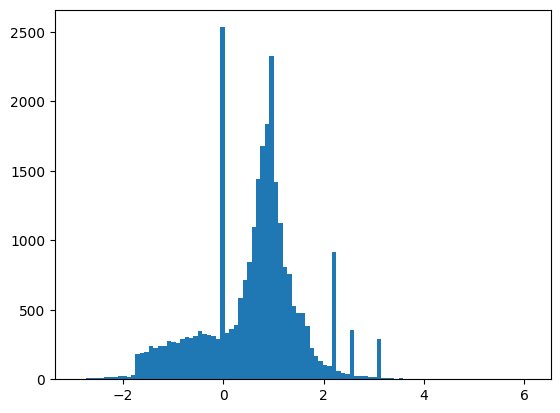

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

为了缩短本教程的篇幅，我们只使用前 1,000 个样本进行验证，再用接下来的 10,000 个样本进行训练：

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

`Dataset.skip` 和 `Dataset.take` 方法能够使这项操作变得容易。

同时，使用 `Dataset.cache` 方法来确保加载器无需每个周期都需要从文件重新读取数据。

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

这些数据集会返回单个样本。使用 `Dataset.batch` 方法创建适当大小的批次进行训练。在创建批次之前，还要记得在训练集上使用 `Dataset.shuffle` 和 `Dataset.repeat`。

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## 演示过拟合

要避免过拟合，最简单的方法是从小模型开始。小模型是指具有少量可学习参数（由层数和每层的单元数决定）的模型。在深度学习中，模型中可学习参数的数量通常被称为模型的“容量”。

凭直觉来看，模型的参数越多，“记忆容量”就越大，于是就能够轻松学习训练样本与其目标之间的字典式完美映射（这种映射没有任何泛化能力），但这在对以前未曾见过的数据进行预测时毫无用处。

请务必牢记：深度学习模型往往擅长拟合训练数据，但真正的挑战是泛化而非拟合。

另一方面，如果网络的记忆资源有限，便无法轻松学习映射。为了使损失最小化，它必须学习具有更强预测能力的压缩表示。同时，如果模型太小，则很难与训练数据拟合。我们需要找到“容量过剩”和“容量不足”之间的平衡点。

遗憾的是，没有什么神奇的公式可以确定模型的正确大小或架构（层数或每层的正确大小）。您必须用一系列不同的架构进行试验。

要找到合适的模型大小，最好先使用相对较少的层和参数，然后增加层的大小或添加新层，直到看到返回的验证损失逐渐减小。

先从仅使用密集连接层 (`tf.keras.layers.Dense`) 作为基线的简单模型开始，然后创建更大的模型并进行对比。

### 训练过程

如果在训练期间逐渐减小学习率，许多模型的训练效果会更好。请使用 `tf.keras.optimizers.schedules` 随着时间的推移减小学习率：

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

上述代码设置了一个 `tf.keras.optimizers.schedules.InverseTimeDecay`，用于在 1,000 个周期时将学习率根据双曲线的形状降至基础速率的 1/2，在 2,000 个周期时将至 1/3，依此类推。

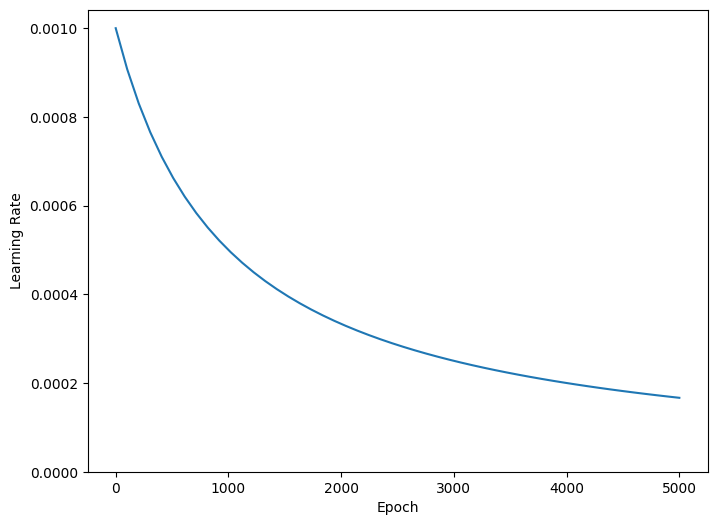

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


本教程中的每个模型都将使用相同的训练配置。因此，从回调列表开始，以可重用的方式对其进行设置。

本教程的训练会运行许多个较短周期。为了降低日志记录噪声，请使用 `tfdocs.EpochDots`，它仅会为每个周期打印一个 `.`，并每隔 100 个周期打印一整套指标。

然后，添加 `tf.keras.callbacks.EarlyStopping` 以避免冗长和不必要的训练时间。请注意，设置此回调是为了监视 `val_binary_crossentropy`，而不是 `val_loss`。这个区别在后面会很重要。

使用 `callbacks.TensorBoard` 为训练生成 TensorBoard 日志。


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

类似地，每个模型将使用相同的 `Model.compile` 和 `Model.fit` 设置：

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### 微模型

从训练下面的模型开始：

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                464       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 481 (1.88 KB)


Trainable params: 481 (1.88 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


I0000 00:00:1699402666.091410  613696 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch: 0, accuracy:0.5108,  binary_crossentropy:0.8620,  loss:0.8620,  val_accuracy:0.4970,  val_binary_crossentropy:0.8094,  val_loss:0.8094,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.5922,  binary_crossentropy:0.6287,  loss:0.6287,  val_accuracy:0.5910,  val_binary_crossentropy:0.6263,  val_loss:0.6263,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6142,  binary_crossentropy:0.6160,  loss:0.6160,  val_accuracy:0.6240,  val_binary_crossentropy:0.6118,  val_loss:0.6118,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6348,  binary_crossentropy:0.6044,  loss:0.6044,  val_accuracy:0.6420,  val_binary_crossentropy:0.5990,  val_loss:0.5990,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6498,  binary_crossentropy:0.5940,  loss:0.5940,  val_accuracy:0.6550,  val_binary_crossentropy:0.5905,  val_loss:0.5905,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6571,  binary_crossentropy:0.5888,  loss:0.5888,  val_accuracy:0.6730,  val_binary_crossentropy:0.5889,  val_loss:0.5889,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6665,  binary_crossentropy:0.5861,  loss:0.5861,  val_accuracy:0.6560,  val_binary_crossentropy:0.5892,  val_loss:0.5892,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6688,  binary_crossentropy:0.5837,  loss:0.5837,  val_accuracy:0.6700,  val_binary_crossentropy:0.5883,  val_loss:0.5883,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6738,  binary_crossentropy:0.5817,  loss:0.5817,  val_accuracy:0.6570,  val_binary_crossentropy:0.5893,  val_loss:0.5893,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

现在查看一下模型的表现：

(0.5, 0.7)

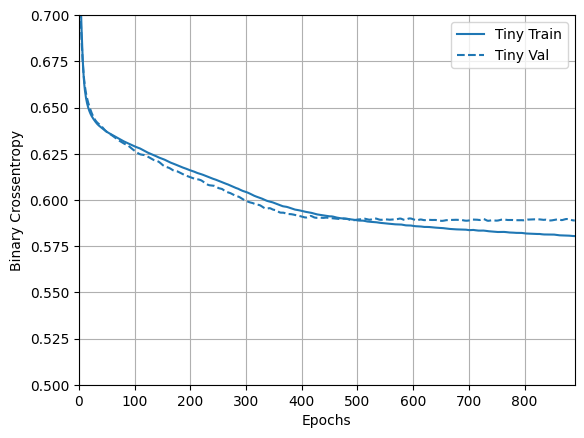

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### 小模型

要检查能否超过小模型的表现，需要逐步训练一些较大的模型。

请尝试两个隐藏层，其中每层包含 16 个单元：

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 16)                464       


 dense_3 (Dense)             (None, 16)                272       


 dense_4 (Dense)             (None, 1)                 17        


Total params: 753 (2.94 KB)


Trainable params: 753 (2.94 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.4870,  binary_crossentropy:0.7280,  loss:0.7280,  val_accuracy:0.4580,  val_binary_crossentropy:0.7200,  val_loss:0.7200,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6137,  binary_crossentropy:0.6174,  loss:0.6174,  val_accuracy:0.5620,  val_binary_crossentropy:0.6338,  val_loss:0.6338,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6508,  binary_crossentropy:0.5941,  loss:0.5941,  val_accuracy:0.6360,  val_binary_crossentropy:0.6041,  val_loss:0.6041,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6748,  binary_crossentropy:0.5793,  loss:0.5793,  val_accuracy:0.6520,  val_binary_crossentropy:0.5879,  val_loss:0.5879,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6867,  binary_crossentropy:0.5698,  loss:0.5698,  val_accuracy:0.6520,  val_binary_crossentropy:0.5845,  val_loss:0.5845,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6898,  binary_crossentropy:0.5636,  loss:0.5636,  val_accuracy:0.6560,  val_binary_crossentropy:0.5882,  val_loss:0.5882,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6955,  binary_crossentropy:0.5592,  loss:0.5592,  val_accuracy:0.6680,  val_binary_crossentropy:0.5851,  val_loss:0.5851,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### 中等模型

现在尝试三个隐藏层，其中每层包含 64 个单元：

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

然后使用相同的数据训练该模型：

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_5 (Dense)             (None, 64)                1856      


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 64)                4160      


 dense_8 (Dense)             (None, 1)                 65        


Total params: 10241 (40.00 KB)


Trainable params: 10241 (40.00 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5131,  binary_crossentropy:0.6829,  loss:0.6829,  val_accuracy:0.4950,  val_binary_crossentropy:0.6740,  val_loss:0.6740,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.7141,  binary_crossentropy:0.5301,  loss:0.5301,  val_accuracy:0.6270,  val_binary_crossentropy:0.6357,  val_loss:0.6357,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.7925,  binary_crossentropy:0.4239,  loss:0.4239,  val_accuracy:0.6410,  val_binary_crossentropy:0.7084,  val_loss:0.7084,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### 大模型

作为练习，您可以创建一个更大的模型，检查它开始过拟合的速度。接下来，为这个基准添加一个具有更大容量的网络，其容量远远超出解决问题的需要：

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

同样地，使用相同的数据训练该模型：

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             (None, 512)               14848     


 dense_10 (Dense)            (None, 512)               262656    


 dense_11 (Dense)            (None, 512)               262656    


 dense_12 (Dense)            (None, 512)               262656    


 dense_13 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5102,  binary_crossentropy:0.8272,  loss:0.8272,  val_accuracy:0.5610,  val_binary_crossentropy:0.6813,  val_loss:0.6813,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0024,  loss:0.0024,  val_accuracy:0.6540,  val_binary_crossentropy:1.7892,  val_loss:1.7892,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6480,  val_binary_crossentropy:2.4611,  val_loss:2.4611,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### 绘制训练和验证损失

实线表示训练损失，虚线表示验证损失（请记住：验证损失越低表示模型越好）。

虽然构建的模型越大，其能力越强，但如果不对这种能力进行限制，它很容易对训练集过拟合。

在此示例中，通常只有 `"Tiny"` 模型能完全避免过拟合，而其他较大的模型都更快地过拟合数据。对于 `"large"` 模型来说，过拟合的情况尤为严重，您必须将绘图切换为对数尺度才能真正弄清楚所发生的情况。

如果您绘制出验证指标并将其与训练指标进行对比的话，就会很明显。

- 有细微差别是正常的。
- 如果两个指标都朝同一方向移动，说明一切正常。
- 如果验证指标开始停滞，而训练指标继续提升，则可能即将出现过拟合。
- 如果验证指标的方向错误，则模型显然已经过拟合。

Text(0.5, 0, 'Epochs [Log Scale]')

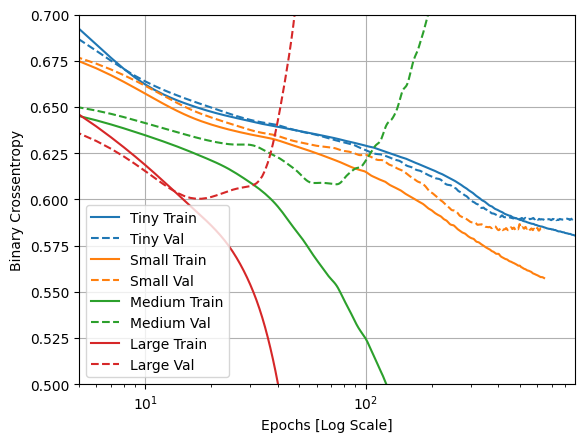

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

注：上面运行的所有训练都使用了 `callbacks.EarlyStopping`，会在发现模型没有进展后终止训练。

### 在 TensorBoard 中查看

上述模型都会在训练期间写入 TensorBoard 日志。

在笔记本中打开嵌入式 TensorBoard 查看器（抱歉，这不会在 tensorflow.org 上显示）：

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

您可以在 [TensorBoard.dev](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) 上查看此笔记本[先前运行的结果](https://tensorboard.dev/)。

## 防止过拟合的策略

在开始学习本部分内容之前，请先复制上述 `"Tiny"` 模型的训练日志，用作比较基线。

In [32]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmpfs/tmp/tmpjol485dc/tensorboard_logs/regularizers/Tiny')

In [33]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### 添加权重正则化


您可能对奥卡姆剃刀法则很熟悉：对某件事给出两种解释，正确的解释往往是“最简单”的那个，即做出最少假设的那个解释。这也适用于神经网络学习的模型：给定一些训练数据和一个网络架构，有多组权重值（多个模型）可以解释数据，而简单模型比复杂模型更不容易过拟合。

在此上下文中，“简单模型”是指参数值的分布具有更少的熵的模型（或者是具有更少参数的模型，如上文中所见）。因此，缓解过拟合的一种常用方式是限制网络的复杂性，方法是强制网络的权重值只取较小值，这样会使权重值的分布更加“规则”。这被称为“权重正则化”，通过向网络的损失函数添加一个与较大权重相关的成本来实现。这种成本有两种方式：

- [L1 正则化](https://developers.google.com/machine-learning/glossary/#L1_regularization)，其中添加的成本与权重系数的绝对值（即权重的“L1 范数”）成正比。

- [L2 正则化](https://developers.google.com/machine-learning/glossary/#L2_regularization)，其中添加的成本与权重系数值的平方（即权重的“L2 范数”）成正比。L2 正则化在神经网络中也被称为权重衰减。不要因为名称不同而感到困惑：从数学角度来讲，权重衰减与 L2 正则化完全相同。

L1 正则化会促使权重向零靠近，鼓励稀疏模型。L2 正则化会惩罚权重参数而不使其稀疏化，因为对于较小权重，惩罚会趋近于零。这也是 L2 更为常见的一个原因。

在 `tf.keras` 中，添加权重正则化的方式是将权重正则化器实例作为关键字参数传递给层。添加 L2 权重正则化：

In [34]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_14 (Dense)            (None, 512)               14848     


 dense_15 (Dense)            (None, 512)               262656    


 dense_16 (Dense)            (None, 512)               262656    


 dense_17 (Dense)            (None, 512)               262656    


 dense_18 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5065,  binary_crossentropy:0.8234,  loss:2.3574,  val_accuracy:0.4690,  val_binary_crossentropy:0.7087,  val_loss:2.1693,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6538,  binary_crossentropy:0.5950,  loss:0.6181,  val_accuracy:0.6600,  val_binary_crossentropy:0.5869,  val_loss:0.6104,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6698,  binary_crossentropy:0.5878,  loss:0.6107,  val_accuracy:0.6490,  val_binary_crossentropy:0.5856,  val_loss:0.6084,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6760,  binary_crossentropy:0.5773,  loss:0.6011,  val_accuracy:0.6860,  val_binary_crossentropy:0.5934,  val_loss:0.6170,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6817,  binary_crossentropy:0.5704,  loss:0.5935,  val_accuracy:0.6730,  val_binary_crossentropy:0.5789,  val_loss:0.6018,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6956,  binary_crossentropy:0.5655,  loss:0.5883,  val_accuracy:0.6800,  val_binary_crossentropy:0.5797,  val_loss:0.6025,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6991,  binary_crossentropy:0.5578,  loss:0.5825,  val_accuracy:0.6620,  val_binary_crossentropy:0.5858,  val_loss:0.6103,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

`l2(0.001)` 表示层的权重矩阵中的每个系数都会将 `0.001 * weight_coefficient_value**2` 添加到网络的总**损失**中。

这就是为什么我们要直接监视 `binary_crossentropy`，因为它没有混入此正则化组件。

因此，带有  `L2` 正则化惩罚的相同 `"Large"` 模型表现得更好：


(0.5, 0.7)

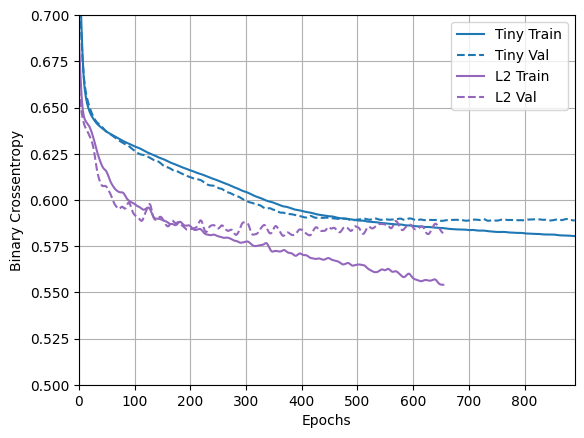

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

如上图所示，`"L2"` 正则化模型现在比 `"Tiny"` 模型更具竞争力。`"L2"` 模型也比它所基于的 `"Large"` 模型（具有相同数量的参数）更不容易过拟合。

#### 更多信息

关于此类正则化，有两个重要的注意事项：

1. 如果您正在编写自己的训练循环，请务必询问模型的正则化损失。

In [36]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

1. 此实现的工作方式是在模型的损失中添加权重惩罚，然后应用标准的优化程序。

还有一种方式，也就是仅在原始损失上运行优化器，然后在应用计算步骤的同时，优化器也应用一些权重衰减。此“解耦权重衰减”在 `tf.keras.optimizers.Ftrl` 和 `tfa.optimizers.AdamW` 等优化器中使用。

### 添加随机失活

随机失活是一种最有效、最常用的神经网络正则化技术，由 Hinton 和他在多伦多大学的学生共同开发。

随机失活的直观解释是，由于网络中的单个节点不能依赖其他节点的输出，所以每个节点必须输出对自己有用的特征。

应用于层时，随机失活会在训练期间对该层的多个输出特征进行随机“失活”（即设置为零）。例如，在训练期间，给定的层通常会为给定的输入样本返回一个 `[0.2, 0.5, 1.3, 0.8, 1.1]` 向量；应用随机失活后，该向量会有一些随机分布的零条目，例如 `[0, 0.5, 1.3, 0, 1.1]`。

“随机失活率”是指被清零的特征的比率；它通常设置为 0.2 到 0.5 之间。在测试时，没有单元会被随机失活，而是根据一个等于随机失活率的系数将层的输出值按比例缩小，进而实现平衡（因为会有更多单元在训练时被激活）。

在 Keras 中，您可以通过 `tf.keras.layers.Dropout` 层在网络中引入随机失活，该层将应用于前一层的输出。

向网络中添加两个随机失活层，检查它们在减少过拟合方面的表现：

In [37]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_19 (Dense)            (None, 512)               14848     


 dropout (Dropout)           (None, 512)               0         


 dense_20 (Dense)            (None, 512)               262656    


 dropout_1 (Dropout)         (None, 512)               0         


 dense_21 (Dense)            (None, 512)               262656    


 dropout_2 (Dropout)         (None, 512)               0         


 dense_22 (Dense)            (None, 512)               262656    


 dropout_3 (Dropout)         (None, 512)               0         


 dense_23 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5053,  binary_crossentropy:0.7921,  loss:0.7921,  val_accuracy:0.5070,  val_binary_crossentropy:0.6695,  val_loss:0.6695,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6570,  binary_crossentropy:0.5956,  loss:0.5956,  val_accuracy:0.6810,  val_binary_crossentropy:0.5867,  val_loss:0.5867,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6863,  binary_crossentropy:0.5592,  loss:0.5592,  val_accuracy:0.6870,  val_binary_crossentropy:0.5787,  val_loss:0.5787,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.7270,  binary_crossentropy:0.5068,  loss:0.5068,  val_accuracy:0.6780,  val_binary_crossentropy:0.6100,  val_loss:0.6100,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

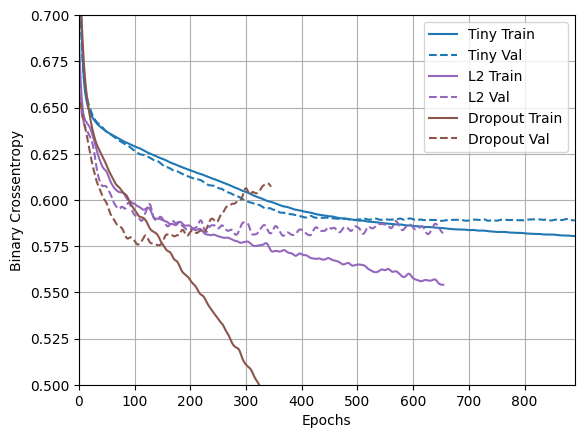

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

从上面的绘图中可以清楚地看到，这两种正则化方法都改善了 `"Large"` 模型的行为，但依然没有超过 `"Tiny"` 基线。

接下来，将两者合起来试一试，看看效果是否更好。

### L2 + 随机失活的结合

In [39]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_24 (Dense)            (None, 512)               14848     


 dropout_4 (Dropout)         (None, 512)               0         


 dense_25 (Dense)            (None, 512)               262656    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_26 (Dense)            (None, 512)               262656    


 dropout_6 (Dropout)         (None, 512)               0         


 dense_27 (Dense)            (None, 512)               262656    


 dropout_7 (Dropout)         (None, 512)               0         


 dense_28 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5017,  binary_crossentropy:0.7937,  loss:0.9521,  val_accuracy:0.5170,  val_binary_crossentropy:0.6740,  val_loss:0.8317,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6385,  binary_crossentropy:0.6051,  loss:0.6348,  val_accuracy:0.6600,  val_binary_crossentropy:0.5836,  val_loss:0.6131,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6614,  binary_crossentropy:0.5896,  loss:0.6152,  val_accuracy:0.6830,  val_binary_crossentropy:0.5711,  val_loss:0.5968,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6766,  binary_crossentropy:0.5780,  loss:0.6065,  val_accuracy:0.6730,  val_binary_crossentropy:0.5641,  val_loss:0.5926,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6707,  binary_crossentropy:0.5786,  loss:0.6086,  val_accuracy:0.6870,  val_binary_crossentropy:0.5601,  val_loss:0.5901,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6854,  binary_crossentropy:0.5689,  loss:0.6007,  val_accuracy:0.6810,  val_binary_crossentropy:0.5577,  val_loss:0.5896,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6821,  binary_crossentropy:0.5669,  loss:0.6007,  val_accuracy:0.6970,  val_binary_crossentropy:0.5466,  val_loss:0.5804,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6897,  binary_crossentropy:0.5641,  loss:0.5996,  val_accuracy:0.7040,  val_binary_crossentropy:0.5417,  val_loss:0.5771,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6867,  binary_crossentropy:0.5619,  loss:0.5990,  val_accuracy:0.6820,  val_binary_crossentropy:0.5556,  val_loss:0.5926,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.7003,  binary_crossentropy:0.5502,  loss:0.5889,  val_accuracy:0.6930,  val_binary_crossentropy:0.5509,  val_loss:0.5896,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

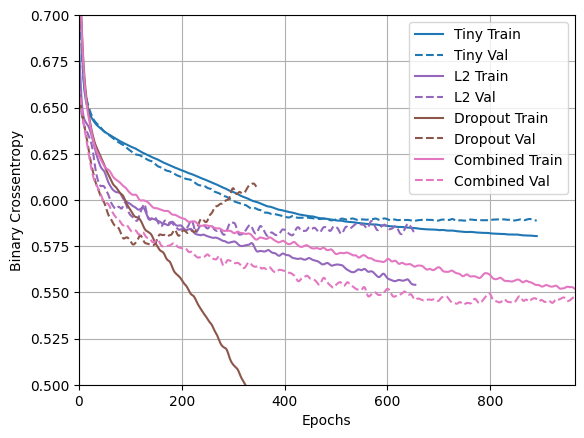

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

这个使用 `"Combined"` 正则化的模型显然是目前为止最好的模型。

### 在 TensorBoard 中查看

这些模型也记录了 TensorBoard 日志。

要打开嵌入式查看器，请运行以下代码单元（抱歉，这不会在 tensorflow.org 上显示）：

In [ ]:
%tensorboard --logdir {logdir}/regularizers

您可以在 [TensorBoard.dev](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) 上查看此笔记本[先前运行的结果](https://tensorboard.dev/)。

## 结论

回顾一下，以下是在神经网络中防止过拟合的最常见方式：

- 获得更多训练数据。
- 降低网络容量。
- 添加权重正则化。
- 添加随机失活

本指南没有涵盖的两个重要方法是：

- [数据增强](../images/data_augmentation.ipynb)
- 批次归一化 (`tf.keras.layers.BatchNormalization`)

请记住，单独使用每种方法也会有效，但结合使用通常效果更好。